**<h2>Computing Water Potential Energy Surface Using Behler and Parinello Symmetry Functions** 

Importing relevant packages from PyTorch

In [1]:
"""
Created on Sat May 15 17:34:55 2021
@author: Katerina Karoni
"""
import torch                        # Torch is an open-source machine learning library, a scientific computing framework,
                                       #and a script language
import torch.nn as nn
import torch.nn.functional as F     # Convolution Functions
import torch.optim as optim         # Package implementing various optimization algorithms
import matplotlib.pyplot as plt
from torchvision import datasets, transforms  #The torchvision package consists of popular datasets, model 
                                              #architectures, and common image transformations for computer vision
from torch.utils.data import DataLoader, TensorDataset       #Data loading utility class
from torch import Tensor
import pandas as pd

import numpy as np
import random
import os
import ase
from ase import Atoms
from ase.io import read

Loading the data (energies and geometries) for 1000 water molecule configurations in .xyz form

In [2]:
energies = np.genfromtxt('./water/energies.txt')
print("Energies file has",np.shape(energies),"entries")
#geometry_data =  read('./water/structures.xyz',index=':')
#print("Geometry file has",np.shape(geometry_data),"entries")
#print(geometry_data[0])
#geometry_data = np.array(geometry_data)

Energies file has (1000,) entries


In [3]:
# see https://education.molssi.org/python-data-analysis/01-numpy-arrays/index.html
#https://stackoverflow.com/questions/23353585/got-1-columns-instead-of-error-in-numpy

file_location = os.path.join('water', 'structures.xyz')
xyz_file = np.genfromtxt(fname=file_location, skip_header=2, dtype='unicode',invalid_raise = False)
# where invalid_raise = False was used to skip all lines in the xyz file that only have one column
symbols = xyz_file[:,0]
coordinates = (xyz_file[:,1:-1])
coordinates = coordinates.astype(np.float)

#print(symbols)
#print(coordinates)

<ipython-input-3-c38e52de7b08>:5: ConversionWarning: Some errors were detected !
    Line #6 (got 1 columns instead of 5)
    Line #11 (got 1 columns instead of 5)
    Line #16 (got 1 columns instead of 5)
    Line #21 (got 1 columns instead of 5)
    Line #26 (got 1 columns instead of 5)
    Line #31 (got 1 columns instead of 5)
    Line #36 (got 1 columns instead of 5)
    Line #41 (got 1 columns instead of 5)
    Line #46 (got 1 columns instead of 5)
    Line #51 (got 1 columns instead of 5)
    Line #56 (got 1 columns instead of 5)
    Line #61 (got 1 columns instead of 5)
    Line #66 (got 1 columns instead of 5)
    Line #71 (got 1 columns instead of 5)
    Line #76 (got 1 columns instead of 5)
    Line #81 (got 1 columns instead of 5)
    Line #86 (got 1 columns instead of 5)
    Line #91 (got 1 columns instead of 5)
    Line #96 (got 1 columns instead of 5)
    Line #101 (got 1 columns instead of 5)
    Line #106 (got 1 columns instead of 5)
    Line #111 (got 1 columns instead

In [54]:
## Alternatively loading the data in .npy form
# # The data was downloaded from http://www.quantum-machine.org/datasets/ (Densities dataset--> water.zip)
# # The data includes energies, densities and structure for water molecules
# #For each dataset, structures are given in with positions in Bohr and the energies are given in kcal/mol 
# energy_data = np.load('./water_102/dft_energies.npy')
# print("Energies file has",np.shape(energy_data),"entries")
# geometry_data =  np.load('./water-2/water_102/structures.npy')
# print("Geometry file has",np.shape(geometry_data),"entries")
# print(type(energy_data))
# print(type(geometry_data))

In [55]:
print(np.shape(coordinates))
print(type(coordinates))
print(coordinates[0])
print(coordinates[1])
print(coordinates[2])

print('gfjkhgfjhgfkgh')
print(coordinates[3])
print(coordinates[4])
print(coordinates[5])

print(energies[0])
# There is 1000 water molecules and each of them consists of 3 atoms, so we have 3000 atoms in total and each
# of them has 3 coordinates.
# Thus the coordinates array has 3000 lines, each of them corresponding to one atom (the first three lines
# correspopnd to the first water molecule) and 3 columns corresponding to the x, y and z coordinates respectively.

(3000, 3)
<class 'numpy.ndarray'>
[0.         0.769767   0.55746937]
[ 0.         -0.71017975  0.50340914]
[ 0.         -0.0037242  -0.06630491]
gfjkhgfjhgfkgh
[0.         0.77715107 0.59586089]
[ 0.         -0.77642641  0.59515778]
[ 0.000000e+00 -4.529000e-05 -7.443867e-02]
-13815.2523726009


In [56]:
print(coordinates)

[[ 0.          0.769767    0.55746937]
 [ 0.         -0.71017975  0.50340914]
 [ 0.         -0.0037242  -0.06630491]
 ...
 [ 0.          0.81441381  0.59863567]
 [ 0.         -0.76145415  0.54978922]
 [ 0.         -0.00330998 -0.07177656]]


**<h2>Cutoff Function** 
    $$f_c(R_{ij}) = 
    \begin{cases}
        0.5 \times \big[\cos\big(\frac{\pi R_{ij}}{R_c}\big)+1\big]  & \text{for } R_{ij} \leq R_c\\
        0  & \text{for } R_{ij} > R_c
    \end{cases}
    $$
    
In the Behler and Parinello paper the Cutoff radius $R_c$ was taken to be $6$  Ångströms, or 11.3384 Bohr radii. (Remember, 1 Ångström is $10^{-10}$m)

In [57]:
def fc(R,Rc):
    if R <= Rc:
        fcutoff = 0.5 * (np.cos(np.pi*R/Rc)+1)
    else:
        fcutoff = 0
    return fcutoff

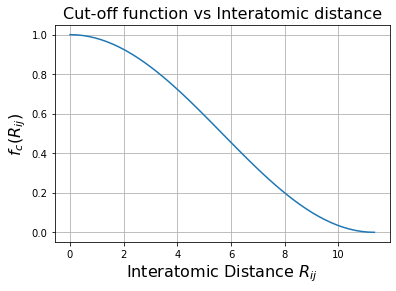

In [58]:
# Plotting fc as a function of interatomic distance Rij

Rc  = 11.3384 # Bohr

Rij     = np.linspace(0,Rc)
fcutoff = np.zeros(np.size(Rij))

for i in range(np.size(Rij)):
    fcutoff[i] = fc(Rij[i],Rc)

plt.plot(Rij,fcutoff)
plt.title('Cut-off function vs Interatomic distance', fontsize=16)
plt.xlabel('Interatomic Distance $R_{ij}$', fontsize=16)
plt.ylabel('$f_c(R_{ij})$', fontsize=16)
plt.grid()

**<h2>Pairwise Distances**

$$Dp = \begin{bmatrix} R_{00} & R_{01} & R_{02} \\ R_{10} & R_{11} & R_{12} \\ R_{20} & R_{21} & R_{22} \end{bmatrix} = \begin{bmatrix} 0 & R_{01} & R_{02} \\ R_{01} & 0 & R_{12} \\ R_{02} & R_{12} & 0 \end{bmatrix} $$

In [59]:
i = 0                                # i-th water molecule
coord = coordinates[3*i:3*(i+1),:]   # Let's take the coordinates of the ith water molecule in our dataset and compute
                                     # pairwise distances between all of its 3 atom

def pairwise_distances(coord):                       # we pass in the coordinates of the 3 atoms in the water molecule
    N = len(coord)
    pairwise_dist_matrix = np.zeros((N,N))       # Initialise the matrix
    for i in range(0,N-1):
#        print('i=',i)
        for j in range(i+1,N):
#            print(j)
#            pairwise_dist_matrix[i][j] = \
#            np.sqrt(  (coord[i][0] - coord[j][0] )**2 + (coord[i][1] - coord[j][1] )**2 +(coord[i][2] - coord[j][2] )**2   )
            pairwise_dist_matrix[i][j] =  np.sqrt(sum( (coord[i,:] - coord[j,:])**2 ))
            pairwise_dist_matrix[j][i] = pairwise_dist_matrix[i][j]

    return pairwise_dist_matrix

Dp = pairwise_distances(coord)
print(Dp)



[[0.         1.48093379 0.99367147]
 [1.48093379 0.         0.9075536 ]
 [0.99367147 0.9075536  0.        ]]


**<h2>From Cartesian to Generalised Coordinates**

**<h3>Radial Symmetry Functions**
    
<h3>$$G_i^1 = \sum_{j \neq i}^{\text{all}} e^{-\eta (R_{ij}-R_s)^2} f_c (R_{ij})$$

In [60]:
heta = 0.1
Rs   = 0
N    = len(coord)


def radial_BP_symm_func(Dp,N,heta,Rs):
    G_mu1 = np.zeros(len(Dp))           # since we are dealing with water molecules the dimension of G will be 3 (H,H,O)
    for i in range(N):                 # to avoid using an if statement (if i not equal j), break the sum in two
        for j in range(0,i):
            G_mu1[i] = G_mu1[i] + np.exp(-heta*(Dp[i][j]-Rs)**2)* fc(Dp[i][j],Rc) 
        for j in range(i+1,N):
            G_mu1[i] = G_mu1[i] +  np.exp(-heta*(Dp[i][j]-Rs)**2)* fc(Dp[i][j],Rc) 
    return G_mu1

Gmu1 = radial_BP_symm_func(Dp,N,heta,Rs)
print(Gmu1)

[1.65865495 1.67618952 1.79537284]


**<h3> Angular Symmetry Functions**

$$G_i^2 = 2^{1-\zeta} \sum_{j,k \neq i}^{\text{all}} (1+\lambda \cos \theta_{ijk})^\zeta \times e^{-\eta (R_{ij}^2+R_{ik}^2+R_{jk}^2 )} f_c (R_{ij})f_c (R_{ik})f_c (R_{jk})$$
    
with parameters $\lambda = +1, -1$, $\eta$ and $\zeta$

In [61]:
lambdaa = 1     #1
zeta    = 0.2
heta    = 0.1

N = len(coord)

def angular_BP_symm_func(coord,Dp,N,heta,Rs,lambdaa,zeta):
    G_mu2 = np.zeros(len(Dp))           # since we are dealing with water molecules the dimension of G will be 3 (H,H,O)

    for i in range(N):                 # to avoid using an if statement (if i not equal j), break the sum in two
        for j in range(N):           
            for k in range(N):
                if j != i and k !=i:
                    R_vec_ij = coord[i,:] - coord[j,:]
                    R_vec_jk = coord[i,:] - coord[k,:]
                    cos_theta_ijk  = np.dot(R_vec_ij, R_vec_jk)/(Dp[i][j]*Dp[i][k])
                    G_mu2[i]   = G_mu2[i] + (  1 + lambdaa * cos_theta_ijk )**zeta  \
                                * np.exp( -heta * (Dp[i][j]**2 + Dp[i][k]**2 + Dp[j][k]**2) ) \
                                * fc(Dp[i][j],Rc) * fc(Dp[i][k],Rc) * fc(Dp[j][k],Rc)            
        G_mu2[i]   = 2**(1-zeta) * G_mu2[i] 
    return G_mu2

Gmu2 = angular_BP_symm_func(coord,Dp,N,heta,Rs,lambdaa,zeta)
print(Gmu2)

[5.19473151 5.24520024 5.28298916]


In [62]:
np.cos(180)

-0.5984600690578581

**<h2>Training and Test Set**

In [135]:
N                    = 3           # number of atoms per molecule
number_of_features   = 6           # number of features (symmetry functions) for each atom (we create one radial)
                                   # and one angular, but can create more by vaying the parameters η, λ, ζ, Rs etc.

heta   = np.linspace(0.01, 4, num=number_of_features)
random.shuffle(heta)

Rs     = np.linspace(0, 1, num=number_of_features)
random.shuffle(Rs)

lambdaa = np.ones(number_of_features)
random.shuffle(lambdaa)

zeta    = np.linspace(0, 8, num=number_of_features)
random.shuffle(zeta)


data_size            = np.shape(energies)[0]        # We have 1000 water molecule conformations
training_set_size    = data_size - 100



    
G = np.zeros((len(coordinates), number_of_features))  # we have 3000x2 features (2 symm funcs for ech of the 3000 atoms in the dataset)

for i in range(data_size):
    coord = coordinates[N*i:N*(i+1),:]
    Dp    = pairwise_distances(coord)
    for j in range(0,number_of_features,2):
        G[N*i:N*(i+1),j]   = radial_BP_symm_func(Dp,N,heta[j],Rs[j])     
        G[N*i:N*(i+1),j+1] = angular_BP_symm_func(coord,Dp,N,heta[j],Rs[j],lambdaa[j],zeta[j])
    
# Computing variance and mean on the training data only!
G_train = G[:training_set_size,:]
var  = np.var(G_train,axis=0)
mean = np.mean(G_train,axis=0)

# normalize all data (training and test), using training set mean and variance
for i in range(np.shape(G)[0]):
    for j in range(np.shape(G)[1]):
        G[i,j] = (G[i,j]-mean[j])/var[j]   


data_set = np.vsplit(G,data_size)     # Going from a (3000,2) np.array to a (1000,3,2) list
#data_set = np.random.permutation(training_set)
data_set = torch.FloatTensor(data_set)          # Going from a (1000,3,2) list to a a (1000,3,2) tensor

# print(data_set[0])
# print(data_set[0][1][1])
labels = torch.FloatTensor(energies)            # turning energies into a (1000) tensor

# Splitting the dataset into training and test set
training_set         = data_set[:training_set_size]
test_set             = data_set[training_set_size:]

train_labels         = labels[:training_set_size]
test_labels          = labels[training_set_size:]

# Dataset
dataset = TensorDataset(training_set, train_labels)
#print(dataset[0])

# Creating the batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                           shuffle=False, num_workers=2, drop_last=False) # ?????

print(np.shape(training_set))

torch.Size([900, 3, 6])


In [136]:
a = np.array([[1.0,2.0],[3.0,4.0],[5.0,6.0]])
# for i in range(3):
#     a[i,0] = a[i,0]/(sum(a[:,0])/3)
# print(a)

b = (sum(a[:,0])/3)
print(b)
print(type(b))
a[0,0] = a[0,0]/b
print(a)

3.0
<class 'numpy.float64'>
[[0.33333333 2.        ]
 [3.         4.        ]
 [5.         6.        ]]


**<h2>Building Neural Network Architecture**

In [137]:
class Subnets(nn.Module):
    def __init__(self):
        super(Subnets, self).__init__()
        self.fc1 = nn.Linear(6, 3)        # where fc stands for fully connected 
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 1)
#         self.fc6 = nn.Linear(6, 4)
#         self.fc7 = nn.Linear(4, 2)
#         self.fc8 = nn.Linear(2, 1)


    def forward(self, x,train = True):
        x = torch.relu(self.fc1(x))           # Apply a tanh activation on fully connected layer 1 
        x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         x = torch.tanh(self.fc4(x))
#         x = torch.tanh(self.fc5(x))
#         x = torch.tanh(self.fc6(x))
#         x = torch.tanh(self.fc7(x))
        x = self.fc3(x)                   # Using a linear function (identity function) for the subnet output layers
        return x

class BPNN(nn.Module):
    def __init__(self):
        super(BPNN, self).__init__()
        self.network1 = Subnets()
        self.network2 = Subnets()
        self.network3 = Subnets()
        
#        self.fc_out = nn.Linear(3, 1)      # should this be defined here, given that we are not trying to optimise
        
    def forward(self, x1, x2, x3,train = True):
        x1 = self.network1(x1)
        x2 = self.network2(x2)
        x3 = self.network3(x3)
        
#         print(x1)
#         print(x2)
#         print(x3)
        
        x = torch.cat((x1, x2, x3), 0) 
#        x = self.fc_out(x)
        x = torch.sum(x)                   #??????????????????????????? try average pooling?
        x = torch.reshape(x,[1])
        return x

    
model = BPNN()
N = 1
x1, x2, x3 = training_set[0]
print('x1',x1)
print('x2',x2)
print('x3',x3)


output = model(x1, x2, x3)
print('output')
print(output)


# print(model)

# print('Network1')

# print('layer 1')
# print('weights')
# print(model.network1.fc1.weight)
# print('biases')
# print(model.network1.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network1.fc2.weight)
# print('biases')
# print(model.network1.fc2.bias)

# print('Network2')

# print('layer 1')
# print('weights')
# print(model.network2.fc1.weight)
# print('biases')
# print(model.network2.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network2.fc2.weight)
# print('biases')
# print(model.network2.fc2.bias)

# print('Network3')

# print('layer 1')
# print('weights')
# print(model.network3.fc1.weight)
# print('biases')
# print(model.network3.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network3.fc2.weight)
# print('biases')
# print(model.network3.fc2.bias)



x1 tensor([  -1.4929, -144.8698,  -13.3890, -484.8426,   -2.9318,  -12.6823])
x2 tensor([ -1.7789,  74.7832,   1.6739, 281.8832,  -1.1919,   2.1437])
x3 tensor([  4.6435, 191.9943,  23.3655, 562.7197,   6.4272,  22.1569])
output
tensor([14.4701], grad_fn=<ViewBackward>)


In [138]:
# class simplenn(nn.Module):
#     def __init__(self):
#         super(simplenn, self).__init__()
#         self.fc1 = nn.Linear(2, 3)        # where fc stands for fully connected 
#         self.fc2 = nn.Linear(3, 1)        
   

#     def forward(self, x):
#         x = torch.tanh(self.fc1(x))           # Apply a tanh activation on fully connected layer 1 
#         x = self.fc2(x)                   # Using a linear function (identity function) for the subnet output layers
#         return x

# mod = simplenn()

# print(mod.fc1.weight)
# print(mod.fc1.bias)

# print(mod.fc2.weight)
# print(mod.fc2.bias)

In [139]:
# x1, x2, x3 = training_set[0]
# x1 = x1[:2]
# x2 = x2[:2]

# x1[0] = -18650
# x1[1] = 109075
# print('x1',x1)

# x2[0] = -6
# x2[1] = 7
# print('x2',x2)

# output1 = mod(x1)
# print('output1')
# print(output1)

# output2 = mod(x2)
# print('output2')
# print(output2)

In [140]:
x1, x2, x3 = training_set[0]
print('x1',x1)
print('x2',x2)
print('x3',x3)


output = model(x1, x2, x3)
print('output')
print(output)

x1 tensor([  -1.4929, -144.8698,  -13.3890, -484.8426,   -2.9318,  -12.6823])
x2 tensor([ -1.7789,  74.7832,   1.6739, 281.8832,  -1.1919,   2.1437])
x3 tensor([  4.6435, 191.9943,  23.3655, 562.7197,   6.4272,  22.1569])
output
tensor([14.4701], grad_fn=<ViewBackward>)


In [141]:
## Manually compute neural Network output

# w11 = model.network1.fc1.weight
# b11 = model.network1.fc1.bias
# print(np.shape(w11))
# x1 = np.reshape(x1,(2,1))
# x1 = np.array(x1)
# print(np.shape(x1))

# w11 = w11.cpu().detach().numpy()
# b11 = b11.cpu().detach().numpy()
# #b11 = np.transpose(b11)
# b11 = np.reshape(b11,(3,1))
# print(np.shape(b11))
# print(type(x1))
# print(type(w11))

# a11 = np.matmul(w11,x1) + b11
# a11 = np.tanh(a11)
# print(a11)
# #print(torch.tensordot(w11,x1))


In [142]:
print('layer 1')
print('weights')
print(model.network1.fc1.weight)
print('biases')
print(model.network1.fc1.bias)

print('layer 2')
print('weights')
print(model.network1.fc2.weight)
print('biases')
print(model.network1.fc2.bias)

layer 1
weights
Parameter containing:
tensor([[-0.1593,  0.1846,  0.2987, -0.3702,  0.2349, -0.1019],
        [ 0.3785,  0.2303, -0.0714,  0.1237,  0.0867, -0.0330],
        [-0.2741, -0.2900, -0.1113,  0.2286, -0.2257, -0.0166]],
       requires_grad=True)
biases
Parameter containing:
tensor([-0.1067, -0.1988, -0.3079], requires_grad=True)
layer 2
weights
Parameter containing:
tensor([[ 0.0982,  0.1214,  0.0766],
        [ 0.2369,  0.3695,  0.1897],
        [ 0.4577, -0.4180, -0.2325]], requires_grad=True)
biases
Parameter containing:
tensor([ 0.1875, -0.0810,  0.5457], requires_grad=True)


**<h2>Training the Neural Network**

In [143]:
net = BPNN()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
#torch.optim.LBFGS(net.parameters(), lr=0.001, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, line_search_fn=None)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.1)
nepochs = 100


train_loss = np.zeros(nepochs)
test_loss = np.zeros(nepochs)


train_acc = np.zeros(nepochs)
test_acc = np.zeros(nepochs)
for epoch in range(nepochs):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_train_loss = 0.0
    epoch_test_loss = 0.0
    counter = 0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#        inputs = torch.reshape(inputs,(N,number_of_features))   #  hard-coded !!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        # zero the parameter gradients
        optimizer.zero_grad()

#         print(np.shape(inputs))
#         print(inputs)
        
        # forward + backward + optimize

        outputs = net(inputs[0][0],inputs[0][1],inputs[0][2])        #??????????????????????????????????????
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_train_loss += loss.item()


        
        print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss))
        running_loss = 0.0    

print('Finished Training')

[1,     1] loss: 190776896.000
[1,     2] loss: 190303472.000
[1,     3] loss: 190819184.000
[1,     4] loss: 190732416.000
[1,     5] loss: 190106544.000
[1,     6] loss: 190337968.000
[1,     7] loss: 189614352.000
[1,     8] loss: 190270048.000
[1,     9] loss: 189471488.000
[1,    10] loss: 190796464.000
[1,    11] loss: 190028992.000
[1,    12] loss: 190394480.000
[1,    13] loss: 190589184.000
[1,    14] loss: 189806864.000
[1,    15] loss: 189749248.000
[1,    16] loss: 189647600.000
[1,    17] loss: 190588384.000
[1,    18] loss: 188751664.000
[1,    19] loss: 188001824.000
[1,    20] loss: 186325760.000
[1,    21] loss: 190853072.000
[1,    22] loss: 190240144.000
[1,    23] loss: 188589152.000
[1,    24] loss: 189574928.000
[1,    25] loss: 189380016.000
[1,    26] loss: 188776832.000
[1,    27] loss: 187878768.000
[1,    28] loss: 185794528.000
[1,    29] loss: 189470704.000
[1,    30] loss: 185041776.000
[1,    31] loss: 189358640.000
[1,    32] loss: 186482608.000
[1,    3

[1,   329] loss: 40131928.000
[1,   330] loss: 22133082.000
[1,   331] loss: 1240476.000
[1,   332] loss: 60176320.000
[1,   333] loss: 17442972.000
[1,   334] loss: 35604168.000
[1,   335] loss: 4078538.000
[1,   336] loss: 18289572.000
[1,   337] loss: 40648856.000
[1,   338] loss: 15685800.000
[1,   339] loss: 21445284.000
[1,   340] loss: 87720256.000
[1,   341] loss: 15238006.000
[1,   342] loss: 2241965.250
[1,   343] loss: 913738.062
[1,   344] loss: 63866740.000
[1,   345] loss: 19705362.000
[1,   346] loss: 17219064.000
[1,   347] loss: 67906952.000
[1,   348] loss: 7621891.500
[1,   349] loss: 235520.641
[1,   350] loss: 7880636.000
[1,   351] loss: 6694575.000
[1,   352] loss: 4785596.500
[1,   353] loss: 81304072.000
[1,   354] loss: 41412268.000
[1,   355] loss: 4927181.500
[1,   356] loss: 129523048.000
[1,   357] loss: 64084608.000
[1,   358] loss: 13111139.000
[1,   359] loss: 8469964.000
[1,   360] loss: 200070.125
[1,   361] loss: 11244980.000
[1,   362] loss: 2364598

[1,   684] loss: 15640094.000
[1,   685] loss: 66852.547
[1,   686] loss: 71013968.000
[1,   687] loss: 11227506.000
[1,   688] loss: 53900144.000
[1,   689] loss: 11544353.000
[1,   690] loss: 12972547.000
[1,   691] loss: 43452288.000
[1,   692] loss: 59156956.000
[1,   693] loss: 26559840.000
[1,   694] loss: 6390660.500
[1,   695] loss: 50272768.000
[1,   696] loss: 75548960.000
[1,   697] loss: 36985.977
[1,   698] loss: 18631.184
[1,   699] loss: 1125002.000
[1,   700] loss: 103315712.000
[1,   701] loss: 47916120.000
[1,   702] loss: 3504208.500
[1,   703] loss: 26166512.000
[1,   704] loss: 34491328.000
[1,   705] loss: 78121000.000
[1,   706] loss: 119786248.000
[1,   707] loss: 11291753.000
[1,   708] loss: 41299552.000
[1,   709] loss: 42399416.000
[1,   710] loss: 55702448.000
[1,   711] loss: 6570701.000
[1,   712] loss: 99409664.000
[1,   713] loss: 482372.312
[1,   714] loss: 81236368.000
[1,   715] loss: 324829.875
[1,   716] loss: 27748810.000
[1,   717] loss: 16702771

[2,    63] loss: 64013788.000
[2,    64] loss: 64735328.000
[2,    65] loss: 25393686.000
[2,    66] loss: 46877964.000
[2,    67] loss: 5578984.000
[2,    68] loss: 757343.562
[2,    69] loss: 554750.000
[2,    70] loss: 42046348.000
[2,    71] loss: 473253.969
[2,    72] loss: 822599.375
[2,    73] loss: 10447844.000
[2,    74] loss: 82644896.000
[2,    75] loss: 9332023.000
[2,    76] loss: 49580708.000
[2,    77] loss: 8260763.000
[2,    78] loss: 130962.000
[2,    79] loss: 24861958.000
[2,    80] loss: 6286523.000
[2,    81] loss: 560589888.000
[2,    82] loss: 2366339.250
[2,    83] loss: 17466734.000
[2,    84] loss: 105770136.000
[2,    85] loss: 30442924.000
[2,    86] loss: 20820264.000
[2,    87] loss: 4952029.000
[2,    88] loss: 59184112.000
[2,    89] loss: 444806.938
[2,    90] loss: 28621162.000
[2,    91] loss: 50009752.000
[2,    92] loss: 15388105.000
[2,    93] loss: 79385.812
[2,    94] loss: 22724400.000
[2,    95] loss: 18328148.000
[2,    96] loss: 16994410.000

[2,   352] loss: 26975.496
[2,   353] loss: 59196192.000
[2,   354] loss: 23974736.000
[2,   355] loss: 1429869.500
[2,   356] loss: 88361360.000
[2,   357] loss: 20924684.000
[2,   358] loss: 22112294.000
[2,   359] loss: 39644.156
[2,   360] loss: 6191223.000
[2,   361] loss: 9816693.000
[2,   362] loss: 4186351.750
[2,   363] loss: 101.274
[2,   364] loss: 4052035.250
[2,   365] loss: 5332342.500
[2,   366] loss: 43921012.000
[2,   367] loss: 21999352.000
[2,   368] loss: 851521.625
[2,   369] loss: 14616128.000
[2,   370] loss: 9392429.000
[2,   371] loss: 41674956.000
[2,   372] loss: 1668128.625
[2,   373] loss: 625055.438
[2,   374] loss: 47199072.000
[2,   375] loss: 10876875.000
[2,   376] loss: 2667926.750
[2,   377] loss: 22908152.000
[2,   378] loss: 15478423.000
[2,   379] loss: 37399948.000
[2,   380] loss: 1105613.250
[2,   381] loss: 2272191.250
[2,   382] loss: 29079372.000
[2,   383] loss: 433976.000
[2,   384] loss: 6061069.000
[2,   385] loss: 1059472.125
[2,   386]

[2,   669] loss: 23371664.000
[2,   670] loss: 110425080.000
[2,   671] loss: 968204.125
[2,   672] loss: 4654246.000
[2,   673] loss: 29826.707
[2,   674] loss: 4038867.500
[2,   675] loss: 244771.766
[2,   676] loss: 3000334.750
[2,   677] loss: 703075.688
[2,   678] loss: 514395.719
[2,   679] loss: 13784215.000
[2,   680] loss: 5894245.000
[2,   681] loss: 6739226.000
[2,   682] loss: 13859.544
[2,   683] loss: 2858295.500
[2,   684] loss: 8953391.000
[2,   685] loss: 11197056.000
[2,   686] loss: 23559656.000
[2,   687] loss: 17550134.000
[2,   688] loss: 7884771.000
[2,   689] loss: 961.545
[2,   690] loss: 13674489.000
[2,   691] loss: 14142785.000
[2,   692] loss: 9793831.000
[2,   693] loss: 26513690.000
[2,   694] loss: 237938.172
[2,   695] loss: 6389540.000
[2,   696] loss: 41144932.000
[2,   697] loss: 314333.250
[2,   698] loss: 4100.001
[2,   699] loss: 11612381.000
[2,   700] loss: 61740744.000
[2,   701] loss: 5334101.500
[2,   702] loss: 6670749.000
[2,   703] loss: 3

[3,    74] loss: 24502480.000
[3,    75] loss: 1653851.250
[3,    76] loss: 6863453.500
[3,    77] loss: 1782965.625
[3,    78] loss: 1313327.250
[3,    79] loss: 5094000.500
[3,    80] loss: 2257653.000
[3,    81] loss: 184817072.000
[3,    82] loss: 28521.404
[3,    83] loss: 1641941.875
[3,    84] loss: 47390464.000
[3,    85] loss: 4440177.500
[3,    86] loss: 12805026.000
[3,    87] loss: 19162986.000
[3,    88] loss: 30082064.000
[3,    89] loss: 397024.281
[3,    90] loss: 2367147.500
[3,    91] loss: 9527634.000
[3,    92] loss: 803565.188
[3,    93] loss: 4996102.500
[3,    94] loss: 3701017.000
[3,    95] loss: 10134312.000
[3,    96] loss: 1250138.000
[3,    97] loss: 68779888.000
[3,    98] loss: 210681.000
[3,    99] loss: 19144966.000
[3,   100] loss: 227530.859
[3,   101] loss: 80030320.000
[3,   102] loss: 16958496.000
[3,   103] loss: 6197804.500
[3,   104] loss: 3822269.500
[3,   105] loss: 11923094.000
[3,   106] loss: 28863064.000
[3,   107] loss: 31032.400
[3,   10

[3,   390] loss: 4484836.000
[3,   391] loss: 6315188.500
[3,   392] loss: 257156.953
[3,   393] loss: 219326.656
[3,   394] loss: 9655318.000
[3,   395] loss: 1106447.125
[3,   396] loss: 29759848.000
[3,   397] loss: 428505.750
[3,   398] loss: 165105.719
[3,   399] loss: 2637230.000
[3,   400] loss: 2520745.500
[3,   401] loss: 10059787.000
[3,   402] loss: 1694942.125
[3,   403] loss: 492662.781
[3,   404] loss: 14762210.000
[3,   405] loss: 13554341.000
[3,   406] loss: 296679.156
[3,   407] loss: 12168140.000
[3,   408] loss: 11070677.000
[3,   409] loss: 300095.312
[3,   410] loss: 5474215.500
[3,   411] loss: 261305.672
[3,   412] loss: 1439067.375
[3,   413] loss: 28909220.000
[3,   414] loss: 2249311.500
[3,   415] loss: 21170782.000
[3,   416] loss: 833720.562
[3,   417] loss: 3087196.500
[3,   418] loss: 4308446.000
[3,   419] loss: 779564.812
[3,   420] loss: 24173326.000
[3,   421] loss: 1187.152
[3,   422] loss: 88251.352
[3,   423] loss: 34396128.000
[3,   424] loss: 39

[3,   678] loss: 40091.066
[3,   679] loss: 10980829.000
[3,   680] loss: 9669974.000
[3,   681] loss: 365903.312
[3,   682] loss: 660797.500
[3,   683] loss: 65031.477
[3,   684] loss: 1902058.500
[3,   685] loss: 6835962.500
[3,   686] loss: 2163097.000
[3,   687] loss: 14673351.000
[3,   688] loss: 574149.562
[3,   689] loss: 4685487.000
[3,   690] loss: 6777607.000
[3,   691] loss: 686970.625
[3,   692] loss: 80708.148
[3,   693] loss: 14980536.000
[3,   694] loss: 51927.906
[3,   695] loss: 145916.547
[3,   696] loss: 9988865.000
[3,   697] loss: 71403.773
[3,   698] loss: 843631.500
[3,   699] loss: 7214580.500
[3,   700] loss: 20793120.000
[3,   701] loss: 16726.773
[3,   702] loss: 3562435.000
[3,   703] loss: 4186575.500
[3,   704] loss: 7770232.500
[3,   705] loss: 21019780.000
[3,   706] loss: 26809844.000
[3,   707] loss: 4495269.500
[3,   708] loss: 15412065.000
[3,   709] loss: 13401798.000
[3,   710] loss: 3748345.500
[3,   711] loss: 985696.062
[3,   712] loss: 3776884.

[4,    69] loss: 3968348.000
[4,    70] loss: 130998.047
[4,    71] loss: 1039900.000
[4,    72] loss: 7129197.000
[4,    73] loss: 8082393.500
[4,    74] loss: 11773972.000
[4,    75] loss: 1398990.000
[4,    76] loss: 107644.867
[4,    77] loss: 446776.062
[4,    78] loss: 1579911.500
[4,    79] loss: 108325.195
[4,    80] loss: 1027722.750
[4,    81] loss: 34105716.000
[4,    82] loss: 197700.078
[4,    83] loss: 268525.375
[4,    84] loss: 13609290.000
[4,    85] loss: 1425503.125
[4,    86] loss: 1287156.750
[4,    87] loss: 9676583.000
[4,    88] loss: 4584399.500
[4,    89] loss: 108671.312
[4,    90] loss: 820381.312
[4,    91] loss: 16775.057
[4,    92] loss: 571211.188
[4,    93] loss: 2616480.000
[4,    94] loss: 3219017.750
[4,    95] loss: 224821.375
[4,    96] loss: 709503.500
[4,    97] loss: 24152252.000
[4,    98] loss: 307600.219
[4,    99] loss: 1830331.500
[4,   100] loss: 18188.631
[4,   101] loss: 32175672.000
[4,   102] loss: 9239362.000
[4,   103] loss: 95.215
[

[4,   368] loss: 8628682.000
[4,   369] loss: 2207723.000
[4,   370] loss: 4093682.750
[4,   371] loss: 2647551.750
[4,   372] loss: 311234.312
[4,   373] loss: 1415983.750
[4,   374] loss: 3297473.000
[4,   375] loss: 1868136.375
[4,   376] loss: 130282.227
[4,   377] loss: 1981828.750
[4,   378] loss: 837425.188
[4,   379] loss: 194783.438
[4,   380] loss: 1854700.875
[4,   381] loss: 273972.500
[4,   382] loss: 21524.959
[4,   383] loss: 5410208.000
[4,   384] loss: 143897.234
[4,   385] loss: 1149.634
[4,   386] loss: 5572320.000
[4,   387] loss: 740650.188
[4,   388] loss: 112496.039
[4,   389] loss: 1522298.125
[4,   390] loss: 479237.094
[4,   391] loss: 3058823.250
[4,   392] loss: 29834.465
[4,   393] loss: 33200.113
[4,   394] loss: 12531918.000
[4,   395] loss: 504825.500
[4,   396] loss: 6002093.500
[4,   397] loss: 148882.188
[4,   398] loss: 148284.406
[4,   399] loss: 95028.297
[4,   400] loss: 1037397.938
[4,   401] loss: 1204193.250
[4,   402] loss: 6049.163
[4,   403]

[4,   676] loss: 180923.953
[4,   677] loss: 3101960.250
[4,   678] loss: 2380400.000
[4,   679] loss: 4729474.000
[4,   680] loss: 7275484.000
[4,   681] loss: 1111027.125
[4,   682] loss: 376281.594
[4,   683] loss: 5229.804
[4,   684] loss: 70804.844
[4,   685] loss: 4020318.750
[4,   686] loss: 36536.230
[4,   687] loss: 7027568.000
[4,   688] loss: 1867.776
[4,   689] loss: 3952015.750
[4,   690] loss: 1886113.250
[4,   691] loss: 169161.906
[4,   692] loss: 372156.000
[4,   693] loss: 6816989.500
[4,   694] loss: 2148.920
[4,   695] loss: 67761.070
[4,   696] loss: 1991282.000
[4,   697] loss: 288.104
[4,   698] loss: 2147741.750
[4,   699] loss: 2792407.500
[4,   700] loss: 7815950.500
[4,   701] loss: 182278.969
[4,   702] loss: 1497829.375
[4,   703] loss: 1794673.625
[4,   704] loss: 4131901.750
[4,   705] loss: 9887192.000
[4,   706] loss: 11634721.000
[4,   707] loss: 2233270.500
[4,   708] loss: 6070689.500
[4,   709] loss: 8059294.500
[4,   710] loss: 512407.094
[4,   711

[5,    67] loss: 10279.860
[5,    68] loss: 205309.875
[5,    69] loss: 2277915.250
[5,    70] loss: 27203.090
[5,    71] loss: 381145.875
[5,    72] loss: 4783614.000
[5,    73] loss: 4702417.500
[5,    74] loss: 8685926.000
[5,    75] loss: 491914.562
[5,    76] loss: 9932.536
[5,    77] loss: 527532.688
[5,    78] loss: 1256168.125
[5,    79] loss: 114723.773
[5,    80] loss: 232238.344
[5,    81] loss: 11171497.000
[5,    82] loss: 306383.875
[5,    83] loss: 72373.609
[5,    84] loss: 6484756.500
[5,    85] loss: 466154.219
[5,    86] loss: 146131.484
[5,    87] loss: 4116595.250
[5,    88] loss: 1188619.500
[5,    89] loss: 5184.984
[5,    90] loss: 224242.016
[5,    91] loss: 23834.656
[5,    92] loss: 35911.730
[5,    93] loss: 833626.062
[5,    94] loss: 301357.031
[5,    95] loss: 538.340
[5,    96] loss: 143824.641
[5,    97] loss: 13187466.000
[5,    98] loss: 43526.836
[5,    99] loss: 490285.781
[5,   100] loss: 34096.129
[5,   101] loss: 17868512.000
[5,   102] loss: 395

[5,   368] loss: 4254768.500
[5,   369] loss: 2517815.750
[5,   370] loss: 1042724.188
[5,   371] loss: 2094083.125
[5,   372] loss: 196858.594
[5,   373] loss: 1954185.625
[5,   374] loss: 513394.656
[5,   375] loss: 1089913.625
[5,   376] loss: 631283.000
[5,   377] loss: 312837.031
[5,   378] loss: 817961.250
[5,   379] loss: 11613.641
[5,   380] loss: 853056.062
[5,   381] loss: 158735.328
[5,   382] loss: 88488.234
[5,   383] loss: 2374253.750
[5,   384] loss: 49086.480
[5,   385] loss: 805.473
[5,   386] loss: 2743351.750
[5,   387] loss: 215386.641
[5,   388] loss: 167424.016
[5,   389] loss: 902229.125
[5,   390] loss: 1875763.000
[5,   391] loss: 2555345.750
[5,   392] loss: 4335.014
[5,   393] loss: 1055062.000
[5,   394] loss: 5992149.500
[5,   395] loss: 386375.156
[5,   396] loss: 1989165.875
[5,   397] loss: 15218.740
[5,   398] loss: 62481.445
[5,   399] loss: 760562.812
[5,   400] loss: 682251.812
[5,   401] loss: 160016.406
[5,   402] loss: 1690226.000
[5,   403] loss:

[5,   660] loss: 95199.367
[5,   661] loss: 136777.172
[5,   662] loss: 440230.969
[5,   663] loss: 1706534.000
[5,   664] loss: 2988.587
[5,   665] loss: 1630025.750
[5,   666] loss: 278423.188
[5,   667] loss: 831430.500
[5,   668] loss: 2007615.000
[5,   669] loss: 51351.809
[5,   670] loss: 2140134.750
[5,   671] loss: 65496.508
[5,   672] loss: 52896.855
[5,   673] loss: 775644.875
[5,   674] loss: 745332.062
[5,   675] loss: 11943.672
[5,   676] loss: 8169.229
[5,   677] loss: 1937109.375
[5,   678] loss: 2787416.000
[5,   679] loss: 2485728.000
[5,   680] loss: 4042408.750
[5,   681] loss: 415621.969
[5,   682] loss: 228552.156
[5,   683] loss: 18254.807
[5,   684] loss: 17709.787
[5,   685] loss: 2529463.500
[5,   686] loss: 42934.754
[5,   687] loss: 6577827.500
[5,   688] loss: 2478.659
[5,   689] loss: 4591511.500
[5,   690] loss: 1969817.750
[5,   691] loss: 54637.691
[5,   692] loss: 61093.453
[5,   693] loss: 5436953.500
[5,   694] loss: 71359.414
[5,   695] loss: 81362.5

[6,    70] loss: 13311.616
[6,    71] loss: 159370.938
[6,    72] loss: 2785828.250
[6,    73] loss: 2221625.250
[6,    74] loss: 7331021.500
[6,    75] loss: 277947.250
[6,    76] loss: 17044.527
[6,    77] loss: 136579.328
[6,    78] loss: 1265596.375
[6,    79] loss: 4935.611
[6,    80] loss: 100948.930
[6,    81] loss: 7391973.500
[6,    82] loss: 322899.188
[6,    83] loss: 19559.006
[6,    84] loss: 3790406.000
[6,    85] loss: 195478.828
[6,    86] loss: 342.973
[6,    87] loss: 1901988.500
[6,    88] loss: 346854.281
[6,    89] loss: 21989.355
[6,    90] loss: 231781.125
[6,    91] loss: 5160.683
[6,    92] loss: 4195.472
[6,    93] loss: 416013.656
[6,    94] loss: 63381.012
[6,    95] loss: 20020.592
[6,    96] loss: 40245.688
[6,    97] loss: 8009408.500
[6,    98] loss: 9072.749
[6,    99] loss: 212229.375
[6,   100] loss: 110007.531
[6,   101] loss: 11461280.000
[6,   102] loss: 1916004.750
[6,   103] loss: 371404.531
[6,   104] loss: 39776.484
[6,   105] loss: 6060357.500

[6,   382] loss: 371965.375
[6,   383] loss: 969105.625
[6,   384] loss: 226768.484
[6,   385] loss: 4027.662
[6,   386] loss: 1494341.500
[6,   387] loss: 506230.875
[6,   388] loss: 1551625.375
[6,   389] loss: 525986.125
[6,   390] loss: 3390403.000
[6,   391] loss: 2318009.250
[6,   392] loss: 121629.289
[6,   393] loss: 2443158.250
[6,   394] loss: 3109539.500
[6,   395] loss: 348805.594
[6,   396] loss: 444558.156
[6,   397] loss: 3987.108
[6,   398] loss: 94257.398
[6,   399] loss: 2148552.000
[6,   400] loss: 622547.188
[6,   401] loss: 57697.543
[6,   402] loss: 3505612.500
[6,   403] loss: 1323326.750
[6,   404] loss: 1714237.875
[6,   405] loss: 546518.000
[6,   406] loss: 82948.500
[6,   407] loss: 290823.219
[6,   408] loss: 303220.156
[6,   409] loss: 341427.938
[6,   410] loss: 2416011.750
[6,   411] loss: 1527070.875
[6,   412] loss: 558931.438
[6,   413] loss: 5526420.500
[6,   414] loss: 532691.875
[6,   415] loss: 211122.297
[6,   416] loss: 997484.000
[6,   417] los

[6,   695] loss: 101850.742
[6,   696] loss: 190693.406
[6,   697] loss: 153576.734
[6,   698] loss: 1222007.125
[6,   699] loss: 308308.000
[6,   700] loss: 1924077.875
[6,   701] loss: 165538.531
[6,   702] loss: 277080.906
[6,   703] loss: 803486.375
[6,   704] loss: 916482.750
[6,   705] loss: 3371079.000
[6,   706] loss: 2440957.750
[6,   707] loss: 190997.172
[6,   708] loss: 478409.969
[6,   709] loss: 4343939.500
[6,   710] loss: 29895.559
[6,   711] loss: 564002.438
[6,   712] loss: 80188.523
[6,   713] loss: 350681.406
[6,   714] loss: 54188.020
[6,   715] loss: 2849021.000
[6,   716] loss: 1462217.125
[6,   717] loss: 13974.749
[6,   718] loss: 136.484
[6,   719] loss: 744477.438
[6,   720] loss: 20895.492
[6,   721] loss: 9412360.000
[6,   722] loss: 487006.344
[6,   723] loss: 161050.938
[6,   724] loss: 59261.816
[6,   725] loss: 264055.469
[6,   726] loss: 2269848.250
[6,   727] loss: 15462.582
[6,   728] loss: 1613282.000
[6,   729] loss: 610815.500
[6,   730] loss: 277

[7,   105] loss: 8500761.000
[7,   106] loss: 309817.250
[7,   107] loss: 52763.078
[7,   108] loss: 692378.375
[7,   109] loss: 2499311.000
[7,   110] loss: 3871971.000
[7,   111] loss: 553454.625
[7,   112] loss: 4945316.000
[7,   113] loss: 5608215.000
[7,   114] loss: 317248.375
[7,   115] loss: 249431.969
[7,   116] loss: 2914319.000
[7,   117] loss: 67464.992
[7,   118] loss: 811179.938
[7,   119] loss: 3301159.000
[7,   120] loss: 1277875.750
[7,   121] loss: 356532.594
[7,   122] loss: 632535.938
[7,   123] loss: 529460.875
[7,   124] loss: 1743403.000
[7,   125] loss: 548629.562
[7,   126] loss: 410416.656
[7,   127] loss: 1157065.750
[7,   128] loss: 419513.000
[7,   129] loss: 26091.398
[7,   130] loss: 539560.562
[7,   131] loss: 6853126.500
[7,   132] loss: 570044.188
[7,   133] loss: 290738.969
[7,   134] loss: 70775.742
[7,   135] loss: 1124952.375
[7,   136] loss: 5634842.000
[7,   137] loss: 421775.406
[7,   138] loss: 286091.250
[7,   139] loss: 2474064.750
[7,   140]

[7,   409] loss: 393937.656
[7,   410] loss: 1058756.625
[7,   411] loss: 680765.188
[7,   412] loss: 517802.531
[7,   413] loss: 4578175.000
[7,   414] loss: 588743.000
[7,   415] loss: 129346.297
[7,   416] loss: 1444613.875
[7,   417] loss: 1215135.875
[7,   418] loss: 111658.445
[7,   419] loss: 833062.625
[7,   420] loss: 314831.688
[7,   421] loss: 52578.848
[7,   422] loss: 365579.656
[7,   423] loss: 1754626.250
[7,   424] loss: 1847443.750
[7,   425] loss: 1172.193
[7,   426] loss: 10950.683
[7,   427] loss: 767.680
[7,   428] loss: 1030982.438
[7,   429] loss: 153510.141
[7,   430] loss: 54759.199
[7,   431] loss: 548428.500
[7,   432] loss: 1296.703
[7,   433] loss: 577895.438
[7,   434] loss: 1440811.000
[7,   435] loss: 1019591.125
[7,   436] loss: 1958053.625
[7,   437] loss: 7950995.500
[7,   438] loss: 754519.562
[7,   439] loss: 434445.750
[7,   440] loss: 4083418.750
[7,   441] loss: 1671894.500
[7,   442] loss: 588260.562
[7,   443] loss: 1671573.750
[7,   444] loss:

[7,   716] loss: 1389301.875
[7,   717] loss: 154.352
[7,   718] loss: 3233.544
[7,   719] loss: 283666.500
[7,   720] loss: 8355.816
[7,   721] loss: 8663387.000
[7,   722] loss: 786290.938
[7,   723] loss: 81639.109
[7,   724] loss: 19709.254
[7,   725] loss: 187371.469
[7,   726] loss: 2118878.250
[7,   727] loss: 106870.891
[7,   728] loss: 1154197.750
[7,   729] loss: 421337.906
[7,   730] loss: 293821.156
[7,   731] loss: 747866.875
[7,   732] loss: 492760.125
[7,   733] loss: 1082355.750
[7,   734] loss: 37703.098
[7,   735] loss: 96494.562
[7,   736] loss: 328821.594
[7,   737] loss: 306554.719
[7,   738] loss: 344848.812
[7,   739] loss: 27629.646
[7,   740] loss: 13975842.000
[7,   741] loss: 672116.562
[7,   742] loss: 80902.469
[7,   743] loss: 1683202.125
[7,   744] loss: 4213261.500
[7,   745] loss: 911562.500
[7,   746] loss: 956224.250
[7,   747] loss: 11147995.000
[7,   748] loss: 3060268.500
[7,   749] loss: 426939.719
[7,   750] loss: 15754581.000
[7,   751] loss: 19

[8,   137] loss: 233882.750
[8,   138] loss: 376246.875
[8,   139] loss: 2107283.250
[8,   140] loss: 488631.031
[8,   141] loss: 104071.141
[8,   142] loss: 328938.094
[8,   143] loss: 1161755.625
[8,   144] loss: 422900.000
[8,   145] loss: 3308.609
[8,   146] loss: 10458529.000
[8,   147] loss: 2176.715
[8,   148] loss: 2728581.250
[8,   149] loss: 1068903.625
[8,   150] loss: 3201062.500
[8,   151] loss: 189718.938
[8,   152] loss: 1753239.750
[8,   153] loss: 1245610.750
[8,   154] loss: 427035.438
[8,   155] loss: 7158086.000
[8,   156] loss: 483530.094
[8,   157] loss: 2081104.875
[8,   158] loss: 166577.969
[8,   159] loss: 371768.875
[8,   160] loss: 4613107.000
[8,   161] loss: 2270804.750
[8,   162] loss: 140.344
[8,   163] loss: 969463.312
[8,   164] loss: 536627.812
[8,   165] loss: 96464.836
[8,   166] loss: 2359419.000
[8,   167] loss: 942651.375
[8,   168] loss: 46776.734
[8,   169] loss: 3684382.750
[8,   170] loss: 42144.801
[8,   171] loss: 41306.195
[8,   172] loss:

[8,   459] loss: 5234769.500
[8,   460] loss: 11250.704
[8,   461] loss: 306405.500
[8,   462] loss: 3155182.000
[8,   463] loss: 23435.305
[8,   464] loss: 921195.062
[8,   465] loss: 1805490.875
[8,   466] loss: 474879.812
[8,   467] loss: 335016.000
[8,   468] loss: 10671.455
[8,   469] loss: 5884.418
[8,   470] loss: 148761.625
[8,   471] loss: 38806.309
[8,   472] loss: 76799.352
[8,   473] loss: 2367192.500
[8,   474] loss: 769543.562
[8,   475] loss: 18473660.000
[8,   476] loss: 520653.844
[8,   477] loss: 443878.656
[8,   478] loss: 105166.562
[8,   479] loss: 868241.750
[8,   480] loss: 1466757.500
[8,   481] loss: 255.032
[8,   482] loss: 261001.250
[8,   483] loss: 1037475.562
[8,   484] loss: 3610092.750
[8,   485] loss: 6262213.000
[8,   486] loss: 729276.000
[8,   487] loss: 229849.078
[8,   488] loss: 882695.125
[8,   489] loss: 1255122.000
[8,   490] loss: 359839.469
[8,   491] loss: 785589.688
[8,   492] loss: 4311077.500
[8,   493] loss: 2954773.000
[8,   494] loss: 

[8,   799] loss: 604225.375
[8,   800] loss: 24842.869
[8,   801] loss: 4186623.500
[8,   802] loss: 22836.994
[8,   803] loss: 1494057.375
[8,   804] loss: 541256.188
[8,   805] loss: 266557.406
[8,   806] loss: 161926.078
[8,   807] loss: 1329760.375
[8,   808] loss: 1538060.250
[8,   809] loss: 2285154.750
[8,   810] loss: 117928.523
[8,   811] loss: 593503.250
[8,   812] loss: 678683.125
[8,   813] loss: 2657377.500
[8,   814] loss: 1820119.875
[8,   815] loss: 3376065.250
[8,   816] loss: 629594.188
[8,   817] loss: 845052.875
[8,   818] loss: 2454491.250
[8,   819] loss: 328050.406
[8,   820] loss: 189428.109
[8,   821] loss: 3543582.000
[8,   822] loss: 196901.062
[8,   823] loss: 702139.250
[8,   824] loss: 1751618.625
[8,   825] loss: 27834.557
[8,   826] loss: 3077153.250
[8,   827] loss: 378914.781
[8,   828] loss: 4307777.500
[8,   829] loss: 812332.562
[8,   830] loss: 381899.875
[8,   831] loss: 134183.422
[8,   832] loss: 319856.531
[8,   833] loss: 1558089.000
[8,   834

[9,   200] loss: 341099.344
[9,   201] loss: 63962.559
[9,   202] loss: 148769.156
[9,   203] loss: 1150677.375
[9,   204] loss: 1474924.875
[9,   205] loss: 306765.625
[9,   206] loss: 493281.250
[9,   207] loss: 1241559.625
[9,   208] loss: 1283257.500
[9,   209] loss: 4388832.500
[9,   210] loss: 331966.156
[9,   211] loss: 66218.266
[9,   212] loss: 36798.777
[9,   213] loss: 188915.875
[9,   214] loss: 1386.253
[9,   215] loss: 12447.935
[9,   216] loss: 858604.938
[9,   217] loss: 855216.750
[9,   218] loss: 807932.375
[9,   219] loss: 101704.930
[9,   220] loss: 854900.688
[9,   221] loss: 1315.479
[9,   222] loss: 931496.438
[9,   223] loss: 712375.562
[9,   224] loss: 805066.312
[9,   225] loss: 1112030.000
[9,   226] loss: 556833.688
[9,   227] loss: 73739.828
[9,   228] loss: 2054407.125
[9,   229] loss: 431003.781
[9,   230] loss: 1057135.375
[9,   231] loss: 273.541
[9,   232] loss: 501152.000
[9,   233] loss: 167728.641
[9,   234] loss: 40764.949
[9,   235] loss: 38805.15

[9,   493] loss: 2793497.750
[9,   494] loss: 6909.928
[9,   495] loss: 29603.488
[9,   496] loss: 431.373
[9,   497] loss: 22026.154
[9,   498] loss: 92925.547
[9,   499] loss: 15568712.000
[9,   500] loss: 157831.609
[9,   501] loss: 940278.688
[9,   502] loss: 99654.898
[9,   503] loss: 22803.359
[9,   504] loss: 278675.719
[9,   505] loss: 47000.887
[9,   506] loss: 2268480.250
[9,   507] loss: 2155935.750
[9,   508] loss: 563.691
[9,   509] loss: 239370.344
[9,   510] loss: 129625.312
[9,   511] loss: 1168770.000
[9,   512] loss: 1638940.000
[9,   513] loss: 1751753.125
[9,   514] loss: 99578.461
[9,   515] loss: 121809.859
[9,   516] loss: 654844.438
[9,   517] loss: 142160.656
[9,   518] loss: 51250.062
[9,   519] loss: 517646.531
[9,   520] loss: 416408.062
[9,   521] loss: 17413.174
[9,   522] loss: 269199.844
[9,   523] loss: 126150.531
[9,   524] loss: 151680.578
[9,   525] loss: 19922.055
[9,   526] loss: 1251162.375
[9,   527] loss: 577178.500
[9,   528] loss: 2059934.125


[9,   789] loss: 461911.375
[9,   790] loss: 101701.195
[9,   791] loss: 3182429.500
[9,   792] loss: 1172836.125
[9,   793] loss: 1021651.125
[9,   794] loss: 515205.719
[9,   795] loss: 19985.787
[9,   796] loss: 278665.406
[9,   797] loss: 8749891.000
[9,   798] loss: 235825.000
[9,   799] loss: 570885.000
[9,   800] loss: 34770.230
[9,   801] loss: 3996129.750
[9,   802] loss: 34887.965
[9,   803] loss: 1496202.000
[9,   804] loss: 536872.500
[9,   805] loss: 319227.219
[9,   806] loss: 206762.031
[9,   807] loss: 1462826.500
[9,   808] loss: 1517718.125
[9,   809] loss: 2629490.250
[9,   810] loss: 104926.648
[9,   811] loss: 596451.500
[9,   812] loss: 678071.812
[9,   813] loss: 2708827.250
[9,   814] loss: 1709390.250
[9,   815] loss: 3345762.500
[9,   816] loss: 608773.312
[9,   817] loss: 912997.062
[9,   818] loss: 2327391.500
[9,   819] loss: 387569.469
[9,   820] loss: 181332.094
[9,   821] loss: 3469226.250
[9,   822] loss: 162331.078
[9,   823] loss: 742387.562
[9,   824

[10,   182] loss: 100826.719
[10,   183] loss: 2020731.625
[10,   184] loss: 856544.812
[10,   185] loss: 2656858.500
[10,   186] loss: 635498.562
[10,   187] loss: 202348.859
[10,   188] loss: 1200173.750
[10,   189] loss: 16453.574
[10,   190] loss: 68969.328
[10,   191] loss: 185.827
[10,   192] loss: 1151136.250
[10,   193] loss: 2183548.750
[10,   194] loss: 966411.875
[10,   195] loss: 462393.375
[10,   196] loss: 305333.938
[10,   197] loss: 4681476.000
[10,   198] loss: 394927.562
[10,   199] loss: 5631.740
[10,   200] loss: 297945.406
[10,   201] loss: 38570.812
[10,   202] loss: 165730.094
[10,   203] loss: 1210371.750
[10,   204] loss: 1426307.750
[10,   205] loss: 322467.594
[10,   206] loss: 472395.781
[10,   207] loss: 1283990.000
[10,   208] loss: 1175079.250
[10,   209] loss: 4242188.000
[10,   210] loss: 277525.250
[10,   211] loss: 41664.625
[10,   212] loss: 26876.145
[10,   213] loss: 221179.156
[10,   214] loss: 0.696
[10,   215] loss: 24720.191
[10,   216] loss: 9

[10,   465] loss: 1643501.500
[10,   466] loss: 594380.750
[10,   467] loss: 217721.578
[10,   468] loss: 2293.605
[10,   469] loss: 10667.219
[10,   470] loss: 161369.328
[10,   471] loss: 29116.891
[10,   472] loss: 63603.953
[10,   473] loss: 2106790.000
[10,   474] loss: 644297.812
[10,   475] loss: 18642122.000
[10,   476] loss: 423728.531
[10,   477] loss: 481316.156
[10,   478] loss: 148148.312
[10,   479] loss: 882368.500
[10,   480] loss: 1672639.500
[10,   481] loss: 705.411
[10,   482] loss: 229253.922
[10,   483] loss: 964565.688
[10,   484] loss: 3620249.500
[10,   485] loss: 6482732.500
[10,   486] loss: 712103.562
[10,   487] loss: 232933.484
[10,   488] loss: 829883.625
[10,   489] loss: 1190404.625
[10,   490] loss: 304341.844
[10,   491] loss: 659179.062
[10,   492] loss: 4056105.500
[10,   493] loss: 2717220.750
[10,   494] loss: 2211.387
[10,   495] loss: 33243.547
[10,   496] loss: 8744.259
[10,   497] loss: 15352.274
[10,   498] loss: 79421.039
[10,   499] loss: 1

[10,   754] loss: 26776.977
[10,   755] loss: 1634559.750
[10,   756] loss: 9555.444
[10,   757] loss: 9922.417
[10,   758] loss: 30610.305
[10,   759] loss: 3371954.000
[10,   760] loss: 4552155.500
[10,   761] loss: 287608.062
[10,   762] loss: 295801.062
[10,   763] loss: 17615.045
[10,   764] loss: 164568.875
[10,   765] loss: 891906.875
[10,   766] loss: 531076.562
[10,   767] loss: 467556.812
[10,   768] loss: 1144360.875
[10,   769] loss: 495753.500
[10,   770] loss: 7203955.500
[10,   771] loss: 3821398.750
[10,   772] loss: 574614.312
[10,   773] loss: 1048652.000
[10,   774] loss: 691613.125
[10,   775] loss: 452181.375
[10,   776] loss: 2306355.250
[10,   777] loss: 35939.867
[10,   778] loss: 558827.812
[10,   779] loss: 528993.438
[10,   780] loss: 25983.930
[10,   781] loss: 999336.062
[10,   782] loss: 20213.953
[10,   783] loss: 936341.625
[10,   784] loss: 29135.557
[10,   785] loss: 137551.891
[10,   786] loss: 2281985.000
[10,   787] loss: 1951584.500
[10,   788] los

[11,   145] loss: 21895.039
[11,   146] loss: 9848987.000
[11,   147] loss: 5075.867
[11,   148] loss: 2446636.750
[11,   149] loss: 1162016.625
[11,   150] loss: 3388137.750
[11,   151] loss: 128132.539
[11,   152] loss: 2014018.375
[11,   153] loss: 841614.500
[11,   154] loss: 442026.312
[11,   155] loss: 6614591.000
[11,   156] loss: 353380.312
[11,   157] loss: 1732331.500
[11,   158] loss: 183211.594
[11,   159] loss: 234981.609
[11,   160] loss: 3942792.000
[11,   161] loss: 2254889.250
[11,   162] loss: 127.046
[11,   163] loss: 607099.688
[11,   164] loss: 434003.031
[11,   165] loss: 49473.227
[11,   166] loss: 1792149.625
[11,   167] loss: 936572.188
[11,   168] loss: 6844.815
[11,   169] loss: 3901145.750
[11,   170] loss: 152106.094
[11,   171] loss: 7740.735
[11,   172] loss: 291.562
[11,   173] loss: 128254.914
[11,   174] loss: 210528.625
[11,   175] loss: 1106675.250
[11,   176] loss: 5969556.500
[11,   177] loss: 559688.062
[11,   178] loss: 48652.984
[11,   179] loss

[11,   433] loss: 788804.188
[11,   434] loss: 986557.188
[11,   435] loss: 981974.562
[11,   436] loss: 1578821.750
[11,   437] loss: 8357649.500
[11,   438] loss: 737912.875
[11,   439] loss: 368228.531
[11,   440] loss: 3416696.000
[11,   441] loss: 1438151.375
[11,   442] loss: 511459.625
[11,   443] loss: 1099716.750
[11,   444] loss: 1443574.125
[11,   445] loss: 27301.430
[11,   446] loss: 778.214
[11,   447] loss: 186021.203
[11,   448] loss: 317126.250
[11,   449] loss: 907403.250
[11,   450] loss: 1641288.750
[11,   451] loss: 75378.133
[11,   452] loss: 1033840.125
[11,   453] loss: 2192985.000
[11,   454] loss: 1069374.125
[11,   455] loss: 1208.785
[11,   456] loss: 895145.125
[11,   457] loss: 106937.305
[11,   458] loss: 150626.609
[11,   459] loss: 4268788.000
[11,   460] loss: 4494.105
[11,   461] loss: 312896.031
[11,   462] loss: 2997689.750
[11,   463] loss: 9596.536
[11,   464] loss: 1027233.688
[11,   465] loss: 1626648.625
[11,   466] loss: 609655.938
[11,   467]

[11,   726] loss: 1779832.250
[11,   727] loss: 295689.562
[11,   728] loss: 951381.125
[11,   729] loss: 343389.125
[11,   730] loss: 454520.875
[11,   731] loss: 787751.562
[11,   732] loss: 421275.781
[11,   733] loss: 1227309.125
[11,   734] loss: 5396.509
[11,   735] loss: 20323.510
[11,   736] loss: 216166.875
[11,   737] loss: 336384.156
[11,   738] loss: 290018.000
[11,   739] loss: 43091.922
[11,   740] loss: 15211097.000
[11,   741] loss: 782079.438
[11,   742] loss: 32432.352
[11,   743] loss: 1090203.125
[11,   744] loss: 3534488.250
[11,   745] loss: 840733.188
[11,   746] loss: 702348.750
[11,   747] loss: 8626600.000
[11,   748] loss: 2196874.000
[11,   749] loss: 347825.781
[11,   750] loss: 9213045.000
[11,   751] loss: 54492.156
[11,   752] loss: 1998537.250
[11,   753] loss: 108416.492
[11,   754] loss: 42372.855
[11,   755] loss: 1647297.000
[11,   756] loss: 10301.061
[11,   757] loss: 12508.150
[11,   758] loss: 39513.207
[11,   759] loss: 3361940.750
[11,   760] 

[12,   123] loss: 270231.438
[12,   124] loss: 816764.062
[12,   125] loss: 168386.000
[12,   126] loss: 86561.797
[12,   127] loss: 602229.062
[12,   128] loss: 719286.188
[12,   129] loss: 17106.289
[12,   130] loss: 513985.375
[12,   131] loss: 5738350.000
[12,   132] loss: 501618.062
[12,   133] loss: 360229.719
[12,   134] loss: 6290.163
[12,   135] loss: 1673101.875
[12,   136] loss: 4813117.500
[12,   137] loss: 203296.188
[12,   138] loss: 531066.625
[12,   139] loss: 1247156.750
[12,   140] loss: 496774.438
[12,   141] loss: 119905.297
[12,   142] loss: 283547.938
[12,   143] loss: 1097080.250
[12,   144] loss: 522147.375
[12,   145] loss: 30388.252
[12,   146] loss: 9891774.000
[12,   147] loss: 3950.073
[12,   148] loss: 2270045.500
[12,   149] loss: 1133559.500
[12,   150] loss: 3348138.750
[12,   151] loss: 125970.922
[12,   152] loss: 2045813.375
[12,   153] loss: 765527.562
[12,   154] loss: 451522.312
[12,   155] loss: 6457852.500
[12,   156] loss: 318100.406
[12,   157

[12,   420] loss: 1008418.062
[12,   421] loss: 371435.500
[12,   422] loss: 250345.828
[12,   423] loss: 1375958.750
[12,   424] loss: 1109491.875
[12,   425] loss: 12440.744
[12,   426] loss: 7899.634
[12,   427] loss: 4674.740
[12,   428] loss: 845746.062
[12,   429] loss: 77075.102
[12,   430] loss: 59800.309
[12,   431] loss: 624012.062
[12,   432] loss: 53.773
[12,   433] loss: 804099.250
[12,   434] loss: 931466.250
[12,   435] loss: 1000464.875
[12,   436] loss: 1551318.875
[12,   437] loss: 8341136.500
[12,   438] loss: 760067.250
[12,   439] loss: 329543.281
[12,   440] loss: 3218166.250
[12,   441] loss: 1353423.250
[12,   442] loss: 478208.719
[12,   443] loss: 1106383.500
[12,   444] loss: 1574863.250
[12,   445] loss: 22561.271
[12,   446] loss: 194.063
[12,   447] loss: 193344.844
[12,   448] loss: 335567.906
[12,   449] loss: 945887.312
[12,   450] loss: 1575770.250
[12,   451] loss: 60442.992
[12,   452] loss: 920563.438
[12,   453] loss: 2238220.500
[12,   454] loss: 

[12,   715] loss: 1021047.125
[12,   716] loss: 1290021.250
[12,   717] loss: 2533.805
[12,   718] loss: 2806.516
[12,   719] loss: 34095.406
[12,   720] loss: 107739.086
[12,   721] loss: 6520197.500
[12,   722] loss: 794749.625
[12,   723] loss: 113346.633
[12,   724] loss: 15117.711
[12,   725] loss: 149633.734
[12,   726] loss: 1722176.875
[12,   727] loss: 347014.188
[12,   728] loss: 886459.000
[12,   729] loss: 329077.000
[12,   730] loss: 495621.500
[12,   731] loss: 749482.500
[12,   732] loss: 411052.531
[12,   733] loss: 1224688.000
[12,   734] loss: 6714.554
[12,   735] loss: 14976.357
[12,   736] loss: 206492.141
[12,   737] loss: 340392.469
[12,   738] loss: 269979.688
[12,   739] loss: 42521.742
[12,   740] loss: 15231275.000
[12,   741] loss: 791797.562
[12,   742] loss: 30787.568
[12,   743] loss: 1015567.938
[12,   744] loss: 3394122.500
[12,   745] loss: 835192.500
[12,   746] loss: 718835.688
[12,   747] loss: 8468316.000
[12,   748] loss: 2255875.000
[12,   749] lo

[13,   100] loss: 34784.801
[13,   101] loss: 5212695.500
[13,   102] loss: 242689.969
[13,   103] loss: 1815958.875
[13,   104] loss: 79304.391
[13,   105] loss: 8594477.000
[13,   106] loss: 833868.625
[13,   107] loss: 53230.691
[13,   108] loss: 390915.594
[13,   109] loss: 1177916.000
[13,   110] loss: 3859233.500
[13,   111] loss: 732990.125
[13,   112] loss: 3218954.500
[13,   113] loss: 4416405.000
[13,   114] loss: 277366.812
[13,   115] loss: 769305.438
[13,   116] loss: 3661545.750
[13,   117] loss: 167620.672
[13,   118] loss: 735788.688
[13,   119] loss: 3356556.750
[13,   120] loss: 369122.688
[13,   121] loss: 205473.625
[13,   122] loss: 417997.594
[13,   123] loss: 255912.484
[13,   124] loss: 745421.438
[13,   125] loss: 140899.797
[13,   126] loss: 70943.156
[13,   127] loss: 565559.812
[13,   128] loss: 736990.375
[13,   129] loss: 13250.618
[13,   130] loss: 505816.844
[13,   131] loss: 5677884.000
[13,   132] loss: 479600.875
[13,   133] loss: 359256.250
[13,   13

[13,   392] loss: 310797.531
[13,   393] loss: 860477.250
[13,   394] loss: 1125996.625
[13,   395] loss: 289403.031
[13,   396] loss: 27106.857
[13,   397] loss: 80952.477
[13,   398] loss: 135.027
[13,   399] loss: 6734760.000
[13,   400] loss: 573815.125
[13,   401] loss: 537188.812
[13,   402] loss: 9058883.000
[13,   403] loss: 3501865.250
[13,   404] loss: 651602.125
[13,   405] loss: 2102358.500
[13,   406] loss: 12265.779
[13,   407] loss: 1152024.875
[13,   408] loss: 348078.094
[13,   409] loss: 241144.297
[13,   410] loss: 644932.938
[13,   411] loss: 390880.156
[13,   412] loss: 270851.125
[13,   413] loss: 3771606.750
[13,   414] loss: 733918.500
[13,   415] loss: 101631.445
[13,   416] loss: 2994309.250
[13,   417] loss: 666763.125
[13,   418] loss: 203972.203
[13,   419] loss: 545745.812
[13,   420] loss: 1015567.938
[13,   421] loss: 387603.531
[13,   422] loss: 233909.203
[13,   423] loss: 1330614.125
[13,   424] loss: 1031593.312
[13,   425] loss: 17637.863
[13,   426

[13,   689] loss: 3613485.500
[13,   690] loss: 1317128.375
[13,   691] loss: 116470.227
[13,   692] loss: 3409.693
[13,   693] loss: 1325095.500
[13,   694] loss: 46123.016
[13,   695] loss: 89181.555
[13,   696] loss: 507.525
[13,   697] loss: 32520.346
[13,   698] loss: 2559387.500
[13,   699] loss: 12184.365
[13,   700] loss: 781642.500
[13,   701] loss: 80889.141
[13,   702] loss: 294016.000
[13,   703] loss: 479625.219
[13,   704] loss: 785148.312
[13,   705] loss: 1788362.875
[13,   706] loss: 871896.375
[13,   707] loss: 448516.656
[13,   708] loss: 22415.703
[13,   709] loss: 1657553.125
[13,   710] loss: 111876.531
[13,   711] loss: 180398.453
[13,   712] loss: 634770.125
[13,   713] loss: 164889.922
[13,   714] loss: 490205.094
[13,   715] loss: 946242.562
[13,   716] loss: 1238067.000
[13,   717] loss: 2013.853
[13,   718] loss: 4785.289
[13,   719] loss: 23425.738
[13,   720] loss: 118430.078
[13,   721] loss: 6224352.500
[13,   722] loss: 790583.188
[13,   723] loss: 1370

[14,   120] loss: 340345.750
[14,   121] loss: 186851.875
[14,   122] loss: 406314.125
[14,   123] loss: 242127.422
[14,   124] loss: 684378.125
[14,   125] loss: 117964.742
[14,   126] loss: 58167.641
[14,   127] loss: 520982.281
[14,   128] loss: 754809.688
[14,   129] loss: 11546.594
[14,   130] loss: 517588.906
[14,   131] loss: 5596094.000
[14,   132] loss: 437650.719
[14,   133] loss: 336541.625
[14,   134] loss: 17159.977
[14,   135] loss: 1622414.125
[14,   136] loss: 4704531.500
[14,   137] loss: 200901.797
[14,   138] loss: 509139.375
[14,   139] loss: 1064453.625
[14,   140] loss: 476225.344
[14,   141] loss: 128609.789
[14,   142] loss: 255874.938
[14,   143] loss: 1090248.000
[14,   144] loss: 517034.031
[14,   145] loss: 46459.613
[14,   146] loss: 9718319.000
[14,   147] loss: 6817.695
[14,   148] loss: 2040093.375
[14,   149] loss: 1129024.500
[14,   150] loss: 3276093.000
[14,   151] loss: 114269.086
[14,   152] loss: 2074517.000
[14,   153] loss: 655223.875
[14,   154

[14,   454] loss: 764041.562
[14,   455] loss: 2296.693
[14,   456] loss: 686993.312
[14,   457] loss: 108626.891
[14,   458] loss: 161174.812
[14,   459] loss: 3718543.500
[14,   460] loss: 1653.010
[14,   461] loss: 265357.781
[14,   462] loss: 2682909.750
[14,   463] loss: 7593.829
[14,   464] loss: 1023863.375
[14,   465] loss: 1466402.750
[14,   466] loss: 727234.188
[14,   467] loss: 131557.094
[14,   468] loss: 5.001
[14,   469] loss: 21045.680
[14,   470] loss: 160922.422
[14,   471] loss: 5315.037
[14,   472] loss: 35558.762
[14,   473] loss: 1751978.000
[14,   474] loss: 537163.000
[14,   475] loss: 17892752.000
[14,   476] loss: 314327.750
[14,   477] loss: 385089.344
[14,   478] loss: 188187.359
[14,   479] loss: 646741.125
[14,   480] loss: 2350717.750
[14,   481] loss: 3.765
[14,   482] loss: 198185.828
[14,   483] loss: 673499.125
[14,   484] loss: 3486830.500
[14,   485] loss: 6314609.500
[14,   486] loss: 633740.375
[14,   487] loss: 273088.906
[14,   488] loss: 675261

[14,   762] loss: 289180.312
[14,   763] loss: 15973.603
[14,   764] loss: 90326.664
[14,   765] loss: 687551.938
[14,   766] loss: 467942.844
[14,   767] loss: 402841.844
[14,   768] loss: 1268595.250
[14,   769] loss: 477524.188
[14,   770] loss: 7027920.000
[14,   771] loss: 3281316.500
[14,   772] loss: 646296.688
[14,   773] loss: 1026475.688
[14,   774] loss: 411158.969
[14,   775] loss: 507426.656
[14,   776] loss: 2033127.875
[14,   777] loss: 15814.536
[14,   778] loss: 554377.688
[14,   779] loss: 516833.219
[14,   780] loss: 20072.303
[14,   781] loss: 812438.188
[14,   782] loss: 109299.977
[14,   783] loss: 1061000.625
[14,   784] loss: 18862.770
[14,   785] loss: 91693.047
[14,   786] loss: 2058006.000
[14,   787] loss: 1748569.750
[14,   788] loss: 1438678.375
[14,   789] loss: 539566.312
[14,   790] loss: 47428.672
[14,   791] loss: 3062383.750
[14,   792] loss: 1189092.250
[14,   793] loss: 1462257.250
[14,   794] loss: 896766.438
[14,   795] loss: 352.075
[14,   796] 

[15,   157] loss: 1478665.500
[15,   158] loss: 325001.312
[15,   159] loss: 133426.109
[15,   160] loss: 3653795.000
[15,   161] loss: 2034275.375
[15,   162] loss: 238.256
[15,   163] loss: 643042.688
[15,   164] loss: 434959.562
[15,   165] loss: 13405.298
[15,   166] loss: 1399715.500
[15,   167] loss: 905796.438
[15,   168] loss: 1044.918
[15,   169] loss: 3921455.750
[15,   170] loss: 184061.953
[15,   171] loss: 3089.796
[15,   172] loss: 13513.382
[15,   173] loss: 276281.625
[15,   174] loss: 213860.188
[15,   175] loss: 1076155.000
[15,   176] loss: 5596071.000
[15,   177] loss: 447902.094
[15,   178] loss: 19391.650
[15,   179] loss: 28457.119
[15,   180] loss: 299413.094
[15,   181] loss: 101866.320
[15,   182] loss: 258390.531
[15,   183] loss: 1827378.500
[15,   184] loss: 778428.812
[15,   185] loss: 2287812.750
[15,   186] loss: 378059.250
[15,   187] loss: 110992.438
[15,   188] loss: 1027984.125
[15,   189] loss: 12225.362
[15,   190] loss: 27484.395
[15,   191] loss:

[15,   453] loss: 2274800.500
[15,   454] loss: 691795.062
[15,   455] loss: 3239.322
[15,   456] loss: 635975.125
[15,   457] loss: 111111.547
[15,   458] loss: 158476.297
[15,   459] loss: 3576527.250
[15,   460] loss: 1201.800
[15,   461] loss: 257492.812
[15,   462] loss: 2610329.250
[15,   463] loss: 6847.401
[15,   464] loss: 1013358.750
[15,   465] loss: 1421383.250
[15,   466] loss: 759885.062
[15,   467] loss: 119666.000
[15,   468] loss: 103.686
[15,   469] loss: 21549.609
[15,   470] loss: 159132.422
[15,   471] loss: 3395.793
[15,   472] loss: 32245.848
[15,   473] loss: 1685369.375
[15,   474] loss: 513425.438
[15,   475] loss: 17702538.000
[15,   476] loss: 295213.938
[15,   477] loss: 371552.156
[15,   478] loss: 194555.078
[15,   479] loss: 609469.938
[15,   480] loss: 2504294.000
[15,   481] loss: 10.754
[15,   482] loss: 195725.875
[15,   483] loss: 634718.750
[15,   484] loss: 3461965.250
[15,   485] loss: 6244552.000
[15,   486] loss: 619779.500
[15,   487] loss: 27

[15,   763] loss: 16685.877
[15,   764] loss: 78722.984
[15,   765] loss: 664701.062
[15,   766] loss: 453686.438
[15,   767] loss: 397892.375
[15,   768] loss: 1285486.500
[15,   769] loss: 482385.875
[15,   770] loss: 6950231.000
[15,   771] loss: 3186849.000
[15,   772] loss: 662054.000
[15,   773] loss: 1027526.688
[15,   774] loss: 374557.156
[15,   775] loss: 510292.562
[15,   776] loss: 1974966.375
[15,   777] loss: 13564.287
[15,   778] loss: 550235.062
[15,   779] loss: 524526.750
[15,   780] loss: 19282.740
[15,   781] loss: 768764.188
[15,   782] loss: 125585.797
[15,   783] loss: 1060892.000
[15,   784] loss: 16224.889
[15,   785] loss: 80324.641
[15,   786] loss: 1995647.375
[15,   787] loss: 1696279.875
[15,   788] loss: 1375427.375
[15,   789] loss: 520947.031
[15,   790] loss: 47602.801
[15,   791] loss: 2983878.250
[15,   792] loss: 1182745.500
[15,   793] loss: 1465021.875
[15,   794] loss: 922183.188
[15,   795] loss: 200.289
[15,   796] loss: 165043.031
[15,   797] 

[16,   156] loss: 291102.406
[16,   157] loss: 1431154.250
[16,   158] loss: 356740.219
[16,   159] loss: 116593.570
[16,   160] loss: 3588860.250
[16,   161] loss: 1984144.625
[16,   162] loss: 97.535
[16,   163] loss: 652049.938
[16,   164] loss: 435259.750
[16,   165] loss: 8652.633
[16,   166] loss: 1340703.875
[16,   167] loss: 890619.812
[16,   168] loss: 1114.738
[16,   169] loss: 3889970.250
[16,   170] loss: 179591.375
[16,   171] loss: 7255.413
[16,   172] loss: 20943.234
[16,   173] loss: 308028.250
[16,   174] loss: 213088.625
[16,   175] loss: 1052491.625
[16,   176] loss: 5510330.000
[16,   177] loss: 440192.062
[16,   178] loss: 17478.184
[16,   179] loss: 29378.428
[16,   180] loss: 296831.312
[16,   181] loss: 97211.203
[16,   182] loss: 279280.250
[16,   183] loss: 1786143.500
[16,   184] loss: 769408.250
[16,   185] loss: 2200833.000
[16,   186] loss: 354180.750
[16,   187] loss: 101160.023
[16,   188] loss: 1002597.375
[16,   189] loss: 10482.840
[16,   190] loss: 2

[16,   450] loss: 1375404.375
[16,   451] loss: 27399.301
[16,   452] loss: 657730.500
[16,   453] loss: 2269771.750
[16,   454] loss: 633420.125
[16,   455] loss: 5223.026
[16,   456] loss: 594334.062
[16,   457] loss: 114768.766
[16,   458] loss: 162708.234
[16,   459] loss: 3452646.750
[16,   460] loss: 896.605
[16,   461] loss: 248745.719
[16,   462] loss: 2531461.250
[16,   463] loss: 6386.414
[16,   464] loss: 1001234.750
[16,   465] loss: 1377329.125
[16,   466] loss: 783269.938
[16,   467] loss: 110061.305
[16,   468] loss: 289.399
[16,   469] loss: 22308.514
[16,   470] loss: 157201.406
[16,   471] loss: 1926.301
[16,   472] loss: 29374.746
[16,   473] loss: 1625448.250
[16,   474] loss: 493334.750
[16,   475] loss: 17510628.000
[16,   476] loss: 276211.844
[16,   477] loss: 355525.719
[16,   478] loss: 201449.312
[16,   479] loss: 568181.750
[16,   480] loss: 2661951.500
[16,   481] loss: 24.659
[16,   482] loss: 194595.578
[16,   483] loss: 598241.812
[16,   484] loss: 34370

[16,   748] loss: 2309904.250
[16,   749] loss: 359917.969
[16,   750] loss: 7982871.000
[16,   751] loss: 8299.673
[16,   752] loss: 1786576.875
[16,   753] loss: 93754.969
[16,   754] loss: 55015.902
[16,   755] loss: 1627520.625
[16,   756] loss: 11922.337
[16,   757] loss: 17635.270
[16,   758] loss: 44451.793
[16,   759] loss: 3021516.500
[16,   760] loss: 4285680.500
[16,   761] loss: 234814.062
[16,   762] loss: 292080.094
[16,   763] loss: 19177.111
[16,   764] loss: 63888.980
[16,   765] loss: 648193.250
[16,   766] loss: 443120.344
[16,   767] loss: 396222.312
[16,   768] loss: 1296424.625
[16,   769] loss: 487652.625
[16,   770] loss: 6856639.500
[16,   771] loss: 3095479.500
[16,   772] loss: 679782.562
[16,   773] loss: 1031581.438
[16,   774] loss: 334916.531
[16,   775] loss: 509291.312
[16,   776] loss: 1908901.125
[16,   777] loss: 11885.471
[16,   778] loss: 542848.062
[16,   779] loss: 541372.625
[16,   780] loss: 18752.414
[16,   781] loss: 721690.062
[16,   782] lo

[17,   148] loss: 1751285.250
[17,   149] loss: 1106334.125
[17,   150] loss: 3139157.000
[17,   151] loss: 118299.719
[17,   152] loss: 2073583.125
[17,   153] loss: 538189.875
[17,   154] loss: 442691.406
[17,   155] loss: 5492880.500
[17,   156] loss: 276287.812
[17,   157] loss: 1377095.375
[17,   158] loss: 404599.094
[17,   159] loss: 98927.453
[17,   160] loss: 3529283.250
[17,   161] loss: 1921995.000
[17,   162] loss: 59.851
[17,   163] loss: 668371.688
[17,   164] loss: 443030.625
[17,   165] loss: 5325.009
[17,   166] loss: 1277800.625
[17,   167] loss: 878957.500
[17,   168] loss: 530.259
[17,   169] loss: 3856475.250
[17,   170] loss: 190383.938
[17,   171] loss: 10103.391
[17,   172] loss: 26489.787
[17,   173] loss: 348363.938
[17,   174] loss: 198021.531
[17,   175] loss: 1028681.250
[17,   176] loss: 5420093.500
[17,   177] loss: 439624.688
[17,   178] loss: 12223.851
[17,   179] loss: 29942.855
[17,   180] loss: 298062.688
[17,   181] loss: 93437.086
[17,   182] loss:

[17,   459] loss: 3319050.500
[17,   460] loss: 730.424
[17,   461] loss: 237015.891
[17,   462] loss: 2452093.000
[17,   463] loss: 5234.325
[17,   464] loss: 991315.812
[17,   465] loss: 1340258.375
[17,   466] loss: 795517.688
[17,   467] loss: 100210.578
[17,   468] loss: 400.547
[17,   469] loss: 23769.871
[17,   470] loss: 152557.375
[17,   471] loss: 895.260
[17,   472] loss: 26484.385
[17,   473] loss: 1566917.125
[17,   474] loss: 474877.125
[17,   475] loss: 17356174.000
[17,   476] loss: 255606.281
[17,   477] loss: 345392.656
[17,   478] loss: 211204.875
[17,   479] loss: 545741.438
[17,   480] loss: 2809686.500
[17,   481] loss: 31.839
[17,   482] loss: 188218.703
[17,   483] loss: 563373.375
[17,   484] loss: 3397775.750
[17,   485] loss: 6087539.500
[17,   486] loss: 590859.438
[17,   487] loss: 286937.031
[17,   488] loss: 594182.000
[17,   489] loss: 1241372.500
[17,   490] loss: 175112.828
[17,   491] loss: 569124.375
[17,   492] loss: 3596230.750
[17,   493] loss: 27

[17,   774] loss: 1737981.375
[17,   775] loss: 380328.781
[17,   776] loss: 2399537.250
[17,   777] loss: 38256.531
[17,   778] loss: 824499.500
[17,   779] loss: 583463.250
[17,   780] loss: 30009.473
[17,   781] loss: 685829.812
[17,   782] loss: 310.985
[17,   783] loss: 342546.125
[17,   784] loss: 6419.859
[17,   785] loss: 39518.645
[17,   786] loss: 1869014.750
[17,   787] loss: 1564089.750
[17,   788] loss: 1162412.500
[17,   789] loss: 270192.844
[17,   790] loss: 91047.172
[17,   791] loss: 1926121.125
[17,   792] loss: 994908.812
[17,   793] loss: 551451.250
[17,   794] loss: 639187.750
[17,   795] loss: 5647.581
[17,   796] loss: 167439.203
[17,   797] loss: 7699714.500
[17,   798] loss: 232851.484
[17,   799] loss: 377750.688
[17,   800] loss: 55808.062
[17,   801] loss: 2498622.250
[17,   802] loss: 5009.985
[17,   803] loss: 1434923.250
[17,   804] loss: 549700.625
[17,   805] loss: 243654.078
[17,   806] loss: 179075.266
[17,   807] loss: 1868382.000
[17,   808] loss: 

[18,   166] loss: 1234080.125
[18,   167] loss: 869596.312
[18,   168] loss: 328.976
[18,   169] loss: 3775484.250
[18,   170] loss: 189245.391
[18,   171] loss: 15118.432
[18,   172] loss: 54888.160
[18,   173] loss: 352851.094
[18,   174] loss: 173281.953
[18,   175] loss: 1011979.000
[18,   176] loss: 5344400.500
[18,   177] loss: 426713.875
[18,   178] loss: 12208.092
[18,   179] loss: 31797.090
[18,   180] loss: 284444.094
[18,   181] loss: 84103.398
[18,   182] loss: 318734.125
[18,   183] loss: 1692890.750
[18,   184] loss: 758639.312
[18,   185] loss: 2083176.375
[18,   186] loss: 319495.406
[18,   187] loss: 85407.211
[18,   188] loss: 961780.562
[18,   189] loss: 8664.265
[18,   190] loss: 14128.479
[18,   191] loss: 1462.764
[18,   192] loss: 894566.812
[18,   193] loss: 1579221.750
[18,   194] loss: 347449.219
[18,   195] loss: 685972.188
[18,   196] loss: 372386.000
[18,   197] loss: 4659915.000
[18,   198] loss: 317762.312
[18,   199] loss: 17266.832
[18,   200] loss: 289

[18,   476] loss: 244637.469
[18,   477] loss: 333973.375
[18,   478] loss: 214040.859
[18,   479] loss: 518719.281
[18,   480] loss: 2983784.000
[18,   481] loss: 39.959
[18,   482] loss: 188039.953
[18,   483] loss: 535169.375
[18,   484] loss: 3366934.750
[18,   485] loss: 5991499.000
[18,   486] loss: 582467.062
[18,   487] loss: 286280.375
[18,   488] loss: 575697.125
[18,   489] loss: 1260098.375
[18,   490] loss: 162397.984
[18,   491] loss: 556485.375
[18,   492] loss: 3537231.500
[18,   493] loss: 2741566.250
[18,   494] loss: 3198.212
[18,   495] loss: 9797.713
[18,   496] loss: 66808.117
[18,   497] loss: 224.590
[18,   498] loss: 19875.492
[18,   499] loss: 14151917.000
[18,   500] loss: 189362.656
[18,   501] loss: 1021807.062
[18,   502] loss: 217343.531
[18,   503] loss: 6952.531
[18,   504] loss: 422567.281
[18,   505] loss: 6912.526
[18,   506] loss: 2079133.000
[18,   507] loss: 1687137.125
[18,   508] loss: 1241.874
[18,   509] loss: 29892.182
[18,   510] loss: 97158

[18,   803] loss: 1407898.125
[18,   804] loss: 542974.688
[18,   805] loss: 240958.266
[18,   806] loss: 186202.359
[18,   807] loss: 1913350.875
[18,   808] loss: 991319.688
[18,   809] loss: 3457896.500
[18,   810] loss: 5305.927
[18,   811] loss: 271468.469
[18,   812] loss: 618588.375
[18,   813] loss: 1356660.750
[18,   814] loss: 719973.812
[18,   815] loss: 2902268.250
[18,   816] loss: 304993.000
[18,   817] loss: 1304993.875
[18,   818] loss: 919207.188
[18,   819] loss: 579039.250
[18,   820] loss: 320257.625
[18,   821] loss: 3416259.000
[18,   822] loss: 47858.824
[18,   823] loss: 842743.750
[18,   824] loss: 1574500.500
[18,   825] loss: 16861.174
[18,   826] loss: 2047196.500
[18,   827] loss: 51538.754
[18,   828] loss: 3712143.500
[18,   829] loss: 381308.656
[18,   830] loss: 276419.219
[18,   831] loss: 1969.141
[18,   832] loss: 550349.562
[18,   833] loss: 949208.750
[18,   834] loss: 570084.000
[18,   835] loss: 790329.688
[18,   836] loss: 182248.953
[18,   837]

[19,   198] loss: 308201.719
[19,   199] loss: 18231.064
[19,   200] loss: 287063.656
[19,   201] loss: 34768.410
[19,   202] loss: 525862.938
[19,   203] loss: 1662321.625
[19,   204] loss: 960426.812
[19,   205] loss: 330892.344
[19,   206] loss: 261151.938
[19,   207] loss: 1203031.875
[19,   208] loss: 686970.625
[19,   209] loss: 3407975.500
[19,   210] loss: 79068.055
[19,   211] loss: 172.445
[19,   212] loss: 1427.570
[19,   213] loss: 97602.547
[19,   214] loss: 2217.913
[19,   215] loss: 25212.416
[19,   216] loss: 1114921.500
[19,   217] loss: 555484.875
[19,   218] loss: 673850.188
[19,   219] loss: 4104.755
[19,   220] loss: 587955.000
[19,   221] loss: 7209.071
[19,   222] loss: 2147824.750
[19,   223] loss: 581811.375
[19,   224] loss: 328447.625
[19,   225] loss: 1140674.125
[19,   226] loss: 581833.750
[19,   227] loss: 2810.864
[19,   228] loss: 1016936.312
[19,   229] loss: 264109.656
[19,   230] loss: 644841.938
[19,   231] loss: 54275.348
[19,   232] loss: 615158.3

[19,   502] loss: 649802.875
[19,   503] loss: 4469.523
[19,   504] loss: 171533.484
[19,   505] loss: 36233.344
[19,   506] loss: 1449028.125
[19,   507] loss: 992650.250
[19,   508] loss: 32163.480
[19,   509] loss: 4842.067
[19,   510] loss: 96360.531
[19,   511] loss: 1147005.500
[19,   512] loss: 1119264.875
[19,   513] loss: 1579884.500
[19,   514] loss: 49824.430
[19,   515] loss: 191115.828
[19,   516] loss: 422873.312
[19,   517] loss: 55053.930
[19,   518] loss: 4313.950
[19,   519] loss: 189424.703
[19,   520] loss: 342926.906
[19,   521] loss: 60055.148
[19,   522] loss: 52845.211
[19,   523] loss: 252986.406
[19,   524] loss: 172502.312
[19,   525] loss: 119766.016
[19,   526] loss: 1514156.625
[19,   527] loss: 887927.062
[19,   528] loss: 1902670.000
[19,   529] loss: 750321.375
[19,   530] loss: 2029712.250
[19,   531] loss: 412091.281
[19,   532] loss: 527851.938
[19,   533] loss: 53216.273
[19,   534] loss: 7636775.500
[19,   535] loss: 7093.620
[19,   536] loss: 844.

[19,   805] loss: 237848.625
[19,   806] loss: 189000.766
[19,   807] loss: 1929402.375
[19,   808] loss: 953191.812
[19,   809] loss: 3374996.000
[19,   810] loss: 4735.429
[19,   811] loss: 262024.016
[19,   812] loss: 611826.438
[19,   813] loss: 1314509.250
[19,   814] loss: 679183.625
[19,   815] loss: 2826473.500
[19,   816] loss: 298337.844
[19,   817] loss: 1301344.000
[19,   818] loss: 880106.000
[19,   819] loss: 580194.625
[19,   820] loss: 314136.156
[19,   821] loss: 3336270.000
[19,   822] loss: 41846.617
[19,   823] loss: 843333.750
[19,   824] loss: 1543131.625
[19,   825] loss: 14794.778
[19,   826] loss: 1986778.375
[19,   827] loss: 48890.652
[19,   828] loss: 3649290.000
[19,   829] loss: 390301.594
[19,   830] loss: 263978.188
[19,   831] loss: 1337.102
[19,   832] loss: 550755.312
[19,   833] loss: 911894.438
[19,   834] loss: 621584.438
[19,   835] loss: 776395.062
[19,   836] loss: 183882.672
[19,   837] loss: 273421.750
[19,   838] loss: 8172959.500
[19,   839]

[20,   212] loss: 385.601
[20,   213] loss: 90699.789
[20,   214] loss: 1831.823
[20,   215] loss: 23293.199
[20,   216] loss: 1152981.000
[20,   217] loss: 527066.062
[20,   218] loss: 673845.375
[20,   219] loss: 2363.251
[20,   220] loss: 550216.250
[20,   221] loss: 5263.474
[20,   222] loss: 2292417.750
[20,   223] loss: 581614.750
[20,   224] loss: 305931.062
[20,   225] loss: 1148373.875
[20,   226] loss: 582298.688
[20,   227] loss: 1593.444
[20,   228] loss: 964038.250
[20,   229] loss: 249229.109
[20,   230] loss: 599157.625
[20,   231] loss: 63479.395
[20,   232] loss: 632062.250
[20,   233] loss: 331191.250
[20,   234] loss: 3862.792
[20,   235] loss: 62.308
[20,   236] loss: 559651.562
[20,   237] loss: 448504.906
[20,   238] loss: 1127176.250
[20,   239] loss: 862850.500
[20,   240] loss: 88474.875
[20,   241] loss: 377346.250
[20,   242] loss: 476201.094
[20,   243] loss: 164560.156
[20,   244] loss: 155894.641
[20,   245] loss: 667623.062
[20,   246] loss: 425035.250
[2

[20,   520] loss: 352059.125
[20,   521] loss: 59886.789
[20,   522] loss: 45728.730
[20,   523] loss: 267110.312
[20,   524] loss: 178908.344
[20,   525] loss: 117546.523
[20,   526] loss: 1508957.875
[20,   527] loss: 892493.500
[20,   528] loss: 1849645.125
[20,   529] loss: 730480.688
[20,   530] loss: 1979379.750
[20,   531] loss: 397255.688
[20,   532] loss: 493568.000
[20,   533] loss: 46726.480
[20,   534] loss: 7484226.500
[20,   535] loss: 4481.675
[20,   536] loss: 363.863
[20,   537] loss: 1122298.125
[20,   538] loss: 789307.312
[20,   539] loss: 44753.320
[20,   540] loss: 207.934
[20,   541] loss: 132952.109
[20,   542] loss: 1335049.375
[20,   543] loss: 1475216.625
[20,   544] loss: 125794.906
[20,   545] loss: 530073.562
[20,   546] loss: 61701.785
[20,   547] loss: 628523.812
[20,   548] loss: 318358.219
[20,   549] loss: 980794.312
[20,   550] loss: 825867.375
[20,   551] loss: 105352.227
[20,   552] loss: 541716.125
[20,   553] loss: 13033.656
[20,   554] loss: 977

[20,   813] loss: 1278109.750
[20,   814] loss: 643858.938
[20,   815] loss: 2759612.000
[20,   816] loss: 279314.312
[20,   817] loss: 1298794.125
[20,   818] loss: 839995.500
[20,   819] loss: 583308.125
[20,   820] loss: 318372.562
[20,   821] loss: 3250319.500
[20,   822] loss: 38524.414
[20,   823] loss: 846692.938
[20,   824] loss: 1519405.375
[20,   825] loss: 13729.020
[20,   826] loss: 1926516.875
[20,   827] loss: 53074.441
[20,   828] loss: 3576941.000
[20,   829] loss: 387331.188
[20,   830] loss: 258085.828
[20,   831] loss: 625.781
[20,   832] loss: 554581.312
[20,   833] loss: 874572.000
[20,   834] loss: 650428.062
[20,   835] loss: 801850.312
[20,   836] loss: 162880.031
[20,   837] loss: 236109.625
[20,   838] loss: 6925177.500
[20,   839] loss: 6109.926
[20,   840] loss: 624671.000
[20,   841] loss: 28706.420
[20,   842] loss: 286411.031
[20,   843] loss: 369724.562
[20,   844] loss: 27864.543
[20,   845] loss: 5080.042
[20,   846] loss: 22587.684
[20,   847] loss: 3

[21,   209] loss: 3261389.000
[21,   210] loss: 65914.047
[21,   211] loss: 68.401
[21,   212] loss: 42.250
[21,   213] loss: 83957.328
[21,   214] loss: 1545.857
[21,   215] loss: 22020.938
[21,   216] loss: 1191412.750
[21,   217] loss: 501363.562
[21,   218] loss: 665911.812
[21,   219] loss: 1589.393
[21,   220] loss: 518404.219
[21,   221] loss: 4320.880
[21,   222] loss: 2409161.750
[21,   223] loss: 579552.125
[21,   224] loss: 287103.406
[21,   225] loss: 1142779.750
[21,   226] loss: 574646.938
[21,   227] loss: 757.862
[21,   228] loss: 927442.375
[21,   229] loss: 233739.203
[21,   230] loss: 565908.000
[21,   231] loss: 72171.461
[21,   232] loss: 646634.312
[21,   233] loss: 333356.250
[21,   234] loss: 3398.753
[21,   235] loss: 5.160
[21,   236] loss: 539673.875
[21,   237] loss: 418866.844
[21,   238] loss: 1113274.375
[21,   239] loss: 867031.938
[21,   240] loss: 98904.719
[21,   241] loss: 361338.344
[21,   242] loss: 451674.562
[21,   243] loss: 173681.375
[21,   24

[21,   523] loss: 280794.438
[21,   524] loss: 186328.797
[21,   525] loss: 114858.773
[21,   526] loss: 1492969.000
[21,   527] loss: 888177.375
[21,   528] loss: 1801375.500
[21,   529] loss: 714117.438
[21,   530] loss: 1931285.625
[21,   531] loss: 379099.969
[21,   532] loss: 461170.969
[21,   533] loss: 42721.336
[21,   534] loss: 7344671.500
[21,   535] loss: 2514.768
[21,   536] loss: 122.833
[21,   537] loss: 1123612.375
[21,   538] loss: 785115.438
[21,   539] loss: 40967.500
[21,   540] loss: 688.294
[21,   541] loss: 128884.508
[21,   542] loss: 1302866.250
[21,   543] loss: 1450422.750
[21,   544] loss: 127490.836
[21,   545] loss: 512478.406
[21,   546] loss: 57539.078
[21,   547] loss: 588695.062
[21,   548] loss: 310238.125
[21,   549] loss: 979715.250
[21,   550] loss: 827110.312
[21,   551] loss: 104206.648
[21,   552] loss: 545543.812
[21,   553] loss: 15232.959
[21,   554] loss: 968292.500
[21,   555] loss: 822661.375
[21,   556] loss: 178255.484
[21,   557] loss: 3

[21,   835] loss: 783510.250
[21,   836] loss: 157593.500
[21,   837] loss: 229047.297
[21,   838] loss: 6853315.500
[21,   839] loss: 5161.665
[21,   840] loss: 626685.625
[21,   841] loss: 28948.830
[21,   842] loss: 280558.500
[21,   843] loss: 364057.844
[21,   844] loss: 28784.236
[21,   845] loss: 5049.185
[21,   846] loss: 16633.189
[21,   847] loss: 2958171.500
[21,   848] loss: 1976234.625
[21,   849] loss: 705058.688
[21,   850] loss: 723057.938
[21,   851] loss: 251911.844
[21,   852] loss: 92591.242
[21,   853] loss: 3065488.000
[21,   854] loss: 22260.406
[21,   855] loss: 609569.062
[21,   856] loss: 479514.312
[21,   857] loss: 90062.117
[21,   858] loss: 14220.330
[21,   859] loss: 60009.688
[21,   860] loss: 543334.562
[21,   861] loss: 550001.875
[21,   862] loss: 2222.515
[21,   863] loss: 50494.566
[21,   864] loss: 103148.867
[21,   865] loss: 32593.295
[21,   866] loss: 531825.500
[21,   867] loss: 50684.785
[21,   868] loss: 1298226.625
[21,   869] loss: 199553.2

[22,   228] loss: 953136.500
[22,   229] loss: 286216.656
[22,   230] loss: 533032.625
[22,   231] loss: 59251.832
[22,   232] loss: 600908.062
[22,   233] loss: 340103.094
[22,   234] loss: 4124.173
[22,   235] loss: 1052.952
[22,   236] loss: 488534.094
[22,   237] loss: 404771.812
[22,   238] loss: 1139783.500
[22,   239] loss: 1005176.625
[22,   240] loss: 60029.785
[22,   241] loss: 335183.344
[22,   242] loss: 516758.812
[22,   243] loss: 146768.297
[22,   244] loss: 133437.531
[22,   245] loss: 623718.938
[22,   246] loss: 370039.344
[22,   247] loss: 30660.215
[22,   248] loss: 7379075.000
[22,   249] loss: 280037.344
[22,   250] loss: 64463.922
[22,   251] loss: 635061.125
[22,   252] loss: 101901.859
[22,   253] loss: 619322.875
[22,   254] loss: 6327.861
[22,   255] loss: 647422.938
[22,   256] loss: 140742.938
[22,   257] loss: 142618.344
[22,   258] loss: 61606.246
[22,   259] loss: 272.218
[22,   260] loss: 109456.297
[22,   261] loss: 37529.602
[22,   262] loss: 217095.9

[22,   519] loss: 143152.859
[22,   520] loss: 368296.094
[22,   521] loss: 60012.559
[22,   522] loss: 31603.049
[22,   523] loss: 293917.531
[22,   524] loss: 187960.359
[22,   525] loss: 112204.719
[22,   526] loss: 1497896.250
[22,   527] loss: 901858.125
[22,   528] loss: 1734077.500
[22,   529] loss: 697893.812
[22,   530] loss: 1882260.750
[22,   531] loss: 365465.125
[22,   532] loss: 429394.781
[22,   533] loss: 33633.555
[22,   534] loss: 7210221.500
[22,   535] loss: 1032.769
[22,   536] loss: 31.861
[22,   537] loss: 1129460.375
[22,   538] loss: 777441.750
[22,   539] loss: 36244.500
[22,   540] loss: 2056.144
[22,   541] loss: 112672.984
[22,   542] loss: 1268522.625
[22,   543] loss: 1431292.125
[22,   544] loss: 133070.344
[22,   545] loss: 500554.875
[22,   546] loss: 59280.836
[22,   547] loss: 546611.875
[22,   548] loss: 296264.406
[22,   549] loss: 970101.875
[22,   550] loss: 836742.562
[22,   551] loss: 102883.070
[22,   552] loss: 550998.875
[22,   553] loss: 93

[22,   834] loss: 645064.688
[22,   835] loss: 776272.875
[22,   836] loss: 153316.609
[22,   837] loss: 222331.594
[22,   838] loss: 6692842.000
[22,   839] loss: 4131.075
[22,   840] loss: 621547.438
[22,   841] loss: 29278.418
[22,   842] loss: 276366.844
[22,   843] loss: 362205.312
[22,   844] loss: 31189.836
[22,   845] loss: 4813.026
[22,   846] loss: 12267.077
[22,   847] loss: 2854968.000
[22,   848] loss: 1968274.750
[22,   849] loss: 716826.812
[22,   850] loss: 702833.312
[22,   851] loss: 250834.688
[22,   852] loss: 86173.781
[22,   853] loss: 3014438.500
[22,   854] loss: 21149.510
[22,   855] loss: 590163.062
[22,   856] loss: 464148.125
[22,   857] loss: 84638.945
[22,   858] loss: 16978.039
[22,   859] loss: 57247.570
[22,   860] loss: 537824.562
[22,   861] loss: 541749.188
[22,   862] loss: 2955.897
[22,   863] loss: 44724.402
[22,   864] loss: 109392.977
[22,   865] loss: 33317.301
[22,   866] loss: 533189.500
[22,   867] loss: 49783.023
[22,   868] loss: 1263187.2

[23,   227] loss: 5162.226
[23,   228] loss: 920196.188
[23,   229] loss: 273043.000
[23,   230] loss: 497228.812
[23,   231] loss: 65949.148
[23,   232] loss: 610371.375
[23,   233] loss: 350512.562
[23,   234] loss: 3644.669
[23,   235] loss: 2155.625
[23,   236] loss: 463492.375
[23,   237] loss: 375152.656
[23,   238] loss: 1125994.500
[23,   239] loss: 1037463.625
[23,   240] loss: 60772.359
[23,   241] loss: 315110.094
[23,   242] loss: 495907.531
[23,   243] loss: 150789.625
[23,   244] loss: 124157.820
[23,   245] loss: 620534.688
[23,   246] loss: 352089.250
[23,   247] loss: 28144.650
[23,   248] loss: 7277075.500
[23,   249] loss: 287270.875
[23,   250] loss: 61363.129
[23,   251] loss: 628797.875
[23,   252] loss: 91455.445
[23,   253] loss: 586009.688
[23,   254] loss: 7173.792
[23,   255] loss: 650428.062
[23,   256] loss: 134008.906
[23,   257] loss: 143981.703
[23,   258] loss: 62177.176
[23,   259] loss: 63.175
[23,   260] loss: 113707.266
[23,   261] loss: 38847.484
[

[23,   532] loss: 402373.406
[23,   533] loss: 29134.223
[23,   534] loss: 7064985.000
[23,   535] loss: 308.887
[23,   536] loss: 280.759
[23,   537] loss: 1129180.250
[23,   538] loss: 774363.938
[23,   539] loss: 32837.051
[23,   540] loss: 3563.880
[23,   541] loss: 106394.461
[23,   542] loss: 1239712.625
[23,   543] loss: 1408266.625
[23,   544] loss: 141200.531
[23,   545] loss: 501099.469
[23,   546] loss: 58776.414
[23,   547] loss: 514234.656
[23,   548] loss: 287208.062
[23,   549] loss: 959253.812
[23,   550] loss: 842602.062
[23,   551] loss: 105816.789
[23,   552] loss: 547313.875
[23,   553] loss: 11634.909
[23,   554] loss: 931200.500
[23,   555] loss: 756558.500
[23,   556] loss: 192668.703
[23,   557] loss: 25229.166
[23,   558] loss: 65328.164
[23,   559] loss: 47483.984
[23,   560] loss: 9205.503
[23,   561] loss: 44244.902
[23,   562] loss: 95684.492
[23,   563] loss: 8335.298
[23,   564] loss: 42433.184
[23,   565] loss: 30199.584
[23,   566] loss: 38555.469
[23, 

[23,   829] loss: 207832.703
[23,   830] loss: 436244.781
[23,   831] loss: 23419.461
[23,   832] loss: 494919.125
[23,   833] loss: 758028.688
[23,   834] loss: 705867.438
[23,   835] loss: 796442.938
[23,   836] loss: 122421.398
[23,   837] loss: 182535.891
[23,   838] loss: 5196975.000
[23,   839] loss: 768.113
[23,   840] loss: 538449.250
[23,   841] loss: 37763.039
[23,   842] loss: 253091.531
[23,   843] loss: 347980.156
[23,   844] loss: 24208.807
[23,   845] loss: 5677.711
[23,   846] loss: 963.908
[23,   847] loss: 2850165.000
[23,   848] loss: 2127228.000
[23,   849] loss: 105395.977
[23,   850] loss: 743855.688
[23,   851] loss: 352453.250
[23,   852] loss: 88968.789
[23,   853] loss: 2933235.000
[23,   854] loss: 21284.359
[23,   855] loss: 653381.750
[23,   856] loss: 461456.188
[23,   857] loss: 86366.531
[23,   858] loss: 18180.730
[23,   859] loss: 74720.539
[23,   860] loss: 460321.156
[23,   861] loss: 505452.969
[23,   862] loss: 253.382
[23,   863] loss: 82675.344
[

[24,   232] loss: 625501.812
[24,   233] loss: 349495.719
[24,   234] loss: 3730.179
[24,   235] loss: 4549.792
[24,   236] loss: 431758.094
[24,   237] loss: 350261.688
[24,   238] loss: 1095002.875
[24,   239] loss: 1044126.750
[24,   240] loss: 69187.492
[24,   241] loss: 305446.188
[24,   242] loss: 488774.406
[24,   243] loss: 158816.266
[24,   244] loss: 121711.719
[24,   245] loss: 605484.625
[24,   246] loss: 323375.469
[24,   247] loss: 28048.727
[24,   248] loss: 7250776.500
[24,   249] loss: 285996.219
[24,   250] loss: 64300.875
[24,   251] loss: 630670.188
[24,   252] loss: 76446.312
[24,   253] loss: 560212.750
[24,   254] loss: 11828.050
[24,   255] loss: 637072.125
[24,   256] loss: 115867.773
[24,   257] loss: 138747.516
[24,   258] loss: 60456.438
[24,   259] loss: 18.430
[24,   260] loss: 114789.938
[24,   261] loss: 40175.191
[24,   262] loss: 205875.766
[24,   263] loss: 3153794.500
[24,   264] loss: 195871.938
[24,   265] loss: 545.752
[24,   266] loss: 1302068.25

[24,   523] loss: 318795.875
[24,   524] loss: 192331.078
[24,   525] loss: 106160.148
[24,   526] loss: 1490044.625
[24,   527] loss: 913308.750
[24,   528] loss: 1634692.125
[24,   529] loss: 662475.188
[24,   530] loss: 1787618.625
[24,   531] loss: 336131.562
[24,   532] loss: 368085.125
[24,   533] loss: 23371.961
[24,   534] loss: 6938933.500
[24,   535] loss: 8.515
[24,   536] loss: 646.818
[24,   537] loss: 1136451.750
[24,   538] loss: 763205.312
[24,   539] loss: 27996.088
[24,   540] loss: 5093.694
[24,   541] loss: 97018.867
[24,   542] loss: 1198896.625
[24,   543] loss: 1391010.625
[24,   544] loss: 142982.203
[24,   545] loss: 483968.875
[24,   546] loss: 58812.883
[24,   547] loss: 473280.844
[24,   548] loss: 273464.656
[24,   549] loss: 967491.250
[24,   550] loss: 843631.500
[24,   551] loss: 103851.359
[24,   552] loss: 554514.375
[24,   553] loss: 8546.136
[24,   554] loss: 919180.938
[24,   555] loss: 728657.312
[24,   556] loss: 177915.906
[24,   557] loss: 22930

[24,   820] loss: 439510.719
[24,   821] loss: 3096022.500
[24,   822] loss: 15966.691
[24,   823] loss: 751817.688
[24,   824] loss: 1242258.250
[24,   825] loss: 3092.511
[24,   826] loss: 1956545.250
[24,   827] loss: 29290.785
[24,   828] loss: 2731011.250
[24,   829] loss: 200198.562
[24,   830] loss: 428312.719
[24,   831] loss: 27037.443
[24,   832] loss: 497675.125
[24,   833] loss: 720306.938
[24,   834] loss: 697549.562
[24,   835] loss: 786140.250
[24,   836] loss: 118260.094
[24,   837] loss: 176895.000
[24,   838] loss: 5121522.500
[24,   839] loss: 488.695
[24,   840] loss: 528898.250
[24,   841] loss: 38209.559
[24,   842] loss: 246753.766
[24,   843] loss: 351065.500
[24,   844] loss: 24224.611
[24,   845] loss: 5830.307
[24,   846] loss: 231.284
[24,   847] loss: 2763253.750
[24,   848] loss: 2129464.750
[24,   849] loss: 106766.836
[24,   850] loss: 723395.125
[24,   851] loss: 349402.219
[24,   852] loss: 84769.117
[24,   853] loss: 2860250.500
[24,   854] loss: 2153

[25,   211] loss: 18231.592
[25,   212] loss: 17.145
[25,   213] loss: 151352.906
[25,   214] loss: 17876.787
[25,   215] loss: 3684.751
[25,   216] loss: 1695402.375
[25,   217] loss: 326853.406
[25,   218] loss: 697549.562
[25,   219] loss: 11305.878
[25,   220] loss: 454000.906
[25,   221] loss: 517.651
[25,   222] loss: 2731460.000
[25,   223] loss: 531973.625
[25,   224] loss: 157820.750
[25,   225] loss: 1177805.750
[25,   226] loss: 795298.188
[25,   227] loss: 4110.262
[25,   228] loss: 835471.000
[25,   229] loss: 259067.078
[25,   230] loss: 425818.688
[25,   231] loss: 83443.125
[25,   232] loss: 641039.500
[25,   233] loss: 357174.312
[25,   234] loss: 3039.627
[25,   235] loss: 6239.303
[25,   236] loss: 410426.656
[25,   237] loss: 319940.469
[25,   238] loss: 1065798.125
[25,   239] loss: 1077596.000
[25,   240] loss: 73425.125
[25,   241] loss: 293244.469
[25,   242] loss: 469891.500
[25,   243] loss: 166605.875
[25,   244] loss: 116739.000
[25,   245] loss: 606060.750


[25,   507] loss: 1610103.250
[25,   508] loss: 2161.705
[25,   509] loss: 1021.814
[25,   510] loss: 53869.773
[25,   511] loss: 1048458.000
[25,   512] loss: 1345794.875
[25,   513] loss: 812855.438
[25,   514] loss: 76819.914
[25,   515] loss: 180331.266
[25,   516] loss: 345533.875
[25,   517] loss: 63238.988
[25,   518] loss: 97.053
[25,   519] loss: 89933.805
[25,   520] loss: 424929.562
[25,   521] loss: 20600.379
[25,   522] loss: 9208.127
[25,   523] loss: 20280.652
[25,   524] loss: 204464.703
[25,   525] loss: 27014.004
[25,   526] loss: 1572457.250
[25,   527] loss: 978248.500
[25,   528] loss: 1632021.250
[25,   529] loss: 856564.688
[25,   530] loss: 1945251.250
[25,   531] loss: 253009.984
[25,   532] loss: 383854.062
[25,   533] loss: 16712.885
[25,   534] loss: 7537652.500
[25,   535] loss: 0.331
[25,   536] loss: 909.989
[25,   537] loss: 1138336.875
[25,   538] loss: 759796.562
[25,   539] loss: 35346.203
[25,   540] loss: 6760.244
[25,   541] loss: 92395.812
[25,   

[25,   807] loss: 1797589.625
[25,   808] loss: 767574.500
[25,   809] loss: 2040269.125
[25,   810] loss: 3910.524
[25,   811] loss: 24765.047
[25,   812] loss: 442627.719
[25,   813] loss: 274732.594
[25,   814] loss: 165658.547
[25,   815] loss: 2617677.500
[25,   816] loss: 178877.781
[25,   817] loss: 1629998.250
[25,   818] loss: 247987.469
[25,   819] loss: 636422.188
[25,   820] loss: 442627.719
[25,   821] loss: 2998762.000
[25,   822] loss: 13775.057
[25,   823] loss: 725855.750
[25,   824] loss: 1216221.250
[25,   825] loss: 2685.142
[25,   826] loss: 1896903.625
[25,   827] loss: 30883.600
[25,   828] loss: 2656642.250
[25,   829] loss: 195271.641
[25,   830] loss: 426914.219
[25,   831] loss: 31976.006
[25,   832] loss: 507756.438
[25,   833] loss: 694787.375
[25,   834] loss: 692714.812
[25,   835] loss: 789066.125
[25,   836] loss: 111990.227
[25,   837] loss: 168234.562
[25,   838] loss: 4965720.500
[25,   839] loss: 153.044
[25,   840] loss: 525862.938
[25,   841] loss

[26,   206] loss: 386110.531
[26,   207] loss: 1204116.125
[26,   208] loss: 487002.250
[26,   209] loss: 2797997.750
[26,   210] loss: 98254.695
[26,   211] loss: 16053.435
[26,   212] loss: 437.766
[26,   213] loss: 149087.984
[26,   214] loss: 22227.781
[26,   215] loss: 2802.586
[26,   216] loss: 1772606.250
[26,   217] loss: 302807.312
[26,   218] loss: 660603.812
[26,   219] loss: 8888.586
[26,   220] loss: 423965.031
[26,   221] loss: 614.401
[26,   222] loss: 2910666.000
[26,   223] loss: 524781.375
[26,   224] loss: 140354.859
[26,   225] loss: 1180637.125
[26,   226] loss: 807695.375
[26,   227] loss: 2933.746
[26,   228] loss: 791795.812
[26,   229] loss: 249047.781
[26,   230] loss: 397398.500
[26,   231] loss: 91334.398
[26,   232] loss: 644889.000
[26,   233] loss: 371473.594
[26,   234] loss: 2818.220
[26,   235] loss: 9003.119
[26,   236] loss: 387292.281
[26,   237] loss: 292143.406
[26,   238] loss: 1054606.625
[26,   239] loss: 1114804.000
[26,   240] loss: 75588.484

[26,   509] loss: 3099.140
[26,   510] loss: 50701.934
[26,   511] loss: 981196.625
[26,   512] loss: 1296700.375
[26,   513] loss: 827995.125
[26,   514] loss: 70546.781
[26,   515] loss: 186651.000
[26,   516] loss: 319126.781
[26,   517] loss: 62103.172
[26,   518] loss: 843.494
[26,   519] loss: 74942.805
[26,   520] loss: 429127.344
[26,   521] loss: 21274.672
[26,   522] loss: 5280.917
[26,   523] loss: 28021.256
[26,   524] loss: 208754.391
[26,   525] loss: 28897.344
[26,   526] loss: 1577383.875
[26,   527] loss: 991607.500
[26,   528] loss: 1588951.375
[26,   529] loss: 816118.125
[26,   530] loss: 1877734.875
[26,   531] loss: 252936.312
[26,   532] loss: 348294.781
[26,   533] loss: 12108.596
[26,   534] loss: 7358970.000
[26,   535] loss: 510.742
[26,   536] loss: 1584.802
[26,   537] loss: 1151496.625
[26,   538] loss: 746156.875
[26,   539] loss: 30520.158
[26,   540] loss: 8936.157
[26,   541] loss: 81910.555
[26,   542] loss: 1097843.500
[26,   543] loss: 1446109.625
[

[26,   796] loss: 182685.281
[26,   797] loss: 5642861.000
[26,   798] loss: 258759.000
[26,   799] loss: 196391.797
[26,   800] loss: 41720.855
[26,   801] loss: 1476571.500
[26,   802] loss: 6386.882
[26,   803] loss: 1326957.750
[26,   804] loss: 448816.250
[26,   805] loss: 172390.391
[26,   806] loss: 169420.672
[26,   807] loss: 1757126.250
[26,   808] loss: 728235.562
[26,   809] loss: 1992042.750
[26,   810] loss: 6436.615
[26,   811] loss: 22069.076
[26,   812] loss: 431769.625
[26,   813] loss: 258900.094
[26,   814] loss: 148850.531
[26,   815] loss: 2554016.000
[26,   816] loss: 162353.125
[26,   817] loss: 1627189.250
[26,   818] loss: 227785.266
[26,   819] loss: 642803.062
[26,   820] loss: 451231.000
[26,   821] loss: 2909483.000
[26,   822] loss: 12033.919
[26,   823] loss: 718110.562
[26,   824] loss: 1192404.250
[26,   825] loss: 2045.884
[26,   826] loss: 1834559.125
[26,   827] loss: 33197.266
[26,   828] loss: 2592864.250
[26,   829] loss: 193013.484
[26,   830] l

[27,   191] loss: 19936.117
[27,   192] loss: 725889.000
[27,   193] loss: 1214490.125
[27,   194] loss: 146843.141
[27,   195] loss: 700153.812
[27,   196] loss: 514198.250
[27,   197] loss: 4310489.500
[27,   198] loss: 255859.125
[27,   199] loss: 9901.999
[27,   200] loss: 327716.000
[27,   201] loss: 34051.422
[27,   202] loss: 736224.312
[27,   203] loss: 1682257.125
[27,   204] loss: 422888.562
[27,   205] loss: 326778.594
[27,   206] loss: 372585.062
[27,   207] loss: 1184322.125
[27,   208] loss: 460762.531
[27,   209] loss: 2733342.000
[27,   210] loss: 89547.055
[27,   211] loss: 14378.211
[27,   212] loss: 650.449
[27,   213] loss: 150205.453
[27,   214] loss: 27658.549
[27,   215] loss: 2941.791
[27,   216] loss: 1848091.500
[27,   217] loss: 279363.875
[27,   218] loss: 611970.062
[27,   219] loss: 7014.717
[27,   220] loss: 408035.250
[27,   221] loss: 744.480
[27,   222] loss: 3089743.500
[27,   223] loss: 517511.625
[27,   224] loss: 120397.477
[27,   225] loss: 119014

[27,   480] loss: 3061594.250
[27,   481] loss: 505.898
[27,   482] loss: 237026.344
[27,   483] loss: 273282.875
[27,   484] loss: 3386886.750
[27,   485] loss: 4263281.500
[27,   486] loss: 634418.500
[27,   487] loss: 287485.500
[27,   488] loss: 433604.250
[27,   489] loss: 1037573.000
[27,   490] loss: 87898.930
[27,   491] loss: 437091.438
[27,   492] loss: 2411696.750
[27,   493] loss: 4174447.500
[27,   494] loss: 58163.875
[27,   495] loss: 89803.820
[27,   496] loss: 215.321
[27,   497] loss: 34334.207
[27,   498] loss: 986.414
[27,   499] loss: 8949148.000
[27,   500] loss: 65654.555
[27,   501] loss: 953521.750
[27,   502] loss: 644092.438
[27,   503] loss: 30.089
[27,   504] loss: 430483.344
[27,   505] loss: 9132.938
[27,   506] loss: 1689009.875
[27,   507] loss: 1452180.375
[27,   508] loss: 69.863
[27,   509] loss: 15689.275
[27,   510] loss: 51232.379
[27,   511] loss: 830894.562
[27,   512] loss: 1197165.125
[27,   513] loss: 799335.500
[27,   514] loss: 55816.832
[2

[27,   774] loss: 1744163.875
[27,   775] loss: 417469.938
[27,   776] loss: 1517499.125
[27,   777] loss: 6341.541
[27,   778] loss: 1065788.000
[27,   779] loss: 604677.875
[27,   780] loss: 8051.557
[27,   781] loss: 425819.969
[27,   782] loss: 11896.546
[27,   783] loss: 70415.602
[27,   784] loss: 1141.767
[27,   785] loss: 3840.610
[27,   786] loss: 1230604.500
[27,   787] loss: 1006042.312
[27,   788] loss: 731051.750
[27,   789] loss: 117432.711
[27,   790] loss: 164370.859
[27,   791] loss: 997322.125
[27,   792] loss: 600372.250
[27,   793] loss: 240431.250
[27,   794] loss: 474318.719
[27,   795] loss: 15161.689
[27,   796] loss: 172379.031
[27,   797] loss: 5337056.500
[27,   798] loss: 263640.125
[27,   799] loss: 167195.531
[27,   800] loss: 40046.105
[27,   801] loss: 1415254.125
[27,   802] loss: 4100.501
[27,   803] loss: 1319045.500
[27,   804] loss: 431593.812
[27,   805] loss: 178196.109
[27,   806] loss: 169931.547
[27,   807] loss: 1702892.500
[27,   808] loss: 6

[28,   159] loss: 4218.401
[28,   160] loss: 2385664.250
[28,   161] loss: 1687317.250
[28,   162] loss: 3054.289
[28,   163] loss: 529856.062
[28,   164] loss: 298510.688
[28,   165] loss: 16758.617
[28,   166] loss: 870776.938
[28,   167] loss: 635346.000
[28,   168] loss: 3964.326
[28,   169] loss: 3374396.750
[28,   170] loss: 134163.391
[28,   171] loss: 23151.523
[28,   172] loss: 321710.531
[28,   173] loss: 568452.688
[28,   174] loss: 168429.281
[28,   175] loss: 816972.375
[28,   176] loss: 4290663.000
[28,   177] loss: 298513.906
[28,   178] loss: 9759.279
[28,   179] loss: 24068.311
[28,   180] loss: 314094.562
[28,   181] loss: 33535.125
[28,   182] loss: 345541.906
[28,   183] loss: 1470523.375
[28,   184] loss: 603360.312
[28,   185] loss: 1579508.875
[28,   186] loss: 177126.719
[28,   187] loss: 25678.498
[28,   188] loss: 746379.562
[28,   189] loss: 9795.587
[28,   190] loss: 2597.415
[28,   191] loss: 25029.465
[28,   192] loss: 711363.750
[28,   193] loss: 1178469.

[28,   445] loss: 34707.617
[28,   446] loss: 140553.234
[28,   447] loss: 146311.484
[28,   448] loss: 340475.656
[28,   449] loss: 775194.250
[28,   450] loss: 1246491.625
[28,   451] loss: 5641.271
[28,   452] loss: 444971.062
[28,   453] loss: 1195503.000
[28,   454] loss: 299345.750
[28,   455] loss: 11073.040
[28,   456] loss: 330707.000
[28,   457] loss: 130789.594
[28,   458] loss: 155425.359
[28,   459] loss: 2210024.750
[28,   460] loss: 2059.245
[28,   461] loss: 174090.234
[28,   462] loss: 1814311.625
[28,   463] loss: 619.543
[28,   464] loss: 1060922.125
[28,   465] loss: 1104978.750
[28,   466] loss: 450609.344
[28,   467] loss: 23163.414
[28,   468] loss: 16616.318
[28,   469] loss: 88332.016
[28,   470] loss: 150677.406
[28,   471] loss: 7856.641
[28,   472] loss: 4995.342
[28,   473] loss: 1221711.375
[28,   474] loss: 403751.031
[28,   475] loss: 15632402.000
[28,   476] loss: 108328.406
[28,   477] loss: 176219.578
[28,   478] loss: 298643.031
[28,   479] loss: 244

[28,   733] loss: 1473895.625
[28,   734] loss: 118639.211
[28,   735] loss: 555730.938
[28,   736] loss: 73718.086
[28,   737] loss: 82424.500
[28,   738] loss: 406414.969
[28,   739] loss: 88456.867
[28,   740] loss: 8038853.000
[28,   741] loss: 602565.562
[28,   742] loss: 19023.252
[28,   743] loss: 869228.438
[28,   744] loss: 2153613.500
[28,   745] loss: 549914.938
[28,   746] loss: 359404.938
[28,   747] loss: 5761406.500
[28,   748] loss: 3007318.250
[28,   749] loss: 303387.969
[28,   750] loss: 6973184.000
[28,   751] loss: 7356.245
[28,   752] loss: 1543692.250
[28,   753] loss: 222251.469
[28,   754] loss: 245462.188
[28,   755] loss: 1455258.125
[28,   756] loss: 433961.844
[28,   757] loss: 953.688
[28,   758] loss: 5143.859
[28,   759] loss: 2602774.000
[28,   760] loss: 3404569.250
[28,   761] loss: 134585.078
[28,   762] loss: 336798.875
[28,   763] loss: 16005.462
[28,   764] loss: 2433109.500
[28,   765] loss: 232570.719
[28,   766] loss: 432392.281
[28,   767] los

[29,   120] loss: 171952.766
[29,   121] loss: 33377.219
[29,   122] loss: 417396.750
[29,   123] loss: 246764.438
[29,   124] loss: 285993.062
[29,   125] loss: 44481.859
[29,   126] loss: 13224.551
[29,   127] loss: 150012.484
[29,   128] loss: 687939.000
[29,   129] loss: 36.199
[29,   130] loss: 418523.062
[29,   131] loss: 4471820.500
[29,   132] loss: 167309.766
[29,   133] loss: 165318.484
[29,   134] loss: 96283.547
[29,   135] loss: 910854.000
[29,   136] loss: 3285577.500
[29,   137] loss: 274002.156
[29,   138] loss: 401391.531
[29,   139] loss: 445737.469
[29,   140] loss: 368098.156
[29,   141] loss: 194003.250
[29,   142] loss: 147799.703
[29,   143] loss: 677296.875
[29,   144] loss: 373270.875
[29,   145] loss: 676242.812
[29,   146] loss: 6150526.000
[29,   147] loss: 17056.002
[29,   148] loss: 1426034.750
[29,   149] loss: 1255200.750
[29,   150] loss: 2760634.250
[29,   151] loss: 96804.234
[29,   152] loss: 1888031.625
[29,   153] loss: 284351.406
[29,   154] loss:

[29,   405] loss: 1633878.125
[29,   406] loss: 32040.301
[29,   407] loss: 667948.625
[29,   408] loss: 494567.438
[29,   409] loss: 253269.406
[29,   410] loss: 325160.562
[29,   411] loss: 65710.617
[29,   412] loss: 212684.000
[29,   413] loss: 2760728.250
[29,   414] loss: 751570.500
[29,   415] loss: 120120.461
[29,   416] loss: 4379304.000
[29,   417] loss: 334768.469
[29,   418] loss: 348668.344
[29,   419] loss: 185178.094
[29,   420] loss: 868837.000
[29,   421] loss: 62654.391
[29,   422] loss: 16264.220
[29,   423] loss: 620967.062
[29,   424] loss: 288831.719
[29,   425] loss: 213720.203
[29,   426] loss: 248922.062
[29,   427] loss: 55069.973
[29,   428] loss: 6579.681
[29,   429] loss: 5578.660
[29,   430] loss: 324418.125
[29,   431] loss: 644184.938
[29,   432] loss: 2580.223
[29,   433] loss: 1093350.000
[29,   434] loss: 328090.656
[29,   435] loss: 498358.781
[29,   436] loss: 1019504.375
[29,   437] loss: 4990254.000
[29,   438] loss: 871952.875
[29,   439] loss: 1

[29,   713] loss: 14861.134
[29,   714] loss: 489069.375
[29,   715] loss: 1366182.000
[29,   716] loss: 723468.188
[29,   717] loss: 51739.812
[29,   718] loss: 37841.266
[29,   719] loss: 63398.715
[29,   720] loss: 1157.528
[29,   721] loss: 3997980.750
[29,   722] loss: 707555.312
[29,   723] loss: 229693.672
[29,   724] loss: 50142.754
[29,   725] loss: 38501.031
[29,   726] loss: 966819.000
[29,   727] loss: 758545.750
[29,   728] loss: 237873.391
[29,   729] loss: 124548.336
[29,   730] loss: 769519.562
[29,   731] loss: 307657.625
[29,   732] loss: 291100.281
[29,   733] loss: 1438636.250
[29,   734] loss: 122651.805
[29,   735] loss: 538152.625
[29,   736] loss: 72799.312
[29,   737] loss: 81918.375
[29,   738] loss: 400893.031
[29,   739] loss: 84287.586
[29,   740] loss: 7942032.000
[29,   741] loss: 581306.500
[29,   742] loss: 18035.389
[29,   743] loss: 849158.625
[29,   744] loss: 2067046.375
[29,   745] loss: 522846.219
[29,   746] loss: 371496.188
[29,   747] loss: 567

[30,   105] loss: 8198855.000
[30,   106] loss: 868948.062
[30,   107] loss: 29070.584
[30,   108] loss: 326462.688
[30,   109] loss: 515867.625
[30,   110] loss: 3746697.000
[30,   111] loss: 606337.500
[30,   112] loss: 2028510.375
[30,   113] loss: 2156607.000
[30,   114] loss: 170367.406
[30,   115] loss: 1006596.750
[30,   116] loss: 3172079.250
[30,   117] loss: 31203.635
[30,   118] loss: 464094.906
[30,   119] loss: 2493284.250
[30,   120] loss: 154729.297
[30,   121] loss: 28831.643
[30,   122] loss: 420469.938
[30,   123] loss: 250462.125
[30,   124] loss: 270338.062
[30,   125] loss: 55309.945
[30,   126] loss: 12398.953
[30,   127] loss: 136029.859
[30,   128] loss: 676059.750
[30,   129] loss: 5.160
[30,   130] loss: 424934.656
[30,   131] loss: 4379811.000
[30,   132] loss: 157779.625
[30,   133] loss: 156893.359
[30,   134] loss: 100926.586
[30,   135] loss: 873018.312
[30,   136] loss: 3173206.500
[30,   137] loss: 284718.125
[30,   138] loss: 381042.156
[30,   139] los

[30,   399] loss: 5059481.500
[30,   400] loss: 236081.156
[30,   401] loss: 875560.438
[30,   402] loss: 6547026.500
[30,   403] loss: 2031551.875
[30,   404] loss: 599207.500
[30,   405] loss: 1516017.500
[30,   406] loss: 30327.678
[30,   407] loss: 601497.188
[30,   408] loss: 521049.938
[30,   409] loss: 248440.922
[30,   410] loss: 271379.938
[30,   411] loss: 55356.348
[30,   412] loss: 204739.453
[30,   413] loss: 2736788.500
[30,   414] loss: 746865.625
[30,   415] loss: 127605.930
[30,   416] loss: 4188158.250
[30,   417] loss: 320380.312
[30,   418] loss: 371798.625
[30,   419] loss: 175690.328
[30,   420] loss: 816940.562
[30,   421] loss: 53402.969
[30,   422] loss: 14474.393
[30,   423] loss: 613558.562
[30,   424] loss: 284976.625
[30,   425] loss: 210947.344
[30,   426] loss: 297251.781
[30,   427] loss: 56385.379
[30,   428] loss: 9683.598
[30,   429] loss: 5161.945
[30,   430] loss: 324316.906
[30,   431] loss: 631396.312
[30,   432] loss: 2879.937
[30,   433] loss: 1

[30,   693] loss: 345622.281
[30,   694] loss: 206.809
[30,   695] loss: 36686.465
[30,   696] loss: 116400.914
[30,   697] loss: 2561.605
[30,   698] loss: 4968798.000
[30,   699] loss: 8406.956
[30,   700] loss: 235733.953
[30,   701] loss: 24455.279
[30,   702] loss: 265586.219
[30,   703] loss: 666275.250
[30,   704] loss: 2437910.250
[30,   705] loss: 923436.562
[30,   706] loss: 336171.219
[30,   707] loss: 9094.714
[30,   708] loss: 2307.751
[30,   709] loss: 1093454.125
[30,   710] loss: 24338.742
[30,   711] loss: 1176.343
[30,   712] loss: 633919.188
[30,   713] loss: 17962.805
[30,   714] loss: 483955.281
[30,   715] loss: 1349654.000
[30,   716] loss: 697283.688
[30,   717] loss: 55385.762
[30,   718] loss: 38065.762
[30,   719] loss: 62610.398
[30,   720] loss: 1011.911
[30,   721] loss: 3891815.750
[30,   722] loss: 684190.688
[30,   723] loss: 233760.922
[30,   724] loss: 53163.121
[30,   725] loss: 41634.730
[30,   726] loss: 933810.812
[30,   727] loss: 723891.875
[30,

[31,    84] loss: 357161.469
[31,    85] loss: 64372.707
[31,    86] loss: 495486.750
[31,    87] loss: 195693.906
[31,    88] loss: 224997.359
[31,    89] loss: 16443.555
[31,    90] loss: 111536.430
[31,    91] loss: 14859.705
[31,    92] loss: 8810.499
[31,    93] loss: 204462.047
[31,    94] loss: 1375466.250
[31,    95] loss: 174740.328
[31,    96] loss: 18391.756
[31,    97] loss: 2091068.500
[31,    98] loss: 1759.409
[31,    99] loss: 52273.410
[31,   100] loss: 17560.391
[31,   101] loss: 3088373.750
[31,   102] loss: 8376.540
[31,   103] loss: 1498778.500
[31,   104] loss: 219882.234
[31,   105] loss: 8077691.000
[31,   106] loss: 868398.312
[31,   107] loss: 27704.691
[31,   108] loss: 329502.906
[31,   109] loss: 480816.281
[31,   110] loss: 3662992.250
[31,   111] loss: 619498.125
[31,   112] loss: 1968746.125
[31,   113] loss: 2016239.125
[31,   114] loss: 166655.312
[31,   115] loss: 1007788.562
[31,   116] loss: 3119877.000
[31,   117] loss: 25643.455
[31,   118] loss: 

[31,   375] loss: 301745.281
[31,   376] loss: 28963.785
[31,   377] loss: 323842.125
[31,   378] loss: 409271.312
[31,   379] loss: 1941317.000
[31,   380] loss: 1768.432
[31,   381] loss: 144871.672
[31,   382] loss: 366923.594
[31,   383] loss: 2829.741
[31,   384] loss: 1391323.875
[31,   385] loss: 62700.355
[31,   386] loss: 98393.719
[31,   387] loss: 954090.188
[31,   388] loss: 1142907.125
[31,   389] loss: 44343.969
[31,   390] loss: 1605558.750
[31,   391] loss: 737896.125
[31,   392] loss: 131085.016
[31,   393] loss: 322670.594
[31,   394] loss: 197557.672
[31,   395] loss: 148367.906
[31,   396] loss: 38810.926
[31,   397] loss: 4861.249
[31,   398] loss: 11101.215
[31,   399] loss: 5000478.000
[31,   400] loss: 226519.297
[31,   401] loss: 852857.688
[31,   402] loss: 6419884.000
[31,   403] loss: 1960410.125
[31,   404] loss: 587480.312
[31,   405] loss: 1467256.625
[31,   406] loss: 31263.695
[31,   407] loss: 569955.688
[31,   408] loss: 527792.312
[31,   409] loss: 2

[31,   670] loss: 2752.457
[31,   671] loss: 413.074
[31,   672] loss: 22487.697
[31,   673] loss: 46011.508
[31,   674] loss: 82620.875
[31,   675] loss: 41993.375
[31,   676] loss: 15787.775
[31,   677] loss: 393016.344
[31,   678] loss: 962734.688
[31,   679] loss: 138267.047
[31,   680] loss: 190050.875
[31,   681] loss: 52461.129
[31,   682] loss: 27370.859
[31,   683] loss: 121531.898
[31,   684] loss: 40137.617
[31,   685] loss: 376711.844
[31,   686] loss: 71165.461
[31,   687] loss: 3324116.000
[31,   688] loss: 59948.941
[31,   689] loss: 4309983.000
[31,   690] loss: 786439.875
[31,   691] loss: 31824.260
[31,   692] loss: 1565.964
[31,   693] loss: 322507.531
[31,   694] loss: 518.185
[31,   695] loss: 38708.641
[31,   696] loss: 118870.742
[31,   697] loss: 2615.663
[31,   698] loss: 4938568.500
[31,   699] loss: 10899.441
[31,   700] loss: 226501.625
[31,   701] loss: 20213.676
[31,   702] loss: 254213.891
[31,   703] loss: 659643.750
[31,   704] loss: 2397988.250
[31,   

[32,    56] loss: 63994.176
[32,    57] loss: 513.881
[32,    58] loss: 96956.820
[32,    59] loss: 14721.225
[32,    60] loss: 304488.406
[32,    61] loss: 66132.852
[32,    62] loss: 216422.125
[32,    63] loss: 257016.328
[32,    64] loss: 300724.781
[32,    65] loss: 432820.062
[32,    66] loss: 114087.594
[32,    67] loss: 96223.555
[32,    68] loss: 151841.125
[32,    69] loss: 385179.031
[32,    70] loss: 190.515
[32,    71] loss: 200223.906
[32,    72] loss: 301738.844
[32,    73] loss: 4896.719
[32,    74] loss: 4885015.000
[32,    75] loss: 71072.750
[32,    76] loss: 108867.133
[32,    77] loss: 35121.469
[32,    78] loss: 335911.938
[32,    79] loss: 5285.603
[32,    80] loss: 27780.490
[32,    81] loss: 3002964.000
[32,    82] loss: 109554.539
[32,    83] loss: 185679.359
[32,    84] loss: 339679.531
[32,    85] loss: 64121.219
[32,    86] loss: 484532.906
[32,    87] loss: 201707.125
[32,    88] loss: 220932.125
[32,    89] loss: 12998.227
[32,    90] loss: 104827.344
[32

[32,   344] loss: 268215.750
[32,   345] loss: 309114.281
[32,   346] loss: 1217675.625
[32,   347] loss: 1576768.250
[32,   348] loss: 553120.500
[32,   349] loss: 1841730.000
[32,   350] loss: 73684.148
[32,   351] loss: 12916.855
[32,   352] loss: 96259.305
[32,   353] loss: 2.052
[32,   354] loss: 1708078.000
[32,   355] loss: 107086.812
[32,   356] loss: 3809724.500
[32,   357] loss: 114390.602
[32,   358] loss: 172373.359
[32,   359] loss: 29811.529
[32,   360] loss: 160.973
[32,   361] loss: 842404.875
[32,   362] loss: 37709.922
[32,   363] loss: 1019431.375
[32,   364] loss: 788146.875
[32,   365] loss: 75909.938
[32,   366] loss: 177597.219
[32,   367] loss: 163048.766
[32,   368] loss: 95846.477
[32,   369] loss: 3723889.750
[32,   370] loss: 41987.773
[32,   371] loss: 2530221.500
[32,   372] loss: 174436.750
[32,   373] loss: 1205010.000
[32,   374] loss: 444530.812
[32,   375] loss: 296766.406
[32,   376] loss: 28093.885
[32,   377] loss: 329235.000
[32,   378] loss: 3860

[32,   639] loss: 201659.766
[32,   640] loss: 406373.875
[32,   641] loss: 358458.281
[32,   642] loss: 1014593.875
[32,   643] loss: 1289921.375
[32,   644] loss: 47443.562
[32,   645] loss: 5509.583
[32,   646] loss: 41769.141
[32,   647] loss: 59263.719
[32,   648] loss: 262214.000
[32,   649] loss: 2363603.000
[32,   650] loss: 213861.984
[32,   651] loss: 16682.346
[32,   652] loss: 189160.438
[32,   653] loss: 1377336.000
[32,   654] loss: 2823082.500
[32,   655] loss: 760351.625
[32,   656] loss: 257564.188
[32,   657] loss: 220086.516
[32,   658] loss: 166975.984
[32,   659] loss: 1156139.500
[32,   660] loss: 29405.551
[32,   661] loss: 172284.172
[32,   662] loss: 9913.858
[32,   663] loss: 1580996.750
[32,   664] loss: 65264.281
[32,   665] loss: 229657.156
[32,   666] loss: 9479.038
[32,   667] loss: 97617.805
[32,   668] loss: 401301.219
[32,   669] loss: 206416.703
[32,   670] loss: 5868.996
[32,   671] loss: 8.492
[32,   672] loss: 20984.238
[32,   673] loss: 40704.641


[33,    26] loss: 865517.688
[33,    27] loss: 139282.766
[33,    28] loss: 73845.938
[33,    29] loss: 193243.531
[33,    30] loss: 389256.562
[33,    31] loss: 386127.531
[33,    32] loss: 237091.016
[33,    33] loss: 31403.371
[33,    34] loss: 912080.938
[33,    35] loss: 492941.125
[33,    36] loss: 35122.934
[33,    37] loss: 2850973.000
[33,    38] loss: 847895.688
[33,    39] loss: 1187333.750
[33,    40] loss: 578339.438
[33,    41] loss: 129976.445
[33,    42] loss: 12429.419
[33,    43] loss: 318371.438
[33,    44] loss: 54.564
[33,    45] loss: 1354432.250
[33,    46] loss: 2895880.000
[33,    47] loss: 50448.492
[33,    48] loss: 156903.406
[33,    49] loss: 1194053.500
[33,    50] loss: 962194.312
[33,    51] loss: 126149.836
[33,    52] loss: 398255.906
[33,    53] loss: 33329.781
[33,    54] loss: 1349390.750
[33,    55] loss: 8889.690
[33,    56] loss: 68029.781
[33,    57] loss: 419.370
[33,    58] loss: 93464.555
[33,    59] loss: 17117.020
[33,    60] loss: 304017.6

[33,   330] loss: 2420893.000
[33,   331] loss: 104099.492
[33,   332] loss: 168697.109
[33,   333] loss: 459730.344
[33,   334] loss: 127184.875
[33,   335] loss: 76903.305
[33,   336] loss: 40943.785
[33,   337] loss: 5740.282
[33,   338] loss: 71670.711
[33,   339] loss: 238160.203
[33,   340] loss: 1823082.750
[33,   341] loss: 11634.066
[33,   342] loss: 279656.094
[33,   343] loss: 107455.273
[33,   344] loss: 264153.844
[33,   345] loss: 300244.062
[33,   346] loss: 1183008.875
[33,   347] loss: 1443294.875
[33,   348] loss: 531600.500
[33,   349] loss: 1740843.125
[33,   350] loss: 77336.680
[33,   351] loss: 20563.111
[33,   352] loss: 106869.609
[33,   353] loss: 5.339
[33,   354] loss: 1620290.375
[33,   355] loss: 101117.172
[33,   356] loss: 3699581.750
[33,   357] loss: 113570.977
[33,   358] loss: 170543.188
[33,   359] loss: 23160.143
[33,   360] loss: 379.489
[33,   361] loss: 847870.500
[33,   362] loss: 36937.160
[33,   363] loss: 990592.562
[33,   364] loss: 786552.

[33,   622] loss: 209564.562
[33,   623] loss: 427057.156
[33,   624] loss: 4486089.500
[33,   625] loss: 4517098.500
[33,   626] loss: 202399.812
[33,   627] loss: 860029.812
[33,   628] loss: 19184.145
[33,   629] loss: 374410.125
[33,   630] loss: 2134241.250
[33,   631] loss: 121628.609
[33,   632] loss: 883568.812
[33,   633] loss: 348950.938
[33,   634] loss: 235542.438
[33,   635] loss: 41355.828
[33,   636] loss: 1310629.250
[33,   637] loss: 133925.984
[33,   638] loss: 304544.469
[33,   639] loss: 203903.406
[33,   640] loss: 397610.312
[33,   641] loss: 348849.438
[33,   642] loss: 903788.125
[33,   643] loss: 1163560.375
[33,   644] loss: 38175.590
[33,   645] loss: 2608.277
[33,   646] loss: 36163.113
[33,   647] loss: 67490.359
[33,   648] loss: 225979.531
[33,   649] loss: 2305694.000
[33,   650] loss: 194220.109
[33,   651] loss: 13910.866
[33,   652] loss: 170734.406
[33,   653] loss: 1261365.875
[33,   654] loss: 2700755.250
[33,   655] loss: 736971.938
[33,   656] lo

[34,    18] loss: 78275.906
[34,    19] loss: 11034.846
[34,    20] loss: 92496.172
[34,    21] loss: 86666.992
[34,    22] loss: 48793.102
[34,    23] loss: 1492623.000
[34,    24] loss: 19468.697
[34,    25] loss: 64511.535
[34,    26] loss: 818611.438
[34,    27] loss: 144480.906
[34,    28] loss: 69793.484
[34,    29] loss: 195279.406
[34,    30] loss: 379753.219
[34,    31] loss: 382545.875
[34,    32] loss: 225537.797
[34,    33] loss: 33685.871
[34,    34] loss: 894042.250
[34,    35] loss: 491906.344
[34,    36] loss: 28215.141
[34,    37] loss: 2773708.000
[34,    38] loss: 829947.688
[34,    39] loss: 1156584.750
[34,    40] loss: 561463.375
[34,    41] loss: 124925.656
[34,    42] loss: 12530.004
[34,    43] loss: 310042.344
[34,    44] loss: 172.266
[34,    45] loss: 1320533.125
[34,    46] loss: 2834231.500
[34,    47] loss: 50079.359
[34,    48] loss: 157347.797
[34,    49] loss: 1179425.750
[34,    50] loss: 933956.125
[34,    51] loss: 122607.352
[34,    52] loss: 39119

[34,   315] loss: 14134.748
[34,   316] loss: 116012.750
[34,   317] loss: 931832.000
[34,   318] loss: 1019320.938
[34,   319] loss: 1213239.875
[34,   320] loss: 2973119.000
[34,   321] loss: 1041625.562
[34,   322] loss: 64430.699
[34,   323] loss: 760811.562
[34,   324] loss: 51275.711
[34,   325] loss: 344938.281
[34,   326] loss: 438710.875
[34,   327] loss: 478222.219
[34,   328] loss: 74072.211
[34,   329] loss: 723292.125
[34,   330] loss: 2311911.250
[34,   331] loss: 83977.133
[34,   332] loss: 167115.688
[34,   333] loss: 457376.156
[34,   334] loss: 129008.648
[34,   335] loss: 88946.070
[34,   336] loss: 36680.105
[34,   337] loss: 4052.615
[34,   338] loss: 69559.430
[34,   339] loss: 231080.188
[34,   340] loss: 1747051.500
[34,   341] loss: 17656.545
[34,   342] loss: 301143.719
[34,   343] loss: 100096.852
[34,   344] loss: 286022.312
[34,   345] loss: 292241.594
[34,   346] loss: 1136116.625
[34,   347] loss: 1339645.750
[34,   348] loss: 527190.875
[34,   349] loss:

[34,   605] loss: 698695.188
[34,   606] loss: 10207.905
[34,   607] loss: 448211.938
[34,   608] loss: 8202.451
[34,   609] loss: 278237.719
[34,   610] loss: 45372.746
[34,   611] loss: 1178041.000
[34,   612] loss: 631400.938
[34,   613] loss: 46570.820
[34,   614] loss: 1396708.500
[34,   615] loss: 106182.422
[34,   616] loss: 112311.383
[34,   617] loss: 7507.783
[34,   618] loss: 436184.156
[34,   619] loss: 298691.062
[34,   620] loss: 441613.469
[34,   621] loss: 1383476.750
[34,   622] loss: 183182.328
[34,   623] loss: 482456.406
[34,   624] loss: 4179125.750
[34,   625] loss: 4238829.500
[34,   626] loss: 150346.281
[34,   627] loss: 706190.750
[34,   628] loss: 23017.098
[34,   629] loss: 452702.938
[34,   630] loss: 1954163.750
[34,   631] loss: 128618.898
[34,   632] loss: 637083.000
[34,   633] loss: 391085.344
[34,   634] loss: 88027.531
[34,   635] loss: 34813.582
[34,   636] loss: 1115641.375
[34,   637] loss: 223875.906
[34,   638] loss: 273691.438
[34,   639] loss:

[34,   899] loss: 271195.812
[34,   900] loss: 288108.938
[35,     1] loss: 1089611.875
[35,     2] loss: 66198.164
[35,     3] loss: 25943.330
[35,     4] loss: 1415681.625
[35,     5] loss: 268336.156
[35,     6] loss: 5537.743
[35,     7] loss: 4586.755
[35,     8] loss: 418246.406
[35,     9] loss: 45534.309
[35,    10] loss: 228689.438
[35,    11] loss: 383655.625
[35,    12] loss: 216364.891
[35,    13] loss: 1357514.000
[35,    14] loss: 2387121.500
[35,    15] loss: 49894.211
[35,    16] loss: 334409.219
[35,    17] loss: 37052.492
[35,    18] loss: 81242.258
[35,    19] loss: 9468.393
[35,    20] loss: 103150.117
[35,    21] loss: 85529.398
[35,    22] loss: 55298.461
[35,    23] loss: 1454217.000
[35,    24] loss: 23094.205
[35,    25] loss: 63683.777
[35,    26] loss: 779795.938
[35,    27] loss: 153997.234
[35,    28] loss: 66894.977
[35,    29] loss: 205732.234
[35,    30] loss: 370795.375
[35,    31] loss: 385611.906
[35,    32] loss: 215048.672
[35,    33] loss: 36158.28

[35,   288] loss: 85740.305
[35,   289] loss: 58888.691
[35,   290] loss: 440660.000
[35,   291] loss: 1035999.938
[35,   292] loss: 660688.000
[35,   293] loss: 42953.777
[35,   294] loss: 364022.500
[35,   295] loss: 399838.844
[35,   296] loss: 1147890.375
[35,   297] loss: 63277.797
[35,   298] loss: 154833.031
[35,   299] loss: 1425109.000
[35,   300] loss: 60828.707
[35,   301] loss: 487235.344
[35,   302] loss: 204497.375
[35,   303] loss: 5754114.000
[35,   304] loss: 533607.438
[35,   305] loss: 50874.035
[35,   306] loss: 125282.125
[35,   307] loss: 219806.219
[35,   308] loss: 417510.312
[35,   309] loss: 105409.289
[35,   310] loss: 219268.125
[35,   311] loss: 229793.844
[35,   312] loss: 424732.250
[35,   313] loss: 111044.500
[35,   314] loss: 1397140.125
[35,   315] loss: 11907.413
[35,   316] loss: 113671.047
[35,   317] loss: 921939.375
[35,   318] loss: 944366.375
[35,   319] loss: 1167647.000
[35,   320] loss: 2917504.250
[35,   321] loss: 1015416.375
[35,   322] l

[35,   580] loss: 256024.141
[35,   581] loss: 140090.109
[35,   582] loss: 5223474.500
[35,   583] loss: 162285.453
[35,   584] loss: 5068.216
[35,   585] loss: 94502.203
[35,   586] loss: 8285.267
[35,   587] loss: 1937460.125
[35,   588] loss: 35298.852
[35,   589] loss: 138605.688
[35,   590] loss: 8545.955
[35,   591] loss: 2776997.750
[35,   592] loss: 2330971.500
[35,   593] loss: 29812.879
[35,   594] loss: 154272.500
[35,   595] loss: 408641.812
[35,   596] loss: 382285.000
[35,   597] loss: 169538.859
[35,   598] loss: 379041.031
[35,   599] loss: 416011.156
[35,   600] loss: 19138.723
[35,   601] loss: 769.466
[35,   602] loss: 452509.781
[35,   603] loss: 609.135
[35,   604] loss: 74240.812
[35,   605] loss: 670487.500
[35,   606] loss: 10620.269
[35,   607] loss: 465534.344
[35,   608] loss: 5969.675
[35,   609] loss: 291448.156
[35,   610] loss: 47688.492
[35,   611] loss: 1147557.750
[35,   612] loss: 590133.062
[35,   613] loss: 57240.562
[35,   614] loss: 1353359.625
[

[35,   877] loss: 1267157.000
[35,   878] loss: 352071.875
[35,   879] loss: 256073.562
[35,   880] loss: 38287.102
[35,   881] loss: 402636.094
[35,   882] loss: 189832.953
[35,   883] loss: 22353.754
[35,   884] loss: 775338.750
[35,   885] loss: 374156.812
[35,   886] loss: 98716.852
[35,   887] loss: 728745.688
[35,   888] loss: 115160.148
[35,   889] loss: 506486.594
[35,   890] loss: 8841.142
[35,   891] loss: 978.089
[35,   892] loss: 627.199
[35,   893] loss: 269801.125
[35,   894] loss: 3308562.000
[35,   895] loss: 221397.812
[35,   896] loss: 317610.406
[35,   897] loss: 14087.650
[35,   898] loss: 39272.480
[35,   899] loss: 278591.188
[35,   900] loss: 288015.656
[36,     1] loss: 1033022.125
[36,     2] loss: 66322.852
[36,     3] loss: 24583.729
[36,     4] loss: 1327063.500
[36,     5] loss: 268061.031
[36,     6] loss: 9929.228
[36,     7] loss: 3550.135
[36,     8] loss: 386348.438
[36,     9] loss: 48741.344
[36,    10] loss: 224356.719
[36,    11] loss: 359573.562
[

[36,   265] loss: 1184.260
[36,   266] loss: 799038.688
[36,   267] loss: 14.121
[36,   268] loss: 194161.578
[36,   269] loss: 1052920.500
[36,   270] loss: 4756816.500
[36,   271] loss: 779616.562
[36,   272] loss: 45555.148
[36,   273] loss: 2677432.250
[36,   274] loss: 230608.172
[36,   275] loss: 3006959.250
[36,   276] loss: 13617.568
[36,   277] loss: 1057284.000
[36,   278] loss: 413666.281
[36,   279] loss: 1156509.125
[36,   280] loss: 1033214.688
[36,   281] loss: 269237.344
[36,   282] loss: 118701.109
[36,   283] loss: 159098.922
[36,   284] loss: 22421.846
[36,   285] loss: 1542493.625
[36,   286] loss: 1428405.500
[36,   287] loss: 366092.344
[36,   288] loss: 93926.688
[36,   289] loss: 59582.234
[36,   290] loss: 425835.281
[36,   291] loss: 1028372.250
[36,   292] loss: 650360.312
[36,   293] loss: 30526.301
[36,   294] loss: 339681.781
[36,   295] loss: 422055.781
[36,   296] loss: 1015715.562
[36,   297] loss: 76843.195
[36,   298] loss: 152996.344
[36,   299] loss

[36,   579] loss: 636296.000
[36,   580] loss: 260613.234
[36,   581] loss: 141639.766
[36,   582] loss: 5153716.000
[36,   583] loss: 161596.156
[36,   584] loss: 2137.076
[36,   585] loss: 76767.414
[36,   586] loss: 9889.759
[36,   587] loss: 1843914.750
[36,   588] loss: 27688.766
[36,   589] loss: 130643.422
[36,   590] loss: 7573.079
[36,   591] loss: 2765919.750
[36,   592] loss: 2284384.250
[36,   593] loss: 29624.326
[36,   594] loss: 147306.781
[36,   595] loss: 401811.125
[36,   596] loss: 383111.438
[36,   597] loss: 171921.172
[36,   598] loss: 400032.781
[36,   599] loss: 387693.500
[36,   600] loss: 24612.217
[36,   601] loss: 1637.325
[36,   602] loss: 449106.781
[36,   603] loss: 442.642
[36,   604] loss: 71411.602
[36,   605] loss: 646029.750
[36,   606] loss: 9531.022
[36,   607] loss: 491941.969
[36,   608] loss: 3628.415
[36,   609] loss: 309880.312
[36,   610] loss: 50513.000
[36,   611] loss: 1116747.375
[36,   612] loss: 545007.312
[36,   613] loss: 71238.945
[3

[36,   893] loss: 201548.391
[36,   894] loss: 3166227.500
[36,   895] loss: 209341.094
[36,   896] loss: 277367.844
[36,   897] loss: 21034.062
[36,   898] loss: 42026.203
[36,   899] loss: 286809.406
[36,   900] loss: 282668.750
[37,     1] loss: 973326.750
[37,     2] loss: 67412.242
[37,     3] loss: 21911.516
[37,     4] loss: 1176784.250
[37,     5] loss: 270007.094
[37,     6] loss: 8102.461
[37,     7] loss: 2080.839
[37,     8] loss: 356993.406
[37,     9] loss: 56027.906
[37,    10] loss: 226729.422
[37,    11] loss: 331491.438
[37,    12] loss: 184736.266
[37,    13] loss: 1340785.375
[37,    14] loss: 2336867.500
[37,    15] loss: 43457.590
[37,    16] loss: 312588.000
[37,    17] loss: 40089.113
[37,    18] loss: 101582.266
[37,    19] loss: 4654.997
[37,    20] loss: 136348.453
[37,    21] loss: 80218.391
[37,    22] loss: 57789.531
[37,    23] loss: 1360492.125
[37,    24] loss: 24108.930
[37,    25] loss: 61803.223
[37,    26] loss: 666386.812
[37,    27] loss: 178065.8

[37,   296] loss: 861309.062
[37,   297] loss: 92606.695
[37,   298] loss: 156761.859
[37,   299] loss: 1154795.750
[37,   300] loss: 56559.430
[37,   301] loss: 415564.062
[37,   302] loss: 193753.000
[37,   303] loss: 5825279.000
[37,   304] loss: 257236.188
[37,   305] loss: 116511.555
[37,   306] loss: 66185.602
[37,   307] loss: 161852.203
[37,   308] loss: 322744.938
[37,   309] loss: 368287.781
[37,   310] loss: 917410.375
[37,   311] loss: 16163.497
[37,   312] loss: 1398869.875
[37,   313] loss: 1553.314
[37,   314] loss: 475206.938
[37,   315] loss: 4770.303
[37,   316] loss: 307010.156
[37,   317] loss: 1019222.375
[37,   318] loss: 272196.562
[37,   319] loss: 999685.562
[37,   320] loss: 2540135.500
[37,   321] loss: 1359285.000
[37,   322] loss: 46677.941
[37,   323] loss: 414782.531
[37,   324] loss: 627.835
[37,   325] loss: 54558.742
[37,   326] loss: 217057.719
[37,   327] loss: 343864.281
[37,   328] loss: 3206.501
[37,   329] loss: 603225.250
[37,   330] loss: 78302

[37,   584] loss: 881.348
[37,   585] loss: 63173.680
[37,   586] loss: 12607.299
[37,   587] loss: 1785261.375
[37,   588] loss: 20103.584
[37,   589] loss: 121339.969
[37,   590] loss: 6690.729
[37,   591] loss: 2793403.000
[37,   592] loss: 2251365.500
[37,   593] loss: 26134.953
[37,   594] loss: 136360.703
[37,   595] loss: 388294.500
[37,   596] loss: 365854.875
[37,   597] loss: 170212.656
[37,   598] loss: 444407.125
[37,   599] loss: 352500.781
[37,   600] loss: 30797.166
[37,   601] loss: 3098.488
[37,   602] loss: 434385.250
[37,   603] loss: 426.237
[37,   604] loss: 72587.094
[37,   605] loss: 609369.312
[37,   606] loss: 11587.766
[37,   607] loss: 491465.344
[37,   608] loss: 1644.683
[37,   609] loss: 309825.969
[37,   610] loss: 54102.125
[37,   611] loss: 1091557.625
[37,   612] loss: 504255.312
[37,   613] loss: 91160.359
[37,   614] loss: 1270822.500
[37,   615] loss: 107719.852
[37,   616] loss: 115851.148
[37,   617] loss: 6752.217
[37,   618] loss: 439774.906
[37

[37,   879] loss: 257904.281
[37,   880] loss: 43656.918
[37,   881] loss: 412779.906
[37,   882] loss: 209184.750
[37,   883] loss: 24979.740
[37,   884] loss: 716142.375
[37,   885] loss: 375915.094
[37,   886] loss: 57067.797
[37,   887] loss: 612902.438
[37,   888] loss: 118356.828
[37,   889] loss: 490311.781
[37,   890] loss: 16306.093
[37,   891] loss: 3714.926
[37,   892] loss: 36864.375
[37,   893] loss: 120872.336
[37,   894] loss: 3027555.750
[37,   895] loss: 199286.391
[37,   896] loss: 223511.031
[37,   897] loss: 37528.090
[37,   898] loss: 40076.988
[37,   899] loss: 287408.031
[37,   900] loss: 258889.172
[38,     1] loss: 921665.625
[38,     2] loss: 66299.211
[38,     3] loss: 23657.385
[38,     4] loss: 999006.125
[38,     5] loss: 259566.375
[38,     6] loss: 6072.580
[38,     7] loss: 2307.564
[38,     8] loss: 319423.656
[38,     9] loss: 67705.156
[38,    10] loss: 218329.859
[38,    11] loss: 233941.312
[38,    12] loss: 169300.906
[38,    13] loss: 1333249.125

[38,   295] loss: 487999.125
[38,   296] loss: 685292.938
[38,   297] loss: 127305.406
[38,   298] loss: 160384.609
[38,   299] loss: 962955.062
[38,   300] loss: 52147.559
[38,   301] loss: 398989.625
[38,   302] loss: 184124.797
[38,   303] loss: 5744874.000
[38,   304] loss: 266567.500
[38,   305] loss: 120790.867
[38,   306] loss: 63968.488
[38,   307] loss: 159003.906
[38,   308] loss: 315852.781
[38,   309] loss: 350953.250
[38,   310] loss: 895601.625
[38,   311] loss: 18138.619
[38,   312] loss: 1397421.875
[38,   313] loss: 1307.416
[38,   314] loss: 442908.438
[38,   315] loss: 1478.267
[38,   316] loss: 303384.719
[38,   317] loss: 1049428.125
[38,   318] loss: 226721.984
[38,   319] loss: 798745.438
[38,   320] loss: 2502096.750
[38,   321] loss: 1362474.875
[38,   322] loss: 46104.980
[38,   323] loss: 404893.594
[38,   324] loss: 1193.419
[38,   325] loss: 44333.277
[38,   326] loss: 219993.984
[38,   327] loss: 346484.000
[38,   328] loss: 4540.707
[38,   329] loss: 5866

[38,   582] loss: 5075292.000
[38,   583] loss: 164928.000
[38,   584] loss: 802.538
[38,   585] loss: 47610.047
[38,   586] loss: 16739.660
[38,   587] loss: 1745035.875
[38,   588] loss: 14765.810
[38,   589] loss: 117555.898
[38,   590] loss: 5838.064
[38,   591] loss: 2800827.750
[38,   592] loss: 2218313.500
[38,   593] loss: 19910.479
[38,   594] loss: 131562.766
[38,   595] loss: 385016.625
[38,   596] loss: 346828.969
[38,   597] loss: 173083.625
[38,   598] loss: 481687.500
[38,   599] loss: 321410.375
[38,   600] loss: 36946.922
[38,   601] loss: 3543.505
[38,   602] loss: 417651.688
[38,   603] loss: 337.964
[38,   604] loss: 68946.758
[38,   605] loss: 577171.125
[38,   606] loss: 13596.607
[38,   607] loss: 492760.125
[38,   608] loss: 732.062
[38,   609] loss: 311049.125
[38,   610] loss: 55122.695
[38,   611] loss: 1076637.250
[38,   612] loss: 474820.594
[38,   613] loss: 109723.328
[38,   614] loss: 1252502.000
[38,   615] loss: 108523.273
[38,   616] loss: 116444.898


[38,   880] loss: 45133.426
[38,   881] loss: 411239.125
[38,   882] loss: 212866.891
[38,   883] loss: 23576.344
[38,   884] loss: 687592.375
[38,   885] loss: 374110.219
[38,   886] loss: 32746.508
[38,   887] loss: 567059.000
[38,   888] loss: 115328.555
[38,   889] loss: 494710.281
[38,   890] loss: 15657.977
[38,   891] loss: 5353.837
[38,   892] loss: 72383.594
[38,   893] loss: 73342.586
[38,   894] loss: 2950832.750
[38,   895] loss: 179360.516
[38,   896] loss: 166356.438
[38,   897] loss: 62062.293
[38,   898] loss: 43883.703
[38,   899] loss: 277087.094
[38,   900] loss: 235949.266
[39,     1] loss: 878320.438
[39,     2] loss: 72216.062
[39,     3] loss: 24139.266
[39,     4] loss: 871125.062
[39,     5] loss: 257815.016
[39,     6] loss: 6040.660
[39,     7] loss: 2338.913
[39,     8] loss: 305391.156
[39,     9] loss: 78464.547
[39,    10] loss: 215446.469
[39,    11] loss: 169141.828
[39,    12] loss: 161674.672
[39,    13] loss: 1318052.000
[39,    14] loss: 2280678.000

[39,   275] loss: 2898207.000
[39,   276] loss: 8279.756
[39,   277] loss: 1115752.750
[39,   278] loss: 322953.562
[39,   279] loss: 1107487.000
[39,   280] loss: 960214.375
[39,   281] loss: 269787.938
[39,   282] loss: 38441.652
[39,   283] loss: 55408.746
[39,   284] loss: 45617.703
[39,   285] loss: 1420796.500
[39,   286] loss: 1246934.250
[39,   287] loss: 319916.188
[39,   288] loss: 76871.352
[39,   289] loss: 87863.031
[39,   290] loss: 438568.594
[39,   291] loss: 1003841.562
[39,   292] loss: 577255.688
[39,   293] loss: 7779.963
[39,   294] loss: 298346.375
[39,   295] loss: 476172.781
[39,   296] loss: 564263.562
[39,   297] loss: 159285.172
[39,   298] loss: 160471.438
[39,   299] loss: 834714.188
[39,   300] loss: 49501.469
[39,   301] loss: 389238.281
[39,   302] loss: 182855.625
[39,   303] loss: 5611208.000
[39,   304] loss: 268509.188
[39,   305] loss: 117480.242
[39,   306] loss: 62283.391
[39,   307] loss: 154883.750
[39,   308] loss: 307045.844
[39,   309] loss: 

[39,   564] loss: 48457.594
[39,   565] loss: 141174.859
[39,   566] loss: 54888.160
[39,   567] loss: 718363.875
[39,   568] loss: 9518.251
[39,   569] loss: 141376.734
[39,   570] loss: 428886.844
[39,   571] loss: 3164358.000
[39,   572] loss: 20487.002
[39,   573] loss: 253580.109
[39,   574] loss: 5279.924
[39,   575] loss: 1142771.500
[39,   576] loss: 72738.719
[39,   577] loss: 233669.328
[39,   578] loss: 2308117.500
[39,   579] loss: 678691.188
[39,   580] loss: 228643.672
[39,   581] loss: 131932.828
[39,   582] loss: 5017127.500
[39,   583] loss: 156244.172
[39,   584] loss: 422.857
[39,   585] loss: 33514.738
[39,   586] loss: 24726.641
[39,   587] loss: 1701582.625
[39,   588] loss: 10231.994
[39,   589] loss: 95836.195
[39,   590] loss: 5131.959
[39,   591] loss: 2819759.250
[39,   592] loss: 2172111.750
[39,   593] loss: 14281.884
[39,   594] loss: 130527.672
[39,   595] loss: 390179.562
[39,   596] loss: 343663.875
[39,   597] loss: 150565.984
[39,   598] loss: 511366.

[39,   855] loss: 336699.125
[39,   856] loss: 213951.422
[39,   857] loss: 37739.512
[39,   858] loss: 135288.906
[39,   859] loss: 29284.100
[39,   860] loss: 391585.062
[39,   861] loss: 459690.625
[39,   862] loss: 1320.371
[39,   863] loss: 26784.646
[39,   864] loss: 56578.012
[39,   865] loss: 40129.012
[39,   866] loss: 540690.188
[39,   867] loss: 45824.426
[39,   868] loss: 769615.562
[39,   869] loss: 263362.406
[39,   870] loss: 18448.484
[39,   871] loss: 381963.844
[39,   872] loss: 195564.328
[39,   873] loss: 373825.969
[39,   874] loss: 3019890.500
[39,   875] loss: 1607311.375
[39,   876] loss: 180869.953
[39,   877] loss: 680708.812
[39,   878] loss: 359844.156
[39,   879] loss: 234290.031
[39,   880] loss: 44499.984
[39,   881] loss: 411146.469
[39,   882] loss: 215564.328
[39,   883] loss: 21254.451
[39,   884] loss: 662020.625
[39,   885] loss: 375390.750
[39,   886] loss: 15446.558
[39,   887] loss: 507288.938
[39,   888] loss: 110360.211
[39,   889] loss: 500698

[40,   259] loss: 14.313
[40,   260] loss: 168962.750
[40,   261] loss: 56200.020
[40,   262] loss: 159077.109
[40,   263] loss: 908233.188
[40,   264] loss: 207930.656
[40,   265] loss: 14240.600
[40,   266] loss: 569616.625
[40,   267] loss: 3861.579
[40,   268] loss: 192855.641
[40,   269] loss: 1317554.250
[40,   270] loss: 1659917.750
[40,   271] loss: 685089.250
[40,   272] loss: 147181.625
[40,   273] loss: 2192264.750
[40,   274] loss: 53889.270
[40,   275] loss: 1638000.000
[40,   276] loss: 281573.250
[40,   277] loss: 419007.156
[40,   278] loss: 51427.078
[40,   279] loss: 619596.500
[40,   280] loss: 1311613.250
[40,   281] loss: 162020.406
[40,   282] loss: 15374.789
[40,   283] loss: 24141.693
[40,   284] loss: 13978.675
[40,   285] loss: 1634375.000
[40,   286] loss: 1510117.000
[40,   287] loss: 396816.344
[40,   288] loss: 137022.875
[40,   289] loss: 53625.715
[40,   290] loss: 229789.156
[40,   291] loss: 239727.859
[40,   292] loss: 658193.125
[40,   293] loss: 318

[40,   555] loss: 123715.008
[40,   556] loss: 345854.250
[40,   557] loss: 151633.422
[40,   558] loss: 34995.301
[40,   559] loss: 30384.166
[40,   560] loss: 15422.777
[40,   561] loss: 116294.984
[40,   562] loss: 168557.562
[40,   563] loss: 16555.697
[40,   564] loss: 23136.371
[40,   565] loss: 81718.375
[40,   566] loss: 17241.178
[40,   567] loss: 752413.938
[40,   568] loss: 280838.938
[40,   569] loss: 163189.969
[40,   570] loss: 617423.000
[40,   571] loss: 3141569.250
[40,   572] loss: 295548.312
[40,   573] loss: 68085.828
[40,   574] loss: 13673.922
[40,   575] loss: 1302268.750
[40,   576] loss: 28105.672
[40,   577] loss: 304971.438
[40,   578] loss: 2474866.750
[40,   579] loss: 738562.312
[40,   580] loss: 161312.047
[40,   581] loss: 239442.969
[40,   582] loss: 4867983.000
[40,   583] loss: 66669.859
[40,   584] loss: 6268.186
[40,   585] loss: 29217.625
[40,   586] loss: 73418.773
[40,   587] loss: 1647071.500
[40,   588] loss: 22540.740
[40,   589] loss: 76932.0

[40,   855] loss: 507518.500
[40,   856] loss: 258166.203
[40,   857] loss: 62805.059
[40,   858] loss: 83059.352
[40,   859] loss: 135388.781
[40,   860] loss: 447477.375
[40,   861] loss: 371292.656
[40,   862] loss: 8719.620
[40,   863] loss: 18231.064
[40,   864] loss: 55641.160
[40,   865] loss: 38237.051
[40,   866] loss: 512042.281
[40,   867] loss: 47293.930
[40,   868] loss: 816243.438
[40,   869] loss: 302417.281
[40,   870] loss: 25249.334
[40,   871] loss: 290197.906
[40,   872] loss: 228915.531
[40,   873] loss: 453519.375
[40,   874] loss: 3119721.750
[40,   875] loss: 1731527.000
[40,   876] loss: 217779.000
[40,   877] loss: 529379.875
[40,   878] loss: 319550.625
[40,   879] loss: 275115.625
[40,   880] loss: 2247.445
[40,   881] loss: 363704.406
[40,   882] loss: 146708.453
[40,   883] loss: 8322.286
[40,   884] loss: 698120.625
[40,   885] loss: 360131.250
[40,   886] loss: 2980.371
[40,   887] loss: 455593.375
[40,   888] loss: 111541.648
[40,   889] loss: 464194.71

[41,   250] loss: 257997.531
[41,   251] loss: 108492.391
[41,   252] loss: 23540.369
[41,   253] loss: 190516.047
[41,   254] loss: 248342.594
[41,   255] loss: 749293.125
[41,   256] loss: 514980.031
[41,   257] loss: 182232.266
[41,   258] loss: 97647.094
[41,   259] loss: 15.681
[41,   260] loss: 125251.016
[41,   261] loss: 58986.844
[41,   262] loss: 161468.984
[41,   263] loss: 825748.438
[41,   264] loss: 175543.000
[41,   265] loss: 6708.794
[41,   266] loss: 591122.188
[41,   267] loss: 9972.870
[41,   268] loss: 214959.906
[41,   269] loss: 1240017.125
[41,   270] loss: 1480083.750
[41,   271] loss: 715924.188
[41,   272] loss: 163507.297
[41,   273] loss: 1939981.125
[41,   274] loss: 37215.836
[41,   275] loss: 1518613.375
[41,   276] loss: 301880.500
[41,   277] loss: 393600.625
[41,   278] loss: 28978.744
[41,   279] loss: 558197.250
[41,   280] loss: 1243604.000
[41,   281] loss: 141669.172
[41,   282] loss: 12161.523
[41,   283] loss: 17947.365
[41,   284] loss: 16623.

[41,   551] loss: 256373.109
[41,   552] loss: 284881.750
[41,   553] loss: 75.201
[41,   554] loss: 519411.594
[41,   555] loss: 119017.586
[41,   556] loss: 287336.844
[41,   557] loss: 127869.102
[41,   558] loss: 33945.184
[41,   559] loss: 18277.773
[41,   560] loss: 17552.109
[41,   561] loss: 145908.328
[41,   562] loss: 135544.781
[41,   563] loss: 2704.000
[41,   564] loss: 44235.457
[41,   565] loss: 111388.414
[41,   566] loss: 22414.826
[41,   567] loss: 609581.250
[41,   568] loss: 239572.969
[41,   569] loss: 119872.836
[41,   570] loss: 523188.031
[41,   571] loss: 2847046.500
[41,   572] loss: 258957.734
[41,   573] loss: 79251.047
[41,   574] loss: 3804.263
[41,   575] loss: 1380588.250
[41,   576] loss: 27621.207
[41,   577] loss: 296910.062
[41,   578] loss: 2499459.000
[41,   579] loss: 719422.062
[41,   580] loss: 166465.594
[41,   581] loss: 269250.531
[41,   582] loss: 4817236.000
[41,   583] loss: 72827.242
[41,   584] loss: 2010.699
[41,   585] loss: 13691.971


[41,   850] loss: 203319.969
[41,   851] loss: 185416.031
[41,   852] loss: 2190.862
[41,   853] loss: 1908474.750
[41,   854] loss: 7144.046
[41,   855] loss: 541662.938
[41,   856] loss: 245428.312
[41,   857] loss: 66166.008
[41,   858] loss: 80280.914
[41,   859] loss: 177097.125
[41,   860] loss: 460138.312
[41,   861] loss: 363507.719
[41,   862] loss: 12653.394
[41,   863] loss: 16051.207
[41,   864] loss: 56494.418
[41,   865] loss: 36894.008
[41,   866] loss: 493562.500
[41,   867] loss: 48351.027
[41,   868] loss: 844044.125
[41,   869] loss: 330493.625
[41,   870] loss: 24920.508
[41,   871] loss: 266522.125
[41,   872] loss: 249287.625
[41,   873] loss: 475628.438
[41,   874] loss: 2930101.500
[41,   875] loss: 1760218.875
[41,   876] loss: 239453.484
[41,   877] loss: 443824.000
[41,   878] loss: 313549.688
[41,   879] loss: 294922.188
[41,   880] loss: 1832.659
[41,   881] loss: 354657.469
[41,   882] loss: 125393.453
[41,   883] loss: 3107.954
[41,   884] loss: 668651.18

[42,   241] loss: 267421.281
[42,   242] loss: 10023.061
[42,   243] loss: 79678.844
[42,   244] loss: 236820.047
[42,   245] loss: 278131.594
[42,   246] loss: 13156.358
[42,   247] loss: 145255.516
[42,   248] loss: 1073729.000
[42,   249] loss: 76530.039
[42,   250] loss: 268286.562
[42,   251] loss: 82094.562
[42,   252] loss: 18218.936
[42,   253] loss: 159701.703
[42,   254] loss: 187847.750
[42,   255] loss: 780051.188
[42,   256] loss: 436117.062
[42,   257] loss: 137783.781
[42,   258] loss: 110098.242
[42,   259] loss: 216.067
[42,   260] loss: 95303.047
[42,   261] loss: 64456.977
[42,   262] loss: 156417.938
[42,   263] loss: 799939.812
[42,   264] loss: 161598.500
[42,   265] loss: 2457.797
[42,   266] loss: 608374.125
[42,   267] loss: 15202.601
[42,   268] loss: 227121.125
[42,   269] loss: 1174804.125
[42,   270] loss: 1378269.125
[42,   271] loss: 722893.500
[42,   272] loss: 166525.359
[42,   273] loss: 1749150.875
[42,   274] loss: 31786.990
[42,   275] loss: 1504908

[42,   531] loss: 10601.356
[42,   532] loss: 274734.656
[42,   533] loss: 7507.783
[42,   534] loss: 4759291.500
[42,   535] loss: 336.422
[42,   536] loss: 45275.859
[42,   537] loss: 787193.500
[42,   538] loss: 660824.500
[42,   539] loss: 18018.867
[42,   540] loss: 108657.789
[42,   541] loss: 344258.375
[42,   542] loss: 765515.625
[42,   543] loss: 1142475.000
[42,   544] loss: 609133.000
[42,   545] loss: 1418732.250
[42,   546] loss: 78959.906
[42,   547] loss: 112895.344
[42,   548] loss: 271158.188
[42,   549] loss: 446341.438
[42,   550] loss: 756504.125
[42,   551] loss: 282131.125
[42,   552] loss: 249174.516
[42,   553] loss: 314.058
[42,   554] loss: 461076.812
[42,   555] loss: 91848.062
[42,   556] loss: 298933.438
[42,   557] loss: 137937.531
[42,   558] loss: 35771.223
[42,   559] loss: 12909.087
[42,   560] loss: 14619.029
[42,   561] loss: 145621.984
[42,   562] loss: 130898.391
[42,   563] loss: 601.878
[42,   564] loss: 51249.621
[42,   565] loss: 117949.984
[4

[42,   823] loss: 632324.688
[42,   824] loss: 579858.438
[42,   825] loss: 11675.394
[42,   826] loss: 1438214.625
[42,   827] loss: 133468.922
[42,   828] loss: 1656527.375
[42,   829] loss: 463727.750
[42,   830] loss: 303007.250
[42,   831] loss: 72210.812
[42,   832] loss: 310895.531
[42,   833] loss: 337747.125
[42,   834] loss: 417733.719
[42,   835] loss: 429470.312
[42,   836] loss: 16357.261
[42,   837] loss: 22197.217
[42,   838] loss: 3008100.750
[42,   839] loss: 47987.523
[42,   840] loss: 565286.625
[42,   841] loss: 90245.086
[42,   842] loss: 132521.594
[42,   843] loss: 131372.969
[42,   844] loss: 90950.547
[42,   845] loss: 2623.660
[42,   846] loss: 3746.779
[42,   847] loss: 464583.344
[42,   848] loss: 1251179.875
[42,   849] loss: 64693.723
[42,   850] loss: 177237.719
[42,   851] loss: 169637.000
[42,   852] loss: 1001.438
[42,   853] loss: 1847621.625
[42,   854] loss: 5564.956
[42,   855] loss: 532583.500
[42,   856] loss: 226184.766
[42,   857] loss: 52387.3

[43,   232] loss: 56953.078
[43,   233] loss: 75667.977
[43,   234] loss: 71150.352
[43,   235] loss: 58546.039
[43,   236] loss: 239165.891
[43,   237] loss: 75114.539
[43,   238] loss: 388522.125
[43,   239] loss: 2720918.000
[43,   240] loss: 70802.766
[43,   241] loss: 229944.594
[43,   242] loss: 18135.461
[43,   243] loss: 74712.531
[43,   244] loss: 244569.844
[43,   245] loss: 240346.016
[43,   246] loss: 36328.211
[43,   247] loss: 124866.297
[43,   248] loss: 1014062.750
[43,   249] loss: 86572.141
[43,   250] loss: 292708.469
[43,   251] loss: 53189.691
[43,   252] loss: 10804.831
[43,   253] loss: 133449.656
[43,   254] loss: 133559.562
[43,   255] loss: 873257.375
[43,   256] loss: 345233.125
[43,   257] loss: 93921.898
[43,   258] loss: 115243.672
[43,   259] loss: 1688.937
[43,   260] loss: 63249.793
[43,   261] loss: 72973.320
[43,   262] loss: 148378.438
[43,   263] loss: 777424.500
[43,   264] loss: 145819.562
[43,   265] loss: 0.008
[43,   266] loss: 635504.812
[43, 

[43,   523] loss: 160612.297
[43,   524] loss: 60077.168
[43,   525] loss: 29052.270
[43,   526] loss: 786767.250
[43,   527] loss: 580276.438
[43,   528] loss: 814592.625
[43,   529] loss: 929333.688
[43,   530] loss: 1807121.000
[43,   531] loss: 85851.289
[43,   532] loss: 199545.422
[43,   533] loss: 879.319
[43,   534] loss: 4700304.500
[43,   535] loss: 9.993
[43,   536] loss: 49142.750
[43,   537] loss: 783463.562
[43,   538] loss: 466833.219
[43,   539] loss: 20608.789
[43,   540] loss: 116741.672
[43,   541] loss: 367350.812
[43,   542] loss: 726498.188
[43,   543] loss: 1157042.625
[43,   544] loss: 626084.312
[43,   545] loss: 1596538.375
[43,   546] loss: 93998.531
[43,   547] loss: 100539.773
[43,   548] loss: 202190.750
[43,   549] loss: 483699.875
[43,   550] loss: 761254.562
[43,   551] loss: 354695.844
[43,   552] loss: 166286.344
[43,   553] loss: 2882.348
[43,   554] loss: 319409.312
[43,   555] loss: 53010.117
[43,   556] loss: 328958.250
[43,   557] loss: 153853.17

[43,   812] loss: 505686.250
[43,   813] loss: 156383.953
[43,   814] loss: 71778.469
[43,   815] loss: 823554.500
[43,   816] loss: 19659.654
[43,   817] loss: 922881.062
[43,   818] loss: 117830.617
[43,   819] loss: 335021.656
[43,   820] loss: 9.650
[43,   821] loss: 1420496.125
[43,   822] loss: 806.582
[43,   823] loss: 625844.750
[43,   824] loss: 523093.375
[43,   825] loss: 18831.398
[43,   826] loss: 1469280.125
[43,   827] loss: 138511.906
[43,   828] loss: 1555708.125
[43,   829] loss: 450235.750
[43,   830] loss: 309451.000
[43,   831] loss: 73526.773
[43,   832] loss: 267316.250
[43,   833] loss: 311516.594
[43,   834] loss: 388376.062
[43,   835] loss: 378883.531
[43,   836] loss: 15694.413
[43,   837] loss: 19851.818
[43,   838] loss: 2920934.750
[43,   839] loss: 50398.059
[43,   840] loss: 519348.250
[43,   841] loss: 92566.281
[43,   842] loss: 129868.734
[43,   843] loss: 120350.719
[43,   844] loss: 102604.477
[43,   845] loss: 2198.365
[43,   846] loss: 826.843
[4

[44,   199] loss: 3.015
[44,   200] loss: 368720.531
[44,   201] loss: 33894.465
[44,   202] loss: 610305.812
[44,   203] loss: 748377.062
[44,   204] loss: 146874.578
[44,   205] loss: 384948.750
[44,   206] loss: 297149.562
[44,   207] loss: 532180.250
[44,   208] loss: 342343.844
[44,   209] loss: 2590100.500
[44,   210] loss: 2398.895
[44,   211] loss: 62.957
[44,   212] loss: 167249.047
[44,   213] loss: 2557494.250
[44,   214] loss: 86761.312
[44,   215] loss: 77.574
[44,   216] loss: 3409165.500
[44,   217] loss: 10797.117
[44,   218] loss: 79.757
[44,   219] loss: 1368557.250
[44,   220] loss: 14910.699
[44,   221] loss: 68305.148
[44,   222] loss: 2282634.000
[44,   223] loss: 406021.594
[44,   224] loss: 4170.460
[44,   225] loss: 517230.656
[44,   226] loss: 2589641.500
[44,   227] loss: 51271.289
[44,   228] loss: 1175058.125
[44,   229] loss: 728767.312
[44,   230] loss: 48796.121
[44,   231] loss: 394.162
[44,   232] loss: 65482.012
[44,   233] loss: 61313.305
[44,   234]

[44,   486] loss: 1097751.375
[44,   487] loss: 70528.625
[44,   488] loss: 301092.281
[44,   489] loss: 767369.188
[44,   490] loss: 5987.495
[44,   491] loss: 188639.219
[44,   492] loss: 1096785.750
[44,   493] loss: 3367.966
[44,   494] loss: 172169.078
[44,   495] loss: 621056.375
[44,   496] loss: 1725449.000
[44,   497] loss: 420200.219
[44,   498] loss: 510774.031
[44,   499] loss: 9797028.000
[44,   500] loss: 523668.469
[44,   501] loss: 1391169.625
[44,   502] loss: 66147.922
[44,   503] loss: 114535.312
[44,   504] loss: 1428774.250
[44,   505] loss: 13123.896
[44,   506] loss: 2039778.125
[44,   507] loss: 2859884.000
[44,   508] loss: 181725.688
[44,   509] loss: 25338.174
[44,   510] loss: 4689.708
[44,   511] loss: 189889.984
[44,   512] loss: 1401830.625
[44,   513] loss: 59043.305
[44,   514] loss: 1046.750
[44,   515] loss: 402668.312
[44,   516] loss: 86925.930
[44,   517] loss: 2254.395
[44,   518] loss: 233885.578
[44,   519] loss: 2888.643
[44,   520] loss: 16568

[44,   784] loss: 68285.242
[44,   785] loss: 18523.635
[44,   786] loss: 368537.906
[44,   787] loss: 340491.625
[44,   788] loss: 149865.016
[44,   789] loss: 170518.188
[44,   790] loss: 101880.039
[44,   791] loss: 102810.414
[44,   792] loss: 43899.254
[44,   793] loss: 124108.961
[44,   794] loss: 65216.891
[44,   795] loss: 4515.998
[44,   796] loss: 153491.016
[44,   797] loss: 2396361.500
[44,   798] loss: 184202.750
[44,   799] loss: 1061.907
[44,   800] loss: 2598.013
[44,   801] loss: 541986.438
[44,   802] loss: 12201.403
[44,   803] loss: 1360309.875
[44,   804] loss: 153169.047
[44,   805] loss: 69265.602
[44,   806] loss: 124042.914
[44,   807] loss: 437511.188
[44,   808] loss: 97582.414
[44,   809] loss: 908421.188
[44,   810] loss: 60063.766
[44,   811] loss: 17138.236
[44,   812] loss: 514495.188
[44,   813] loss: 147111.203
[44,   814] loss: 72279.586
[44,   815] loss: 747959.750
[44,   816] loss: 43585.125
[44,   817] loss: 859459.375
[44,   818] loss: 121509.430


[45,   172] loss: 42364.816
[45,   173] loss: 203570.156
[45,   174] loss: 466949.344
[45,   175] loss: 1699687.625
[45,   176] loss: 884310.625
[45,   177] loss: 284555.562
[45,   178] loss: 716.922
[45,   179] loss: 14399.531
[45,   180] loss: 913663.438
[45,   181] loss: 441958.781
[45,   182] loss: 131130.984
[45,   183] loss: 2313892.500
[45,   184] loss: 463870.062
[45,   185] loss: 233434.297
[45,   186] loss: 280612.312
[45,   187] loss: 4419.393
[45,   188] loss: 1079218.625
[45,   189] loss: 7114.033
[45,   190] loss: 251257.438
[45,   191] loss: 161430.531
[45,   192] loss: 1222668.000
[45,   193] loss: 1546268.000
[45,   194] loss: 57310.211
[45,   195] loss: 290035.906
[45,   196] loss: 324817.625
[45,   197] loss: 1978604.875
[45,   198] loss: 95958.977
[45,   199] loss: 1378.193
[45,   200] loss: 387957.438
[45,   201] loss: 32108.160
[45,   202] loss: 593564.938
[45,   203] loss: 797454.250
[45,   204] loss: 135478.625
[45,   205] loss: 399299.344
[45,   206] loss: 2831

[45,   460] loss: 4389.451
[45,   461] loss: 32928.426
[45,   462] loss: 421514.156
[45,   463] loss: 74.711
[45,   464] loss: 933374.875
[45,   465] loss: 808539.938
[45,   466] loss: 62046.238
[45,   467] loss: 8092.443
[45,   468] loss: 34296.219
[45,   469] loss: 207303.250
[45,   470] loss: 84080.180
[45,   471] loss: 39399.535
[45,   472] loss: 24489.500
[45,   473] loss: 985017.500
[45,   474] loss: 492842.406
[45,   475] loss: 10930314.000
[45,   476] loss: 69375.648
[45,   477] loss: 588659.062
[45,   478] loss: 593656.688
[45,   479] loss: 699441.438
[45,   480] loss: 71713.594
[45,   481] loss: 359686.000
[45,   482] loss: 1880318.500
[45,   483] loss: 327278.969
[45,   484] loss: 4808062.500
[45,   485] loss: 15567494.000
[45,   486] loss: 987952.500
[45,   487] loss: 73098.414
[45,   488] loss: 273209.375
[45,   489] loss: 838077.688
[45,   490] loss: 3220.895
[45,   491] loss: 176839.969
[45,   492] loss: 1090019.625
[45,   493] loss: 12494.829
[45,   494] loss: 245451.54

[45,   757] loss: 21356.512
[45,   758] loss: 11367.433
[45,   759] loss: 1306212.375
[45,   760] loss: 589069.750
[45,   761] loss: 103629.922
[45,   762] loss: 471833.500
[45,   763] loss: 50256.094
[45,   764] loss: 1588463.875
[45,   765] loss: 142294.719
[45,   766] loss: 239942.109
[45,   767] loss: 139636.516
[45,   768] loss: 692913.188
[45,   769] loss: 58670.395
[45,   770] loss: 4470767.500
[45,   771] loss: 2017221.000
[45,   772] loss: 507688.250
[45,   773] loss: 604280.000
[45,   774] loss: 691556.312
[45,   775] loss: 219387.953
[45,   776] loss: 557876.250
[45,   777] loss: 6070.601
[45,   778] loss: 1025104.812
[45,   779] loss: 559157.812
[45,   780] loss: 8003.434
[45,   781] loss: 54729.953
[45,   782] loss: 154239.516
[45,   783] loss: 178248.062
[45,   784] loss: 94059.023
[45,   785] loss: 18076.066
[45,   786] loss: 419100.719
[45,   787] loss: 274256.781
[45,   788] loss: 140622.797
[45,   789] loss: 179585.578
[45,   790] loss: 94472.188
[45,   791] loss: 583

[46,   165] loss: 16279.168
[46,   166] loss: 628960.500
[46,   167] loss: 764477.000
[46,   168] loss: 75182.531
[46,   169] loss: 561167.812
[46,   170] loss: 64458.465
[46,   171] loss: 52783.270
[46,   172] loss: 34793.906
[46,   173] loss: 190852.094
[46,   174] loss: 560560.750
[46,   175] loss: 1577094.500
[46,   176] loss: 853364.562
[46,   177] loss: 264532.406
[46,   178] loss: 4899.863
[46,   179] loss: 9007.011
[46,   180] loss: 861129.625
[46,   181] loss: 456477.062
[46,   182] loss: 118464.359
[46,   183] loss: 2208744.500
[46,   184] loss: 462678.938
[46,   185] loss: 210503.531
[46,   186] loss: 281017.000
[46,   187] loss: 6292.796
[46,   188] loss: 1025870.250
[46,   189] loss: 35502.805
[46,   190] loss: 278646.875
[46,   191] loss: 208145.344
[46,   192] loss: 1195637.625
[46,   193] loss: 1529306.625
[46,   194] loss: 20083.373
[46,   195] loss: 268855.406
[46,   196] loss: 384983.906
[46,   197] loss: 2038562.125
[46,   198] loss: 125921.016
[46,   199] loss: 674

[46,   458] loss: 432771.250
[46,   459] loss: 1023885.062
[46,   460] loss: 2734.452
[46,   461] loss: 30109.367
[46,   462] loss: 396859.406
[46,   463] loss: 85.599
[46,   464] loss: 963622.125
[46,   465] loss: 802289.312
[46,   466] loss: 18825.502
[46,   467] loss: 7543.194
[46,   468] loss: 27181.834
[46,   469] loss: 243175.156
[46,   470] loss: 68978.562
[46,   471] loss: 55711.672
[46,   472] loss: 34104.785
[46,   473] loss: 1008620.062
[46,   474] loss: 539146.000
[46,   475] loss: 10617211.000
[46,   476] loss: 77393.172
[46,   477] loss: 600453.938
[46,   478] loss: 608808.375
[46,   479] loss: 693906.875
[46,   480] loss: 68303.617
[46,   481] loss: 325849.219
[46,   482] loss: 1791663.250
[46,   483] loss: 329868.500
[46,   484] loss: 4587515.500
[46,   485] loss: 15537301.000
[46,   486] loss: 889746.375
[46,   487] loss: 79191.680
[46,   488] loss: 253015.875
[46,   489] loss: 987923.375
[46,   490] loss: 2106.487
[46,   491] loss: 169899.344
[46,   492] loss: 1105038

[46,   767] loss: 150399.297
[46,   768] loss: 676487.000
[46,   769] loss: 66752.086
[46,   770] loss: 4317146.500
[46,   771] loss: 1978267.000
[46,   772] loss: 426775.125
[46,   773] loss: 561412.125
[46,   774] loss: 673808.500
[46,   775] loss: 217033.141
[46,   776] loss: 495845.656
[46,   777] loss: 4677.144
[46,   778] loss: 1057023.000
[46,   779] loss: 537969.250
[46,   780] loss: 6038.383
[46,   781] loss: 52305.566
[46,   782] loss: 198666.078
[46,   783] loss: 230945.016
[46,   784] loss: 115931.602
[46,   785] loss: 17317.172
[46,   786] loss: 462984.562
[46,   787] loss: 242049.594
[46,   788] loss: 133570.969
[46,   789] loss: 188932.844
[46,   790] loss: 84419.188
[46,   791] loss: 28359.350
[46,   792] loss: 2146.657
[46,   793] loss: 69775.430
[46,   794] loss: 14441.983
[46,   795] loss: 9233.070
[46,   796] loss: 144977.250
[46,   797] loss: 1730977.125
[46,   798] loss: 180090.828
[46,   799] loss: 2557.653
[46,   800] loss: 15504.870
[46,   801] loss: 519738.219

[47,   164] loss: 42236.672
[47,   165] loss: 17688.740
[47,   166] loss: 547698.312
[47,   167] loss: 746563.500
[47,   168] loss: 68309.742
[47,   169] loss: 508674.031
[47,   170] loss: 70635.000
[47,   171] loss: 55917.930
[47,   172] loss: 48847.477
[47,   173] loss: 206162.109
[47,   174] loss: 527864.688
[47,   175] loss: 1531519.875
[47,   176] loss: 817798.750
[47,   177] loss: 251424.875
[47,   178] loss: 9034.651
[47,   179] loss: 8041.220
[47,   180] loss: 833576.125
[47,   181] loss: 410003.844
[47,   182] loss: 120351.398
[47,   183] loss: 2121637.000
[47,   184] loss: 469566.219
[47,   185] loss: 192320.797
[47,   186] loss: 300574.844
[47,   187] loss: 9965.654
[47,   188] loss: 1037559.062
[47,   189] loss: 47310.500
[47,   190] loss: 276308.344
[47,   191] loss: 224432.578
[47,   192] loss: 1186035.875
[47,   193] loss: 1511787.875
[47,   194] loss: 11660.836
[47,   195] loss: 255404.875
[47,   196] loss: 384433.906
[47,   197] loss: 1983734.750
[47,   198] loss: 1194

[47,   470] loss: 60343.633
[47,   471] loss: 60885.082
[47,   472] loss: 40635.711
[47,   473] loss: 1036228.562
[47,   474] loss: 563811.812
[47,   475] loss: 10355203.000
[47,   476] loss: 74108.898
[47,   477] loss: 621162.562
[47,   478] loss: 588738.500
[47,   479] loss: 682138.875
[47,   480] loss: 57179.363
[47,   481] loss: 325302.031
[47,   482] loss: 1794828.000
[47,   483] loss: 328874.250
[47,   484] loss: 4499432.500
[47,   485] loss: 15574369.000
[47,   486] loss: 845559.250
[47,   487] loss: 68011.445
[47,   488] loss: 259347.500
[47,   489] loss: 1086802.125
[47,   490] loss: 3067.472
[47,   491] loss: 158269.547
[47,   492] loss: 1250915.500
[47,   493] loss: 0.687
[47,   494] loss: 211304.516
[47,   495] loss: 515017.875
[47,   496] loss: 1265449.250
[47,   497] loss: 375761.812
[47,   498] loss: 385590.062
[47,   499] loss: 5668659.000
[47,   500] loss: 160566.906
[47,   501] loss: 1056569.125
[47,   502] loss: 80825.820
[47,   503] loss: 231348.781
[47,   504] loss

[47,   766] loss: 224070.953
[47,   767] loss: 167807.844
[47,   768] loss: 686357.250
[47,   769] loss: 73935.133
[47,   770] loss: 4149743.000
[47,   771] loss: 1922046.500
[47,   772] loss: 355377.812
[47,   773] loss: 501500.500
[47,   774] loss: 625985.375
[47,   775] loss: 223979.422
[47,   776] loss: 423662.406
[47,   777] loss: 2304.844
[47,   778] loss: 1073344.625
[47,   779] loss: 520584.812
[47,   780] loss: 3132.173
[47,   781] loss: 53982.258
[47,   782] loss: 232721.438
[47,   783] loss: 263346.375
[47,   784] loss: 132678.062
[47,   785] loss: 13321.308
[47,   786] loss: 485021.125
[47,   787] loss: 215410.203
[47,   788] loss: 133603.812
[47,   789] loss: 196875.922
[47,   790] loss: 78234.383
[47,   791] loss: 15516.303
[47,   792] loss: 41.908
[47,   793] loss: 51948.828
[47,   794] loss: 5737.027
[47,   795] loss: 13219.835
[47,   796] loss: 147470.250
[47,   797] loss: 1470021.250
[47,   798] loss: 173591.859
[47,   799] loss: 5561.605
[47,   800] loss: 19193.883
[

[48,   159] loss: 89654.047
[48,   160] loss: 145204.156
[48,   161] loss: 2983578.000
[48,   162] loss: 374535.625
[48,   163] loss: 230765.766
[48,   164] loss: 46313.227
[48,   165] loss: 4483.113
[48,   166] loss: 390623.781
[48,   167] loss: 720698.188
[48,   168] loss: 63042.676
[48,   169] loss: 465605.000
[48,   170] loss: 88855.227
[48,   171] loss: 59421.680
[48,   172] loss: 63191.844
[48,   173] loss: 199529.719
[48,   174] loss: 793197.250
[48,   175] loss: 1438043.625
[48,   176] loss: 804624.750
[48,   177] loss: 210053.031
[48,   178] loss: 19347.615
[48,   179] loss: 5973.599
[48,   180] loss: 779230.312
[48,   181] loss: 453038.094
[48,   182] loss: 107446.953
[48,   183] loss: 2026413.375
[48,   184] loss: 447853.750
[48,   185] loss: 179268.719
[48,   186] loss: 289506.000
[48,   187] loss: 7671.810
[48,   188] loss: 961585.188
[48,   189] loss: 94742.523
[48,   190] loss: 273237.969
[48,   191] loss: 267429.375
[48,   192] loss: 1113715.375
[48,   193] loss: 144126

[48,   475] loss: 10135704.000
[48,   476] loss: 75474.688
[48,   477] loss: 698181.000
[48,   478] loss: 573718.938
[48,   479] loss: 734064.062
[48,   480] loss: 24878.285
[48,   481] loss: 358236.156
[48,   482] loss: 1776628.625
[48,   483] loss: 388435.688
[48,   484] loss: 4396823.500
[48,   485] loss: 15491466.000
[48,   486] loss: 757115.812
[48,   487] loss: 59423.109
[48,   488] loss: 255509.516
[48,   489] loss: 1203259.000
[48,   490] loss: 2662.620
[48,   491] loss: 148025.047
[48,   492] loss: 1476763.750
[48,   493] loss: 5796.651
[48,   494] loss: 230754.516
[48,   495] loss: 586793.375
[48,   496] loss: 1287863.625
[48,   497] loss: 396965.219
[48,   498] loss: 391103.656
[48,   499] loss: 5343470.000
[48,   500] loss: 141178.516
[48,   501] loss: 967385.562
[48,   502] loss: 155852.234
[48,   503] loss: 228177.891
[48,   504] loss: 1633601.000
[48,   505] loss: 59041.883
[48,   506] loss: 1487687.625
[48,   507] loss: 2092805.875
[48,   508] loss: 28969.104
[48,   509

[48,   773] loss: 448367.562
[48,   774] loss: 650506.812
[48,   775] loss: 180468.984
[48,   776] loss: 448859.438
[48,   777] loss: 7920.479
[48,   778] loss: 992835.125
[48,   779] loss: 537826.000
[48,   780] loss: 7550.999
[48,   781] loss: 53459.852
[48,   782] loss: 259291.797
[48,   783] loss: 306308.188
[48,   784] loss: 153624.953
[48,   785] loss: 10854.628
[48,   786] loss: 523424.000
[48,   787] loss: 178084.828
[48,   788] loss: 131503.266
[48,   789] loss: 200812.516
[48,   790] loss: 84092.070
[48,   791] loss: 9689.749
[48,   792] loss: 658.193
[48,   793] loss: 40650.277
[48,   794] loss: 610.003
[48,   795] loss: 17129.799
[48,   796] loss: 145525.109
[48,   797] loss: 1432846.375
[48,   798] loss: 178932.312
[48,   799] loss: 6678.912
[48,   800] loss: 26629.523
[48,   801] loss: 452532.125
[48,   802] loss: 3056.556
[48,   803] loss: 1337329.625
[48,   804] loss: 102124.562
[48,   805] loss: 19827.885
[48,   806] loss: 84746.945
[48,   807] loss: 177597.219
[48,   

[49,   195] loss: 213832.188
[49,   196] loss: 418166.844
[49,   197] loss: 1952476.750
[49,   198] loss: 87248.125
[49,   199] loss: 19718.578
[49,   200] loss: 463449.812
[49,   201] loss: 49047.109
[49,   202] loss: 521790.375
[49,   203] loss: 915222.938
[49,   204] loss: 110817.469
[49,   205] loss: 432609.375
[49,   206] loss: 258135.438
[49,   207] loss: 282344.875
[49,   208] loss: 79969.102
[49,   209] loss: 2586238.750
[49,   210] loss: 1241.668
[49,   211] loss: 9.373
[49,   212] loss: 198952.594
[49,   213] loss: 2568094.000
[49,   214] loss: 16924.893
[49,   215] loss: 2872.709
[49,   216] loss: 2483911.500
[49,   217] loss: 7988.240
[49,   218] loss: 17455.209
[49,   219] loss: 1331991.000
[49,   220] loss: 923.412
[49,   221] loss: 81210.531
[49,   222] loss: 2261684.000
[49,   223] loss: 426419.219
[49,   224] loss: 7098.885
[49,   225] loss: 255353.547
[49,   226] loss: 1791247.625
[49,   227] loss: 3569.129
[49,   228] loss: 1386481.000
[49,   229] loss: 435899.125
[4

[49,   490] loss: 1818.556
[49,   491] loss: 144616.797
[49,   492] loss: 1334243.875
[49,   493] loss: 5191.737
[49,   494] loss: 193038.375
[49,   495] loss: 585268.312
[49,   496] loss: 1243987.375
[49,   497] loss: 412444.938
[49,   498] loss: 404579.219
[49,   499] loss: 5095160.000
[49,   500] loss: 139987.781
[49,   501] loss: 949697.812
[49,   502] loss: 167274.609
[49,   503] loss: 213759.031
[49,   504] loss: 1572312.750
[49,   505] loss: 67253.102
[49,   506] loss: 1409425.750
[49,   507] loss: 2022195.125
[49,   508] loss: 24150.191
[49,   509] loss: 23781.014
[49,   510] loss: 3137.641
[49,   511] loss: 11387.850
[49,   512] loss: 584257.188
[49,   513] loss: 261401.531
[49,   514] loss: 26125.166
[49,   515] loss: 583115.688
[49,   516] loss: 42079.070
[49,   517] loss: 27382.170
[49,   518] loss: 213249.141
[49,   519] loss: 32485.486
[49,   520] loss: 99640.719
[49,   521] loss: 67324.539
[49,   522] loss: 5533.384
[49,   523] loss: 333872.938
[49,   524] loss: 24883.83

[49,   777] loss: 7665.994
[49,   778] loss: 995920.188
[49,   779] loss: 490381.531
[49,   780] loss: 6883.813
[49,   781] loss: 55223.625
[49,   782] loss: 294625.281
[49,   783] loss: 346165.594
[49,   784] loss: 162866.625
[49,   785] loss: 8539.817
[49,   786] loss: 529013.312
[49,   787] loss: 160970.219
[49,   788] loss: 128942.008
[49,   789] loss: 199065.859
[49,   790] loss: 72158.344
[49,   791] loss: 2691.522
[49,   792] loss: 3661.313
[49,   793] loss: 25135.254
[49,   794] loss: 305.772
[49,   795] loss: 22380.043
[49,   796] loss: 141656.672
[49,   797] loss: 1239675.625
[49,   798] loss: 170713.422
[49,   799] loss: 11213.858
[49,   800] loss: 28299.520
[49,   801] loss: 415407.938
[49,   802] loss: 2394.019
[49,   803] loss: 1293646.375
[49,   804] loss: 100918.523
[49,   805] loss: 12754.658
[49,   806] loss: 70648.500
[49,   807] loss: 137628.688
[49,   808] loss: 17056.258
[49,   809] loss: 416200.125
[49,   810] loss: 108195.383
[49,   811] loss: 17198.633
[49,   8

[50,   167] loss: 591479.688
[50,   168] loss: 54417.863
[50,   169] loss: 473180.062
[50,   170] loss: 88684.727
[50,   171] loss: 54509.480
[50,   172] loss: 98172.680
[50,   173] loss: 139089.656
[50,   174] loss: 704048.812
[50,   175] loss: 1180779.375
[50,   176] loss: 834075.500
[50,   177] loss: 188284.797
[50,   178] loss: 12663.062
[50,   179] loss: 1820.806
[50,   180] loss: 706663.500
[50,   181] loss: 348649.875
[50,   182] loss: 133031.172
[50,   183] loss: 1917064.750
[50,   184] loss: 439225.906
[50,   185] loss: 174325.828
[50,   186] loss: 312972.500
[50,   187] loss: 9036.693
[50,   188] loss: 918379.688
[50,   189] loss: 105819.328
[50,   190] loss: 297446.688
[50,   191] loss: 257184.688
[50,   192] loss: 1091671.875
[50,   193] loss: 1408106.750
[50,   194] loss: 587.447
[50,   195] loss: 202194.250
[50,   196] loss: 412986.969
[50,   197] loss: 1908688.000
[50,   198] loss: 130754.281
[50,   199] loss: 21427.070
[50,   200] loss: 422138.250
[50,   201] loss: 2131

[50,   464] loss: 829908.562
[50,   465] loss: 769038.250
[50,   466] loss: 1407.642
[50,   467] loss: 16874.873
[50,   468] loss: 3885.526
[50,   469] loss: 263938.062
[50,   470] loss: 24408.264
[50,   471] loss: 98507.094
[50,   472] loss: 50461.656
[50,   473] loss: 972392.438
[50,   474] loss: 583775.062
[50,   475] loss: 9331653.000
[50,   476] loss: 72063.938
[50,   477] loss: 660042.000
[50,   478] loss: 536696.438
[50,   479] loss: 703360.688
[50,   480] loss: 21256.729
[50,   481] loss: 314104.406
[50,   482] loss: 1615647.000
[50,   483] loss: 374676.688
[50,   484] loss: 4020236.500
[50,   485] loss: 14775510.000
[50,   486] loss: 635993.812
[50,   487] loss: 58974.512
[50,   488] loss: 224009.000
[50,   489] loss: 1239369.000
[50,   490] loss: 1516.205
[50,   491] loss: 154551.875
[50,   492] loss: 1376380.375
[50,   493] loss: 10838.152
[50,   494] loss: 145111.891
[50,   495] loss: 616485.688
[50,   496] loss: 1235421.375
[50,   497] loss: 424115.125
[50,   498] loss: 40

[50,   755] loss: 425693.812
[50,   756] loss: 254537.984
[50,   757] loss: 1916.028
[50,   758] loss: 753.674
[50,   759] loss: 1066659.250
[50,   760] loss: 396999.688
[50,   761] loss: 56615.648
[50,   762] loss: 497774.344
[50,   763] loss: 31854.930
[50,   764] loss: 1574610.750
[50,   765] loss: 219242.516
[50,   766] loss: 157518.297
[50,   767] loss: 188867.484
[50,   768] loss: 639571.938
[50,   769] loss: 109232.188
[50,   770] loss: 3785639.000
[50,   771] loss: 1875755.000
[50,   772] loss: 146554.375
[50,   773] loss: 337192.312
[50,   774] loss: 615224.250
[50,   775] loss: 184268.141
[50,   776] loss: 392312.625
[50,   777] loss: 4528.212
[50,   778] loss: 991164.125
[50,   779] loss: 514093.188
[50,   780] loss: 3854.057
[50,   781] loss: 46677.941
[50,   782] loss: 294934.906
[50,   783] loss: 334867.906
[50,   784] loss: 246255.344
[50,   785] loss: 7439.905
[50,   786] loss: 703896.438
[50,   787] loss: 272045.781
[50,   788] loss: 120283.648
[50,   789] loss: 219242

[51,   167] loss: 533584.625
[51,   168] loss: 41716.867
[51,   169] loss: 481089.906
[51,   170] loss: 101735.453
[51,   171] loss: 51392.980
[51,   172] loss: 161611.062
[51,   173] loss: 120417.812
[51,   174] loss: 654135.000
[51,   175] loss: 1077062.875
[51,   176] loss: 844742.312
[51,   177] loss: 170046.703
[51,   178] loss: 14097.852
[51,   179] loss: 670.274
[51,   180] loss: 680119.125
[51,   181] loss: 267625.344
[51,   182] loss: 151516.328
[51,   183] loss: 1862398.625
[51,   184] loss: 452023.781
[51,   185] loss: 156376.219
[51,   186] loss: 341464.469
[51,   187] loss: 14065.867
[51,   188] loss: 943958.375
[51,   189] loss: 119179.359
[51,   190] loss: 305685.875
[51,   191] loss: 268975.938
[51,   192] loss: 1107164.250
[51,   193] loss: 1223959.750
[51,   194] loss: 3468.911
[51,   195] loss: 180203.562
[51,   196] loss: 397913.312
[51,   197] loss: 1818404.875
[51,   198] loss: 102522.539
[51,   199] loss: 25715.129
[51,   200] loss: 406344.000
[51,   201] loss: 2

[51,   456] loss: 66308.766
[51,   457] loss: 213947.812
[51,   458] loss: 300065.375
[51,   459] loss: 904960.188
[51,   460] loss: 1545.780
[51,   461] loss: 67054.695
[51,   462] loss: 395219.719
[51,   463] loss: 15731.871
[51,   464] loss: 825429.062
[51,   465] loss: 759595.688
[51,   466] loss: 11194.632
[51,   467] loss: 21115.723
[51,   468] loss: 4979.894
[51,   469] loss: 280346.469
[51,   470] loss: 25212.416
[51,   471] loss: 104402.820
[51,   472] loss: 58981.625
[51,   473] loss: 1005491.875
[51,   474] loss: 627390.875
[51,   475] loss: 8571743.000
[51,   476] loss: 77945.656
[51,   477] loss: 638422.875
[51,   478] loss: 546158.500
[51,   479] loss: 670473.125
[51,   480] loss: 39488.367
[51,   481] loss: 253020.797
[51,   482] loss: 1534896.000
[51,   483] loss: 335126.781
[51,   484] loss: 3788470.750
[51,   485] loss: 14459378.000
[51,   486] loss: 591303.938
[51,   487] loss: 66081.125
[51,   488] loss: 201252.125
[51,   489] loss: 1249421.875
[51,   490] loss: 879

[51,   750] loss: 3408988.750
[51,   751] loss: 63188.898
[51,   752] loss: 1363740.375
[51,   753] loss: 88269.336
[51,   754] loss: 60717.965
[51,   755] loss: 365354.125
[51,   756] loss: 200635.750
[51,   757] loss: 3564.580
[51,   758] loss: 2926.556
[51,   759] loss: 1021714.250
[51,   760] loss: 372382.406
[51,   761] loss: 62208.348
[51,   762] loss: 520790.562
[51,   763] loss: 26158.641
[51,   764] loss: 1542345.625
[51,   765] loss: 244651.000
[51,   766] loss: 153574.438
[51,   767] loss: 204913.594
[51,   768] loss: 626886.625
[51,   769] loss: 107350.297
[51,   770] loss: 3646992.250
[51,   771] loss: 1840717.625
[51,   772] loss: 118744.180
[51,   773] loss: 279581.719
[51,   774] loss: 567122.250
[51,   775] loss: 180354.500
[51,   776] loss: 338702.406
[51,   777] loss: 3514.267
[51,   778] loss: 1015436.062
[51,   779] loss: 458584.219
[51,   780] loss: 2670.487
[51,   781] loss: 50377.453
[51,   782] loss: 352772.188
[51,   783] loss: 400351.562
[51,   784] loss: 258

[52,   162] loss: 252050.078
[52,   163] loss: 63026.984
[52,   164] loss: 58349.141
[52,   165] loss: 967.672
[52,   166] loss: 198680.875
[52,   167] loss: 508002.812
[52,   168] loss: 34307.070
[52,   169] loss: 452165.625
[52,   170] loss: 105945.164
[52,   171] loss: 44751.254
[52,   172] loss: 193394.656
[52,   173] loss: 115283.461
[52,   174] loss: 613728.438
[52,   175] loss: 1014499.438
[52,   176] loss: 824566.875
[52,   177] loss: 154017.922
[52,   178] loss: 10894.549
[52,   179] loss: 440.385
[52,   180] loss: 659726.250
[52,   181] loss: 240198.578
[52,   182] loss: 157676.469
[52,   183] loss: 1799530.500
[52,   184] loss: 446757.781
[52,   185] loss: 145138.672
[52,   186] loss: 353061.094
[52,   187] loss: 17576.182
[52,   188] loss: 933703.250
[52,   189] loss: 118459.656
[52,   190] loss: 314925.938
[52,   191] loss: 261396.531
[52,   192] loss: 1085450.625
[52,   193] loss: 1068437.125
[52,   194] loss: 6592.044
[52,   195] loss: 164644.156
[52,   196] loss: 390925

[52,   455] loss: 24544.852
[52,   456] loss: 24380.504
[52,   457] loss: 228095.797
[52,   458] loss: 269887.344
[52,   459] loss: 895063.812
[52,   460] loss: 5985.531
[52,   461] loss: 69109.938
[52,   462] loss: 375630.125
[52,   463] loss: 9833.317
[52,   464] loss: 706059.438
[52,   465] loss: 724866.000
[52,   466] loss: 2758.506
[52,   467] loss: 31264.387
[52,   468] loss: 148.869
[52,   469] loss: 248470.125
[52,   470] loss: 12304.962
[52,   471] loss: 119573.453
[52,   472] loss: 58180.832
[52,   473] loss: 927903.250
[52,   474] loss: 590262.062
[52,   475] loss: 8236956.000
[52,   476] loss: 82529.391
[52,   477] loss: 606377.062
[52,   478] loss: 526813.688
[52,   479] loss: 627115.500
[52,   480] loss: 6900.190
[52,   481] loss: 309967.312
[52,   482] loss: 1569208.875
[52,   483] loss: 320676.656
[52,   484] loss: 3777795.750
[52,   485] loss: 14564837.000
[52,   486] loss: 543648.438
[52,   487] loss: 69209.070
[52,   488] loss: 174955.125
[52,   489] loss: 1363336.75

[52,   766] loss: 136821.969
[52,   767] loss: 217751.656
[52,   768] loss: 603487.750
[52,   769] loss: 101786.547
[52,   770] loss: 3494183.250
[52,   771] loss: 1802479.250
[52,   772] loss: 95059.008
[52,   773] loss: 210734.797
[52,   774] loss: 547826.938
[52,   775] loss: 175976.156
[52,   776] loss: 290418.906
[52,   777] loss: 2737.517
[52,   778] loss: 1038786.938
[52,   779] loss: 407560.031
[52,   780] loss: 1807.578
[52,   781] loss: 57453.844
[52,   782] loss: 415875.094
[52,   783] loss: 468111.188
[52,   784] loss: 264384.781
[52,   785] loss: 2121.844
[52,   786] loss: 693596.188
[52,   787] loss: 302581.656
[52,   788] loss: 117360.438
[52,   789] loss: 196601.312
[52,   790] loss: 49877.195
[52,   791] loss: 14531.549
[52,   792] loss: 50538.465
[52,   793] loss: 2731.491
[52,   794] loss: 27206.312
[52,   795] loss: 40417.883
[52,   796] loss: 124659.336
[52,   797] loss: 630491.812
[52,   798] loss: 151622.781
[52,   799] loss: 38042.902
[52,   800] loss: 5694.795


[53,   167] loss: 466286.250
[53,   168] loss: 36707.418
[53,   169] loss: 458453.312
[53,   170] loss: 96238.703
[53,   171] loss: 47483.984
[53,   172] loss: 214405.172
[53,   173] loss: 86294.797
[53,   174] loss: 536656.375
[53,   175] loss: 904246.812
[53,   176] loss: 843163.312
[53,   177] loss: 144695.547
[53,   178] loss: 6825.116
[53,   179] loss: 3.984
[53,   180] loss: 625554.312
[53,   181] loss: 211241.672
[53,   182] loss: 168465.359
[53,   183] loss: 1749644.250
[53,   184] loss: 442514.688
[53,   185] loss: 141168.250
[53,   186] loss: 362841.531
[53,   187] loss: 19858.148
[53,   188] loss: 907648.812
[53,   189] loss: 126346.922
[53,   190] loss: 335044.250
[53,   191] loss: 248855.797
[53,   192] loss: 1073850.500
[53,   193] loss: 847286.062
[53,   194] loss: 13928.609
[53,   195] loss: 145969.516
[53,   196] loss: 413113.750
[53,   197] loss: 1746424.250
[53,   198] loss: 49470.621
[53,   199] loss: 43280.656
[53,   200] loss: 364404.406
[53,   201] loss: 46372.93

[53,   491] loss: 134298.625
[53,   492] loss: 1858740.750
[53,   493] loss: 76889.766
[53,   494] loss: 60770.918
[53,   495] loss: 733595.625
[53,   496] loss: 1239875.750
[53,   497] loss: 469812.531
[53,   498] loss: 415168.812
[53,   499] loss: 3788162.750
[53,   500] loss: 71888.398
[53,   501] loss: 724982.375
[53,   502] loss: 543762.188
[53,   503] loss: 242490.844
[53,   504] loss: 1802770.375
[53,   505] loss: 26526.039
[53,   506] loss: 1229382.875
[53,   507] loss: 1777599.875
[53,   508] loss: 6380.016
[53,   509] loss: 10026.972
[53,   510] loss: 2293.044
[53,   511] loss: 10508.052
[53,   512] loss: 291346.938
[53,   513] loss: 508582.094
[53,   514] loss: 80963.031
[53,   515] loss: 684803.125
[53,   516] loss: 10891.287
[53,   517] loss: 58839.883
[53,   518] loss: 237473.469
[53,   519] loss: 29010.340
[53,   520] loss: 15908.501
[53,   521] loss: 67148.297
[53,   522] loss: 7724.075
[53,   523] loss: 569019.750
[53,   524] loss: 3235.321
[53,   525] loss: 1701.401
[

[53,   781] loss: 109199.266
[53,   782] loss: 138341.141
[53,   783] loss: 106959.656
[53,   784] loss: 368420.562
[53,   785] loss: 10624.898
[53,   786] loss: 1002038.125
[53,   787] loss: 662403.625
[53,   788] loss: 203047.922
[53,   789] loss: 383533.469
[53,   790] loss: 2057.119
[53,   791] loss: 36667.762
[53,   792] loss: 60373.387
[53,   793] loss: 125.051
[53,   794] loss: 21566.816
[53,   795] loss: 2648.630
[53,   796] loss: 53370.023
[53,   797] loss: 505682.094
[53,   798] loss: 122762.641
[53,   799] loss: 64659.949
[53,   800] loss: 4985.546
[53,   801] loss: 295366.781
[53,   802] loss: 3363.207
[53,   803] loss: 545693.875
[53,   804] loss: 59067.984
[53,   805] loss: 5661.681
[53,   806] loss: 51780.246
[53,   807] loss: 51645.227
[53,   808] loss: 840.490
[53,   809] loss: 207831.812
[53,   810] loss: 122090.867
[53,   811] loss: 13607.770
[53,   812] loss: 137176.922
[53,   813] loss: 53330.324
[53,   814] loss: 50026.051
[53,   815] loss: 536320.188
[53,   816] 

[54,   175] loss: 793005.875
[54,   176] loss: 847167.438
[54,   177] loss: 202474.516
[54,   178] loss: 6324.909
[54,   179] loss: 152.875
[54,   180] loss: 698729.438
[54,   181] loss: 61242.715
[54,   182] loss: 281661.344
[54,   183] loss: 1799399.500
[54,   184] loss: 469211.625
[54,   185] loss: 164735.312
[54,   186] loss: 458412.312
[54,   187] loss: 59160.586
[54,   188] loss: 1071433.250
[54,   189] loss: 28219.078
[54,   190] loss: 457825.344
[54,   191] loss: 139384.828
[54,   192] loss: 1202070.250
[54,   193] loss: 1063780.750
[54,   194] loss: 40.940
[54,   195] loss: 98854.977
[54,   196] loss: 371445.000
[54,   197] loss: 1669675.375
[54,   198] loss: 20525.039
[54,   199] loss: 48676.684
[54,   200] loss: 312926.625
[54,   201] loss: 66834.367
[54,   202] loss: 401536.344
[54,   203] loss: 811552.875
[54,   204] loss: 151582.469
[54,   205] loss: 289602.688
[54,   206] loss: 277614.750
[54,   207] loss: 178603.641
[54,   208] loss: 28957.803
[54,   209] loss: 1679056.

[54,   490] loss: 7405.073
[54,   491] loss: 47063.148
[54,   492] loss: 2573815.500
[54,   493] loss: 163726.922
[54,   494] loss: 197358.062
[54,   495] loss: 768863.500
[54,   496] loss: 1234266.750
[54,   497] loss: 332960.562
[54,   498] loss: 371277.188
[54,   499] loss: 3403005.250
[54,   500] loss: 35462.699
[54,   501] loss: 598770.688
[54,   502] loss: 737362.688
[54,   503] loss: 407062.688
[54,   504] loss: 1916496.875
[54,   505] loss: 7259.406
[54,   506] loss: 1222810.500
[54,   507] loss: 1642808.000
[54,   508] loss: 1516.737
[54,   509] loss: 17043.762
[54,   510] loss: 5.837
[54,   511] loss: 2422.101
[54,   512] loss: 161011.750
[54,   513] loss: 813371.500
[54,   514] loss: 85849.570
[54,   515] loss: 720651.750
[54,   516] loss: 572.864
[54,   517] loss: 42597.090
[54,   518] loss: 226738.719
[54,   519] loss: 90863.977
[54,   520] loss: 82541.742
[54,   521] loss: 43993.016
[54,   522] loss: 42674.523
[54,   523] loss: 799300.625
[54,   524] loss: 43246.531
[54, 

[54,   780] loss: 117661.727
[54,   781] loss: 91046.578
[54,   782] loss: 262203.000
[54,   783] loss: 256443.328
[54,   784] loss: 306080.156
[54,   785] loss: 4036.096
[54,   786] loss: 785458.125
[54,   787] loss: 464338.438
[54,   788] loss: 170091.000
[54,   789] loss: 256655.031
[54,   790] loss: 10748.465
[54,   791] loss: 72946.938
[54,   792] loss: 125587.180
[54,   793] loss: 3872.874
[54,   794] loss: 29919.539
[54,   795] loss: 330.714
[54,   796] loss: 30451.955
[54,   797] loss: 336101.000
[54,   798] loss: 91747.461
[54,   799] loss: 104033.336
[54,   800] loss: 23661.590
[54,   801] loss: 260484.641
[54,   802] loss: 6221.266
[54,   803] loss: 335807.812
[54,   804] loss: 93203.203
[54,   805] loss: 4529.921
[54,   806] loss: 54705.281
[54,   807] loss: 30149.371
[54,   808] loss: 3320.528
[54,   809] loss: 170408.516
[54,   810] loss: 115002.453
[54,   811] loss: 20142.373
[54,   812] loss: 82507.516
[54,   813] loss: 49561.891
[54,   814] loss: 55914.238
[54,   815] 

[55,   184] loss: 509950.812
[55,   185] loss: 141823.594
[55,   186] loss: 552186.875
[55,   187] loss: 102717.750
[55,   188] loss: 1209785.125
[55,   189] loss: 20590.568
[55,   190] loss: 557408.062
[55,   191] loss: 137225.391
[55,   192] loss: 1306085.125
[55,   193] loss: 1009071.250
[55,   194] loss: 217.447
[55,   195] loss: 66238.375
[55,   196] loss: 334690.500
[55,   197] loss: 1565504.375
[55,   198] loss: 1891.485
[55,   199] loss: 58782.098
[55,   200] loss: 328237.250
[55,   201] loss: 101750.406
[55,   202] loss: 341222.562
[55,   203] loss: 706514.125
[55,   204] loss: 213394.375
[55,   205] loss: 279389.688
[55,   206] loss: 306415.219
[55,   207] loss: 148696.094
[55,   208] loss: 22531.359
[55,   209] loss: 1550937.000
[55,   210] loss: 11818.705
[55,   211] loss: 3146.947
[55,   212] loss: 163100.812
[55,   213] loss: 2361168.250
[55,   214] loss: 11968.659
[55,   215] loss: 4628.251
[55,   216] loss: 1181787.625
[55,   217] loss: 27702.742
[55,   218] loss: 34321

[55,   480] loss: 1740.862
[55,   481] loss: 583379.688
[55,   482] loss: 1560850.000
[55,   483] loss: 356433.500
[55,   484] loss: 3379963.750
[55,   485] loss: 13356869.000
[55,   486] loss: 555503.812
[55,   487] loss: 11316.680
[55,   488] loss: 247271.156
[55,   489] loss: 1595203.500
[55,   490] loss: 5371.144
[55,   491] loss: 38113.410
[55,   492] loss: 2756005.250
[55,   493] loss: 222676.156
[55,   494] loss: 173371.391
[55,   495] loss: 801012.750
[55,   496] loss: 1244039.625
[55,   497] loss: 282491.219
[55,   498] loss: 335570.156
[55,   499] loss: 2980040.250
[55,   500] loss: 22990.438
[55,   501] loss: 586340.188
[55,   502] loss: 893578.812
[55,   503] loss: 454219.406
[55,   504] loss: 1890880.125
[55,   505] loss: 21923.949
[55,   506] loss: 1118537.625
[55,   507] loss: 1534603.125
[55,   508] loss: 154.740
[55,   509] loss: 10959.269
[55,   510] loss: 752.816
[55,   511] loss: 7.703
[55,   512] loss: 108120.227
[55,   513] loss: 866633.750
[55,   514] loss: 11070

[55,   773] loss: 64428.223
[55,   774] loss: 357021.406
[55,   775] loss: 693049.750
[55,   776] loss: 8064.707
[55,   777] loss: 297705.562
[55,   778] loss: 654338.812
[55,   779] loss: 251408.234
[55,   780] loss: 211335.047
[55,   781] loss: 152666.484
[55,   782] loss: 37872.809
[55,   783] loss: 26062.066
[55,   784] loss: 234016.891
[55,   785] loss: 27773.654
[55,   786] loss: 709019.938
[55,   787] loss: 465982.219
[55,   788] loss: 247003.172
[55,   789] loss: 320513.000
[55,   790] loss: 70.583
[55,   791] loss: 1273.040
[55,   792] loss: 142501.094
[55,   793] loss: 21966.482
[55,   794] loss: 56002.945
[55,   795] loss: 189.304
[55,   796] loss: 7070.938
[55,   797] loss: 318489.375
[55,   798] loss: 80232.219
[55,   799] loss: 45815.648
[55,   800] loss: 30099.539
[55,   801] loss: 107630.133
[55,   802] loss: 8721.626
[55,   803] loss: 282406.094
[55,   804] loss: 112009.836
[55,   805] loss: 37432.426
[55,   806] loss: 64588.449
[55,   807] loss: 23775.592
[55,   808] 

[56,   163] loss: 139813.188
[56,   164] loss: 109936.930
[56,   165] loss: 15060.131
[56,   166] loss: 219323.922
[56,   167] loss: 182696.969
[56,   168] loss: 52593.629
[56,   169] loss: 809715.250
[56,   170] loss: 19790.775
[56,   171] loss: 36273.879
[56,   172] loss: 1191327.500
[56,   173] loss: 628.814
[56,   174] loss: 26430.693
[56,   175] loss: 445807.906
[56,   176] loss: 1048644.000
[56,   177] loss: 200017.719
[56,   178] loss: 10380.107
[56,   179] loss: 3892.712
[56,   180] loss: 670461.938
[56,   181] loss: 17210.672
[56,   182] loss: 515629.188
[56,   183] loss: 1773852.000
[56,   184] loss: 573432.000
[56,   185] loss: 147447.000
[56,   186] loss: 688021.625
[56,   187] loss: 148344.578
[56,   188] loss: 1352693.875
[56,   189] loss: 30123.264
[56,   190] loss: 655214.375
[56,   191] loss: 137923.016
[56,   192] loss: 1103644.625
[56,   193] loss: 734606.375
[56,   194] loss: 5549.522
[56,   195] loss: 29072.914
[56,   196] loss: 290046.406
[56,   197] loss: 1400945

[56,   472] loss: 18412.688
[56,   473] loss: 330056.969
[56,   474] loss: 42178.090
[56,   475] loss: 4990337.000
[56,   476] loss: 12964.847
[56,   477] loss: 816262.812
[56,   478] loss: 242707.297
[56,   479] loss: 498080.312
[56,   480] loss: 174805.656
[56,   481] loss: 849617.688
[56,   482] loss: 1038854.625
[56,   483] loss: 319892.969
[56,   484] loss: 2235845.500
[56,   485] loss: 8754953.000
[56,   486] loss: 340237.531
[56,   487] loss: 18267.477
[56,   488] loss: 198063.250
[56,   489] loss: 1533180.875
[56,   490] loss: 2162.250
[56,   491] loss: 97261.750
[56,   492] loss: 2903000.250
[56,   493] loss: 566375.312
[56,   494] loss: 2182.733
[56,   495] loss: 1513012.875
[56,   496] loss: 2176472.000
[56,   497] loss: 732120.875
[56,   498] loss: 808994.812
[56,   499] loss: 4973318.000
[56,   500] loss: 182036.391
[56,   501] loss: 695956.750
[56,   502] loss: 929802.562
[56,   503] loss: 51477.141
[56,   504] loss: 2614464.750
[56,   505] loss: 22449.930
[56,   506] los

[56,   775] loss: 743919.750
[56,   776] loss: 31749.740
[56,   777] loss: 324871.062
[56,   778] loss: 649472.312
[56,   779] loss: 239040.781
[56,   780] loss: 201164.516
[56,   781] loss: 113950.422
[56,   782] loss: 34858.059
[56,   783] loss: 16676.293
[56,   784] loss: 235404.062
[56,   785] loss: 12380.691
[56,   786] loss: 642944.000
[56,   787] loss: 402554.312
[56,   788] loss: 197992.844
[56,   789] loss: 258249.578
[56,   790] loss: 629.402
[56,   791] loss: 1180.634
[56,   792] loss: 156826.062
[56,   793] loss: 46347.277
[56,   794] loss: 36412.766
[56,   795] loss: 1369.723
[56,   796] loss: 13274.460
[56,   797] loss: 271454.219
[56,   798] loss: 64128.637
[56,   799] loss: 32828.555
[56,   800] loss: 29814.902
[56,   801] loss: 70659.398
[56,   802] loss: 5053.210
[56,   803] loss: 243249.328
[56,   804] loss: 112420.719
[56,   805] loss: 16142.894
[56,   806] loss: 53895.617
[56,   807] loss: 14684.280
[56,   808] loss: 3505.357
[56,   809] loss: 227371.578
[56,   810

[57,   171] loss: 30105.639
[57,   172] loss: 1163819.500
[57,   173] loss: 2833.795
[57,   174] loss: 188597.656
[57,   175] loss: 334619.312
[57,   176] loss: 880078.500
[57,   177] loss: 99796.141
[57,   178] loss: 3397.615
[57,   179] loss: 39172.684
[57,   180] loss: 506672.875
[57,   181] loss: 856.362
[57,   182] loss: 366973.281
[57,   183] loss: 1532646.375
[57,   184] loss: 109796.445
[57,   185] loss: 169039.016
[57,   186] loss: 92546.672
[57,   187] loss: 192684.984
[57,   188] loss: 609021.750
[57,   189] loss: 156038.891
[57,   190] loss: 398930.406
[57,   191] loss: 183212.422
[57,   192] loss: 264930.375
[57,   193] loss: 232538.688
[57,   194] loss: 50483.156
[57,   195] loss: 45538.477
[57,   196] loss: 55009.488
[57,   197] loss: 904878.438
[57,   198] loss: 310972.875
[57,   199] loss: 50180.375
[57,   200] loss: 209907.156
[57,   201] loss: 5716.777
[57,   202] loss: 6503.541
[57,   203] loss: 711049.125
[57,   204] loss: 169826.094
[57,   205] loss: 217361.750
[5

[57,   495] loss: 675385.438
[57,   496] loss: 939307.375
[57,   497] loss: 275760.375
[57,   498] loss: 287856.344
[57,   499] loss: 928422.562
[57,   500] loss: 19781.709
[57,   501] loss: 486968.188
[57,   502] loss: 1760286.250
[57,   503] loss: 211895.688
[57,   504] loss: 1306433.375
[57,   505] loss: 597.526
[57,   506] loss: 522239.125
[57,   507] loss: 888562.125
[57,   508] loss: 144410.391
[57,   509] loss: 1597.813
[57,   510] loss: 481.382
[57,   511] loss: 26750.455
[57,   512] loss: 171.497
[57,   513] loss: 912241.375
[57,   514] loss: 244213.562
[57,   515] loss: 673428.625
[57,   516] loss: 9334.881
[57,   517] loss: 23005.246
[57,   518] loss: 161623.625
[57,   519] loss: 96741.047
[57,   520] loss: 22686.715
[57,   521] loss: 101.647
[57,   522] loss: 60350.352
[57,   523] loss: 1645610.375
[57,   524] loss: 54201.660
[57,   525] loss: 100.861
[57,   526] loss: 90242.156
[57,   527] loss: 77728.789
[57,   528] loss: 598772.188
[57,   529] loss: 220808.219
[57,   530

[57,   790] loss: 70.272
[57,   791] loss: 297416.844
[57,   792] loss: 491910.438
[57,   793] loss: 684542.938
[57,   794] loss: 4337.843
[57,   795] loss: 3991.673
[57,   796] loss: 4272.358
[57,   797] loss: 76595.430
[57,   798] loss: 39051.008
[57,   799] loss: 35556.184
[57,   800] loss: 31408.217
[57,   801] loss: 996.808
[57,   802] loss: 20882.508
[57,   803] loss: 146393.672
[57,   804] loss: 222819.031
[57,   805] loss: 45615.617
[57,   806] loss: 7412.134
[57,   807] loss: 17480.766
[57,   808] loss: 9789.402
[57,   809] loss: 136886.266
[57,   810] loss: 126166.484
[57,   811] loss: 47111.043
[57,   812] loss: 35916.914
[57,   813] loss: 102238.188
[57,   814] loss: 5248.889
[57,   815] loss: 430420.562
[57,   816] loss: 134861.094
[57,   817] loss: 186867.922
[57,   818] loss: 286755.031
[57,   819] loss: 153403.031
[57,   820] loss: 19627.900
[57,   821] loss: 259858.000
[57,   822] loss: 13430.863
[57,   823] loss: 171294.125
[57,   824] loss: 21397.348
[57,   825] loss

[58,   184] loss: 487235.344
[58,   185] loss: 113014.156
[58,   186] loss: 533543.250
[58,   187] loss: 310109.750
[58,   188] loss: 1680059.000
[58,   189] loss: 47157.262
[58,   190] loss: 950190.875
[58,   191] loss: 155567.844
[58,   192] loss: 570162.125
[58,   193] loss: 391769.625
[58,   194] loss: 28155.463
[58,   195] loss: 15978.046
[58,   196] loss: 10931.887
[58,   197] loss: 708566.062
[58,   198] loss: 23364.197
[58,   199] loss: 168940.266
[58,   200] loss: 303642.969
[58,   201] loss: 26685.646
[58,   202] loss: 0.009
[58,   203] loss: 340814.219
[58,   204] loss: 533119.562
[58,   205] loss: 275281.594
[58,   206] loss: 343254.094
[58,   207] loss: 350860.719
[58,   208] loss: 18625.053
[58,   209] loss: 455262.531
[58,   210] loss: 112102.680
[58,   211] loss: 114206.375
[58,   212] loss: 161779.141
[58,   213] loss: 2982707.750
[58,   214] loss: 23870.250
[58,   215] loss: 25988.336
[58,   216] loss: 200410.109
[58,   217] loss: 291853.188
[58,   218] loss: 69626.40

[58,   477] loss: 628430.875
[58,   478] loss: 285013.125
[58,   479] loss: 395687.688
[58,   480] loss: 9646.539
[58,   481] loss: 463157.344
[58,   482] loss: 722959.938
[58,   483] loss: 254525.172
[58,   484] loss: 1882445.625
[58,   485] loss: 7675551.000
[58,   486] loss: 407719.656
[58,   487] loss: 25665.668
[58,   488] loss: 173491.781
[58,   489] loss: 1599355.375
[58,   490] loss: 1834.165
[58,   491] loss: 44482.684
[58,   492] loss: 2022981.125
[58,   493] loss: 295686.375
[58,   494] loss: 14656.365
[58,   495] loss: 620934.750
[58,   496] loss: 914501.875
[58,   497] loss: 124620.031
[58,   498] loss: 123380.680
[58,   499] loss: 1043979.062
[58,   500] loss: 1323.283
[58,   501] loss: 280860.656
[58,   502] loss: 1220638.750
[58,   503] loss: 184662.406
[58,   504] loss: 906294.688
[58,   505] loss: 9955.908
[58,   506] loss: 388131.438
[58,   507] loss: 793409.438
[58,   508] loss: 41834.629
[58,   509] loss: 3968.754
[58,   510] loss: 9.165
[58,   511] loss: 50249.527

[58,   769] loss: 39613.828
[58,   770] loss: 1780293.375
[58,   771] loss: 646260.562
[58,   772] loss: 24210.934
[58,   773] loss: 29082.240
[58,   774] loss: 8530.435
[58,   775] loss: 421866.750
[58,   776] loss: 213.662
[58,   777] loss: 133685.219
[58,   778] loss: 804803.500
[58,   779] loss: 122229.445
[58,   780] loss: 64123.199
[58,   781] loss: 122343.508
[58,   782] loss: 290384.156
[58,   783] loss: 305867.312
[58,   784] loss: 120902.898
[58,   785] loss: 8616.698
[58,   786] loss: 339281.219
[58,   787] loss: 134936.406
[58,   788] loss: 167752.641
[58,   789] loss: 114354.273
[58,   790] loss: 1092.096
[58,   791] loss: 340623.844
[58,   792] loss: 541099.625
[58,   793] loss: 713477.188
[58,   794] loss: 8487.556
[58,   795] loss: 12768.559
[58,   796] loss: 6973.881
[58,   797] loss: 33927.914
[58,   798] loss: 43182.383
[58,   799] loss: 14176.344
[58,   800] loss: 39505.445
[58,   801] loss: 1734.186
[58,   802] loss: 22175.980
[58,   803] loss: 110002.992
[58,   80

[59,   164] loss: 82969.312
[59,   165] loss: 11197.525
[59,   166] loss: 197316.422
[59,   167] loss: 2944.970
[59,   168] loss: 21191.000
[59,   169] loss: 1658350.375
[59,   170] loss: 29139.223
[59,   171] loss: 11886.962
[59,   172] loss: 2774111.500
[59,   173] loss: 95012.039
[59,   174] loss: 5268.151
[59,   175] loss: 100237.789
[59,   176] loss: 1268197.125
[59,   177] loss: 123170.836
[59,   178] loss: 5922.685
[59,   179] loss: 10416.754
[59,   180] loss: 569669.688
[59,   181] loss: 398052.562
[59,   182] loss: 874608.562
[59,   183] loss: 1597824.375
[59,   184] loss: 224796.375
[59,   185] loss: 134275.719
[59,   186] loss: 314235.781
[59,   187] loss: 490019.156
[59,   188] loss: 1176536.375
[59,   189] loss: 50713.367
[59,   190] loss: 824098.688
[59,   191] loss: 138524.984
[59,   192] loss: 441947.094
[59,   193] loss: 322837.031
[59,   194] loss: 26322.844
[59,   195] loss: 138692.234
[59,   196] loss: 110955.352
[59,   197] loss: 392713.969
[59,   198] loss: 46955.

[59,   473] loss: 591987.500
[59,   474] loss: 159334.281
[59,   475] loss: 3692687.750
[59,   476] loss: 24765.969
[59,   477] loss: 566791.375
[59,   478] loss: 286260.531
[59,   479] loss: 372238.219
[59,   480] loss: 3673.496
[59,   481] loss: 384130.000
[59,   482] loss: 665726.938
[59,   483] loss: 238607.438
[59,   484] loss: 1560447.500
[59,   485] loss: 7448155.000
[59,   486] loss: 302389.375
[59,   487] loss: 37070.539
[59,   488] loss: 138042.000
[59,   489] loss: 1525420.375
[59,   490] loss: 416.375
[59,   491] loss: 61852.758
[59,   492] loss: 2128718.000
[59,   493] loss: 384655.562
[59,   494] loss: 24.417
[59,   495] loss: 651896.938
[59,   496] loss: 881438.562
[59,   497] loss: 137591.734
[59,   498] loss: 125594.789
[59,   499] loss: 683010.250
[59,   500] loss: 9566.712
[59,   501] loss: 238697.141
[59,   502] loss: 1489813.375
[59,   503] loss: 141553.047
[59,   504] loss: 798836.188
[59,   505] loss: 4249.028
[59,   506] loss: 272175.156
[59,   507] loss: 651794

[59,   767] loss: 168620.109
[59,   768] loss: 75645.945
[59,   769] loss: 33378.648
[59,   770] loss: 1337374.750
[59,   771] loss: 488964.219
[59,   772] loss: 20311.816
[59,   773] loss: 21785.934
[59,   774] loss: 1739.639
[59,   775] loss: 407105.062
[59,   776] loss: 5050.851
[59,   777] loss: 118351.453
[59,   778] loss: 555387.375
[59,   779] loss: 110584.828
[59,   780] loss: 40705.820
[59,   781] loss: 110315.445
[59,   782] loss: 128434.039
[59,   783] loss: 145470.734
[59,   784] loss: 99832.547
[59,   785] loss: 6728.646
[59,   786] loss: 281953.750
[59,   787] loss: 109358.102
[59,   788] loss: 157585.734
[59,   789] loss: 100408.531
[59,   790] loss: 1086.488
[59,   791] loss: 203193.172
[59,   792] loss: 472564.938
[59,   793] loss: 727712.312
[59,   794] loss: 1891.825
[59,   795] loss: 20448.441
[59,   796] loss: 9790.755
[59,   797] loss: 138700.234
[59,   798] loss: 42036.613
[59,   799] loss: 1911.158
[59,   800] loss: 36252.309
[59,   801] loss: 6784.997
[59,   80

[60,   164] loss: 58257.176
[60,   165] loss: 8641.373
[60,   166] loss: 177987.578
[60,   167] loss: 4616.565
[60,   168] loss: 12659.106
[60,   169] loss: 1867124.750
[60,   170] loss: 35615.137
[60,   171] loss: 6892.243
[60,   172] loss: 2174418.000
[60,   173] loss: 142365.453
[60,   174] loss: 1643.178
[60,   175] loss: 37047.227
[60,   176] loss: 870341.375
[60,   177] loss: 108954.789
[60,   178] loss: 10580.252
[60,   179] loss: 31638.820
[60,   180] loss: 540321.188
[60,   181] loss: 353268.875
[60,   182] loss: 743392.562
[60,   183] loss: 1324830.250
[60,   184] loss: 185776.156
[60,   185] loss: 129564.141
[60,   186] loss: 292995.969
[60,   187] loss: 485471.438
[60,   188] loss: 1066957.875
[60,   189] loss: 38094.348
[60,   190] loss: 844368.938
[60,   191] loss: 124799.359
[60,   192] loss: 404554.375
[60,   193] loss: 295598.219
[60,   194] loss: 23396.152
[60,   195] loss: 125192.266
[60,   196] loss: 40470.125
[60,   197] loss: 384571.969
[60,   198] loss: 4699.745


[60,   472] loss: 66012.867
[60,   473] loss: 474112.938
[60,   474] loss: 138275.766
[60,   475] loss: 2886159.750
[60,   476] loss: 25832.400
[60,   477] loss: 521629.531
[60,   478] loss: 289589.031
[60,   479] loss: 330305.000
[60,   480] loss: 45.457
[60,   481] loss: 292004.094
[60,   482] loss: 530641.125
[60,   483] loss: 200840.516
[60,   484] loss: 1265504.125
[60,   485] loss: 6605050.500
[60,   486] loss: 230118.828
[60,   487] loss: 43336.344
[60,   488] loss: 122031.500
[60,   489] loss: 1442103.125
[60,   490] loss: 350.648
[60,   491] loss: 69880.203
[60,   492] loss: 1901853.750
[60,   493] loss: 415308.500
[60,   494] loss: 6794.170
[60,   495] loss: 611116.250
[60,   496] loss: 813996.938
[60,   497] loss: 140973.844
[60,   498] loss: 120209.828
[60,   499] loss: 383355.656
[60,   500] loss: 22597.664
[60,   501] loss: 211208.469
[60,   502] loss: 1613004.125
[60,   503] loss: 113216.477
[60,   504] loss: 594433.500
[60,   505] loss: 543.700
[60,   506] loss: 154817.

[60,   769] loss: 26262.039
[60,   770] loss: 943749.625
[60,   771] loss: 361628.406
[60,   772] loss: 14100.635
[60,   773] loss: 13038.116
[60,   774] loss: 64141.004
[60,   775] loss: 397541.344
[60,   776] loss: 9256.356
[60,   777] loss: 89217.727
[60,   778] loss: 371998.750
[60,   779] loss: 89837.180
[60,   780] loss: 11745.353
[60,   781] loss: 107449.508
[60,   782] loss: 15236.816
[60,   783] loss: 16341.278
[60,   784] loss: 79290.094
[60,   785] loss: 6613.311
[60,   786] loss: 249607.578
[60,   787] loss: 102370.625
[60,   788] loss: 157887.484
[60,   789] loss: 92270.586
[60,   790] loss: 297.630
[60,   791] loss: 100354.688
[60,   792] loss: 349439.156
[60,   793] loss: 654656.375
[60,   794] loss: 19.141
[60,   795] loss: 19064.760
[60,   796] loss: 6557.045
[60,   797] loss: 302395.812
[60,   798] loss: 43024.645
[60,   799] loss: 669.718
[60,   800] loss: 39845.852
[60,   801] loss: 31285.457
[60,   802] loss: 26752.691
[60,   803] loss: 128144.422
[60,   804] loss:

[61,   164] loss: 27998.375
[61,   165] loss: 13845.751
[61,   166] loss: 196757.219
[61,   167] loss: 45605.605
[61,   168] loss: 8744.807
[61,   169] loss: 1894085.625
[61,   170] loss: 40134.488
[61,   171] loss: 2093.777
[61,   172] loss: 2123802.500
[61,   173] loss: 223895.312
[61,   174] loss: 26648.330
[61,   175] loss: 121150.906
[61,   176] loss: 286007.688
[61,   177] loss: 60658.301
[61,   178] loss: 2.022
[61,   179] loss: 145810.609
[61,   180] loss: 1003888.562
[61,   181] loss: 48405.156
[61,   182] loss: 285764.375
[61,   183] loss: 763666.062
[61,   184] loss: 51897.199
[61,   185] loss: 155893.109
[61,   186] loss: 110784.312
[61,   187] loss: 487588.531
[61,   188] loss: 527562.500
[61,   189] loss: 53092.891
[61,   190] loss: 590097.062
[61,   191] loss: 111077.695
[61,   192] loss: 244565.984
[61,   193] loss: 207740.109
[61,   194] loss: 23773.184
[61,   195] loss: 130726.031
[61,   196] loss: 23400.633
[61,   197] loss: 734084.125
[61,   198] loss: 7470.935
[61,

[61,   464] loss: 640321.938
[61,   465] loss: 458645.062
[61,   466] loss: 80321.320
[61,   467] loss: 31474.018
[61,   468] loss: 1953.312
[61,   469] loss: 23199.395
[61,   470] loss: 5226.838
[61,   471] loss: 12855.220
[61,   472] loss: 141755.188
[61,   473] loss: 749419.938
[61,   474] loss: 215753.000
[61,   475] loss: 2621875.750
[61,   476] loss: 37504.633
[61,   477] loss: 539405.625
[61,   478] loss: 323147.844
[61,   479] loss: 389753.906
[61,   480] loss: 9984.381
[61,   481] loss: 353832.125
[61,   482] loss: 711316.000
[61,   483] loss: 189507.172
[61,   484] loss: 1311132.375
[61,   485] loss: 7016011.000
[61,   486] loss: 212001.797
[61,   487] loss: 48636.188
[61,   488] loss: 114362.195
[61,   489] loss: 1623319.875
[61,   490] loss: 941.183
[61,   491] loss: 90423.547
[61,   492] loss: 3066893.750
[61,   493] loss: 789336.812
[61,   494] loss: 29530.945
[61,   495] loss: 647704.312
[61,   496] loss: 795030.000
[61,   497] loss: 197498.656
[61,   498] loss: 143532.2

[61,   762] loss: 159899.234
[61,   763] loss: 27.604
[61,   764] loss: 2056232.750
[61,   765] loss: 48250.156
[61,   766] loss: 570.669
[61,   767] loss: 16631.680
[61,   768] loss: 470287.875
[61,   769] loss: 20632.068
[61,   770] loss: 229290.406
[61,   771] loss: 91885.359
[61,   772] loss: 7689.783
[61,   773] loss: 20568.434
[61,   774] loss: 2667008.000
[61,   775] loss: 329458.062
[61,   776] loss: 17065.697
[61,   777] loss: 342.250
[61,   778] loss: 125799.758
[61,   779] loss: 45669.859
[61,   780] loss: 197378.891
[61,   781] loss: 140261.219
[61,   782] loss: 453092.000
[61,   783] loss: 556810.375
[61,   784] loss: 13294.045
[61,   785] loss: 11111.301
[61,   786] loss: 156935.125
[61,   787] loss: 65619.023
[61,   788] loss: 194640.375
[61,   789] loss: 192396.172
[61,   790] loss: 106.006
[61,   791] loss: 12711.241
[61,   792] loss: 39147.945
[61,   793] loss: 13780.788
[61,   794] loss: 6112.063
[61,   795] loss: 10983.613
[61,   796] loss: 144.422
[61,   797] loss:

[62,   169] loss: 168259.391
[62,   170] loss: 52672.043
[62,   171] loss: 19226.098
[62,   172] loss: 1699843.000
[62,   173] loss: 20504.898
[62,   174] loss: 35235.762
[62,   175] loss: 317290.156
[62,   176] loss: 138933.828
[62,   177] loss: 53721.191
[62,   178] loss: 1.790
[62,   179] loss: 77282.375
[62,   180] loss: 539226.312
[62,   181] loss: 10160.010
[62,   182] loss: 120334.461
[62,   183] loss: 436567.344
[62,   184] loss: 172240.406
[62,   185] loss: 130737.328
[62,   186] loss: 227705.109
[62,   187] loss: 287666.719
[62,   188] loss: 600681.000
[62,   189] loss: 57966.676
[62,   190] loss: 427846.312
[62,   191] loss: 122880.375
[62,   192] loss: 189326.109
[62,   193] loss: 163135.531
[62,   194] loss: 27135.805
[62,   195] loss: 1004.283
[62,   196] loss: 184044.359
[62,   197] loss: 843760.625
[62,   198] loss: 6746.120
[62,   199] loss: 95701.414
[62,   200] loss: 185469.859
[62,   201] loss: 50001.152
[62,   202] loss: 9459.462
[62,   203] loss: 554646.750
[62,  

[62,   469] loss: 1050.735
[62,   470] loss: 16656.625
[62,   471] loss: 27962.109
[62,   472] loss: 214073.391
[62,   473] loss: 879602.188
[62,   474] loss: 247562.609
[62,   475] loss: 2062382.125
[62,   476] loss: 40329.582
[62,   477] loss: 516570.688
[62,   478] loss: 322482.000
[62,   479] loss: 397027.969
[62,   480] loss: 52920.668
[62,   481] loss: 414694.500
[62,   482] loss: 720320.188
[62,   483] loss: 190288.500
[62,   484] loss: 1210083.750
[62,   485] loss: 6511881.500
[62,   486] loss: 158307.625
[62,   487] loss: 56026.984
[62,   488] loss: 97191.719
[62,   489] loss: 1860714.500
[62,   490] loss: 681.547
[62,   491] loss: 107126.438
[62,   492] loss: 3725597.500
[62,   493] loss: 1049468.250
[62,   494] loss: 54682.898
[62,   495] loss: 643227.500
[62,   496] loss: 705601.625
[62,   497] loss: 198950.844
[62,   498] loss: 123210.602
[62,   499] loss: 21026.982
[62,   500] loss: 254070.141
[62,   501] loss: 141165.312
[62,   502] loss: 2946898.500
[62,   503] loss: 16

[62,   772] loss: 6475.849
[62,   773] loss: 15998.050
[62,   774] loss: 2070499.000
[62,   775] loss: 280655.750
[62,   776] loss: 19329.416
[62,   777] loss: 980.534
[62,   778] loss: 67791.070
[62,   779] loss: 44721.098
[62,   780] loss: 172345.797
[62,   781] loss: 134801.562
[62,   782] loss: 460696.250
[62,   783] loss: 541681.625
[62,   784] loss: 16079.677
[62,   785] loss: 12677.133
[62,   786] loss: 164325.719
[62,   787] loss: 83674.039
[62,   788] loss: 193043.531
[62,   789] loss: 231280.219
[62,   790] loss: 604.084
[62,   791] loss: 2951.757
[62,   792] loss: 23036.361
[62,   793] loss: 60289.430
[62,   794] loss: 10068.280
[62,   795] loss: 8657.176
[62,   796] loss: 876.079
[62,   797] loss: 779306.188
[62,   798] loss: 80614.406
[62,   799] loss: 12385.038
[62,   800] loss: 24841.023
[62,   801] loss: 4899.453
[62,   802] loss: 2269.071
[62,   803] loss: 203447.688
[62,   804] loss: 6749.168
[62,   805] loss: 113980.094
[62,   806] loss: 130146.203
[62,   807] loss: 

[63,   177] loss: 7834.670
[63,   178] loss: 72799.312
[63,   179] loss: 305556.312
[63,   180] loss: 1197904.625
[63,   181] loss: 3447350.000
[63,   182] loss: 1321498.375
[63,   183] loss: 507981.938
[63,   184] loss: 1191943.625
[63,   185] loss: 149016.359
[63,   186] loss: 2364302.750
[63,   187] loss: 1851247.250
[63,   188] loss: 4360176.500
[63,   189] loss: 19261.049
[63,   190] loss: 1207434.000
[63,   191] loss: 52697.598
[63,   192] loss: 807137.312
[63,   193] loss: 463211.844
[63,   194] loss: 497.543
[63,   195] loss: 61313.789
[63,   196] loss: 7106.622
[63,   197] loss: 1194358.750
[63,   198] loss: 142734.906
[63,   199] loss: 85782.055
[63,   200] loss: 228542.812
[63,   201] loss: 2610.571
[63,   202] loss: 322230.281
[63,   203] loss: 113796.852
[63,   204] loss: 440591.281
[63,   205] loss: 413896.219
[63,   206] loss: 104622.555
[63,   207] loss: 103389.883
[63,   208] loss: 18865.184
[63,   209] loss: 612715.938
[63,   210] loss: 697362.000
[63,   211] loss: 99

[63,   498] loss: 422.094
[63,   499] loss: 156038.891
[63,   500] loss: 573.986
[63,   501] loss: 66622.469
[63,   502] loss: 232174.344
[63,   503] loss: 124333.375
[63,   504] loss: 362913.281
[63,   505] loss: 2510.558
[63,   506] loss: 29405.887
[63,   507] loss: 16673.266
[63,   508] loss: 100976.852
[63,   509] loss: 32422.152
[63,   510] loss: 58694.527
[63,   511] loss: 2269389.250
[63,   512] loss: 590.148
[63,   513] loss: 70375.695
[63,   514] loss: 3102.185
[63,   515] loss: 3575.550
[63,   516] loss: 946926.625
[63,   517] loss: 44902.602
[63,   518] loss: 129677.352
[63,   519] loss: 110900.711
[63,   520] loss: 22616.166
[63,   521] loss: 23688.035
[63,   522] loss: 34741.102
[63,   523] loss: 220756.812
[63,   524] loss: 22447.590
[63,   525] loss: 4645.408
[63,   526] loss: 88055.344
[63,   527] loss: 75739.984
[63,   528] loss: 393855.531
[63,   529] loss: 449478.594
[63,   530] loss: 559232.312
[63,   531] loss: 10492.441
[63,   532] loss: 7771.869
[63,   533] loss:

[63,   805] loss: 42944.062
[63,   806] loss: 208594.688
[63,   807] loss: 182369.031
[63,   808] loss: 80.036
[63,   809] loss: 172195.828
[63,   810] loss: 96953.172
[63,   811] loss: 123103.672
[63,   812] loss: 6002.013
[63,   813] loss: 65890.477
[63,   814] loss: 11236.828
[63,   815] loss: 276343.250
[63,   816] loss: 169892.906
[63,   817] loss: 265003.750
[63,   818] loss: 9050.066
[63,   819] loss: 158404.781
[63,   820] loss: 31004.537
[63,   821] loss: 105567.242
[63,   822] loss: 6025.641
[63,   823] loss: 41854.605
[63,   824] loss: 20471.070
[63,   825] loss: 80278.148
[63,   826] loss: 232263.750
[63,   827] loss: 50088.977
[63,   828] loss: 47696.598
[63,   829] loss: 233165.438
[63,   830] loss: 107851.305
[63,   831] loss: 13944.058
[63,   832] loss: 96030.992
[63,   833] loss: 14973.968
[63,   834] loss: 5784.315
[63,   835] loss: 11182.236
[63,   836] loss: 3277.898
[63,   837] loss: 558.048
[63,   838] loss: 266831.781
[63,   839] loss: 38178.258
[63,   840] loss:

[64,   200] loss: 172696.250
[64,   201] loss: 19848.793
[64,   202] loss: 2452.087
[64,   203] loss: 815745.875
[64,   204] loss: 2125.534
[64,   205] loss: 314356.250
[64,   206] loss: 112374.883
[64,   207] loss: 86677.914
[64,   208] loss: 15104.026
[64,   209] loss: 397488.375
[64,   210] loss: 157613.656
[64,   211] loss: 112456.086
[64,   212] loss: 208674.094
[64,   213] loss: 975098.375
[64,   214] loss: 12943.506
[64,   215] loss: 34482.750
[64,   216] loss: 1829.233
[64,   217] loss: 330544.156
[64,   218] loss: 79887.383
[64,   219] loss: 1276268.875
[64,   220] loss: 15069.960
[64,   221] loss: 12342.906
[64,   222] loss: 103337.766
[64,   223] loss: 192923.406
[64,   224] loss: 29095.896
[64,   225] loss: 10608.195
[64,   226] loss: 302442.000
[64,   227] loss: 65262.285
[64,   228] loss: 220726.531
[64,   229] loss: 113779.719
[64,   230] loss: 4870.786
[64,   231] loss: 11916.579
[64,   232] loss: 12283.090
[64,   233] loss: 474154.625
[64,   234] loss: 106066.625
[64, 

[64,   526] loss: 78447.586
[64,   527] loss: 69137.156
[64,   528] loss: 287524.250
[64,   529] loss: 850950.375
[64,   530] loss: 797794.375
[64,   531] loss: 60107.332
[64,   532] loss: 30876.736
[64,   533] loss: 20.364
[64,   534] loss: 790371.375
[64,   535] loss: 11041.823
[64,   536] loss: 8591.878
[64,   537] loss: 107443.750
[64,   538] loss: 4192.310
[64,   539] loss: 1695.767
[64,   540] loss: 33.558
[64,   541] loss: 104321.430
[64,   542] loss: 35928.020
[64,   543] loss: 514852.500
[64,   544] loss: 184917.641
[64,   545] loss: 1225762.500
[64,   546] loss: 1216.334
[64,   547] loss: 4384.147
[64,   548] loss: 2169.977
[64,   549] loss: 104241.961
[64,   550] loss: 72337.359
[64,   551] loss: 191841.438
[64,   552] loss: 263.080
[64,   553] loss: 880.015
[64,   554] loss: 1251254.125
[64,   555] loss: 118636.516
[64,   556] loss: 2367.146
[64,   557] loss: 70899.984
[64,   558] loss: 64023.824
[64,   559] loss: 36024.336
[64,   560] loss: 45130.520
[64,   561] loss: 2201

[64,   822] loss: 1106.797
[64,   823] loss: 34913.508
[64,   824] loss: 4048.513
[64,   825] loss: 49252.352
[64,   826] loss: 242424.484
[64,   827] loss: 55590.957
[64,   828] loss: 18886.650
[64,   829] loss: 272801.156
[64,   830] loss: 118714.570
[64,   831] loss: 9677.833
[64,   832] loss: 77772.898
[64,   833] loss: 13601.163
[64,   834] loss: 503.967
[64,   835] loss: 7291.726
[64,   836] loss: 2.914
[64,   837] loss: 792.390
[64,   838] loss: 158680.859
[64,   839] loss: 16090.328
[64,   840] loss: 41486.211
[64,   841] loss: 35384.770
[64,   842] loss: 60836.898
[64,   843] loss: 11209.930
[64,   844] loss: 66739.977
[64,   845] loss: 484.129
[64,   846] loss: 16301.354
[64,   847] loss: 145388.047
[64,   848] loss: 66381.211
[64,   849] loss: 267471.812
[64,   850] loss: 14417.349
[64,   851] loss: 92364.945
[64,   852] loss: 76436.047
[64,   853] loss: 9711.486
[64,   854] loss: 45005.301
[64,   855] loss: 196979.062
[64,   856] loss: 21300.889
[64,   857] loss: 490.510
[6

[65,   221] loss: 3280.806
[65,   222] loss: 528831.500
[65,   223] loss: 83028.961
[65,   224] loss: 1718.604
[65,   225] loss: 25082.021
[65,   226] loss: 604175.250
[65,   227] loss: 35654.953
[65,   228] loss: 969319.062
[65,   229] loss: 218061.641
[65,   230] loss: 4384.018
[65,   231] loss: 10132.467
[65,   232] loss: 18153.088
[65,   233] loss: 661578.875
[65,   234] loss: 141154.312
[65,   235] loss: 9973.065
[65,   236] loss: 17459.854
[65,   237] loss: 46569.977
[65,   238] loss: 124656.578
[65,   239] loss: 137070.594
[65,   240] loss: 752330.938
[65,   241] loss: 81784.828
[65,   242] loss: 77876.969
[65,   243] loss: 291398.594
[65,   244] loss: 49466.277
[65,   245] loss: 98549.398
[65,   246] loss: 25491.678
[65,   247] loss: 45700.336
[65,   248] loss: 1192988.750
[65,   249] loss: 59283.215
[65,   250] loss: 49878.070
[65,   251] loss: 1084.429
[65,   252] loss: 5282.479
[65,   253] loss: 20491.475
[65,   254] loss: 252411.062
[65,   255] loss: 51341.629
[65,   256] l

[65,   540] loss: 2632.271
[65,   541] loss: 124645.547
[65,   542] loss: 3062.606
[65,   543] loss: 677478.500
[65,   544] loss: 253883.125
[65,   545] loss: 1499677.750
[65,   546] loss: 932.515
[65,   547] loss: 3737.340
[65,   548] loss: 816.430
[65,   549] loss: 73214.109
[65,   550] loss: 95737.664
[65,   551] loss: 289666.812
[65,   552] loss: 19560.918
[65,   553] loss: 7524.207
[65,   554] loss: 1086327.750
[65,   555] loss: 179064.516
[65,   556] loss: 11217.789
[65,   557] loss: 22685.832
[65,   558] loss: 41883.781
[65,   559] loss: 20094.170
[65,   560] loss: 62373.598
[65,   561] loss: 18254.543
[65,   562] loss: 26959.139
[65,   563] loss: 16231.854
[65,   564] loss: 29384.119
[65,   565] loss: 16690.672
[65,   566] loss: 13995.075
[65,   567] loss: 49287.035
[65,   568] loss: 2758184.750
[65,   569] loss: 64824.441
[65,   570] loss: 21605.842
[65,   571] loss: 429321.844
[65,   572] loss: 1121.007
[65,   573] loss: 226444.000
[65,   574] loss: 693.530
[65,   575] loss: 

[65,   832] loss: 53465.273
[65,   833] loss: 3241.212
[65,   834] loss: 550.187
[65,   835] loss: 20.754
[65,   836] loss: 2056.144
[65,   837] loss: 5052.100
[65,   838] loss: 209753.266
[65,   839] loss: 24781.646
[65,   840] loss: 42057.840
[65,   841] loss: 22103.617
[65,   842] loss: 67921.828
[65,   843] loss: 6079.126
[65,   844] loss: 61091.523
[65,   845] loss: 1456.347
[65,   846] loss: 14805.709
[65,   847] loss: 135210.609
[65,   848] loss: 66611.375
[65,   849] loss: 192457.859
[65,   850] loss: 20521.682
[65,   851] loss: 74865.297
[65,   852] loss: 83007.578
[65,   853] loss: 938.130
[65,   854] loss: 40838.332
[65,   855] loss: 153231.719
[65,   856] loss: 10121.067
[65,   857] loss: 1645.475
[65,   858] loss: 157492.719
[65,   859] loss: 24425.660
[65,   860] loss: 139163.250
[65,   861] loss: 275195.531
[65,   862] loss: 41371.320
[65,   863] loss: 49080.422
[65,   864] loss: 99220.695
[65,   865] loss: 132799.750
[65,   866] loss: 21731.770
[65,   867] loss: 3719.33

[66,   240] loss: 54552.809
[66,   241] loss: 128272.398
[66,   242] loss: 18981.520
[66,   243] loss: 24204.553
[66,   244] loss: 107252.414
[66,   245] loss: 678.440
[66,   246] loss: 28221.047
[66,   247] loss: 121223.656
[66,   248] loss: 47716.648
[66,   249] loss: 16718.439
[66,   250] loss: 203336.703
[66,   251] loss: 664.018
[66,   252] loss: 14000.852
[66,   253] loss: 47105.953
[66,   254] loss: 208.103
[66,   255] loss: 63471.520
[66,   256] loss: 2260.613
[66,   257] loss: 6950.414
[66,   258] loss: 122684.641
[66,   259] loss: 11639.966
[66,   260] loss: 42969.566
[66,   261] loss: 95153.570
[66,   262] loss: 64946.832
[66,   263] loss: 500.990
[66,   264] loss: 67686.359
[66,   265] loss: 8567.274
[66,   266] loss: 39642.988
[66,   267] loss: 36089.980
[66,   268] loss: 7361.941
[66,   269] loss: 17757.904
[66,   270] loss: 46610.027
[66,   271] loss: 229491.516
[66,   272] loss: 10122.836
[66,   273] loss: 196150.375
[66,   274] loss: 15846.975
[66,   275] loss: 33133.9

[66,   545] loss: 1476179.875
[66,   546] loss: 1240.154
[66,   547] loss: 2707.759
[66,   548] loss: 6132.695
[66,   549] loss: 69465.188
[66,   550] loss: 110739.461
[66,   551] loss: 329222.688
[66,   552] loss: 37983.117
[66,   553] loss: 11233.102
[66,   554] loss: 961692.438
[66,   555] loss: 206507.234
[66,   556] loss: 15042.399
[66,   557] loss: 18144.932
[66,   558] loss: 29482.635
[66,   559] loss: 13142.473
[66,   560] loss: 71106.594
[66,   561] loss: 17971.969
[66,   562] loss: 19060.176
[66,   563] loss: 13314.546
[66,   564] loss: 28543.508
[66,   565] loss: 14898.539
[66,   566] loss: 11097.100
[66,   567] loss: 46498.773
[66,   568] loss: 3137202.000
[66,   569] loss: 59293.676
[66,   570] loss: 15561.588
[66,   571] loss: 398876.125
[66,   572] loss: 20934.189
[66,   573] loss: 234883.156
[66,   574] loss: 550.003
[66,   575] loss: 163784.625
[66,   576] loss: 24247.113
[66,   577] loss: 339400.688
[66,   578] loss: 764121.812
[66,   579] loss: 1997159.625
[66,   580

[66,   840] loss: 47487.391
[66,   841] loss: 14588.347
[66,   842] loss: 72715.023
[66,   843] loss: 2961.847
[66,   844] loss: 55653.602
[66,   845] loss: 1826.728
[66,   846] loss: 10040.079
[66,   847] loss: 133838.797
[66,   848] loss: 79892.898
[66,   849] loss: 149120.422
[66,   850] loss: 14367.675
[66,   851] loss: 78591.523
[66,   852] loss: 78892.961
[66,   853] loss: 44.775
[66,   854] loss: 31724.689
[66,   855] loss: 116475.555
[66,   856] loss: 3539.785
[66,   857] loss: 11883.129
[66,   858] loss: 172990.188
[66,   859] loss: 10905.968
[66,   860] loss: 134003.188
[66,   861] loss: 264817.781
[66,   862] loss: 13352.209
[66,   863] loss: 20920.346
[66,   864] loss: 110226.594
[66,   865] loss: 105841.562
[66,   866] loss: 15100.905
[66,   867] loss: 7453.220
[66,   868] loss: 7762.918
[66,   869] loss: 122250.617
[66,   870] loss: 2443.777
[66,   871] loss: 31553.068
[66,   872] loss: 66619.438
[66,   873] loss: 1031609.188
[66,   874] loss: 307687.969
[66,   875] loss:

[67,   235] loss: 5698.628
[67,   236] loss: 18576.838
[67,   237] loss: 30557.703
[67,   238] loss: 57652.043
[67,   239] loss: 102448.758
[67,   240] loss: 56882.250
[67,   241] loss: 121910.086
[67,   242] loss: 12199.461
[67,   243] loss: 22531.945
[67,   244] loss: 102138.289
[67,   245] loss: 601.303
[67,   246] loss: 23488.256
[67,   247] loss: 117901.023
[67,   248] loss: 57797.043
[67,   249] loss: 15117.951
[67,   250] loss: 195375.219
[67,   251] loss: 657.442
[67,   252] loss: 12714.104
[67,   253] loss: 45307.035
[67,   254] loss: 1654.360
[67,   255] loss: 90727.438
[67,   256] loss: 4210.413
[67,   257] loss: 5552.724
[67,   258] loss: 146876.812
[67,   259] loss: 7768.598
[67,   260] loss: 37370.855
[67,   261] loss: 81207.742
[67,   262] loss: 56219.465
[67,   263] loss: 1724.520
[67,   264] loss: 65146.582
[67,   265] loss: 5548.795
[67,   266] loss: 39914.109
[67,   267] loss: 34476.582
[67,   268] loss: 7815.147
[67,   269] loss: 7392.809
[67,   270] loss: 48569.016

[67,   534] loss: 2035852.375
[67,   535] loss: 6703.996
[67,   536] loss: 199.130
[67,   537] loss: 119984.438
[67,   538] loss: 201449.312
[67,   539] loss: 6887.703
[67,   540] loss: 8127.269
[67,   541] loss: 136552.625
[67,   542] loss: 685.581
[67,   543] loss: 706180.875
[67,   544] loss: 315297.594
[67,   545] loss: 1523927.500
[67,   546] loss: 382.386
[67,   547] loss: 1529.238
[67,   548] loss: 17820.686
[67,   549] loss: 71236.336
[67,   550] loss: 126112.375
[67,   551] loss: 396280.094
[67,   552] loss: 64948.324
[67,   553] loss: 11900.381
[67,   554] loss: 1109191.625
[67,   555] loss: 209522.547
[67,   556] loss: 14398.594
[67,   557] loss: 22963.791
[67,   558] loss: 23245.826
[67,   559] loss: 12441.616
[67,   560] loss: 93865.641
[67,   561] loss: 17741.771
[67,   562] loss: 19170.350
[67,   563] loss: 13259.163
[67,   564] loss: 28612.516
[67,   565] loss: 15069.480
[67,   566] loss: 9489.310
[67,   567] loss: 39456.156
[67,   568] loss: 3947218.250
[67,   569] los

[67,   829] loss: 236255.797
[67,   830] loss: 34724.355
[67,   831] loss: 836.362
[67,   832] loss: 38058.902
[67,   833] loss: 2039.969
[67,   834] loss: 1250.216
[67,   835] loss: 5780.603
[67,   836] loss: 6417.355
[67,   837] loss: 11406.615
[67,   838] loss: 238688.547
[67,   839] loss: 10721.349
[67,   840] loss: 49820.070
[67,   841] loss: 12461.230
[67,   842] loss: 68674.195
[67,   843] loss: 2785.757
[67,   844] loss: 48619.820
[67,   845] loss: 1751.226
[67,   846] loss: 6099.702
[67,   847] loss: 129394.062
[67,   848] loss: 70067.742
[67,   849] loss: 164154.750
[67,   850] loss: 7727.509
[67,   851] loss: 91169.203
[67,   852] loss: 82105.195
[67,   853] loss: 568.245
[67,   854] loss: 35230.262
[67,   855] loss: 93970.984
[67,   856] loss: 2904.410
[67,   857] loss: 15918.603
[67,   858] loss: 177052.750
[67,   859] loss: 8536.208
[67,   860] loss: 129633.047
[67,   861] loss: 221324.312
[67,   862] loss: 3961.129
[67,   863] loss: 15440.975
[67,   864] loss: 124769.008

[68,   221] loss: 737.091
[68,   222] loss: 464677.875
[68,   223] loss: 93600.141
[68,   224] loss: 2001.077
[68,   225] loss: 11768.436
[68,   226] loss: 336970.031
[68,   227] loss: 11359.313
[68,   228] loss: 943442.312
[68,   229] loss: 206082.312
[68,   230] loss: 66.174
[68,   231] loss: 913.350
[68,   232] loss: 2852.019
[68,   233] loss: 634346.938
[68,   234] loss: 88564.945
[68,   235] loss: 4603.967
[68,   236] loss: 14939.810
[68,   237] loss: 24613.137
[68,   238] loss: 50144.504
[68,   239] loss: 141691.953
[68,   240] loss: 51840.707
[68,   241] loss: 113341.375
[68,   242] loss: 12227.306
[68,   243] loss: 9923.974
[68,   244] loss: 96462.414
[68,   245] loss: 470.856
[68,   246] loss: 21865.861
[68,   247] loss: 115142.914
[68,   248] loss: 35460.125
[68,   249] loss: 14373.060
[68,   250] loss: 163253.875
[68,   251] loss: 32.414
[68,   252] loss: 13697.913
[68,   253] loss: 39709.125
[68,   254] loss: 5197.931
[68,   255] loss: 128458.539
[68,   256] loss: 5485.398


[68,   530] loss: 779735.562
[68,   531] loss: 436066.750
[68,   532] loss: 42610.395
[68,   533] loss: 2207.165
[68,   534] loss: 1955826.875
[68,   535] loss: 6543.135
[68,   536] loss: 1434.072
[68,   537] loss: 99421.969
[68,   538] loss: 155503.906
[68,   539] loss: 2073.717
[68,   540] loss: 11113.771
[68,   541] loss: 124385.031
[68,   542] loss: 2445.032
[68,   543] loss: 684599.500
[68,   544] loss: 380215.562
[68,   545] loss: 1552720.375
[68,   546] loss: 73.099
[68,   547] loss: 2458.378
[68,   548] loss: 30499.006
[68,   549] loss: 59040.934
[68,   550] loss: 119236.680
[68,   551] loss: 391758.625
[68,   552] loss: 64346.449
[68,   553] loss: 14646.909
[68,   554] loss: 1295766.500
[68,   555] loss: 210868.406
[68,   556] loss: 12276.380
[68,   557] loss: 27805.889
[68,   558] loss: 21886.082
[68,   559] loss: 20598.416
[68,   560] loss: 89691.477
[68,   561] loss: 10635.370
[68,   562] loss: 13102.200
[68,   563] loss: 9432.128
[68,   564] loss: 19589.338
[68,   565] los

[68,   834] loss: 1523.515
[68,   835] loss: 5585.665
[68,   836] loss: 5350.837
[68,   837] loss: 10152.137
[68,   838] loss: 193285.594
[68,   839] loss: 10228.636
[68,   840] loss: 67032.953
[68,   841] loss: 11812.124
[68,   842] loss: 64351.402
[68,   843] loss: 2908.095
[68,   844] loss: 39905.133
[68,   845] loss: 1178.957
[68,   846] loss: 1506.183
[68,   847] loss: 124944.992
[68,   848] loss: 41924.961
[68,   849] loss: 193867.359
[68,   850] loss: 8598.577
[68,   851] loss: 100346.648
[68,   852] loss: 83152.258
[68,   853] loss: 3293.796
[68,   854] loss: 43436.016
[68,   855] loss: 101637.672
[68,   856] loss: 3752.639
[68,   857] loss: 17960.711
[68,   858] loss: 185994.250
[68,   859] loss: 9784.765
[68,   860] loss: 119624.109
[68,   861] loss: 164127.844
[68,   862] loss: 4985.684
[68,   863] loss: 17268.629
[68,   864] loss: 92760.695
[68,   865] loss: 142623.500
[68,   866] loss: 7961.902
[68,   867] loss: 14149.381
[68,   868] loss: 5680.655
[68,   869] loss: 113713

[69,   227] loss: 4851.993
[69,   228] loss: 671791.562
[69,   229] loss: 140572.266
[69,   230] loss: 623.731
[69,   231] loss: 2190.496
[69,   232] loss: 2211.663
[69,   233] loss: 524939.875
[69,   234] loss: 60305.738
[69,   235] loss: 6287.220
[69,   236] loss: 10689.419
[69,   237] loss: 18913.502
[69,   238] loss: 52682.352
[69,   239] loss: 107326.625
[69,   240] loss: 27802.957
[69,   241] loss: 114063.852
[69,   242] loss: 17479.215
[69,   243] loss: 7846.257
[69,   244] loss: 91632.727
[69,   245] loss: 0.417
[69,   246] loss: 16090.575
[69,   247] loss: 96365.984
[69,   248] loss: 9595.389
[69,   249] loss: 17785.244
[69,   250] loss: 116490.891
[69,   251] loss: 65.493
[69,   252] loss: 10743.201
[69,   253] loss: 31584.648
[69,   254] loss: 598.099
[69,   255] loss: 98820.586
[69,   256] loss: 6551.669
[69,   257] loss: 18282.789
[69,   258] loss: 33160.270
[69,   259] loss: 14464.760
[69,   260] loss: 42787.164
[69,   261] loss: 51985.336
[69,   262] loss: 67023.852
[69,

[69,   534] loss: 1312740.875
[69,   535] loss: 11231.445
[69,   536] loss: 4318.826
[69,   537] loss: 96078.812
[69,   538] loss: 119483.641
[69,   539] loss: 2091.187
[69,   540] loss: 15103.306
[69,   541] loss: 92651.273
[69,   542] loss: 51.885
[69,   543] loss: 504284.438
[69,   544] loss: 299350.031
[69,   545] loss: 1127427.125
[69,   546] loss: 1348.267
[69,   547] loss: 1355.879
[69,   548] loss: 46556.492
[69,   549] loss: 63342.172
[69,   550] loss: 89245.727
[69,   551] loss: 288823.312
[69,   552] loss: 26850.215
[69,   553] loss: 19504.959
[69,   554] loss: 1153205.375
[69,   555] loss: 173530.828
[69,   556] loss: 2037.588
[69,   557] loss: 68158.727
[69,   558] loss: 10131.681
[69,   559] loss: 30352.172
[69,   560] loss: 47681.242
[69,   561] loss: 14482.148
[69,   562] loss: 475.785
[69,   563] loss: 7387.100
[69,   564] loss: 17925.654
[69,   565] loss: 18540.918
[69,   566] loss: 1959.273
[69,   567] loss: 34853.680
[69,   568] loss: 3228903.750
[69,   569] loss: 3

[69,   847] loss: 120659.211
[69,   848] loss: 26362.152
[69,   849] loss: 211688.953
[69,   850] loss: 8784.119
[69,   851] loss: 110751.812
[69,   852] loss: 87419.547
[69,   853] loss: 7865.992
[69,   854] loss: 49059.656
[69,   855] loss: 101294.875
[69,   856] loss: 3221.893
[69,   857] loss: 14467.344
[69,   858] loss: 204082.469
[69,   859] loss: 6786.284
[69,   860] loss: 115139.602
[69,   861] loss: 127880.977
[69,   862] loss: 8499.436
[69,   863] loss: 19767.975
[69,   864] loss: 70401.086
[69,   865] loss: 158974.312
[69,   866] loss: 7080.302
[69,   867] loss: 13578.167
[69,   868] loss: 5273.823
[69,   869] loss: 102511.906
[69,   870] loss: 3577.068
[69,   871] loss: 9460.222
[69,   872] loss: 54412.852
[69,   873] loss: 910034.000
[69,   874] loss: 363005.062
[69,   875] loss: 188770.734
[69,   876] loss: 48566.863
[69,   877] loss: 148367.156
[69,   878] loss: 77760.914
[69,   879] loss: 68511.016
[69,   880] loss: 597929.125
[69,   881] loss: 64323.164
[69,   882] los

[70,   245] loss: 324.105
[70,   246] loss: 14266.949
[70,   247] loss: 95395.320
[70,   248] loss: 16619.340
[70,   249] loss: 17643.830
[70,   250] loss: 120436.789
[70,   251] loss: 601.447
[70,   252] loss: 11346.826
[70,   253] loss: 25565.012
[70,   254] loss: 3635.124
[70,   255] loss: 73299.742
[70,   256] loss: 4542.286
[70,   257] loss: 22040.939
[70,   258] loss: 38980.410
[70,   259] loss: 17703.029
[70,   260] loss: 45723.301
[70,   261] loss: 51888.746
[70,   262] loss: 62495.117
[70,   263] loss: 470.009
[70,   264] loss: 92553.805
[70,   265] loss: 503.924
[70,   266] loss: 38611.867
[70,   267] loss: 31074.047
[70,   268] loss: 4675.408
[70,   269] loss: 251.179
[70,   270] loss: 10963.767
[70,   271] loss: 187161.859
[70,   272] loss: 9762.366
[70,   273] loss: 147285.797
[70,   274] loss: 23805.115
[70,   275] loss: 20769.482
[70,   276] loss: 42802.520
[70,   277] loss: 34450.113
[70,   278] loss: 36179.086
[70,   279] loss: 54103.941
[70,   280] loss: 29670.398
[70

[70,   564] loss: 12121.924
[70,   565] loss: 13054.401
[70,   566] loss: 3561.782
[70,   567] loss: 25967.875
[70,   568] loss: 3843805.250
[70,   569] loss: 45618.117
[70,   570] loss: 269.935
[70,   571] loss: 323781.000
[70,   572] loss: 90179.383
[70,   573] loss: 512640.625
[70,   574] loss: 7985.272
[70,   575] loss: 137360.719
[70,   576] loss: 23085.301
[70,   577] loss: 463346.094
[70,   578] loss: 604041.688
[70,   579] loss: 2292166.500
[70,   580] loss: 36977.711
[70,   581] loss: 22696.129
[70,   582] loss: 40429.270
[70,   583] loss: 1069087.375
[70,   584] loss: 29990.865
[70,   585] loss: 54958.652
[70,   586] loss: 257885.438
[70,   587] loss: 735833.938
[70,   588] loss: 710777.438
[70,   589] loss: 21101.250
[70,   590] loss: 19641.037
[70,   591] loss: 425251.719
[70,   592] loss: 41842.219
[70,   593] loss: 11232.480
[70,   594] loss: 96.419
[70,   595] loss: 6623.162
[70,   596] loss: 85170.492
[70,   597] loss: 238361.359
[70,   598] loss: 3059.689
[70,   599] l

[70,   856] loss: 24761.973
[70,   857] loss: 136021.219
[70,   858] loss: 23413.482
[70,   859] loss: 22890.154
[70,   860] loss: 218846.703
[70,   861] loss: 57564.379
[70,   862] loss: 638.549
[70,   863] loss: 1232.051
[70,   864] loss: 352.149
[70,   865] loss: 55593.719
[70,   866] loss: 35684.465
[70,   867] loss: 12593.267
[70,   868] loss: 14138.929
[70,   869] loss: 157156.500
[70,   870] loss: 24287.883
[70,   871] loss: 9292.659
[70,   872] loss: 101314.766
[70,   873] loss: 103867.094
[70,   874] loss: 73982.406
[70,   875] loss: 310448.125
[70,   876] loss: 68205.141
[70,   877] loss: 161498.812
[70,   878] loss: 90750.383
[70,   879] loss: 120010.148
[70,   880] loss: 19117.113
[70,   881] loss: 84999.008
[70,   882] loss: 15860.746
[70,   883] loss: 439.811
[70,   884] loss: 74765.930
[70,   885] loss: 62763.949
[70,   886] loss: 829.372
[70,   887] loss: 93320.703
[70,   888] loss: 4772.597
[70,   889] loss: 8342.254
[70,   890] loss: 60392.102
[70,   891] loss: 68379.

[71,   266] loss: 58190.254
[71,   267] loss: 28477.881
[71,   268] loss: 9675.143
[71,   269] loss: 4510.224
[71,   270] loss: 13446.713
[71,   271] loss: 193331.109
[71,   272] loss: 12416.575
[71,   273] loss: 138283.031
[71,   274] loss: 24025.000
[71,   275] loss: 10550.339
[71,   276] loss: 77938.023
[71,   277] loss: 16576.814
[71,   278] loss: 30642.092
[71,   279] loss: 69743.961
[71,   280] loss: 16633.693
[71,   281] loss: 39275.574
[71,   282] loss: 4339.387
[71,   283] loss: 1502.471
[71,   284] loss: 7991.557
[71,   285] loss: 10800.568
[71,   286] loss: 56701.191
[71,   287] loss: 5039.891
[71,   288] loss: 34768.410
[71,   289] loss: 72433.523
[71,   290] loss: 182346.516
[71,   291] loss: 7566.621
[71,   292] loss: 5357.982
[71,   293] loss: 16181.380
[71,   294] loss: 6273.444
[71,   295] loss: 13.902
[71,   296] loss: 65288.734
[71,   297] loss: 3338.334
[71,   298] loss: 132142.906
[71,   299] loss: 66700.125
[71,   300] loss: 2895.575
[71,   301] loss: 19573.758
[7

[71,   568] loss: 154564.156
[71,   569] loss: 19748.209
[71,   570] loss: 2548.179
[71,   571] loss: 288085.875
[71,   572] loss: 437.725
[71,   573] loss: 5542.832
[71,   574] loss: 118.606
[71,   575] loss: 40552.285
[71,   576] loss: 4732.204
[71,   577] loss: 855.391
[71,   578] loss: 289258.031
[71,   579] loss: 866.566
[71,   580] loss: 31340.756
[71,   581] loss: 1409.328
[71,   582] loss: 15047.670
[71,   583] loss: 20613.275
[71,   584] loss: 14500.252
[71,   585] loss: 1692.310
[71,   586] loss: 5247.191
[71,   587] loss: 34135.449
[71,   588] loss: 110519.234
[71,   589] loss: 11599.332
[71,   590] loss: 5489.739
[71,   591] loss: 198631.250
[71,   592] loss: 9352.628
[71,   593] loss: 16590.396
[71,   594] loss: 50092.035
[71,   595] loss: 102758.438
[71,   596] loss: 3884.308
[71,   597] loss: 25539.410
[71,   598] loss: 7764.811
[71,   599] loss: 122108.617
[71,   600] loss: 143661.734
[71,   601] loss: 12750.026
[71,   602] loss: 3263.712
[71,   603] loss: 59429.773
[71

[71,   866] loss: 15884.614
[71,   867] loss: 10493.241
[71,   868] loss: 4000.686
[71,   869] loss: 84435.078
[71,   870] loss: 23141.422
[71,   871] loss: 761.846
[71,   872] loss: 43720.195
[71,   873] loss: 456801.750
[71,   874] loss: 234649.422
[71,   875] loss: 188635.828
[71,   876] loss: 39474.395
[71,   877] loss: 167919.078
[71,   878] loss: 104503.820
[71,   879] loss: 43749.195
[71,   880] loss: 380678.156
[71,   881] loss: 65929.086
[71,   882] loss: 134300.781
[71,   883] loss: 14272.782
[71,   884] loss: 382531.375
[71,   885] loss: 41603.648
[71,   886] loss: 9394.418
[71,   887] loss: 37607.207
[71,   888] loss: 11175.009
[71,   889] loss: 13322.209
[71,   890] loss: 85150.547
[71,   891] loss: 368.423
[71,   892] loss: 153611.172
[71,   893] loss: 15659.442
[71,   894] loss: 301823.625
[71,   895] loss: 106508.531
[71,   896] loss: 38662.160
[71,   897] loss: 23999.879
[71,   898] loss: 272.734
[71,   899] loss: 56831.020
[71,   900] loss: 14133.588
[72,     1] loss:

[72,   260] loss: 47618.996
[72,   261] loss: 41379.664
[72,   262] loss: 74670.367
[72,   263] loss: 2239.489
[72,   264] loss: 60474.207
[72,   265] loss: 79.373
[72,   266] loss: 54155.742
[72,   267] loss: 21801.791
[72,   268] loss: 9168.998
[72,   269] loss: 473.955
[72,   270] loss: 2554.493
[72,   271] loss: 105841.562
[72,   272] loss: 10140.726
[72,   273] loss: 139165.422
[72,   274] loss: 33845.938
[72,   275] loss: 25130.918
[72,   276] loss: 30919.994
[72,   277] loss: 7136.785
[72,   278] loss: 33545.855
[72,   279] loss: 80673.195
[72,   280] loss: 13273.785
[72,   281] loss: 23524.789
[72,   282] loss: 13907.181
[72,   283] loss: 139.581
[72,   284] loss: 5317.742
[72,   285] loss: 10733.284
[72,   286] loss: 67560.906
[72,   287] loss: 3233.211
[72,   288] loss: 29419.955
[72,   289] loss: 57645.008
[72,   290] loss: 164686.953
[72,   291] loss: 34825.609
[72,   292] loss: 3124.089
[72,   293] loss: 6779.528
[72,   294] loss: 22278.479
[72,   295] loss: 434.380
[72,  

[72,   556] loss: 3850.057
[72,   557] loss: 81513.039
[72,   558] loss: 12379.170
[72,   559] loss: 44835.996
[72,   560] loss: 49133.227
[72,   561] loss: 6799.323
[72,   562] loss: 664.270
[72,   563] loss: 3274.991
[72,   564] loss: 9728.432
[72,   565] loss: 9536.553
[72,   566] loss: 5674.326
[72,   567] loss: 23934.266
[72,   568] loss: 4624558.000
[72,   569] loss: 53205.461
[72,   570] loss: 733.807
[72,   571] loss: 325471.375
[72,   572] loss: 220771.500
[72,   573] loss: 602007.750
[72,   574] loss: 24112.266
[72,   575] loss: 142978.516
[72,   576] loss: 21393.348
[72,   577] loss: 575202.250
[72,   578] loss: 614299.250
[72,   579] loss: 2599551.500
[72,   580] loss: 36190.230
[72,   581] loss: 26986.404
[72,   582] loss: 98080.297
[72,   583] loss: 1050048.500
[72,   584] loss: 19943.562
[72,   585] loss: 31087.131
[72,   586] loss: 257093.562
[72,   587] loss: 769881.125
[72,   588] loss: 762990.312
[72,   589] loss: 5291.142
[72,   590] loss: 22877.154
[72,   591] loss

[72,   866] loss: 14585.279
[72,   867] loss: 13149.191
[72,   868] loss: 3427.508
[72,   869] loss: 79115.297
[72,   870] loss: 15381.571
[72,   871] loss: 3.173
[72,   872] loss: 39838.836
[72,   873] loss: 614264.062
[72,   874] loss: 301331.312
[72,   875] loss: 170035.422
[72,   876] loss: 34558.957
[72,   877] loss: 158837.281
[72,   878] loss: 90845.727
[72,   879] loss: 41746.789
[72,   880] loss: 646379.875
[72,   881] loss: 68107.750
[72,   882] loss: 188602.750
[72,   883] loss: 19288.707
[72,   884] loss: 486048.625
[72,   885] loss: 32289.002
[72,   886] loss: 8494.395
[72,   887] loss: 22546.605
[72,   888] loss: 7985.796
[72,   889] loss: 21832.660
[72,   890] loss: 94257.398
[72,   891] loss: 6432.071
[72,   892] loss: 167539.922
[72,   893] loss: 21966.771
[72,   894] loss: 401956.000
[72,   895] loss: 131849.125
[72,   896] loss: 41674.191
[72,   897] loss: 23983.543
[72,   898] loss: 603.077
[72,   899] loss: 54141.199
[72,   900] loss: 18366.072
[73,     1] loss: 63

[73,   259] loss: 39986.328
[73,   260] loss: 52982.688
[73,   261] loss: 37140.895
[73,   262] loss: 41161.039
[73,   263] loss: 42304.535
[73,   264] loss: 84315.938
[73,   265] loss: 1020.753
[73,   266] loss: 24506.924
[73,   267] loss: 31676.352
[73,   268] loss: 3568.079
[73,   269] loss: 906.280
[73,   270] loss: 143.368
[73,   271] loss: 156706.188
[73,   272] loss: 13379.079
[73,   273] loss: 129295.727
[73,   274] loss: 22527.547
[73,   275] loss: 9641.744
[73,   276] loss: 35495.812
[73,   277] loss: 7540.649
[73,   278] loss: 18985.557
[73,   279] loss: 49663.254
[73,   280] loss: 22930.062
[73,   281] loss: 5295.689
[73,   282] loss: 42426.344
[73,   283] loss: 8082.432
[73,   284] loss: 9507.202
[73,   285] loss: 2480.799
[73,   286] loss: 62498.047
[73,   287] loss: 813.308
[73,   288] loss: 24124.400
[73,   289] loss: 46117.145
[73,   290] loss: 153955.844
[73,   291] loss: 117986.211
[73,   292] loss: 2096.281
[73,   293] loss: 3374.884
[73,   294] loss: 32497.455
[73,

[73,   556] loss: 3473.744
[73,   557] loss: 47415.062
[73,   558] loss: 12990.212
[73,   559] loss: 49622.348
[73,   560] loss: 83762.195
[73,   561] loss: 5009.847
[73,   562] loss: 6993.141
[73,   563] loss: 4658.196
[73,   564] loss: 10852.390
[73,   565] loss: 8252.409
[73,   566] loss: 9069.958
[73,   567] loss: 12378.735
[73,   568] loss: 6569069.000
[73,   569] loss: 87526.992
[73,   570] loss: 222.954
[73,   571] loss: 318964.625
[73,   572] loss: 363387.625
[73,   573] loss: 760850.750
[73,   574] loss: 38199.250
[73,   575] loss: 166865.875
[73,   576] loss: 18395.201
[73,   577] loss: 792275.562
[73,   578] loss: 679689.125
[73,   579] loss: 3495402.750
[73,   580] loss: 8681.727
[73,   581] loss: 223488.875
[73,   582] loss: 10748972.000
[73,   583] loss: 2423519.250
[73,   584] loss: 440.508
[73,   585] loss: 68935.477
[73,   586] loss: 101399.328
[73,   587] loss: 2741407.750
[73,   588] loss: 2042482.000
[73,   589] loss: 766.976
[73,   590] loss: 423823.875
[73,   591]

[73,   862] loss: 487.961
[73,   863] loss: 17090.455
[73,   864] loss: 789083.500
[73,   865] loss: 64772.238
[73,   866] loss: 238831.703
[73,   867] loss: 19871.363
[73,   868] loss: 1947.274
[73,   869] loss: 194121.984
[73,   870] loss: 4529.132
[73,   871] loss: 50708.531
[73,   872] loss: 112072.602
[73,   873] loss: 334119.000
[73,   874] loss: 303065.312
[73,   875] loss: 187449.250
[73,   876] loss: 81831.195
[73,   877] loss: 170183.641
[73,   878] loss: 114859.430
[73,   879] loss: 128988.305
[73,   880] loss: 7961.205
[73,   881] loss: 141118.359
[73,   882] loss: 3420.765
[73,   883] loss: 1542.940
[73,   884] loss: 55926.707
[73,   885] loss: 68944.711
[73,   886] loss: 1115.978
[73,   887] loss: 70048.617
[73,   888] loss: 429.995
[73,   889] loss: 14676.471
[73,   890] loss: 49524.504
[73,   891] loss: 110462.758
[73,   892] loss: 83313.414
[73,   893] loss: 800.382
[73,   894] loss: 347.691
[73,   895] loss: 111985.656
[73,   896] loss: 29554.445
[73,   897] loss: 914

[74,   268] loss: 22364.268
[74,   269] loss: 653.641
[74,   270] loss: 2289.398
[74,   271] loss: 231913.734
[74,   272] loss: 22507.910
[74,   273] loss: 125307.703
[74,   274] loss: 20377.283
[74,   275] loss: 7140.415
[74,   276] loss: 80586.680
[74,   277] loss: 8567.997
[74,   278] loss: 9961.561
[74,   279] loss: 64721.547
[74,   280] loss: 11999.876
[74,   281] loss: 54745.488
[74,   282] loss: 81.158
[74,   283] loss: 9362.074
[74,   284] loss: 3569.012
[74,   285] loss: 17156.906
[74,   286] loss: 47426.121
[74,   287] loss: 7801.857
[74,   288] loss: 44361.246
[74,   289] loss: 78873.211
[74,   290] loss: 157764.891
[74,   291] loss: 5875.881
[74,   292] loss: 6067.254
[74,   293] loss: 22437.348
[74,   294] loss: 2263.213
[74,   295] loss: 76.905
[74,   296] loss: 71007.680
[74,   297] loss: 1473.765
[74,   298] loss: 135283.156
[74,   299] loss: 76599.211
[74,   300] loss: 111.175
[74,   301] loss: 25880.766
[74,   302] loss: 18747.600
[74,   303] loss: 255990.547
[74,   3

[74,   571] loss: 239423.859
[74,   572] loss: 466.290
[74,   573] loss: 9299.062
[74,   574] loss: 1619.669
[74,   575] loss: 12610.149
[74,   576] loss: 2579.331
[74,   577] loss: 54635.867
[74,   578] loss: 156634.297
[74,   579] loss: 255513.469
[74,   580] loss: 24773.652
[74,   581] loss: 2228.227
[74,   582] loss: 7969.921
[74,   583] loss: 4745.111
[74,   584] loss: 5303.509
[74,   585] loss: 4366.706
[74,   586] loss: 92061.875
[74,   587] loss: 49507.988
[74,   588] loss: 342.973
[74,   589] loss: 24265.363
[74,   590] loss: 1354.082
[74,   591] loss: 166204.312
[74,   592] loss: 952.060
[74,   593] loss: 77788.148
[74,   594] loss: 160718.781
[74,   595] loss: 106344.141
[74,   596] loss: 646.868
[74,   597] loss: 21081.395
[74,   598] loss: 133454.656
[74,   599] loss: 239785.234
[74,   600] loss: 64630.152
[74,   601] loss: 9361.508
[74,   602] loss: 722.686
[74,   603] loss: 69390.055
[74,   604] loss: 421299.875
[74,   605] loss: 9042.821
[74,   606] loss: 14080.001
[74,

[74,   872] loss: 49633.227
[74,   873] loss: 184004.141
[74,   874] loss: 134762.125
[74,   875] loss: 185452.188
[74,   876] loss: 43844.844
[74,   877] loss: 143788.344
[74,   878] loss: 87526.414
[74,   879] loss: 45296.641
[74,   880] loss: 140272.188
[74,   881] loss: 69114.047
[74,   882] loss: 37608.723
[74,   883] loss: 6573.346
[74,   884] loss: 147158.406
[74,   885] loss: 36606.078
[74,   886] loss: 11996.667
[74,   887] loss: 59450.250
[74,   888] loss: 15384.962
[74,   889] loss: 1950.896
[74,   890] loss: 73162.852
[74,   891] loss: 4527.818
[74,   892] loss: 120573.070
[74,   893] loss: 10362.803
[74,   894] loss: 123941.125
[74,   895] loss: 86480.797
[74,   896] loss: 18910.279
[74,   897] loss: 17209.135
[74,   898] loss: 1463.062
[74,   899] loss: 55091.977
[74,   900] loss: 15558.908
[75,     1] loss: 21528.971
[75,     2] loss: 711.754
[75,     3] loss: 22975.039
[75,     4] loss: 14643.836
[75,     5] loss: 28943.180
[75,     6] loss: 5466.465
[75,     7] loss: 6

[75,   277] loss: 1450.390
[75,   278] loss: 26294.967
[75,   279] loss: 91283.055
[75,   280] loss: 8810.683
[75,   281] loss: 24454.668
[75,   282] loss: 8138.718
[75,   283] loss: 1.697
[75,   284] loss: 6042.633
[75,   285] loss: 22286.932
[75,   286] loss: 83496.727
[75,   287] loss: 1829.483
[75,   288] loss: 12935.063
[75,   289] loss: 40178.715
[75,   290] loss: 203728.812
[75,   291] loss: 44605.523
[75,   292] loss: 2818.428
[75,   293] loss: 2559.925
[75,   294] loss: 17194.791
[75,   295] loss: 468.232
[75,   296] loss: 53907.406
[75,   297] loss: 10311.371
[75,   298] loss: 75373.844
[75,   299] loss: 49343.855
[75,   300] loss: 21578.291
[75,   301] loss: 11980.200
[75,   302] loss: 87152.961
[75,   303] loss: 339812.719
[75,   304] loss: 90957.023
[75,   305] loss: 14925.967
[75,   306] loss: 11445.865
[75,   307] loss: 44692.191
[75,   308] loss: 67134.633
[75,   309] loss: 20157.898
[75,   310] loss: 96714.930
[75,   311] loss: 80294.750
[75,   312] loss: 564505.688
[7

[75,   579] loss: 1153106.875
[75,   580] loss: 35006.266
[75,   581] loss: 16050.713
[75,   582] loss: 20428.617
[75,   583] loss: 581592.438
[75,   584] loss: 29410.576
[75,   585] loss: 20883.072
[75,   586] loss: 187308.906
[75,   587] loss: 586157.688
[75,   588] loss: 581863.562
[75,   589] loss: 12651.197
[75,   590] loss: 13239.828
[75,   591] loss: 317109.750
[75,   592] loss: 141049.391
[75,   593] loss: 1720.224
[75,   594] loss: 6768.437
[75,   595] loss: 38839.016
[75,   596] loss: 26415.455
[75,   597] loss: 97228.250
[75,   598] loss: 12460.577
[75,   599] loss: 182128.062
[75,   600] loss: 72983.875
[75,   601] loss: 9944.023
[75,   602] loss: 206537.406
[75,   603] loss: 88704.500
[75,   604] loss: 151627.344
[75,   605] loss: 57143.875
[75,   606] loss: 37553.820
[75,   607] loss: 11904.430
[75,   608] loss: 164011.547
[75,   609] loss: 12.360
[75,   610] loss: 99865.875
[75,   611] loss: 417995.094
[75,   612] loss: 5635.405
[75,   613] loss: 154414.453
[75,   614] l

[75,   882] loss: 183800.609
[75,   883] loss: 25167.777
[75,   884] loss: 424677.500
[75,   885] loss: 28444.271
[75,   886] loss: 13285.939
[75,   887] loss: 19840.539
[75,   888] loss: 7391.130
[75,   889] loss: 17268.373
[75,   890] loss: 86679.641
[75,   891] loss: 12373.955
[75,   892] loss: 157086.047
[75,   893] loss: 23428.428
[75,   894] loss: 441243.625
[75,   895] loss: 123013.234
[75,   896] loss: 36465.707
[75,   897] loss: 22032.242
[75,   898] loss: 370.337
[75,   899] loss: 46647.984
[75,   900] loss: 8286.688
[76,     1] loss: 14231.744
[76,     2] loss: 1214.155
[76,     3] loss: 15939.310
[76,     4] loss: 22630.854
[76,     5] loss: 30824.592
[76,     6] loss: 141.224
[76,     7] loss: 504.581
[76,     8] loss: 22899.609
[76,     9] loss: 59483.113
[76,    10] loss: 4940.415
[76,    11] loss: 26278.500
[76,    12] loss: 10208.300
[76,    13] loss: 167661.453
[76,    14] loss: 144012.844
[76,    15] loss: 27243.695
[76,    16] loss: 146877.562
[76,    17] loss: 2612

[76,   277] loss: 6256.594
[76,   278] loss: 2305.219
[76,   279] loss: 41787.504
[76,   280] loss: 25009.074
[76,   281] loss: 2668.671
[76,   282] loss: 43532.133
[76,   283] loss: 10072.004
[76,   284] loss: 16513.004
[76,   285] loss: 3847.755
[76,   286] loss: 49730.309
[76,   287] loss: 434.584
[76,   288] loss: 16802.895
[76,   289] loss: 40090.676
[76,   290] loss: 163915.062
[76,   291] loss: 103823.031
[76,   292] loss: 732.273
[76,   293] loss: 4066.428
[76,   294] loss: 21676.523
[76,   295] loss: 295.175
[76,   296] loss: 33856.359
[76,   297] loss: 10983.817
[76,   298] loss: 33148.176
[76,   299] loss: 32842.359
[76,   300] loss: 39587.398
[76,   301] loss: 2743.959
[76,   302] loss: 90041.609
[76,   303] loss: 307022.062
[76,   304] loss: 83346.109
[76,   305] loss: 19449.898
[76,   306] loss: 15101.386
[76,   307] loss: 40083.246
[76,   308] loss: 53833.969
[76,   309] loss: 65885.461
[76,   310] loss: 158152.234
[76,   311] loss: 115050.812
[76,   312] loss: 712843.81

[76,   573] loss: 1582554.125
[76,   574] loss: 56919.523
[76,   575] loss: 191272.969
[76,   576] loss: 32663.855
[76,   577] loss: 1124730.625
[76,   578] loss: 693251.375
[76,   579] loss: 3775518.500
[76,   580] loss: 18933.115
[76,   581] loss: 308236.406
[76,   582] loss: 11895251.000
[76,   583] loss: 2792479.250
[76,   584] loss: 9855.216
[76,   585] loss: 50878.883
[76,   586] loss: 48776.707
[76,   587] loss: 2248160.500
[76,   588] loss: 1877804.500
[76,   589] loss: 5906.463
[76,   590] loss: 615513.812
[76,   591] loss: 2097.533
[76,   592] loss: 831608.625
[76,   593] loss: 47787.926
[76,   594] loss: 1163887.000
[76,   595] loss: 295849.938
[76,   596] loss: 5577.931
[76,   597] loss: 1941.676
[76,   598] loss: 217619.516
[76,   599] loss: 105354.133
[76,   600] loss: 291177.219
[76,   601] loss: 462.838
[76,   602] loss: 927632.312
[76,   603] loss: 26.930
[76,   604] loss: 191210.625
[76,   605] loss: 42406.633
[76,   606] loss: 60581.844
[76,   607] loss: 430223.250
[

[76,   868] loss: 2430.278
[76,   869] loss: 192570.984
[76,   870] loss: 15.053
[76,   871] loss: 153601.984
[76,   872] loss: 99705.461
[76,   873] loss: 353808.875
[76,   874] loss: 280318.531
[76,   875] loss: 111207.266
[76,   876] loss: 58243.035
[76,   877] loss: 170182.844
[76,   878] loss: 135524.641
[76,   879] loss: 94093.164
[76,   880] loss: 75014.469
[76,   881] loss: 188954.078
[76,   882] loss: 22423.016
[76,   883] loss: 3638.187
[76,   884] loss: 158337.938
[76,   885] loss: 75190.570
[76,   886] loss: 3080.684
[76,   887] loss: 11220.892
[76,   888] loss: 1900.756
[76,   889] loss: 26876.465
[76,   890] loss: 54553.266
[76,   891] loss: 46571.242
[76,   892] loss: 96758.664
[76,   893] loss: 132.947
[76,   894] loss: 22478.619
[76,   895] loss: 106322.484
[76,   896] loss: 34948.184
[76,   897] loss: 13699.057
[76,   898] loss: 329.898
[76,   899] loss: 90179.977
[76,   900] loss: 51078.207
[77,     1] loss: 448.331
[77,     2] loss: 1549.699
[77,     3] loss: 547.12

[77,   283] loss: 4150.807
[77,   284] loss: 1242.356
[77,   285] loss: 12269.673
[77,   286] loss: 44169.344
[77,   287] loss: 10154.302
[77,   288] loss: 44814.492
[77,   289] loss: 69920.992
[77,   290] loss: 139096.953
[77,   291] loss: 14639.818
[77,   292] loss: 2032.125
[77,   293] loss: 14370.250
[77,   294] loss: 3818.371
[77,   295] loss: 162.239
[77,   296] loss: 58542.262
[77,   297] loss: 3116.344
[77,   298] loss: 120381.891
[77,   299] loss: 60092.012
[77,   300] loss: 430.279
[77,   301] loss: 20140.434
[77,   302] loss: 23151.523
[77,   303] loss: 220542.141
[77,   304] loss: 27665.045
[77,   305] loss: 11609.642
[77,   306] loss: 17667.965
[77,   307] loss: 62194.223
[77,   308] loss: 98695.375
[77,   309] loss: 17195.303
[77,   310] loss: 31.949
[77,   311] loss: 395.443
[77,   312] loss: 160329.859
[77,   313] loss: 1685.086
[77,   314] loss: 2646.620
[77,   315] loss: 28337.975
[77,   316] loss: 20188.414
[77,   317] loss: 87875.773
[77,   318] loss: 94904.914
[77,

[77,   589] loss: 24850.875
[77,   590] loss: 112.165
[77,   591] loss: 102858.008
[77,   592] loss: 1442.961
[77,   593] loss: 77256.852
[77,   594] loss: 111397.539
[77,   595] loss: 90710.969
[77,   596] loss: 289.332
[77,   597] loss: 25353.098
[77,   598] loss: 56441.508
[77,   599] loss: 187190.578
[77,   600] loss: 77677.609
[77,   601] loss: 10548.533
[77,   602] loss: 137.627
[77,   603] loss: 65914.547
[77,   604] loss: 396700.688
[77,   605] loss: 5214.137
[77,   606] loss: 8193.255
[77,   607] loss: 1318.740
[77,   608] loss: 1012.159
[77,   609] loss: 10213.826
[77,   610] loss: 1217.424
[77,   611] loss: 148352.859
[77,   612] loss: 360341.094
[77,   613] loss: 733389.875
[77,   614] loss: 11841.011
[77,   615] loss: 14525.428
[77,   616] loss: 245064.641
[77,   617] loss: 16009.663
[77,   618] loss: 290775.812
[77,   619] loss: 56052.875
[77,   620] loss: 12737.238
[77,   621] loss: 57419.672
[77,   622] loss: 216690.250
[77,   623] loss: 2815.940
[77,   624] loss: 10406

[78,     1] loss: 19862.277
[78,     2] loss: 590.528
[78,     3] loss: 24808.404
[78,     4] loss: 13577.484
[78,     5] loss: 27815.984
[78,     6] loss: 2313.760
[78,     7] loss: 1186.681
[78,     8] loss: 16.791
[78,     9] loss: 68773.523
[78,    10] loss: 505.767
[78,    11] loss: 16730.311
[78,    12] loss: 1996.013
[78,    13] loss: 145595.906
[78,    14] loss: 142686.203
[78,    15] loss: 15688.541
[78,    16] loss: 7339.670
[78,    17] loss: 20555.271
[78,    18] loss: 22535.756
[78,    19] loss: 32380.316
[78,    20] loss: 59882.488
[78,    21] loss: 23173.818
[78,    22] loss: 24753.367
[78,    23] loss: 220794.453
[78,    24] loss: 3348.837
[78,    25] loss: 2048.623
[78,    26] loss: 9636.375
[78,    27] loss: 220657.719
[78,    28] loss: 50.031
[78,    29] loss: 8004.308
[78,    30] loss: 63970.957
[78,    31] loss: 106835.133
[78,    32] loss: 9783.025
[78,    33] loss: 35155.883
[78,    34] loss: 150884.453
[78,    35] loss: 116193.766
[78,    36] loss: 68830.906
[78,

[78,   341] loss: 43179.137
[78,   342] loss: 130522.023
[78,   343] loss: 48018.332
[78,   344] loss: 211302.719
[78,   345] loss: 18.800
[78,   346] loss: 141760.344
[78,   347] loss: 332337.625
[78,   348] loss: 48809.926
[78,   349] loss: 131166.344
[78,   350] loss: 12075.949
[78,   351] loss: 27222.744
[78,   352] loss: 69622.797
[78,   353] loss: 11714.257
[78,   354] loss: 66498.508
[78,   355] loss: 157391.188
[78,   356] loss: 109439.492
[78,   357] loss: 1981.728
[78,   358] loss: 2319.589
[78,   359] loss: 5934.566
[78,   360] loss: 1621.950
[78,   361] loss: 36329.699
[78,   362] loss: 35492.867
[78,   363] loss: 382043.500
[78,   364] loss: 80179.117
[78,   365] loss: 563.089
[78,   366] loss: 1870.056
[78,   367] loss: 5015.932
[78,   368] loss: 4641.282
[78,   369] loss: 180449.891
[78,   370] loss: 187446.719
[78,   371] loss: 68580.047
[78,   372] loss: 10815.391
[78,   373] loss: 5.452
[78,   374] loss: 4735.967
[78,   375] loss: 95022.883
[78,   376] loss: 115267.54

[78,   664] loss: 601700.188
[78,   665] loss: 47173.805
[78,   666] loss: 49632.789
[78,   667] loss: 83.390
[78,   668] loss: 59788.848
[78,   669] loss: 1018.320
[78,   670] loss: 68.240
[78,   671] loss: 18447.953
[78,   672] loss: 4774.756
[78,   673] loss: 31235.385
[78,   674] loss: 11734.771
[78,   675] loss: 7683.790
[78,   676] loss: 3028.868
[78,   677] loss: 308.064
[78,   678] loss: 117770.289
[78,   679] loss: 3481.230
[78,   680] loss: 47102.141
[78,   681] loss: 77595.977
[78,   682] loss: 3660.014
[78,   683] loss: 936.037
[78,   684] loss: 24148.979
[78,   685] loss: 15040.963
[78,   686] loss: 1518.944
[78,   687] loss: 9653.446
[78,   688] loss: 6396.094
[78,   689] loss: 341792.094
[78,   690] loss: 6272.361
[78,   691] loss: 10078.474
[78,   692] loss: 72266.984
[78,   693] loss: 43042.066
[78,   694] loss: 592.238
[78,   695] loss: 6849.502
[78,   696] loss: 1625.964
[78,   697] loss: 4841.659
[78,   698] loss: 3805.107
[78,   699] loss: 6020.184
[78,   700] loss

[79,    75] loss: 8990.892
[79,    76] loss: 6167.157
[79,    77] loss: 15300.047
[79,    78] loss: 21954.037
[79,    79] loss: 2975.894
[79,    80] loss: 2461.187
[79,    81] loss: 16362.757
[79,    82] loss: 89063.773
[79,    83] loss: 71878.969
[79,    84] loss: 5356.982
[79,    85] loss: 29721.559
[79,    86] loss: 3182.106
[79,    87] loss: 39853.262
[79,    88] loss: 112.891
[79,    89] loss: 32220.250
[79,    90] loss: 715.301
[79,    91] loss: 92530.031
[79,    92] loss: 491665.281
[79,    93] loss: 2225.554
[79,    94] loss: 347229.375
[79,    95] loss: 50363.863
[79,    96] loss: 227.969
[79,    97] loss: 17141.816
[79,    98] loss: 25408.795
[79,    99] loss: 92835.070
[79,   100] loss: 17.790
[79,   101] loss: 40290.367
[79,   102] loss: 41102.414
[79,   103] loss: 537380.625
[79,   104] loss: 30300.133
[79,   105] loss: 1005486.000
[79,   106] loss: 144964.609
[79,   107] loss: 10780.077
[79,   108] loss: 29046.943
[79,   109] loss: 44635.227
[79,   110] loss: 386483.219
[

[79,   379] loss: 112223.695
[79,   380] loss: 3850.178
[79,   381] loss: 27742.416
[79,   382] loss: 114996.492
[79,   383] loss: 92718.469
[79,   384] loss: 916.836
[79,   385] loss: 52490.660
[79,   386] loss: 305.123
[79,   387] loss: 137123.391
[79,   388] loss: 222760.953
[79,   389] loss: 41336.371
[79,   390] loss: 18334.059
[79,   391] loss: 13074.717
[79,   392] loss: 5598.664
[79,   393] loss: 140904.188
[79,   394] loss: 33397.562
[79,   395] loss: 1575.253
[79,   396] loss: 9364.153
[79,   397] loss: 12802.348
[79,   398] loss: 9163.014
[79,   399] loss: 26251.594
[79,   400] loss: 13657.711
[79,   401] loss: 58059.352
[79,   402] loss: 224.531
[79,   403] loss: 412.320
[79,   404] loss: 29740.080
[79,   405] loss: 10050.846
[79,   406] loss: 64.313
[79,   407] loss: 6344.340
[79,   408] loss: 6403.438
[79,   409] loss: 3684.751
[79,   410] loss: 81707.766
[79,   411] loss: 23071.652
[79,   412] loss: 3743.910
[79,   413] loss: 168736.422
[79,   414] loss: 6560.051
[79,   

[79,   673] loss: 413122.531
[79,   674] loss: 1381077.125
[79,   675] loss: 108091.977
[79,   676] loss: 108478.242
[79,   677] loss: 74062.648
[79,   678] loss: 174718.281
[79,   679] loss: 3347.820
[79,   680] loss: 229.061
[79,   681] loss: 158730.656
[79,   682] loss: 2050.126
[79,   683] loss: 33.254
[79,   684] loss: 107302.312
[79,   685] loss: 21602.684
[79,   686] loss: 87499.836
[79,   687] loss: 288165.562
[79,   688] loss: 17.963
[79,   689] loss: 8452.324
[79,   690] loss: 26919.068
[79,   691] loss: 68773.523
[79,   692] loss: 8103.340
[79,   693] loss: 33762.629
[79,   694] loss: 6709.114
[79,   695] loss: 42601.121
[79,   696] loss: 30765.982
[79,   697] loss: 9.559
[79,   698] loss: 602382.125
[79,   699] loss: 15447.771
[79,   700] loss: 5479.614
[79,   701] loss: 18636.250
[79,   702] loss: 36379.602
[79,   703] loss: 91923.844
[79,   704] loss: 397802.438
[79,   705] loss: 195928.125
[79,   706] loss: 83423.375
[79,   707] loss: 398488.906
[79,   708] loss: 112671.

[80,   110] loss: 5022.574
[80,   111] loss: 123391.656
[80,   112] loss: 288590.344
[80,   113] loss: 200693.500
[80,   114] loss: 59847.602
[80,   115] loss: 120569.680
[80,   116] loss: 16392.502
[80,   117] loss: 3055.045
[80,   118] loss: 90670.383
[80,   119] loss: 46527.418
[80,   120] loss: 13585.678
[80,   121] loss: 26243.684
[80,   122] loss: 146020.266
[80,   123] loss: 229776.984
[80,   124] loss: 2501.270
[80,   125] loss: 165678.406
[80,   126] loss: 8575.230
[80,   127] loss: 116372.266
[80,   128] loss: 38360.512
[80,   129] loss: 58.888
[80,   130] loss: 9148.997
[80,   131] loss: 417578.469
[80,   132] loss: 3292.451
[80,   133] loss: 5446.555
[80,   134] loss: 99016.547
[80,   135] loss: 153513.203
[80,   136] loss: 55958.121
[80,   137] loss: 107712.805
[80,   138] loss: 6393.283
[80,   139] loss: 14531.313
[80,   140] loss: 4132.205
[80,   141] loss: 73113.734
[80,   142] loss: 157.669
[80,   143] loss: 26371.350
[80,   144] loss: 45072.449
[80,   145] loss: 5611.

[80,   406] loss: 3967.155
[80,   407] loss: 791.400
[80,   408] loss: 21561.080
[80,   409] loss: 10486.040
[80,   410] loss: 81153.766
[80,   411] loss: 4549.134
[80,   412] loss: 9688.403
[80,   413] loss: 217753.469
[80,   414] loss: 2858.176
[80,   415] loss: 4016.762
[80,   416] loss: 84645.195
[80,   417] loss: 21315.430
[80,   418] loss: 2656.678
[80,   419] loss: 4496.724
[80,   420] loss: 543.564
[80,   421] loss: 2067.940
[80,   422] loss: 31.894
[80,   423] loss: 1132.480
[80,   424] loss: 1468.671
[80,   425] loss: 5064.185
[80,   426] loss: 9529.688
[80,   427] loss: 4673.405
[80,   428] loss: 3045.013
[80,   429] loss: 232.027
[80,   430] loss: 25613.439
[80,   431] loss: 126.892
[80,   432] loss: 33645.375
[80,   433] loss: 6049.315
[80,   434] loss: 168386.797
[80,   435] loss: 17451.338
[80,   436] loss: 10924.536
[80,   437] loss: 71426.219
[80,   438] loss: 517.074
[80,   439] loss: 13234.211
[80,   440] loss: 2001.776
[80,   441] loss: 20390.668
[80,   442] loss: 1

[80,   707] loss: 43497.910
[80,   708] loss: 37646.230
[80,   709] loss: 15297.632
[80,   710] loss: 49393.762
[80,   711] loss: 88744.641
[80,   712] loss: 7500.507
[80,   713] loss: 178361.047
[80,   714] loss: 3905.273
[80,   715] loss: 42895.102
[80,   716] loss: 25545.029
[80,   717] loss: 74774.477
[80,   718] loss: 12171.218
[80,   719] loss: 1425.874
[80,   720] loss: 102480.016
[80,   721] loss: 140420.734
[80,   722] loss: 31564.865
[80,   723] loss: 95328.977
[80,   724] loss: 34874.832
[80,   725] loss: 514694.156
[80,   726] loss: 31013.824
[80,   727] loss: 49429.797
[80,   728] loss: 5.856
[80,   729] loss: 17576.701
[80,   730] loss: 136.461
[80,   731] loss: 20487.281
[80,   732] loss: 23107.562
[80,   733] loss: 64116.770
[80,   734] loss: 57913.551
[80,   735] loss: 2160.434
[80,   736] loss: 54471.641
[80,   737] loss: 179122.375
[80,   738] loss: 13829.668
[80,   739] loss: 24032.871
[80,   740] loss: 2315.452
[80,   741] loss: 28390.934
[80,   742] loss: 204.540


[81,   112] loss: 959906.250
[81,   113] loss: 229580.422
[81,   114] loss: 100478.477
[81,   115] loss: 489574.906
[81,   116] loss: 130255.438
[81,   117] loss: 1242619.625
[81,   118] loss: 178366.812
[81,   119] loss: 776806.375
[81,   120] loss: 1609.154
[81,   121] loss: 479.456
[81,   122] loss: 54422.418
[81,   123] loss: 199203.562
[81,   124] loss: 8765.092
[81,   125] loss: 5012.889
[81,   126] loss: 40984.105
[81,   127] loss: 3764.613
[81,   128] loss: 24162.639
[81,   129] loss: 236745.922
[81,   130] loss: 115918.305
[81,   131] loss: 733476.812
[81,   132] loss: 1607.117
[81,   133] loss: 1395.942
[81,   134] loss: 21373.926
[81,   135] loss: 345087.406
[81,   136] loss: 45531.391
[81,   137] loss: 108925.781
[81,   138] loss: 223676.344
[81,   139] loss: 15468.655
[81,   140] loss: 107176.312
[81,   141] loss: 59788.367
[81,   142] loss: 20590.568
[81,   143] loss: 25776.240
[81,   144] loss: 38649.488
[81,   145] loss: 38451.227
[81,   146] loss: 73370.094
[81,   147]

[81,   414] loss: 7152.633
[81,   415] loss: 2196.899
[81,   416] loss: 182983.438
[81,   417] loss: 9010.904
[81,   418] loss: 430.319
[81,   419] loss: 1210.619
[81,   420] loss: 37959.902
[81,   421] loss: 528.012
[81,   422] loss: 326.677
[81,   423] loss: 804.476
[81,   424] loss: 512.023
[81,   425] loss: 4751.840
[81,   426] loss: 10503.247
[81,   427] loss: 8888.586
[81,   428] loss: 41594.488
[81,   429] loss: 447.711
[81,   430] loss: 31134.672
[81,   431] loss: 1762.196
[81,   432] loss: 28173.492
[81,   433] loss: 6005.190
[81,   434] loss: 157294.344
[81,   435] loss: 8299.139
[81,   436] loss: 9913.858
[81,   437] loss: 75894.867
[81,   438] loss: 1150.230
[81,   439] loss: 6843.684
[81,   440] loss: 1851.604
[81,   441] loss: 42937.184
[81,   442] loss: 6653.238
[81,   443] loss: 18063.203
[81,   444] loss: 14108.521
[81,   445] loss: 3420.422
[81,   446] loss: 153004.734
[81,   447] loss: 1013.776
[81,   448] loss: 9678.794
[81,   449] loss: 43357.895
[81,   450] loss: 

[81,   715] loss: 463.763
[81,   716] loss: 19768.250
[81,   717] loss: 81399.320
[81,   718] loss: 11383.682
[81,   719] loss: 11826.775
[81,   720] loss: 180543.656
[81,   721] loss: 135277.422
[81,   722] loss: 28162.346
[81,   723] loss: 76969.398
[81,   724] loss: 23363.301
[81,   725] loss: 133864.516
[81,   726] loss: 40783.488
[81,   727] loss: 21333.113
[81,   728] loss: 3612.198
[81,   729] loss: 21309.156
[81,   730] loss: 34.070
[81,   731] loss: 10481.041
[81,   732] loss: 14935.990
[81,   733] loss: 27796.770
[81,   734] loss: 92477.164
[81,   735] loss: 14125.694
[81,   736] loss: 19394.371
[81,   737] loss: 49868.473
[81,   738] loss: 4106.256
[81,   739] loss: 9132.191
[81,   740] loss: 9080.378
[81,   741] loss: 28488.100
[81,   742] loss: 19.175
[81,   743] loss: 191829.453
[81,   744] loss: 58508.238
[81,   745] loss: 757.862
[81,   746] loss: 3367.739
[81,   747] loss: 14359.248
[81,   748] loss: 14047.342
[81,   749] loss: 12636.702
[81,   750] loss: 22601.775
[81

[82,   115] loss: 400508.531
[82,   116] loss: 45261.316
[82,   117] loss: 115926.281
[82,   118] loss: 162493.234
[82,   119] loss: 197589.797
[82,   120] loss: 462.796
[82,   121] loss: 170.043
[82,   122] loss: 175239.531
[82,   123] loss: 255613.188
[82,   124] loss: 1554.469
[82,   125] loss: 445494.969
[82,   126] loss: 969.799
[82,   127] loss: 20091.125
[82,   128] loss: 33447.551
[82,   129] loss: 4169.956
[82,   130] loss: 22954.914
[82,   131] loss: 188801.281
[82,   132] loss: 2773.503
[82,   133] loss: 7371.162
[82,   134] loss: 171577.172
[82,   135] loss: 779544.125
[82,   136] loss: 13549.278
[82,   137] loss: 77646.586
[82,   138] loss: 40885.312
[82,   139] loss: 205.211
[82,   140] loss: 15005.771
[82,   141] loss: 32478.445
[82,   142] loss: 1155.402
[82,   143] loss: 4491.618
[82,   144] loss: 58240.680
[82,   145] loss: 22556.285
[82,   146] loss: 151895.172
[82,   147] loss: 25804.783
[82,   148] loss: 152438.391
[82,   149] loss: 76930.391
[82,   150] loss: 2775

[82,   418] loss: 150.925
[82,   419] loss: 19492.959
[82,   420] loss: 144317.625
[82,   421] loss: 29655.262
[82,   422] loss: 6324.288
[82,   423] loss: 795.086
[82,   424] loss: 12.964
[82,   425] loss: 4548.738
[82,   426] loss: 12721.593
[82,   427] loss: 10700.933
[82,   428] loss: 83443.688
[82,   429] loss: 299.892
[82,   430] loss: 34363.891
[82,   431] loss: 729.791
[82,   432] loss: 18871.086
[82,   433] loss: 0.551
[82,   434] loss: 204723.547
[82,   435] loss: 21562.801
[82,   436] loss: 15449.956
[82,   437] loss: 43019.781
[82,   438] loss: 3184.861
[82,   439] loss: 11438.553
[82,   440] loss: 3348.837
[82,   441] loss: 44109.434
[82,   442] loss: 21409.348
[82,   443] loss: 24005.023
[82,   444] loss: 6111.453
[82,   445] loss: 4024.688
[82,   446] loss: 84444.156
[82,   447] loss: 934.902
[82,   448] loss: 8596.404
[82,   449] loss: 33888.711
[82,   450] loss: 16701.020
[82,   451] loss: 36258.633
[82,   452] loss: 58.603
[82,   453] loss: 526706.000
[82,   454] loss

[82,   717] loss: 136362.156
[82,   718] loss: 25869.141
[82,   719] loss: 3.076
[82,   720] loss: 230635.375
[82,   721] loss: 221086.391
[82,   722] loss: 86853.383
[82,   723] loss: 150381.875
[82,   724] loss: 60775.730
[82,   725] loss: 24420.777
[82,   726] loss: 56548.281
[82,   727] loss: 48666.773
[82,   728] loss: 42607.168
[82,   729] loss: 4093.750
[82,   730] loss: 9437.250
[82,   731] loss: 21487.723
[82,   732] loss: 37732.684
[82,   733] loss: 40961.965
[82,   734] loss: 144552.938
[82,   735] loss: 346474.781
[82,   736] loss: 109535.141
[82,   737] loss: 81972.609
[82,   738] loss: 2352.913
[82,   739] loss: 350.574
[82,   740] loss: 82765.781
[82,   741] loss: 62402.383
[82,   742] loss: 8302.164
[82,   743] loss: 139593.453
[82,   744] loss: 859327.188
[82,   745] loss: 507.613
[82,   746] loss: 156908.828
[82,   747] loss: 130206.805
[82,   748] loss: 17.502
[82,   749] loss: 1658.255
[82,   750] loss: 56705.840
[82,   751] loss: 1835.587
[82,   752] loss: 352960.1

[83,   111] loss: 155372.234
[83,   112] loss: 227818.828
[83,   113] loss: 173280.328
[83,   114] loss: 63965.523
[83,   115] loss: 177442.516
[83,   116] loss: 32289.002
[83,   117] loss: 11432.496
[83,   118] loss: 85199.570
[83,   119] loss: 45526.809
[83,   120] loss: 9936.040
[83,   121] loss: 26379.279
[83,   122] loss: 167426.422
[83,   123] loss: 253793.578
[83,   124] loss: 428.781
[83,   125] loss: 239161.109
[83,   126] loss: 3886.134
[83,   127] loss: 111423.617
[83,   128] loss: 50945.867
[83,   129] loss: 107.094
[83,   130] loss: 8779.178
[83,   131] loss: 373288.781
[83,   132] loss: 1979.468
[83,   133] loss: 4755.611
[83,   134] loss: 122741.430
[83,   135] loss: 188770.734
[83,   136] loss: 42740.312
[83,   137] loss: 93140.602
[83,   138] loss: 3713.974
[83,   139] loss: 6180.202
[83,   140] loss: 7035.671
[83,   141] loss: 63308.262
[83,   142] loss: 75.659
[83,   143] loss: 17621.008
[83,   144] loss: 48596.566
[83,   145] loss: 11420.596
[83,   146] loss: 3869.8

[83,   416] loss: 90891.648
[83,   417] loss: 17514.352
[83,   418] loss: 1357.606
[83,   419] loss: 4022.830
[83,   420] loss: 79.165
[83,   421] loss: 4340.545
[83,   422] loss: 5.701
[83,   423] loss: 663.264
[83,   424] loss: 454.722
[83,   425] loss: 3439.410
[83,   426] loss: 8215.369
[83,   427] loss: 5277.938
[83,   428] loss: 8631.753
[83,   429] loss: 1.550
[83,   430] loss: 20943.516
[83,   431] loss: 34.630
[83,   432] loss: 25332.266
[83,   433] loss: 6766.508
[83,   434] loss: 149902.812
[83,   435] loss: 15197.062
[83,   436] loss: 9073.679
[83,   437] loss: 62729.215
[83,   438] loss: 1161.319
[83,   439] loss: 11950.077
[83,   440] loss: 2094.850
[83,   441] loss: 19131.969
[83,   442] loss: 15128.039
[83,   443] loss: 32535.141
[83,   444] loss: 11846.962
[83,   445] loss: 3476.968
[83,   446] loss: 206663.469
[83,   447] loss: 523.444
[83,   448] loss: 18486.174
[83,   449] loss: 35150.758
[83,   450] loss: 7930.563
[83,   451] loss: 26761.318
[83,   452] loss: 106.4

[83,   726] loss: 31136.395
[83,   727] loss: 32005.000
[83,   728] loss: 770.876
[83,   729] loss: 27679.666
[83,   730] loss: 1.550
[83,   731] loss: 17644.348
[83,   732] loss: 20689.900
[83,   733] loss: 62768.355
[83,   734] loss: 59999.164
[83,   735] loss: 2998.097
[83,   736] loss: 45186.969
[83,   737] loss: 163956.984
[83,   738] loss: 11483.090
[83,   739] loss: 18038.012
[83,   740] loss: 27.954
[83,   741] loss: 26247.480
[83,   742] loss: 14.963
[83,   743] loss: 174358.438
[83,   744] loss: 89978.320
[83,   745] loss: 1428.973
[83,   746] loss: 16213.197
[83,   747] loss: 40333.113
[83,   748] loss: 43096.383
[83,   749] loss: 22895.178
[83,   750] loss: 7844.008
[83,   751] loss: 351.270
[83,   752] loss: 75466.102
[83,   753] loss: 658.494
[83,   754] loss: 18424.352
[83,   755] loss: 9022.031
[83,   756] loss: 2151.184
[83,   757] loss: 21175.934
[83,   758] loss: 14068.879
[83,   759] loss: 174647.266
[83,   760] loss: 54129.387
[83,   761] loss: 13019.390
[83,   762

[84,   145] loss: 76011.133
[84,   146] loss: 35135.746
[84,   147] loss: 22458.418
[84,   148] loss: 5007.221
[84,   149] loss: 79539.422
[84,   150] loss: 7837.609
[84,   151] loss: 12532.628
[84,   152] loss: 18418.254
[84,   153] loss: 13227.021
[84,   154] loss: 891.641
[84,   155] loss: 161589.078
[84,   156] loss: 25526.303
[84,   157] loss: 17728.766
[84,   158] loss: 137506.250
[84,   159] loss: 92022.766
[84,   160] loss: 3156.267
[84,   161] loss: 189618.578
[84,   162] loss: 25240.334
[84,   163] loss: 13388.569
[84,   164] loss: 131012.188
[84,   165] loss: 2437.601
[84,   166] loss: 8494.574
[84,   167] loss: 10705.176
[84,   168] loss: 7810.831
[84,   169] loss: 775.546
[84,   170] loss: 7082.603
[84,   171] loss: 4372.903
[84,   172] loss: 512360.969
[84,   173] loss: 76086.539
[84,   174] loss: 3842.910
[84,   175] loss: 41997.379
[84,   176] loss: 1133.335
[84,   177] loss: 29686.887
[84,   178] loss: 1201.259
[84,   179] loss: 72004.172
[84,   180] loss: 442994.250
[

[84,   465] loss: 763763.312
[84,   466] loss: 641.019
[84,   467] loss: 7986.320
[84,   468] loss: 3542.226
[84,   469] loss: 1059367.625
[84,   470] loss: 36111.504
[84,   471] loss: 10824.533
[84,   472] loss: 14800.480
[84,   473] loss: 2520.452
[84,   474] loss: 17336.969
[84,   475] loss: 36857.250
[84,   476] loss: 19278.400
[84,   477] loss: 46785.605
[84,   478] loss: 141880.969
[84,   479] loss: 55878.219
[84,   480] loss: 803057.500
[84,   481] loss: 228916.453
[84,   482] loss: 7954.410
[84,   483] loss: 164.511
[84,   484] loss: 21278.092
[84,   485] loss: 433419.062
[84,   486] loss: 10291.548
[84,   487] loss: 22584.453
[84,   488] loss: 38840.941
[84,   489] loss: 79943.148
[84,   490] loss: 3.215
[84,   491] loss: 29200.268
[84,   492] loss: 889.834
[84,   493] loss: 3765.572
[84,   494] loss: 53550.207
[84,   495] loss: 42934.754
[84,   496] loss: 164949.406
[84,   497] loss: 5025.758
[84,   498] loss: 5472.387
[84,   499] loss: 134214.188
[84,   500] loss: 33606.336


[84,   791] loss: 61718.281
[84,   792] loss: 52.336
[84,   793] loss: 297561.719
[84,   794] loss: 10298.087
[84,   795] loss: 5909.916
[84,   796] loss: 33676.910
[84,   797] loss: 1930.161
[84,   798] loss: 74123.250
[84,   799] loss: 42430.770
[84,   800] loss: 405.251
[84,   801] loss: 94073.398
[84,   802] loss: 9621.617
[84,   803] loss: 38871.742
[84,   804] loss: 3079.491
[84,   805] loss: 9859.094
[84,   806] loss: 10554.753
[84,   807] loss: 1706.481
[84,   808] loss: 1527.558
[84,   809] loss: 50234.203
[84,   810] loss: 16614.303
[84,   811] loss: 1517.802
[84,   812] loss: 2873.442
[84,   813] loss: 23152.119
[84,   814] loss: 14068.184
[84,   815] loss: 156874.781
[84,   816] loss: 1245.525
[84,   817] loss: 3821.872
[84,   818] loss: 1342.178
[84,   819] loss: 6648.778
[84,   820] loss: 7660.352
[84,   821] loss: 33543.352
[84,   822] loss: 8089.457
[84,   823] loss: 8035.792
[84,   824] loss: 10930.253
[84,   825] loss: 131.599
[84,   826] loss: 41916.562
[84,   827] l

[85,   205] loss: 180640.766
[85,   206] loss: 171113.109
[85,   207] loss: 120313.461
[85,   208] loss: 60058.980
[85,   209] loss: 11429.781
[85,   210] loss: 83779.156
[85,   211] loss: 386360.594
[85,   212] loss: 35468.953
[85,   213] loss: 22913.504
[85,   214] loss: 90172.352
[85,   215] loss: 410.498
[85,   216] loss: 116592.906
[85,   217] loss: 43461.664
[85,   218] loss: 487.400
[85,   219] loss: 119833.617
[85,   220] loss: 8149.646
[85,   221] loss: 1970.094
[85,   222] loss: 309017.656
[85,   223] loss: 15581.817
[85,   224] loss: 11984.904
[85,   225] loss: 21675.086
[85,   226] loss: 126412.195
[85,   227] loss: 138.384
[85,   228] loss: 1182193.250
[85,   229] loss: 83960.156
[85,   230] loss: 16843.934
[85,   231] loss: 2613.266
[85,   232] loss: 0.465
[85,   233] loss: 278373.719
[85,   234] loss: 19920.400
[85,   235] loss: 15757.850
[85,   236] loss: 2.166
[85,   237] loss: 12407.871
[85,   238] loss: 33744.328
[85,   239] loss: 237475.375
[85,   240] loss: 19414.5

[85,   502] loss: 512482.594
[85,   503] loss: 19090.928
[85,   504] loss: 348609.531
[85,   505] loss: 3892.225
[85,   506] loss: 101337.148
[85,   507] loss: 635912.812
[85,   508] loss: 315432.500
[85,   509] loss: 2741.709
[85,   510] loss: 72019.375
[85,   511] loss: 864896.375
[85,   512] loss: 40592.805
[85,   513] loss: 269138.031
[85,   514] loss: 7697.492
[85,   515] loss: 12764.365
[85,   516] loss: 432970.438
[85,   517] loss: 6234.059
[85,   518] loss: 320430.062
[85,   519] loss: 5494.805
[85,   520] loss: 39338.305
[85,   521] loss: 2.785
[85,   522] loss: 1295.367
[85,   523] loss: 997429.375
[85,   524] loss: 76460.891
[85,   525] loss: 404195.438
[85,   526] loss: 54880.383
[85,   527] loss: 60928.461
[85,   528] loss: 81602.844
[85,   529] loss: 1062441.500
[85,   530] loss: 603040.188
[85,   531] loss: 239615.984
[85,   532] loss: 9778.004
[85,   533] loss: 6532.554
[85,   534] loss: 410543.031
[85,   535] loss: 25998.729
[85,   536] loss: 32106.760
[85,   537] loss

[85,   798] loss: 83468.516
[85,   799] loss: 93419.180
[85,   800] loss: 1219.060
[85,   801] loss: 207838.047
[85,   802] loss: 20341.611
[85,   803] loss: 48151.531
[85,   804] loss: 1851.100
[85,   805] loss: 15007.446
[85,   806] loss: 1157.461
[85,   807] loss: 26339.324
[85,   808] loss: 2151.003
[85,   809] loss: 55811.754
[85,   810] loss: 17378.139
[85,   811] loss: 20.603
[85,   812] loss: 3792.828
[85,   813] loss: 18667.725
[85,   814] loss: 15274.449
[85,   815] loss: 153351.781
[85,   816] loss: 592.048
[85,   817] loss: 9621.809
[85,   818] loss: 59.308
[85,   819] loss: 2563.781
[85,   820] loss: 7362.277
[85,   821] loss: 36680.852
[85,   822] loss: 9252.411
[85,   823] loss: 23915.838
[85,   824] loss: 12710.360
[85,   825] loss: 27.022
[85,   826] loss: 40240.594
[85,   827] loss: 13745.502
[85,   828] loss: 17583.434
[85,   829] loss: 386594.906
[85,   830] loss: 1112.718
[85,   831] loss: 6748.206
[85,   832] loss: 27416.115
[85,   833] loss: 42.657
[85,   834] lo

[86,   192] loss: 109139.250
[86,   193] loss: 40581.395
[86,   194] loss: 17417.812
[86,   195] loss: 948.508
[86,   196] loss: 421893.375
[86,   197] loss: 816008.750
[86,   198] loss: 8702.484
[86,   199] loss: 88583.547
[86,   200] loss: 131150.781
[86,   201] loss: 129761.062
[86,   202] loss: 145161.750
[86,   203] loss: 354140.062
[86,   204] loss: 544675.688
[86,   205] loss: 200754.750
[86,   206] loss: 113228.961
[86,   207] loss: 68613.812
[86,   208] loss: 46312.805
[86,   209] loss: 33924.676
[86,   210] loss: 9706.676
[86,   211] loss: 160690.594
[86,   212] loss: 62327.754
[86,   213] loss: 3643.254
[86,   214] loss: 78714.219
[86,   215] loss: 389.870
[86,   216] loss: 24541.486
[86,   217] loss: 185.774
[86,   218] loss: 3380.559
[86,   219] loss: 25216.758
[86,   220] loss: 228.972
[86,   221] loss: 1986.513
[86,   222] loss: 256373.109
[86,   223] loss: 36797.281
[86,   224] loss: 8755.586
[86,   225] loss: 11062.150
[86,   226] loss: 77265.000
[86,   227] loss: 1212

[86,   515] loss: 1484.130
[86,   516] loss: 106800.023
[86,   517] loss: 2907.253
[86,   518] loss: 248513.938
[86,   519] loss: 25949.938
[86,   520] loss: 2235.701
[86,   521] loss: 44659.164
[86,   522] loss: 8416.271
[86,   523] loss: 1170958.625
[86,   524] loss: 1948.740
[86,   525] loss: 40201.426
[86,   526] loss: 21425.926
[86,   527] loss: 25361.186
[86,   528] loss: 88925.688
[86,   529] loss: 655529.000
[86,   530] loss: 466296.938
[86,   531] loss: 492454.438
[86,   532] loss: 7360.098
[86,   533] loss: 4938.493
[86,   534] loss: 1380599.750
[86,   535] loss: 29174.242
[86,   536] loss: 14361.822
[86,   537] loss: 153370.906
[86,   538] loss: 245624.781
[86,   539] loss: 1642.941
[86,   540] loss: 21656.111
[86,   541] loss: 68690.578
[86,   542] loss: 14941.959
[86,   543] loss: 466099.562
[86,   544] loss: 467005.406
[86,   545] loss: 928567.500
[86,   546] loss: 3072.775
[86,   547] loss: 2854.731
[86,   548] loss: 106528.930
[86,   549] loss: 73754.680
[86,   550] los

[86,   810] loss: 38968.457
[86,   811] loss: 1782783.000
[86,   812] loss: 285127.844
[86,   813] loss: 677449.562
[86,   814] loss: 266617.938
[86,   815] loss: 157698.188
[86,   816] loss: 148012.281
[86,   817] loss: 465735.594
[86,   818] loss: 3001969.000
[86,   819] loss: 572568.562
[86,   820] loss: 105326.234
[86,   821] loss: 4846.417
[86,   822] loss: 958.761
[86,   823] loss: 4767565.500
[86,   824] loss: 546933.938
[86,   825] loss: 1205807.750
[86,   826] loss: 56928.840
[86,   827] loss: 18020.965
[86,   828] loss: 28586.092
[86,   829] loss: 568255.375
[86,   830] loss: 430578.188
[86,   831] loss: 348150.719
[86,   832] loss: 20648.062
[86,   833] loss: 157308.297
[86,   834] loss: 559485.000
[86,   835] loss: 135726.047
[86,   836] loss: 4385.182
[86,   837] loss: 3604.337
[86,   838] loss: 105743.102
[86,   839] loss: 62221.988
[86,   840] loss: 170870.812
[86,   841] loss: 72399.883
[86,   842] loss: 9056.757
[86,   843] loss: 9820.539
[86,   844] loss: 15844.516
[8

[87,   212] loss: 44631.516
[87,   213] loss: 168922.609
[87,   214] loss: 644.783
[87,   215] loss: 10387.671
[87,   216] loss: 12078.096
[87,   217] loss: 40046.496
[87,   218] loss: 15031.383
[87,   219] loss: 203480.281
[87,   220] loss: 1855.220
[87,   221] loss: 29952.656
[87,   222] loss: 349.150
[87,   223] loss: 84150.414
[87,   224] loss: 150.973
[87,   225] loss: 78.108
[87,   226] loss: 58220.883
[87,   227] loss: 3686.530
[87,   228] loss: 38522.496
[87,   229] loss: 14193.558
[87,   230] loss: 10634.564
[87,   231] loss: 17367.842
[87,   232] loss: 7.418
[87,   233] loss: 45248.438
[87,   234] loss: 3017.485
[87,   235] loss: 10099.072
[87,   236] loss: 54525.441
[87,   237] loss: 503.003
[87,   238] loss: 63769.074
[87,   239] loss: 51607.504
[87,   240] loss: 1290.521
[87,   241] loss: 51368.629
[87,   242] loss: 11873.550
[87,   243] loss: 13817.727
[87,   244] loss: 40016.016
[87,   245] loss: 1879.612
[87,   246] loss: 14798.104
[87,   247] loss: 53612.598
[87,   248

[87,   517] loss: 1269.001
[87,   518] loss: 12771.869
[87,   519] loss: 4019.981
[87,   520] loss: 1874.281
[87,   521] loss: 4611.790
[87,   522] loss: 1262.400
[87,   523] loss: 171459.078
[87,   524] loss: 409.865
[87,   525] loss: 5133.219
[87,   526] loss: 14514.367
[87,   527] loss: 11675.183
[87,   528] loss: 111514.250
[87,   529] loss: 187868.906
[87,   530] loss: 200048.281
[87,   531] loss: 396.687
[87,   532] loss: 78.246
[87,   533] loss: 6.104
[87,   534] loss: 15478.616
[87,   535] loss: 17799.051
[87,   536] loss: 9196.136
[87,   537] loss: 18436.812
[87,   538] loss: 23951.492
[87,   539] loss: 65601.516
[87,   540] loss: 19212.559
[87,   541] loss: 39818.176
[87,   542] loss: 103332.109
[87,   543] loss: 31323.814
[87,   544] loss: 91178.047
[87,   545] loss: 192903.672
[87,   546] loss: 12527.817
[87,   547] loss: 15017.258
[87,   548] loss: 7969.572
[87,   549] loss: 405.684
[87,   550] loss: 73753.086
[87,   551] loss: 18494.406
[87,   552] loss: 17130.055
[87,   

[87,   817] loss: 1407.276
[87,   818] loss: 8243.186
[87,   819] loss: 15350.823
[87,   820] loss: 6761.689
[87,   821] loss: 32032.609
[87,   822] loss: 4481.152
[87,   823] loss: 16909.396
[87,   824] loss: 2771.035
[87,   825] loss: 1.396
[87,   826] loss: 55208.020
[87,   827] loss: 15469.869
[87,   828] loss: 9921.444
[87,   829] loss: 227714.438
[87,   830] loss: 8389.058
[87,   831] loss: 7870.843
[87,   832] loss: 25745.205
[87,   833] loss: 82.395
[87,   834] loss: 12442.052
[87,   835] loss: 4506.290
[87,   836] loss: 5535.418
[87,   837] loss: 9313.758
[87,   838] loss: 28174.475
[87,   839] loss: 3561.898
[87,   840] loss: 98565.336
[87,   841] loss: 6901.488
[87,   842] loss: 42265.980
[87,   843] loss: 1734.348
[87,   844] loss: 15644.293
[87,   845] loss: 946.103
[87,   846] loss: 1125.000
[87,   847] loss: 102087.117
[87,   848] loss: 15061.810
[87,   849] loss: 128944.109
[87,   850] loss: 33478.637
[87,   851] loss: 77892.773
[87,   852] loss: 35987.277
[87,   853] l

[88,   228] loss: 210235.688
[88,   229] loss: 318.713
[88,   230] loss: 6844.654
[88,   231] loss: 5716.925
[88,   232] loss: 2656.275
[88,   233] loss: 72262.789
[88,   234] loss: 3.232
[88,   235] loss: 1078.391
[88,   236] loss: 6366.762
[88,   237] loss: 1785.145
[88,   238] loss: 39527.188
[88,   239] loss: 21575.709
[88,   240] loss: 3977.125
[88,   241] loss: 81462.859
[88,   242] loss: 21435.076
[88,   243] loss: 6003.979
[88,   244] loss: 52346.223
[88,   245] loss: 4543.866
[88,   246] loss: 3370.120
[88,   247] loss: 44219.848
[88,   248] loss: 19007.092
[88,   249] loss: 21511.779
[88,   250] loss: 36635.980
[88,   251] loss: 1064.837
[88,   252] loss: 4446.441
[88,   253] loss: 14959.153
[88,   254] loss: 12052.566
[88,   255] loss: 31476.443
[88,   256] loss: 13536.096
[88,   257] loss: 30793.395
[88,   258] loss: 75514.930
[88,   259] loss: 23804.211
[88,   260] loss: 42787.570
[88,   261] loss: 30253.574
[88,   262] loss: 57912.609
[88,   263] loss: 4217.259
[88,   264

[88,   525] loss: 226010.172
[88,   526] loss: 39531.457
[88,   527] loss: 39579.238
[88,   528] loss: 90263.867
[88,   529] loss: 834956.938
[88,   530] loss: 523077.844
[88,   531] loss: 185806.453
[88,   532] loss: 7805.826
[88,   533] loss: 3069.095
[88,   534] loss: 310198.969
[88,   535] loss: 24601.801
[88,   536] loss: 28112.547
[88,   537] loss: 77760.375
[88,   538] loss: 32306.553
[88,   539] loss: 3796.557
[88,   540] loss: 39158.379
[88,   541] loss: 80926.359
[88,   542] loss: 0.424
[88,   543] loss: 291515.625
[88,   544] loss: 422083.688
[88,   545] loss: 733863.250
[88,   546] loss: 23982.031
[88,   547] loss: 9206.814
[88,   548] loss: 64946.332
[88,   549] loss: 86860.289
[88,   550] loss: 80321.867
[88,   551] loss: 254966.812
[88,   552] loss: 21445.658
[88,   553] loss: 25332.576
[88,   554] loss: 1351740.000
[88,   555] loss: 299737.000
[88,   556] loss: 62735.082
[88,   557] loss: 210803.844
[88,   558] loss: 14574.903
[88,   559] loss: 75753.422
[88,   560] los

[88,   841] loss: 6025.489
[88,   842] loss: 36598.977
[88,   843] loss: 1.082
[88,   844] loss: 8307.504
[88,   845] loss: 10.799
[88,   846] loss: 4360.255
[88,   847] loss: 100792.609
[88,   848] loss: 3150.016
[88,   849] loss: 83575.195
[88,   850] loss: 26308.586
[88,   851] loss: 89391.070
[88,   852] loss: 73888.406
[88,   853] loss: 37525.441
[88,   854] loss: 46994.957
[88,   855] loss: 63278.285
[88,   856] loss: 813.698
[88,   857] loss: 6759.441
[88,   858] loss: 175119.359
[88,   859] loss: 25252.127
[88,   860] loss: 88233.367
[88,   861] loss: 39846.633
[88,   862] loss: 11635.330
[88,   863] loss: 23519.396
[88,   864] loss: 5969.222
[88,   865] loss: 80442.586
[88,   866] loss: 16670.744
[88,   867] loss: 21077.143
[88,   868] loss: 329.295
[88,   869] loss: 72369.406
[88,   870] loss: 12294.781
[88,   871] loss: 982.186
[88,   872] loss: 38793.609
[88,   873] loss: 386001.312
[88,   874] loss: 216788.453
[88,   875] loss: 108270.562
[88,   876] loss: 23607.842
[88,  

[89,   266] loss: 26870.061
[89,   267] loss: 32319.893
[89,   268] loss: 3251.895
[89,   269] loss: 5996.415
[89,   270] loss: 3947.864
[89,   271] loss: 114929.609
[89,   272] loss: 13819.793
[89,   273] loss: 88090.703
[89,   274] loss: 32769.484
[89,   275] loss: 2572.094
[89,   276] loss: 26872.623
[89,   277] loss: 3415.056
[89,   278] loss: 1144.078
[89,   279] loss: 56203.723
[89,   280] loss: 8951.118
[89,   281] loss: 2847.119
[89,   282] loss: 43270.906
[89,   283] loss: 11779.456
[89,   284] loss: 7252.751
[89,   285] loss: 1570.837
[89,   286] loss: 37177.035
[89,   287] loss: 1481.648
[89,   288] loss: 15802.503
[89,   289] loss: 28366.258
[89,   290] loss: 142011.219
[89,   291] loss: 102593.844
[89,   292] loss: 33.018
[89,   293] loss: 941.303
[89,   294] loss: 22169.582
[89,   295] loss: 49.452
[89,   296] loss: 28662.424
[89,   297] loss: 10919.638
[89,   298] loss: 30898.705
[89,   299] loss: 25432.773
[89,   300] loss: 36715.648
[89,   301] loss: 1486.313
[89,   30

[89,   570] loss: 64582.988
[89,   571] loss: 253299.875
[89,   572] loss: 684796.625
[89,   573] loss: 1498606.375
[89,   574] loss: 48646.523
[89,   575] loss: 134861.094
[89,   576] loss: 36180.199
[89,   577] loss: 1001418.500
[89,   578] loss: 545066.438
[89,   579] loss: 3170016.750
[89,   580] loss: 20585.523
[89,   581] loss: 327127.031
[89,   582] loss: 10153645.000
[89,   583] loss: 2462459.750
[89,   584] loss: 12959.955
[89,   585] loss: 23610.242
[89,   586] loss: 39012.422
[89,   587] loss: 2096452.250
[89,   588] loss: 1692120.750
[89,   589] loss: 8973.491
[89,   590] loss: 488393.500
[89,   591] loss: 44640.594
[89,   592] loss: 734094.188
[89,   593] loss: 15255.868
[89,   594] loss: 752286.875
[89,   595] loss: 271557.031
[89,   596] loss: 3751.443
[89,   597] loss: 72.716
[89,   598] loss: 296456.844
[89,   599] loss: 102663.297
[89,   600] loss: 252210.922
[89,   601] loss: 69.634
[89,   602] loss: 702190.000
[89,   603] loss: 11704.112
[89,   604] loss: 66543.344


[89,   879] loss: 88024.055
[89,   880] loss: 93508.742
[89,   881] loss: 117725.383
[89,   882] loss: 14785.277
[89,   883] loss: 401.525
[89,   884] loss: 120841.781
[89,   885] loss: 40393.148
[89,   886] loss: 1286.595
[89,   887] loss: 104503.188
[89,   888] loss: 147.656
[89,   889] loss: 2293.231
[89,   890] loss: 48966.688
[89,   891] loss: 74546.594
[89,   892] loss: 76693.836
[89,   893] loss: 126.014
[89,   894] loss: 847.754
[89,   895] loss: 66674.398
[89,   896] loss: 22383.549
[89,   897] loss: 15913.921
[89,   898] loss: 2801.759
[89,   899] loss: 89382.898
[89,   900] loss: 46787.297
[90,     1] loss: 3019.846
[90,     2] loss: 1199.296
[90,     3] loss: 5340.840
[90,     4] loss: 18686.943
[90,     5] loss: 26988.971
[90,     6] loss: 7484.784
[90,     7] loss: 35569.445
[90,     8] loss: 15469.384
[90,     9] loss: 87990.445
[90,    10] loss: 33.774
[90,    11] loss: 8163.934
[90,    12] loss: 7.466
[90,    13] loss: 155371.469
[90,    14] loss: 110281.070
[90,    15

[90,   280] loss: 2192.599
[90,   281] loss: 33440.766
[90,   282] loss: 2573.977
[90,   283] loss: 1371.097
[90,   284] loss: 1323.851
[90,   285] loss: 9484.743
[90,   286] loss: 38229.031
[90,   287] loss: 10145.054
[90,   288] loss: 34396.484
[90,   289] loss: 51293.402
[90,   290] loss: 134879.016
[90,   291] loss: 21339.104
[90,   292] loss: 811.026
[90,   293] loss: 8026.865
[90,   294] loss: 3333.032
[90,   295] loss: 482.926
[90,   296] loss: 51608.836
[90,   297] loss: 2863.609
[90,   298] loss: 109201.852
[90,   299] loss: 49467.582
[90,   300] loss: 924.243
[90,   301] loss: 14134.052
[90,   302] loss: 23114.393
[90,   303] loss: 175077.688
[90,   304] loss: 24339.656
[90,   305] loss: 10868.062
[90,   306] loss: 15648.935
[90,   307] loss: 54619.434
[90,   308] loss: 82618.633
[90,   309] loss: 21630.826
[90,   310] loss: 488.350
[90,   311] loss: 1131.166
[90,   312] loss: 135345.672
[90,   313] loss: 1690.784
[90,   314] loss: 7133.155
[90,   315] loss: 25735.805
[90,   

[90,   597] loss: 23892.586
[90,   598] loss: 25820.473
[90,   599] loss: 150485.656
[90,   600] loss: 58925.191
[90,   601] loss: 7440.747
[90,   602] loss: 448.579
[90,   603] loss: 60074.777
[90,   604] loss: 322709.438
[90,   605] loss: 1853.706
[90,   606] loss: 3945.288
[90,   607] loss: 4883.471
[90,   608] loss: 437.725
[90,   609] loss: 16627.900
[90,   610] loss: 1400.616
[90,   611] loss: 124677.953
[90,   612] loss: 333210.812
[90,   613] loss: 604504.750
[90,   614] loss: 8966.463
[90,   615] loss: 11643.759
[90,   616] loss: 244329.406
[90,   617] loss: 9839.903
[90,   618] loss: 252327.656
[90,   619] loss: 56389.551
[90,   620] loss: 15398.289
[90,   621] loss: 55904.539
[90,   622] loss: 191397.703
[90,   623] loss: 7407.931
[90,   624] loss: 68055.258
[90,   625] loss: 32.771
[90,   626] loss: 758.454
[90,   627] loss: 5324.296
[90,   628] loss: 14804.521
[90,   629] loss: 65298.715
[90,   630] loss: 40170.492
[90,   631] loss: 26008.176
[90,   632] loss: 23399.736
[9

[90,   898] loss: 2092.705
[90,   899] loss: 38610.332
[90,   900] loss: 12501.162
[91,     1] loss: 14403.750
[91,     2] loss: 1086.166
[91,     3] loss: 25263.303
[91,     4] loss: 11466.353
[91,     5] loss: 21125.658
[91,     6] loss: 28.754
[91,     7] loss: 1939.267
[91,     8] loss: 225.381
[91,     9] loss: 63644.844
[91,    10] loss: 253.724
[91,    11] loss: 18870.818
[91,    12] loss: 2170.159
[91,    13] loss: 116394.914
[91,    14] loss: 111224.859
[91,    15] loss: 15258.040
[91,    16] loss: 5047.797
[91,    17] loss: 19257.254
[91,    18] loss: 13135.532
[91,    19] loss: 27916.404
[91,    20] loss: 48993.488
[91,    21] loss: 25789.098
[91,    22] loss: 23623.150
[91,    23] loss: 185485.000
[91,    24] loss: 3950.687
[91,    25] loss: 555.652
[91,    26] loss: 6832.702
[91,    27] loss: 170178.000
[91,    28] loss: 16.125
[91,    29] loss: 5768.877
[91,    30] loss: 61482.203
[91,    31] loss: 95789.039
[91,    32] loss: 7434.852
[91,    33] loss: 29868.549
[91,    3

[91,   326] loss: 13335.738
[91,   327] loss: 168120.016
[91,   328] loss: 10501.846
[91,   329] loss: 12406.566
[91,   330] loss: 89592.062
[91,   331] loss: 2239.582
[91,   332] loss: 26031.490
[91,   333] loss: 51100.723
[91,   334] loss: 3152.428
[91,   335] loss: 42245.906
[91,   336] loss: 18064.516
[91,   337] loss: 15669.710
[91,   338] loss: 98334.305
[91,   339] loss: 14090.664
[91,   340] loss: 13455.320
[91,   341] loss: 25903.707
[91,   342] loss: 83613.594
[91,   343] loss: 37342.922
[91,   344] loss: 62325.316
[91,   345] loss: 35.603
[91,   346] loss: 108680.969
[91,   347] loss: 122824.922
[91,   348] loss: 82109.672
[91,   349] loss: 63114.785
[91,   350] loss: 1423.883
[91,   351] loss: 39235.332
[91,   352] loss: 48920.023
[91,   353] loss: 40888.473
[91,   354] loss: 41357.816
[91,   355] loss: 175082.594
[91,   356] loss: 53948.680
[91,   357] loss: 7808.587
[91,   358] loss: 52.492
[91,   359] loss: 3448.809
[91,   360] loss: 1162.650
[91,   361] loss: 58301.027


[91,   623] loss: 26242.734
[91,   624] loss: 708695.938
[91,   625] loss: 39442.582
[91,   626] loss: 15082.190
[91,   627] loss: 18574.975
[91,   628] loss: 37240.332
[91,   629] loss: 47145.809
[91,   630] loss: 7010.628
[91,   631] loss: 180.278
[91,   632] loss: 118452.938
[91,   633] loss: 87494.055
[91,   634] loss: 275673.188
[91,   635] loss: 31482.334
[91,   636] loss: 330.785
[91,   637] loss: 1903.396
[91,   638] loss: 7383.240
[91,   639] loss: 63317.105
[91,   640] loss: 148464.969
[91,   641] loss: 16340.529
[91,   642] loss: 3807.878
[91,   643] loss: 1920.049
[91,   644] loss: 37969.797
[91,   645] loss: 943.042
[91,   646] loss: 272700.188
[91,   647] loss: 19974.467
[91,   648] loss: 404995.500
[91,   649] loss: 53808.141
[91,   650] loss: 1176.343
[91,   651] loss: 127.995
[91,   652] loss: 1806.997
[91,   653] loss: 87832.930
[91,   654] loss: 501434.094
[91,   655] loss: 128667.930
[91,   656] loss: 472805.312
[91,   657] loss: 289635.281
[91,   658] loss: 120421.

[92,    26] loss: 10045.560
[92,    27] loss: 252611.281
[92,    28] loss: 2644.008
[92,    29] loss: 91206.359
[92,    30] loss: 76514.367
[92,    31] loss: 318203.969
[92,    32] loss: 4149.297
[92,    33] loss: 29609.537
[92,    34] loss: 174667.672
[92,    35] loss: 109514.461
[92,    36] loss: 103159.531
[92,    37] loss: 481631.938
[92,    38] loss: 4296.905
[92,    39] loss: 15348.403
[92,    40] loss: 14775.779
[92,    41] loss: 8808.299
[92,    42] loss: 35094.387
[92,    43] loss: 20332.143
[92,    44] loss: 778795.938
[92,    45] loss: 3848.482
[92,    46] loss: 58961.703
[92,    47] loss: 4798.944
[92,    48] loss: 84600.312
[92,    49] loss: 150496.266
[92,    50] loss: 9968.774
[92,    51] loss: 123591.383
[92,    52] loss: 9396.122
[92,    53] loss: 2137.437
[92,    54] loss: 11795.147
[92,    55] loss: 668.051
[92,    56] loss: 3322.667
[92,    57] loss: 2830.573
[92,    58] loss: 329978.438
[92,    59] loss: 41384.035
[92,    60] loss: 52647.391
[92,    61] loss: 2033.

[92,   344] loss: 17237.588
[92,   345] loss: 4134.842
[92,   346] loss: 99882.539
[92,   347] loss: 78179.766
[92,   348] loss: 43610.816
[92,   349] loss: 55797.914
[92,   350] loss: 1835.336
[92,   351] loss: 23210.701
[92,   352] loss: 51235.473
[92,   353] loss: 28391.264
[92,   354] loss: 46904.816
[92,   355] loss: 157236.250
[92,   356] loss: 68517.156
[92,   357] loss: 1537.498
[92,   358] loss: 514.634
[92,   359] loss: 581.309
[92,   360] loss: 7822.228
[92,   361] loss: 43738.574
[92,   362] loss: 33030.578
[92,   363] loss: 181694.062
[92,   364] loss: 20225.617
[92,   365] loss: 471.110
[92,   366] loss: 3986.369
[92,   367] loss: 7690.468
[92,   368] loss: 11812.548
[92,   369] loss: 229213.719
[92,   370] loss: 77977.289
[92,   371] loss: 87772.742
[92,   372] loss: 3749.768
[92,   373] loss: 28306.420
[92,   374] loss: 72418.281
[92,   375] loss: 147052.781
[92,   376] loss: 628980.688
[92,   377] loss: 12579.682
[92,   378] loss: 5413.022
[92,   379] loss: 65260.289
[

[92,   642] loss: 4436.809
[92,   643] loss: 3847.270
[92,   644] loss: 38230.941
[92,   645] loss: 1675.239
[92,   646] loss: 356.856
[92,   647] loss: 17358.062
[92,   648] loss: 38499.500
[92,   649] loss: 123481.547
[92,   650] loss: 15720.360
[92,   651] loss: 6826.407
[92,   652] loss: 3087.625
[92,   653] loss: 60437.230
[92,   654] loss: 426136.125
[92,   655] loss: 76204.031
[92,   656] loss: 69827.031
[92,   657] loss: 10.310
[92,   658] loss: 3506.398
[92,   659] loss: 147126.188
[92,   660] loss: 82163.969
[92,   661] loss: 16984.656
[92,   662] loss: 428.619
[92,   663] loss: 112615.953
[92,   664] loss: 252654.469
[92,   665] loss: 40154.836
[92,   666] loss: 37372.367
[92,   667] loss: 678.643
[92,   668] loss: 99543.945
[92,   669] loss: 27459.791
[92,   670] loss: 1486149.125
[92,   671] loss: 22692.893
[92,   672] loss: 16901.777
[92,   673] loss: 330309.500
[92,   674] loss: 995801.312
[92,   675] loss: 84486.734
[92,   676] loss: 72764.539
[92,   677] loss: 14018.65

[93,    59] loss: 0.797
[93,    60] loss: 62945.617
[93,    61] loss: 144551.453
[93,    62] loss: 25552.834
[93,    63] loss: 20035.242
[93,    64] loss: 3879.684
[93,    65] loss: 40710.551
[93,    66] loss: 1568.980
[93,    67] loss: 15.152
[93,    68] loss: 4146.152
[93,    69] loss: 18410.303
[93,    70] loss: 35736.875
[93,    71] loss: 17181.730
[93,    72] loss: 36564.609
[93,    73] loss: 3709.214
[93,    74] loss: 325136.062
[93,    75] loss: 47457.176
[93,    76] loss: 1493.777
[93,    77] loss: 75748.047
[93,    78] loss: 26414.820
[93,    79] loss: 17851.727
[93,    80] loss: 33373.652
[93,    81] loss: 147.869
[93,    82] loss: 25567.822
[93,    83] loss: 51405.820
[93,    84] loss: 384.413
[93,    85] loss: 132706.516
[93,    86] loss: 19265.928
[93,    87] loss: 71946.016
[93,    88] loss: 10610.811
[93,    89] loss: 603.604
[93,    90] loss: 18.421
[93,    91] loss: 3767.850
[93,    92] loss: 10003.711
[93,    93] loss: 62047.211
[93,    94] loss: 360459.531
[93,    95

[93,   373] loss: 6172.987
[93,   374] loss: 6788.859
[93,   375] loss: 80187.969
[93,   376] loss: 52109.207
[93,   377] loss: 3130.424
[93,   378] loss: 1763.426
[93,   379] loss: 10585.677
[93,   380] loss: 8375.288
[93,   381] loss: 986.291
[93,   382] loss: 34227.168
[93,   383] loss: 11944.312
[93,   384] loss: 17573.076
[93,   385] loss: 124.505
[93,   386] loss: 23034.287
[93,   387] loss: 19147.641
[93,   388] loss: 112488.180
[93,   389] loss: 46001.035
[93,   390] loss: 844.402
[93,   391] loss: 22200.127
[93,   392] loss: 136486.234
[93,   393] loss: 13307.109
[93,   394] loss: 42848.191
[93,   395] loss: 2597.615
[93,   396] loss: 92.848
[93,   397] loss: 6818.824
[93,   398] loss: 8908.484
[93,   399] loss: 12289.585
[93,   400] loss: 7742.969
[93,   401] loss: 21908.336
[93,   402] loss: 220.714
[93,   403] loss: 1980.598
[93,   404] loss: 41084.598
[93,   405] loss: 1056.187
[93,   406] loss: 3835.891
[93,   407] loss: 949.651
[93,   408] loss: 14866.610
[93,   409] los

[93,   697] loss: 534.766
[93,   698] loss: 47628.375
[93,   699] loss: 3092.077
[93,   700] loss: 7597.233
[93,   701] loss: 614.643
[93,   702] loss: 17684.064
[93,   703] loss: 4526.635
[93,   704] loss: 50032.602
[93,   705] loss: 113133.031
[93,   706] loss: 22560.979
[93,   707] loss: 48846.613
[93,   708] loss: 31058.898
[93,   709] loss: 22561.566
[93,   710] loss: 34119.211
[93,   711] loss: 71906.203
[93,   712] loss: 7385.422
[93,   713] loss: 156128.391
[93,   714] loss: 3894.418
[93,   715] loss: 28890.703
[93,   716] loss: 17461.660
[93,   717] loss: 66129.836
[93,   718] loss: 11484.765
[93,   719] loss: 2752.457
[93,   720] loss: 99049.117
[93,   721] loss: 116207.086
[93,   722] loss: 29391.820
[93,   723] loss: 81610.648
[93,   724] loss: 33985.137
[93,   725] loss: 411174.000
[93,   726] loss: 27033.268
[93,   727] loss: 26063.643
[93,   728] loss: 663.113
[93,   729] loss: 18077.906
[93,   730] loss: 101.215
[93,   731] loss: 22611.760
[93,   732] loss: 18654.385
[9

[94,    98] loss: 57704.578
[94,    99] loss: 217858.297
[94,   100] loss: 8409.821
[94,   101] loss: 1031.639
[94,   102] loss: 52063.742
[94,   103] loss: 1655172.750
[94,   104] loss: 57234.488
[94,   105] loss: 2329311.000
[94,   106] loss: 210262.547
[94,   107] loss: 14526.605
[94,   108] loss: 22020.646
[94,   109] loss: 593551.375
[94,   110] loss: 2952349.500
[94,   111] loss: 1541045.875
[94,   112] loss: 1029549.125
[94,   113] loss: 240355.594
[94,   114] loss: 101378.188
[94,   115] loss: 441545.969
[94,   116] loss: 114793.906
[94,   117] loss: 1510861.125
[94,   118] loss: 183788.047
[94,   119] loss: 783171.438
[94,   120] loss: 2334.003
[94,   121] loss: 0.002
[94,   122] loss: 47044.508
[94,   123] loss: 190578.297
[94,   124] loss: 8959.621
[94,   125] loss: 5311.050
[94,   126] loss: 41291.512
[94,   127] loss: 167.809
[94,   128] loss: 30179.223
[94,   129] loss: 238448.141
[94,   130] loss: 116361.602
[94,   131] loss: 667474.625
[94,   132] loss: 1556.703
[94,   

[94,   401] loss: 91754.562
[94,   402] loss: 347.728
[94,   403] loss: 1798.290
[94,   404] loss: 39149.105
[94,   405] loss: 7216.536
[94,   406] loss: 629.451
[94,   407] loss: 9244.897
[94,   408] loss: 34542.617
[94,   409] loss: 3505.241
[94,   410] loss: 32656.443
[94,   411] loss: 365.803
[94,   412] loss: 8031.065
[94,   413] loss: 178082.359
[94,   414] loss: 4109.762
[94,   415] loss: 6302.406
[94,   416] loss: 163892.141
[94,   417] loss: 22169.000
[94,   418] loss: 1086.552
[94,   419] loss: 8906.088
[94,   420] loss: 34637.426
[94,   421] loss: 1840.360
[94,   422] loss: 671.640
[94,   423] loss: 32.403
[94,   424] loss: 1.969
[94,   425] loss: 2492.681
[94,   426] loss: 4658.996
[94,   427] loss: 6387.662
[94,   428] loss: 44856.676
[94,   429] loss: 1533.365
[94,   430] loss: 23579.941
[94,   431] loss: 749.123
[94,   432] loss: 6399.375
[94,   433] loss: 4741.748
[94,   434] loss: 141966.312
[94,   435] loss: 8696.109
[94,   436] loss: 6354.768
[94,   437] loss: 52664.

[94,   705] loss: 90331.359
[94,   706] loss: 8735.312
[94,   707] loss: 109019.273
[94,   708] loss: 307.002
[94,   709] loss: 18162.562
[94,   710] loss: 29437.043
[94,   711] loss: 62352.625
[94,   712] loss: 8436.351
[94,   713] loss: 160506.656
[94,   714] loss: 2348.841
[94,   715] loss: 27303.045
[94,   716] loss: 19513.416
[94,   717] loss: 54776.109
[94,   718] loss: 7738.157
[94,   719] loss: 4762.213
[94,   720] loss: 91537.562
[94,   721] loss: 104603.602
[94,   722] loss: 30673.896
[94,   723] loss: 63401.176
[94,   724] loss: 22505.273
[94,   725] loss: 312470.094
[94,   726] loss: 26846.695
[94,   727] loss: 7236.958
[94,   728] loss: 6430.818
[94,   729] loss: 28616.150
[94,   730] loss: 528.686
[94,   731] loss: 35488.820
[94,   732] loss: 19831.461
[94,   733] loss: 47977.684
[94,   734] loss: 52136.410
[94,   735] loss: 654.740
[94,   736] loss: 18313.172
[94,   737] loss: 83722.062
[94,   738] loss: 7174.289
[94,   739] loss: 7219.854
[94,   740] loss: 296.048
[94, 

[95,   104] loss: 38351.715
[95,   105] loss: 1719158.875
[95,   106] loss: 144793.625
[95,   107] loss: 7588.894
[95,   108] loss: 21442.225
[95,   109] loss: 914234.750
[95,   110] loss: 3921220.000
[95,   111] loss: 1633548.625
[95,   112] loss: 1081776.750
[95,   113] loss: 248861.656
[95,   114] loss: 66770.766
[95,   115] loss: 471723.469
[95,   116] loss: 204463.812
[95,   117] loss: 3476069.000
[95,   118] loss: 109217.344
[95,   119] loss: 595022.375
[95,   120] loss: 27176.037
[95,   121] loss: 17210.416
[95,   122] loss: 172327.141
[95,   123] loss: 303422.375
[95,   124] loss: 25711.371
[95,   125] loss: 98326.344
[95,   126] loss: 53173.027
[95,   127] loss: 5523.219
[95,   128] loss: 50463.848
[95,   129] loss: 295990.188
[95,   130] loss: 68449.688
[95,   131] loss: 603946.062
[95,   132] loss: 27782.443
[95,   133] loss: 16889.084
[95,   134] loss: 17489.029
[95,   135] loss: 299762.656
[95,   136] loss: 43053.414
[95,   137] loss: 52523.777
[95,   138] loss: 100403.578

[95,   414] loss: 3658.714
[95,   415] loss: 7001.636
[95,   416] loss: 174261.406
[95,   417] loss: 25929.805
[95,   418] loss: 516.541
[95,   419] loss: 16770.250
[95,   420] loss: 111845.172
[95,   421] loss: 21812.174
[95,   422] loss: 3694.598
[95,   423] loss: 97.458
[95,   424] loss: 288.104
[95,   425] loss: 3242.213
[95,   426] loss: 3891.006
[95,   427] loss: 6464.066
[95,   428] loss: 63371.672
[95,   429] loss: 1302.829
[95,   430] loss: 26055.445
[95,   431] loss: 1278.901
[95,   432] loss: 6501.808
[95,   433] loss: 89.122
[95,   434] loss: 191079.969
[95,   435] loss: 15094.426
[95,   436] loss: 6905.870
[95,   437] loss: 46604.125
[95,   438] loss: 1940.729
[95,   439] loss: 7767.393
[95,   440] loss: 4664.730
[95,   441] loss: 40828.070
[95,   442] loss: 12503.127
[95,   443] loss: 23900.736
[95,   444] loss: 7652.491
[95,   445] loss: 5568.162
[95,   446] loss: 73876.727
[95,   447] loss: 1939.611
[95,   448] loss: 9916.387
[95,   449] loss: 33192.285
[95,   450] loss

[95,   714] loss: 66386.742
[95,   715] loss: 1598.360
[95,   716] loss: 18755.088
[95,   717] loss: 112466.562
[95,   718] loss: 17273.250
[95,   719] loss: 3676.693
[95,   720] loss: 238252.672
[95,   721] loss: 186489.875
[95,   722] loss: 56549.211
[95,   723] loss: 115899.688
[95,   724] loss: 48203.402
[95,   725] loss: 7458.785
[95,   726] loss: 54856.594
[95,   727] loss: 34684.699
[95,   728] loss: 25157.863
[95,   729] loss: 3578.470
[95,   730] loss: 6497.557
[95,   731] loss: 9578.369
[95,   732] loss: 25559.078
[95,   733] loss: 27666.344
[95,   734] loss: 158134.375
[95,   735] loss: 324125.625
[95,   736] loss: 67729.555
[95,   737] loss: 57914.020
[95,   738] loss: 2873.337
[95,   739] loss: 304.884
[95,   740] loss: 74097.734
[95,   741] loss: 45707.434
[95,   742] loss: 7875.696
[95,   743] loss: 85163.086
[95,   744] loss: 748919.500
[95,   745] loss: 0.004
[95,   746] loss: 153254.656
[95,   747] loss: 119222.516
[95,   748] loss: 439.893
[95,   749] loss: 17.781
[9

[96,   110] loss: 2905.463
[96,   111] loss: 818.608
[96,   112] loss: 312478.812
[96,   113] loss: 175560.188
[96,   114] loss: 66600.289
[96,   115] loss: 41318.898
[96,   116] loss: 35.743
[96,   117] loss: 9347.718
[96,   118] loss: 90116.055
[96,   119] loss: 14355.035
[96,   120] loss: 429.307
[96,   121] loss: 8858.597
[96,   122] loss: 65084.281
[96,   123] loss: 98730.352
[96,   124] loss: 2648.932
[96,   125] loss: 160527.781
[96,   126] loss: 5067.521
[96,   127] loss: 34255.719
[96,   128] loss: 85578.531
[96,   129] loss: 7299.900
[96,   130] loss: 1740.617
[96,   131] loss: 152163.234
[96,   132] loss: 14029.523
[96,   133] loss: 15915.153
[96,   134] loss: 138392.000
[96,   135] loss: 126963.469
[96,   136] loss: 18579.500
[96,   137] loss: 51975.539
[96,   138] loss: 2163.794
[96,   139] loss: 31.007
[96,   140] loss: 353.947
[96,   141] loss: 24324.424
[96,   142] loss: 22.898
[96,   143] loss: 17642.014
[96,   144] loss: 47078.406
[96,   145] loss: 12845.256
[96,   14

[96,   409] loss: 8451.965
[96,   410] loss: 50740.203
[96,   411] loss: 217.102
[96,   412] loss: 4521.380
[96,   413] loss: 194387.984
[96,   414] loss: 4232.621
[96,   415] loss: 2456.054
[96,   416] loss: 129120.211
[96,   417] loss: 16868.531
[96,   418] loss: 566.989
[96,   419] loss: 5593.404
[96,   420] loss: 15874.523
[96,   421] loss: 1152.152
[96,   422] loss: 211.498
[96,   423] loss: 161.196
[96,   424] loss: 652.344
[96,   425] loss: 972.904
[96,   426] loss: 3881.022
[96,   427] loss: 5493.068
[96,   428] loss: 31000.756
[96,   429] loss: 344.168
[96,   430] loss: 27720.949
[96,   431] loss: 28.202
[96,   432] loss: 9050.066
[96,   433] loss: 4391.263
[96,   434] loss: 135600.875
[96,   435] loss: 5899.710
[96,   436] loss: 5599.395
[96,   437] loss: 49121.535
[96,   438] loss: 964.454
[96,   439] loss: 11894.416
[96,   440] loss: 68.482
[96,   441] loss: 28786.889
[96,   442] loss: 11469.071
[96,   443] loss: 20024.186
[96,   444] loss: 9498.635
[96,   445] loss: 9355.6

[96,   708] loss: 3420.422
[96,   709] loss: 16455.828
[96,   710] loss: 40144.660
[96,   711] loss: 55094.266
[96,   712] loss: 3705.647
[96,   713] loss: 157104.625
[96,   714] loss: 747.841
[96,   715] loss: 56585.445
[96,   716] loss: 12315.798
[96,   717] loss: 66383.219
[96,   718] loss: 14758.690
[96,   719] loss: 1826.644
[96,   720] loss: 83927.336
[96,   721] loss: 104604.867
[96,   722] loss: 31548.906
[96,   723] loss: 76312.984
[96,   724] loss: 31693.734
[96,   725] loss: 398915.594
[96,   726] loss: 27348.568
[96,   727] loss: 15448.984
[96,   728] loss: 2869.360
[96,   729] loss: 15789.248
[96,   730] loss: 658.393
[96,   731] loss: 20544.910
[96,   732] loss: 12989.544
[96,   733] loss: 55156.172
[96,   734] loss: 67006.156
[96,   735] loss: 3377.834
[96,   736] loss: 28608.551
[96,   737] loss: 100083.258
[96,   738] loss: 12006.510
[96,   739] loss: 10238.515
[96,   740] loss: 366.999
[96,   741] loss: 20026.672
[96,   742] loss: 28.140
[96,   743] loss: 135017.500
[

[97,   105] loss: 1743570.625
[97,   106] loss: 133316.266
[97,   107] loss: 5608.021
[97,   108] loss: 24754.289
[97,   109] loss: 960419.125
[97,   110] loss: 3803162.750
[97,   111] loss: 1658312.625
[97,   112] loss: 1115938.500
[97,   113] loss: 236748.766
[97,   114] loss: 59128.285
[97,   115] loss: 406037.781
[97,   116] loss: 186140.844
[97,   117] loss: 3440521.500
[97,   118] loss: 101186.742
[97,   119] loss: 551803.750
[97,   120] loss: 24215.189
[97,   121] loss: 7626.542
[97,   122] loss: 110814.219
[97,   123] loss: 240179.438
[97,   124] loss: 19417.498
[97,   125] loss: 122699.008
[97,   126] loss: 50078.484
[97,   127] loss: 3301.759
[97,   128] loss: 51845.156
[97,   129] loss: 286854.375
[97,   130] loss: 72211.867
[97,   131] loss: 623131.375
[97,   132] loss: 27622.506
[97,   133] loss: 14875.423
[97,   134] loss: 10580.252
[97,   135] loss: 231964.516
[97,   136] loss: 46522.363
[97,   137] loss: 53735.223
[97,   138] loss: 109064.414
[97,   139] loss: 4882.925


[97,   418] loss: 251.985
[97,   419] loss: 17838.941
[97,   420] loss: 128506.148
[97,   421] loss: 16318.565
[97,   422] loss: 4182.325
[97,   423] loss: 0.032
[97,   424] loss: 3.001
[97,   425] loss: 2472.148
[97,   426] loss: 11925.536
[97,   427] loss: 5229.663
[97,   428] loss: 72505.031
[97,   429] loss: 1327.051
[97,   430] loss: 31577.359
[97,   431] loss: 0.032
[97,   432] loss: 7351.220
[97,   433] loss: 193.357
[97,   434] loss: 171424.297
[97,   435] loss: 19989.928
[97,   436] loss: 8565.828
[97,   437] loss: 33672.250
[97,   438] loss: 1413.437
[97,   439] loss: 11906.773
[97,   440] loss: 798.780
[97,   441] loss: 33745.762
[97,   442] loss: 19172.783
[97,   443] loss: 17814.689
[97,   444] loss: 5274.107
[97,   445] loss: 7896.856
[97,   446] loss: 95821.078
[97,   447] loss: 260.551
[97,   448] loss: 6841.422
[97,   449] loss: 29561.160
[97,   450] loss: 23443.977
[97,   451] loss: 31842.033
[97,   452] loss: 396.337
[97,   453] loss: 555356.812
[97,   454] loss: 622

[97,   713] loss: 4.692
[97,   714] loss: 70184.633
[97,   715] loss: 1503.682
[97,   716] loss: 12689.230
[97,   717] loss: 111715.883
[97,   718] loss: 18709.377
[97,   719] loss: 3447.318
[97,   720] loss: 204340.203
[97,   721] loss: 169250.281
[97,   722] loss: 55762.395
[97,   723] loss: 113652.609
[97,   724] loss: 53040.250
[97,   725] loss: 1015.144
[97,   726] loss: 47419.742
[97,   727] loss: 25639.703
[97,   728] loss: 25171.805
[97,   729] loss: 1752.861
[97,   730] loss: 7930.911
[97,   731] loss: 7132.990
[97,   732] loss: 26048.824
[97,   733] loss: 18812.105
[97,   734] loss: 163663.703
[97,   735] loss: 262972.656
[97,   736] loss: 51224.422
[97,   737] loss: 41413.441
[97,   738] loss: 3276.109
[97,   739] loss: 993.789
[97,   740] loss: 71655.031
[97,   741] loss: 37051.363
[97,   742] loss: 7021.098
[97,   743] loss: 97800.344
[97,   744] loss: 616729.500
[97,   745] loss: 2.733
[97,   746] loss: 134971.562
[97,   747] loss: 103763.883
[97,   748] loss: 578.064
[97

[98,   111] loss: 122744.164
[98,   112] loss: 223757.641
[98,   113] loss: 180574.375
[98,   114] loss: 65852.883
[98,   115] loss: 148399.500
[98,   116] loss: 24924.516
[98,   117] loss: 9725.542
[98,   118] loss: 81864.719
[98,   119] loss: 54099.398
[98,   120] loss: 14820.685
[98,   121] loss: 27790.258
[98,   122] loss: 121753.289
[98,   123] loss: 210395.125
[98,   124] loss: 254.035
[98,   125] loss: 180259.953
[98,   126] loss: 4151.311
[98,   127] loss: 102864.273
[98,   128] loss: 38391.504
[98,   129] loss: 254.066
[98,   130] loss: 12139.349
[98,   131] loss: 337430.500
[98,   132] loss: 2353.103
[98,   133] loss: 1556.857
[98,   134] loss: 92426.094
[98,   135] loss: 76511.664
[98,   136] loss: 33471.133
[98,   137] loss: 98724.219
[98,   138] loss: 2617.162
[98,   139] loss: 7988.589
[98,   140] loss: 5281.060
[98,   141] loss: 52372.590
[98,   142] loss: 352.735
[98,   143] loss: 40944.180
[98,   144] loss: 37498.582
[98,   145] loss: 909.576
[98,   146] loss: 10894.75

[98,   428] loss: 23971.748
[98,   429] loss: 1591.807
[98,   430] loss: 16069.771
[98,   431] loss: 2325.330
[98,   432] loss: 11231.859
[98,   433] loss: 7580.049
[98,   434] loss: 137612.734
[98,   435] loss: 8221.566
[98,   436] loss: 4387.769
[98,   437] loss: 34920.805
[98,   438] loss: 437.847
[98,   439] loss: 8689.735
[98,   440] loss: 146.353
[98,   441] loss: 24223.699
[98,   442] loss: 11918.072
[98,   443] loss: 29637.102
[98,   444] loss: 5336.131
[98,   445] loss: 3786.575
[98,   446] loss: 108336.766
[98,   447] loss: 651.047
[98,   448] loss: 14503.545
[98,   449] loss: 20861.062
[98,   450] loss: 4125.930
[98,   451] loss: 27034.553
[98,   452] loss: 1377.251
[98,   453] loss: 325683.094
[98,   454] loss: 4312.667
[98,   455] loss: 2025.264
[98,   456] loss: 722.791
[98,   457] loss: 72126.344
[98,   458] loss: 37032.941
[98,   459] loss: 205330.234
[98,   460] loss: 5932.760
[98,   461] loss: 17293.535
[98,   462] loss: 112583.188
[98,   463] loss: 879.667
[98,   464

[98,   748] loss: 35202.043
[98,   749] loss: 23259.229
[98,   750] loss: 8659.356
[98,   751] loss: 2189.399
[98,   752] loss: 54490.332
[98,   753] loss: 1093.387
[98,   754] loss: 18697.357
[98,   755] loss: 12428.330
[98,   756] loss: 1324.420
[98,   757] loss: 20590.850
[98,   758] loss: 12627.482
[98,   759] loss: 157200.641
[98,   760] loss: 55151.129
[98,   761] loss: 11414.335
[98,   762] loss: 6555.780
[98,   763] loss: 5009.985
[98,   764] loss: 108068.859
[98,   765] loss: 9506.821
[98,   766] loss: 929.416
[98,   767] loss: 244.721
[98,   768] loss: 1794.399
[98,   769] loss: 17041.467
[98,   770] loss: 26822.059
[98,   771] loss: 45233.895
[98,   772] loss: 12405.043
[98,   773] loss: 16760.893
[98,   774] loss: 333541.219
[98,   775] loss: 100769.664
[98,   776] loss: 2884.026
[98,   777] loss: 289.797
[98,   778] loss: 8938.558
[98,   779] loss: 29435.701
[98,   780] loss: 34883.586
[98,   781] loss: 37398.047
[98,   782] loss: 113299.953
[98,   783] loss: 106775.133
[9

[99,   153] loss: 9255.041
[99,   154] loss: 25.986
[99,   155] loss: 117685.852
[99,   156] loss: 55398.172
[99,   157] loss: 15010.078
[99,   158] loss: 66462.250
[99,   159] loss: 94172.266
[99,   160] loss: 7996.271
[99,   161] loss: 136419.859
[99,   162] loss: 24099.834
[99,   163] loss: 71833.945
[99,   164] loss: 86522.727
[99,   165] loss: 2625.461
[99,   166] loss: 5361.128
[99,   167] loss: 3344.205
[99,   168] loss: 22883.949
[99,   169] loss: 25563.764
[99,   170] loss: 3.289
[99,   171] loss: 5538.761
[99,   172] loss: 407785.750
[99,   173] loss: 47212.414
[99,   174] loss: 3644.197
[99,   175] loss: 42346.727
[99,   176] loss: 643.296
[99,   177] loss: 38397.629
[99,   178] loss: 22.535
[99,   179] loss: 102185.734
[99,   180] loss: 443626.250
[99,   181] loss: 1438926.750
[99,   182] loss: 208476.953
[99,   183] loss: 290.063
[99,   184] loss: 298395.469
[99,   185] loss: 153179.734
[99,   186] loss: 682511.562
[99,   187] loss: 785042.750
[99,   188] loss: 926434.438


[99,   450] loss: 27021.066
[99,   451] loss: 23057.711
[99,   452] loss: 1066.367
[99,   453] loss: 643774.312
[99,   454] loss: 5605.388
[99,   455] loss: 15850.171
[99,   456] loss: 1063.308
[99,   457] loss: 37681.863
[99,   458] loss: 29413.256
[99,   459] loss: 512762.281
[99,   460] loss: 72270.664
[99,   461] loss: 2682.815
[99,   462] loss: 81071.438
[99,   463] loss: 7382.904
[99,   464] loss: 87958.586
[99,   465] loss: 749947.562
[99,   466] loss: 38.819
[99,   467] loss: 20554.150
[99,   468] loss: 10382.894
[99,   469] loss: 1015514.812
[99,   470] loss: 67632.500
[99,   471] loss: 20404.895
[99,   472] loss: 24754.289
[99,   473] loss: 210.675
[99,   474] loss: 11398.690
[99,   475] loss: 49798.277
[99,   476] loss: 15660.421
[99,   477] loss: 30895.959
[99,   478] loss: 121508.750
[99,   479] loss: 45465.984
[99,   480] loss: 1011014.562
[99,   481] loss: 271639.469
[99,   482] loss: 10000.977
[99,   483] loss: 43.891
[99,   484] loss: 24836.098
[99,   485] loss: 342383

[99,   745] loss: 3588.759
[99,   746] loss: 20878.840
[99,   747] loss: 24527.721
[99,   748] loss: 18485.377
[99,   749] loss: 17806.609
[99,   750] loss: 36162.000
[99,   751] loss: 163.136
[99,   752] loss: 56019.586
[99,   753] loss: 67.821
[99,   754] loss: 12116.549
[99,   755] loss: 13653.831
[99,   756] loss: 2933.217
[99,   757] loss: 21010.275
[99,   758] loss: 6072.580
[99,   759] loss: 138510.453
[99,   760] loss: 40608.547
[99,   761] loss: 4987.615
[99,   762] loss: 11580.618
[99,   763] loss: 9842.035
[99,   764] loss: 118289.648
[99,   765] loss: 8408.567
[99,   766] loss: 860.712
[99,   767] loss: 1450.985
[99,   768] loss: 9267.070
[99,   769] loss: 28699.139
[99,   770] loss: 2597.913
[99,   771] loss: 13082.758
[99,   772] loss: 14613.835
[99,   773] loss: 13811.988
[99,   774] loss: 308909.094
[99,   775] loss: 107646.789
[99,   776] loss: 185.960
[99,   777] loss: 147.537
[99,   778] loss: 155.494
[99,   779] loss: 17385.865
[99,   780] loss: 50455.953
[99,   781

[100,   153] loss: 12261.021
[100,   154] loss: 2749.487
[100,   155] loss: 140827.953
[100,   156] loss: 40887.289
[100,   157] loss: 43899.660
[100,   158] loss: 39110.469
[100,   159] loss: 161004.703
[100,   160] loss: 15806.923
[100,   161] loss: 135048.359
[100,   162] loss: 17711.088
[100,   163] loss: 3690.088
[100,   164] loss: 200345.406
[100,   165] loss: 7935.608
[100,   166] loss: 30.627
[100,   167] loss: 50852.453
[100,   168] loss: 21580.299
[100,   169] loss: 2669.781
[100,   170] loss: 93.904
[100,   171] loss: 5338.271
[100,   172] loss: 523949.781
[100,   173] loss: 57743.059
[100,   174] loss: 23.339
[100,   175] loss: 40577.461
[100,   176] loss: 598.242
[100,   177] loss: 45257.992
[100,   178] loss: 1690.463
[100,   179] loss: 83433.531
[100,   180] loss: 380195.094
[100,   181] loss: 1482242.000
[100,   182] loss: 252827.281
[100,   183] loss: 5757.460
[100,   184] loss: 359623.938
[100,   185] loss: 135646.906
[100,   186] loss: 760862.625
[100,   187] loss: 7

[100,   450] loss: 27468.854
[100,   451] loss: 32373.990
[100,   452] loss: 1315.408
[100,   453] loss: 644211.562
[100,   454] loss: 7185.211
[100,   455] loss: 17710.307
[100,   456] loss: 666.386
[100,   457] loss: 24196.045
[100,   458] loss: 36048.809
[100,   459] loss: 495815.406
[100,   460] loss: 81073.664
[100,   461] loss: 2601.498
[100,   462] loss: 80816.938
[100,   463] loss: 11938.123
[100,   464] loss: 79548.789
[100,   465] loss: 692245.125
[100,   466] loss: 934.126
[100,   467] loss: 27036.801
[100,   468] loss: 3848.240
[100,   469] loss: 1051297.750
[100,   470] loss: 43629.582
[100,   471] loss: 6787.411
[100,   472] loss: 13257.139
[100,   473] loss: 47.360
[100,   474] loss: 15835.421
[100,   475] loss: 25250.266
[100,   476] loss: 10881.505
[100,   477] loss: 20353.035
[100,   478] loss: 103130.672
[100,   479] loss: 28129.578
[100,   480] loss: 978924.750
[100,   481] loss: 220775.172
[100,   482] loss: 2775.767
[100,   483] loss: 107.256
[100,   484] loss: 11

[100,   733] loss: 5364.561
[100,   734] loss: 193730.641
[100,   735] loss: 161504.297
[100,   736] loss: 29279.756
[100,   737] loss: 19532.793
[100,   738] loss: 3861.943
[100,   739] loss: 1102.253
[100,   740] loss: 146499.812
[100,   741] loss: 34354.477
[100,   742] loss: 7177.598
[100,   743] loss: 88620.758
[100,   744] loss: 453599.625
[100,   745] loss: 9.656
[100,   746] loss: 173379.531
[100,   747] loss: 162114.750
[100,   748] loss: 200.151
[100,   749] loss: 2583.697
[100,   750] loss: 29689.578
[100,   751] loss: 2.637
[100,   752] loss: 220263.391
[100,   753] loss: 167.961
[100,   754] loss: 14451.139
[100,   755] loss: 84216.719
[100,   756] loss: 810536.250
[100,   757] loss: 10474.443
[100,   758] loss: 1592.041
[100,   759] loss: 160461.266
[100,   760] loss: 55907.309
[100,   761] loss: 13309.362
[100,   762] loss: 94636.742
[100,   763] loss: 12149.034
[100,   764] loss: 1057808.250
[100,   765] loss: 61462.836
[100,   766] loss: 3613.137
[100,   767] loss: 100

In [144]:
print(np.shape(outputs))

torch.Size([1])


In [145]:
x1, x2, x3 = test_set[10]
x1 = x1
print(x1)

output = net(x1, x2, x3)
print('output')
print(output)

tensor([  -2.5787, -152.5572,  -14.2962, -507.3123,   -3.6044,  -14.0025])
output
tensor([-14097.4219], grad_fn=<ViewBackward>)


In [146]:
prediction = np.zeros(100)
for i in range(100):
    x1,x2,x3 = test_set[i]
    prediction[i] = net(x1, x2, x3)#[0]


In [147]:
print(prediction)


[-13808.42285156 -13840.57519531 -13696.91601562 -13887.36621094
 -14128.77636719 -13810.02636719 -13839.61230469 -13363.06445312
 -13706.17285156 -13369.70507812 -14097.421875   -13995.74804688
 -13786.97363281 -14146.41503906 -14090.47167969 -13881.609375
 -13861.80371094 -13628.03027344 -13845.62988281 -14064.11523438
 -13732.3515625  -13933.578125   -13817.03125    -13607.92382812
 -14032.43066406 -13918.58007812 -13825.79492188 -13508.34179688
 -13925.3125     -13487.64355469 -13912.18164062 -13274.69140625
 -13835.44824219 -14063.61425781 -13606.18359375 -14022.49023438
 -14049.73632812 -13932.56152344 -13842.92773438 -13918.54785156
 -13902.51757812 -13922.78027344 -13638.49414062 -13717.78515625
 -13930.48046875 -14091.9296875  -13962.63085938 -13758.2421875
 -13767.99316406 -13906.55078125 -13871.78808594 -13964.55957031
 -13861.78515625 -13940.84375    -13549.86621094 -13937.16308594
 -14044.12597656 -13527.27539062 -13883.10058594 -14025.18945312
 -13931.16796875 -13837.2187

In [148]:
print(np.shape(train_labels))
train_labels = np.array(train_labels)
print(np.mean(train_labels,axis=0))


torch.Size([900])
-13813.42


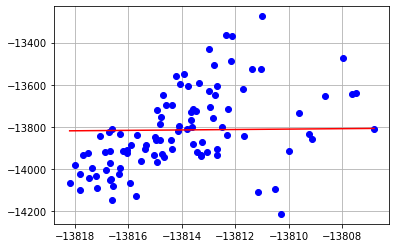

In [149]:
#prediction = torch.tensor(prediction)

x = np.linspace(min(test_labels), max(test_labels))
#print(min(torch.cat((test_labels,prediction),0)))
y = x
plt.plot(test_labels,prediction, 'o', color='blue')
plt.plot(x,y, color='red')
plt.grid()
#plt.xlim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction),0))])
#plt.ylim([min(torch.cat((test_labels,prediction),0)), max(torch.cat((test_labels,prediction)))])
#plt.ylim([-13822,-13800])
#plt.ticklabel_format(axis="y", style="plain")
plt.ticklabel_format(useOffset=False, style='plain')
#plt.tick_params(axis='both',labelsize=14)
plt.show()


In [150]:
print(type(prediction))

<class 'numpy.ndarray'>


In [151]:
print('layer 1')
print('weights')
print(net.network1.fc1.weight)
print('biases')
print(net.network1.fc1.bias)

print('layer 2')
print('weights')
print(net.network1.fc2.weight)
print('biases')
print(net.network1.fc2.bias)

layer 1
weights
Parameter containing:
tensor([[ 0.3467,  0.1783, -0.1976, -0.0820,  0.3896, -0.3771],
        [ 0.1470, -0.4094,  0.2563,  0.0858, -0.4884, -0.3029],
        [ 0.3046, -0.4701, -0.3936, -0.2701, -0.4003, -0.1922]],
       requires_grad=True)
biases
Parameter containing:
tensor([-0.2825, -0.3077, -0.0665], requires_grad=True)
layer 2
weights
Parameter containing:
tensor([[ 0.1165,  0.1692, -0.5351],
        [ 0.2666, -0.3344, -0.2699],
        [-0.1789,  0.5738, -0.1774]], requires_grad=True)
biases
Parameter containing:
tensor([-0.0458, -0.2185, -0.4684], requires_grad=True)
